In [1]:
# #bp神经网络

#数据提取和处理
import re

def encode_label(label_list: list) -> (list, list):
    label_name = [[] for i in range(5)]

    label_encoded_list = []

    for label in label_list:
        if label is None:
            label_encoded_list.append(None)
            continue
        label_encoded = []

        for i in range(len(label) - 1):
            if not label[i] in label_name[i]:
                label_name[i].append(label[i])
                label_encoded.append(len(label_name[i]) - 1)
            else:
                label_encoded.append(label_name[i].index(label[i]))

        if label[4] is None:
            label_encoded.append([None])
        else:
            prop = []
            for ll in label[4]:
                if not ll in label_name[4]:
                    label_name[4].append(ll)
                    prop.append(len(label_name[4]) - 1)
                else:
                    prop.append(label_name[4].index(ll))
            label_encoded.append(prop)

        label_encoded_list.append(label_encoded)
    return label_name, label_encoded_list

def read_label(path: str) -> (list, list):
    label_list = []
    img_name = []
    with open(path, "r") as f:
        r = f.readline()
        while r:
            img_name.append(r[:5].strip())
            t = re.search('_missing descriptor', r)
            if t is not None:
                label_list.append(None)
                r = f.readline()
                continue
            else:
                label1 = []
                pattern = re.compile(r'\((.*?)\)')
                t = pattern.findall(r)
                for s in t[0:-1]:
                    c = s.split(" ")[-1].strip()
                    label1.append(c)

                pattern = re.compile(r'\'\((.*?)\)')
                t = pattern.findall(r)[0].strip()
                if not t == '':
                    prop = []
                    t = t.split(" ")
                    for i in t:
                        prop.append(i)
                    label1.append(prop)
                else:
                    label1.append(None)
            label_list.append(label1)
            r = f.readline()
    return label_list, img_name

def one_hot_prop(label_encoded_list: list, prop_num: int) -> list:
    label_list = []
    iii = 0
    for label in label_encoded_list:
        iii += 1
        if label is not None:
            prop_one_hot = [0 for i in range(prop_num)]
            prop = label.pop()
            for i in prop:
                if i is not None:
                    prop_one_hot[i] = 1
            label.append(prop_one_hot)
            label_list.append(label)
            if 1 in prop_one_hot:
                pass
        else:
            label_list.append(None)
    return label_list

def one_hot(index, num):
    label_one_hot = [0 for i in range(num)]
    label_one_hot[index] = 1
    return label_one_hot

def one_hot_label(label_list: list, label_name) -> list:
    label_one_hot = []
    for label in label_list:
        if label is not None:
            l = []
            for i in range(len(label_name) - 1):
                o = one_hot(label[i], len(label_name[i]))
                l += o
            l += label[-1]
        else:
            label_one_hot.append(None)
            continue
        label_one_hot.append(l)
    return label_one_hot

def label_pre_one_hot(path1, path2):
    label_list1, img_name1 = read_label(path1)
    label_list2, img_name2 = read_label(path2)
    label_list = label_list1 + label_list2

    male = 0
    total = 0
    
    img_name = img_name1 + img_name2
    label_name, label_encoded_list = encode_label(label_list)
    prop_num = len(label_name[-1])
    label_list = one_hot_prop(label_encoded_list, prop_num)
    label_one_hot = one_hot_label(label_list, label_name)

    return label_one_hot, img_name, label_name

In [2]:
import raw_data_read_test as rd
import label_pre as lp
import cv2
from sklearn.neighbors import KNeighborsClassifier 
from sklearn.model_selection import train_test_split
import numpy as np
import sklearn
from sklearn import metrics
from sklearn import tree
from sklearn.decomposition import PCA
from matplotlib import pyplot as plt
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from sklearn.neural_network import MLPClassifier
from sklearn.preprocessing import StandardScaler

# 训练集
channels = 1  # 图像的通道数，灰度图为1
path_rawdata = r"./rawdata"
path_label1 = r"./faceDR"
path_label2 = r"./faceDS"
label_one_hot,img_name,label_list = label_pre_one_hot(path_label1,path_label2)
img_list = rd.read_rawdata(channels, path_rawdata, img_name)  # 图片矩阵

n = 0
for i in range(len(label_list)):
    num = i - n
    if label_list[num] is None:
        del label_list[num]
        del img_name[num]
        n = n + 1

array_of_img = []
for img in img_list:
    if img is not None:
        img = img / 255.0
        img = cv2.resize(img, (100, 100))
        array_of_img.append(img)
train_images = np.array(array_of_img)
array_of_img = []

#卷积标签数值化，男为0，女为1
array_of_labels = []
for label in label_one_hot:
    if label is not None:
        append_label = label[0]
        array_of_labels.append(int(append_label))
train_labels = np.array(array_of_labels)
array_of_labels = []

# 划分数据集和训练集
X_train, X_test, y_train, y_test = train_test_split(train_images, train_labels, test_size=0.2, random_state=3)

#更改图像维度，方便训练
X_train = X_train.reshape(X_train.shape[0], -1)
X_test = X_test.reshape(X_test.shape[0], -1)

# 特征降维(进行特征降维能大大减少训练时间但会一定程度的下降训练准确率)
pca = PCA(n_components=85)
X_train = pca.fit_transform(X_train)
X_test = pca.transform(X_test)

# 标准化
sc = StandardScaler()
sc.fit(X_train)
X_train_std = sc.transform(X_train)
X_test_std = sc.transform(X_test)
# MLP求解
# solver='lbfgs',  MLP的求解方法：L-BFGS 在小数据上表现较好，Adam 较为鲁棒，
#    SGD在参数调整较优时会有最佳表现（分类效果与迭代次数）；SGD标识随机梯度下降。
# alpha:L2的参数：MLP是可以支持正则化的，默认为L2，具体参数需要调整
# hidden_layer_sizes=(5, 2) hidden层2层,第一层5个神经元，第二层2个神经元)，2层隐藏层，也就有3层神经网络
bp = MLPClassifier(solver='lbfgs', alpha=1e-5,hidden_layer_sizes=(5,2), random_state=1) 
bp.fit(X_train_std, y_train)
print('每层网络层系数矩阵维度：\n',[coef.shape for coef in bp.coefs_])
score = bp.score(X_test_std,y_test)
print('bp神经网络训练准确率：',score*100,'%')

数据缺失： 1228
数据缺失： 1232
数据缺失： 1808
数据缺失： 4056
数据缺失： 4135
数据缺失： 4136
数据缺失： 5004
每层网络层系数矩阵维度：
 [(85, 5), (5, 2), (2, 1)]
bp神经网络训练准确率： 86.62551440329219 %


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [3]:
bp.fit(X_train_std, y_train)
score = bp.score(X_test_std,y_test)
print('bp神经网络训练准确率：',score*100,'%')

bp神经网络训练准确率： 86.62551440329219 %


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


In [4]:
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from sklearn.metrics import make_scorer
import numpy as np

k_fold = KFold(n_splits=10)
bp = MLPClassifier(random_state=1) 
params = {"hidden_layer_sizes": [(100,), (100,30),(5,2)],
              "solver": ['adam', 'sgd', 'lbfgs'],
              "alpha" : np.arange(1e-5,1e-4,1e-5),
              "max_iter": [20],
              "verbose": [True]
                             }
scoring_fnc = make_scorer(accuracy_score)
grid = GridSearchCV(bp, param_grid=params,scoring=scoring_fnc,cv=k_fold)
grid = grid.fit(X_train, y_train)

Iteration 1, loss = 1.20977686
Iteration 2, loss = 0.67463461
Iteration 3, loss = 0.53518255
Iteration 4, loss = 0.47280684
Iteration 5, loss = 0.43235301
Iteration 6, loss = 0.40406470
Iteration 7, loss = 0.38175356
Iteration 8, loss = 0.36329704
Iteration 9, loss = 0.34744591
Iteration 10, loss = 0.33368522
Iteration 11, loss = 0.32147641
Iteration 12, loss = 0.31031964
Iteration 13, loss = 0.30010868
Iteration 14, loss = 0.28990892
Iteration 15, loss = 0.28182092
Iteration 16, loss = 0.27334126
Iteration 17, loss = 0.26506549
Iteration 18, loss = 0.25829887
Iteration 19, loss = 0.25098637
Iteration 20, loss = 0.24375829
Iteration 1, loss = 1.21901760
Iteration 2, loss = 0.67934559
Iteration 3, loss = 0.53822179
Iteration 4, loss = 0.47450990


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43400437
Iteration 6, loss = 0.40560266
Iteration 7, loss = 0.38300097
Iteration 8, loss = 0.36428901
Iteration 9, loss = 0.34845798
Iteration 10, loss = 0.33454111
Iteration 11, loss = 0.32216885
Iteration 12, loss = 0.31078235
Iteration 13, loss = 0.30065360
Iteration 14, loss = 0.29017362
Iteration 15, loss = 0.28191316
Iteration 16, loss = 0.27369246
Iteration 17, loss = 0.26541799
Iteration 18, loss = 0.25793487
Iteration 19, loss = 0.25069343
Iteration 20, loss = 0.24329036
Iteration 1, loss = 1.21579741
Iteration 2, loss = 0.67871866
Iteration 3, loss = 0.53933694
Iteration 4, loss = 0.47711382
Iteration 5, loss = 0.43732122


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40889012
Iteration 7, loss = 0.38650677
Iteration 8, loss = 0.36796598
Iteration 9, loss = 0.35198571
Iteration 10, loss = 0.33776818
Iteration 11, loss = 0.32557552
Iteration 12, loss = 0.31431437
Iteration 13, loss = 0.30414750
Iteration 14, loss = 0.29337603
Iteration 15, loss = 0.28485413
Iteration 16, loss = 0.27657329
Iteration 17, loss = 0.26807776
Iteration 18, loss = 0.26030419
Iteration 19, loss = 0.25313394
Iteration 20, loss = 0.24580415
Iteration 1, loss = 1.19933757
Iteration 2, loss = 0.67171510
Iteration 3, loss = 0.53564451
Iteration 4, loss = 0.47177310
Iteration 5, loss = 0.43121995


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40232922
Iteration 7, loss = 0.37984619
Iteration 8, loss = 0.36118406
Iteration 9, loss = 0.34510092
Iteration 10, loss = 0.33103008
Iteration 11, loss = 0.31878992
Iteration 12, loss = 0.30730290
Iteration 13, loss = 0.29711699
Iteration 14, loss = 0.28713149
Iteration 15, loss = 0.27853251
Iteration 16, loss = 0.27053201
Iteration 17, loss = 0.26223760
Iteration 18, loss = 0.25490472
Iteration 19, loss = 0.24766024
Iteration 20, loss = 0.24082799
Iteration 1, loss = 1.21659997
Iteration 2, loss = 0.67425759
Iteration 3, loss = 0.53527198
Iteration 4, loss = 0.47221471
Iteration 5, loss = 0.43232013
Iteration 6, loss = 0.40414544
Iteration 7, loss = 0.38200853
Iteration 8, loss = 0.36400254


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.34839653
Iteration 10, loss = 0.33418669
Iteration 11, loss = 0.32204122
Iteration 12, loss = 0.31081298
Iteration 13, loss = 0.30061680
Iteration 14, loss = 0.29067013
Iteration 15, loss = 0.28182259
Iteration 16, loss = 0.27406633
Iteration 17, loss = 0.26544110
Iteration 18, loss = 0.25779783
Iteration 19, loss = 0.25071016
Iteration 20, loss = 0.24366263
Iteration 1, loss = 1.20898097
Iteration 2, loss = 0.67378148
Iteration 3, loss = 0.53560616
Iteration 4, loss = 0.47196168
Iteration 5, loss = 0.43169733


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40319829
Iteration 7, loss = 0.38095574
Iteration 8, loss = 0.36274138
Iteration 9, loss = 0.34725784
Iteration 10, loss = 0.33281036
Iteration 11, loss = 0.32071334
Iteration 12, loss = 0.30987842
Iteration 13, loss = 0.29955810
Iteration 14, loss = 0.28962055
Iteration 15, loss = 0.28058501
Iteration 16, loss = 0.27290010
Iteration 17, loss = 0.26450112
Iteration 18, loss = 0.25701181
Iteration 19, loss = 0.25004534
Iteration 20, loss = 0.24294925
Iteration 1, loss = 1.20031965


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67016058
Iteration 3, loss = 0.53369648
Iteration 4, loss = 0.46955107
Iteration 5, loss = 0.42924309
Iteration 6, loss = 0.40059424
Iteration 7, loss = 0.37802520
Iteration 8, loss = 0.35940622
Iteration 9, loss = 0.34346660
Iteration 10, loss = 0.32867569
Iteration 11, loss = 0.31618650
Iteration 12, loss = 0.30490969
Iteration 13, loss = 0.29465146
Iteration 14, loss = 0.28470907
Iteration 15, loss = 0.27612567
Iteration 16, loss = 0.26845403
Iteration 17, loss = 0.25995980
Iteration 18, loss = 0.25247997
Iteration 19, loss = 0.24564745
Iteration 20, loss = 0.23888946
Iteration 1, loss = 1.18672530
Iteration 2, loss = 0.66719214
Iteration 3, loss = 0.53568440
Iteration 4, loss = 0.47184490
Iteration 5, loss = 0.43152013
Iteration 6, loss = 0.40265647
Iteration 7, loss = 0.38014732
Iteration 8, loss = 0.36192254
Iteration 9, loss = 0.34577299


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.33162066
Iteration 11, loss = 0.31935893
Iteration 12, loss = 0.30806014
Iteration 13, loss = 0.29796273
Iteration 14, loss = 0.28806762
Iteration 15, loss = 0.27945377
Iteration 16, loss = 0.27156150
Iteration 17, loss = 0.26288439
Iteration 18, loss = 0.25556742
Iteration 19, loss = 0.24843449
Iteration 20, loss = 0.24204321
Iteration 1, loss = 1.20192383


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67080761
Iteration 3, loss = 0.53399439
Iteration 4, loss = 0.47104577
Iteration 5, loss = 0.43131834
Iteration 6, loss = 0.40337011
Iteration 7, loss = 0.38093883
Iteration 8, loss = 0.36239011
Iteration 9, loss = 0.34692920
Iteration 10, loss = 0.33344490
Iteration 11, loss = 0.32131289
Iteration 12, loss = 0.30954756
Iteration 13, loss = 0.29946107
Iteration 14, loss = 0.29023675
Iteration 15, loss = 0.28122511
Iteration 16, loss = 0.27345573
Iteration 17, loss = 0.26530631
Iteration 18, loss = 0.25765627
Iteration 19, loss = 0.25036235
Iteration 20, loss = 0.24352931
Iteration 1, loss = 1.19974597
Iteration 2, loss = 0.67200361


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53838763
Iteration 4, loss = 0.47584091
Iteration 5, loss = 0.43640747
Iteration 6, loss = 0.40866792
Iteration 7, loss = 0.38654395
Iteration 8, loss = 0.36800476
Iteration 9, loss = 0.35228965
Iteration 10, loss = 0.33844685
Iteration 11, loss = 0.32625524
Iteration 12, loss = 0.31451948
Iteration 13, loss = 0.30428839
Iteration 14, loss = 0.29516905
Iteration 15, loss = 0.28606238
Iteration 16, loss = 0.27821750
Iteration 17, loss = 0.27017201
Iteration 18, loss = 0.26219941
Iteration 19, loss = 0.25492184
Iteration 20, loss = 0.24800856
Iteration 1, loss = 1.30942413
Iteration 2, loss = 0.81569918
Iteration 3, loss = 0.74023403
Iteration 4, loss = 0.69720638
Iteration 5, loss = 0.67051053
Iteration 6, loss = 0.65021201


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.63372949
Iteration 8, loss = 0.61970106
Iteration 9, loss = 0.60660477
Iteration 10, loss = 0.59575489
Iteration 11, loss = 0.58537072
Iteration 12, loss = 0.57613938
Iteration 13, loss = 0.56763392
Iteration 14, loss = 0.55971940
Iteration 15, loss = 0.55249511
Iteration 16, loss = 0.54547808
Iteration 17, loss = 0.53869675
Iteration 18, loss = 0.53284618
Iteration 19, loss = 0.52717703
Iteration 20, loss = 0.52128333
Iteration 1, loss = 1.31920704


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.82145033
Iteration 3, loss = 0.74659778
Iteration 4, loss = 0.70277350
Iteration 5, loss = 0.67637703
Iteration 6, loss = 0.65609128
Iteration 7, loss = 0.63970944
Iteration 8, loss = 0.62570511
Iteration 9, loss = 0.61284869
Iteration 10, loss = 0.60211618
Iteration 11, loss = 0.59168288
Iteration 12, loss = 0.58266009
Iteration 13, loss = 0.57426200
Iteration 14, loss = 0.56605058
Iteration 15, loss = 0.55888038
Iteration 16, loss = 0.55193441
Iteration 17, loss = 0.54513235
Iteration 18, loss = 0.53919190
Iteration 19, loss = 0.53323740
Iteration 20, loss = 0.52733309
Iteration 1, loss = 1.31798903
Iteration 2, loss = 0.81948345
Iteration 3, loss = 0.74608786
Iteration 4, loss = 0.70336150
Iteration 5, loss = 0.67758156
Iteration 6, loss = 0.65746470


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.64125525
Iteration 8, loss = 0.62737683
Iteration 9, loss = 0.61470463
Iteration 10, loss = 0.60391674
Iteration 11, loss = 0.59385370
Iteration 12, loss = 0.58504082
Iteration 13, loss = 0.57679518
Iteration 14, loss = 0.56851017
Iteration 15, loss = 0.56129288
Iteration 16, loss = 0.55440585
Iteration 17, loss = 0.54780513
Iteration 18, loss = 0.54192751
Iteration 19, loss = 0.53595507
Iteration 20, loss = 0.53021267


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.30467740
Iteration 2, loss = 0.81748536
Iteration 3, loss = 0.74453870
Iteration 4, loss = 0.70117388
Iteration 5, loss = 0.67474625
Iteration 6, loss = 0.65455332
Iteration 7, loss = 0.63785128
Iteration 8, loss = 0.62355066
Iteration 9, loss = 0.61062351
Iteration 10, loss = 0.59940906
Iteration 11, loss = 0.58910756
Iteration 12, loss = 0.58004992
Iteration 13, loss = 0.57146601
Iteration 14, loss = 0.56304811
Iteration 15, loss = 0.55572520
Iteration 16, loss = 0.54844843
Iteration 17, loss = 0.54184054
Iteration 18, loss = 0.53567753
Iteration 19, loss = 0.52947811
Iteration 20, loss = 0.52366612
Iteration 1, loss = 1.32149264
Iteration 2, loss = 0.81874062


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74619392
Iteration 4, loss = 0.70169187
Iteration 5, loss = 0.67514397
Iteration 6, loss = 0.65457185
Iteration 7, loss = 0.63775337
Iteration 8, loss = 0.62338580
Iteration 9, loss = 0.61057023
Iteration 10, loss = 0.59905497
Iteration 11, loss = 0.58889844
Iteration 12, loss = 0.57976498
Iteration 13, loss = 0.57119813
Iteration 14, loss = 0.56288769
Iteration 15, loss = 0.55550889
Iteration 16, loss = 0.54842993
Iteration 17, loss = 0.54185780
Iteration 18, loss = 0.53573184
Iteration 19, loss = 0.52963771
Iteration 20, loss = 0.52396044
Iteration 1, loss = 1.31462741
Iteration 2, loss = 0.81971208


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74685369
Iteration 4, loss = 0.70308026
Iteration 5, loss = 0.67710873
Iteration 6, loss = 0.65688038
Iteration 7, loss = 0.64052374
Iteration 8, loss = 0.62637529
Iteration 9, loss = 0.61406206
Iteration 10, loss = 0.60261236
Iteration 11, loss = 0.59273571
Iteration 12, loss = 0.58383237
Iteration 13, loss = 0.57493825
Iteration 14, loss = 0.56677911
Iteration 15, loss = 0.55950939
Iteration 16, loss = 0.55220707
Iteration 17, loss = 0.54574042
Iteration 18, loss = 0.53953849
Iteration 19, loss = 0.53345510
Iteration 20, loss = 0.52766628
Iteration 1, loss = 1.31067303
Iteration 2, loss = 0.81715602
Iteration 3, loss = 0.74360037
Iteration 4, loss = 0.69895187
Iteration 5, loss = 0.67262397
Iteration 6, loss = 0.65244358


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.63594516
Iteration 8, loss = 0.62179756
Iteration 9, loss = 0.60982016
Iteration 10, loss = 0.59816466
Iteration 11, loss = 0.58835065
Iteration 12, loss = 0.57936066
Iteration 13, loss = 0.57080421
Iteration 14, loss = 0.56292849
Iteration 15, loss = 0.55588053
Iteration 16, loss = 0.54860812
Iteration 17, loss = 0.54231722
Iteration 18, loss = 0.53610088
Iteration 19, loss = 0.53012214
Iteration 20, loss = 0.52469609
Iteration 1, loss = 1.30134114
Iteration 2, loss = 0.81650662
Iteration 3, loss = 0.74584140
Iteration 4, loss = 0.70192894
Iteration 5, loss = 0.67571291
Iteration 6, loss = 0.65543294
Iteration 7, loss = 0.63889520


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.62465180
Iteration 9, loss = 0.61228141
Iteration 10, loss = 0.60082968
Iteration 11, loss = 0.59091291
Iteration 12, loss = 0.58168835
Iteration 13, loss = 0.57317877
Iteration 14, loss = 0.56511704
Iteration 15, loss = 0.55794378
Iteration 16, loss = 0.55066189
Iteration 17, loss = 0.54421781
Iteration 18, loss = 0.53786739
Iteration 19, loss = 0.53192322
Iteration 20, loss = 0.52652082
Iteration 1, loss = 1.31270068
Iteration 2, loss = 0.81863284
Iteration 3, loss = 0.74182554
Iteration 4, loss = 0.69808802


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67151820
Iteration 6, loss = 0.65133580
Iteration 7, loss = 0.63486004
Iteration 8, loss = 0.62070287
Iteration 9, loss = 0.60830408
Iteration 10, loss = 0.59706270
Iteration 11, loss = 0.58698407
Iteration 12, loss = 0.57754587
Iteration 13, loss = 0.56895587
Iteration 14, loss = 0.56081692
Iteration 15, loss = 0.55355685
Iteration 16, loss = 0.54640918
Iteration 17, loss = 0.53990505
Iteration 18, loss = 0.53358433
Iteration 19, loss = 0.52770082
Iteration 20, loss = 0.52195594


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31476246
Iteration 2, loss = 0.82243614
Iteration 3, loss = 0.74937215
Iteration 4, loss = 0.70623847
Iteration 5, loss = 0.67937965
Iteration 6, loss = 0.65912745
Iteration 7, loss = 0.64252764
Iteration 8, loss = 0.62843428
Iteration 9, loss = 0.61587686
Iteration 10, loss = 0.60447960
Iteration 11, loss = 0.59444527
Iteration 12, loss = 0.58501255
Iteration 13, loss = 0.57632914
Iteration 14, loss = 0.56828415
Iteration 15, loss = 0.56083336
Iteration 16, loss = 0.55362941
Iteration 17, loss = 0.54696687
Iteration 18, loss = 0.54067010
Iteration 19, loss = 0.53466315
Iteration 20, loss = 0.52871103


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67296567
Iteration 2, loss = 0.52492542
Iteration 3, loss = 0.44503537
Iteration 4, loss = 0.38351295
Iteration 5, loss = 0.33998961
Iteration 6, loss = 0.30927800
Iteration 7, loss = 0.28384449
Iteration 8, loss = 0.26384176
Iteration 9, loss = 0.24447618
Iteration 10, loss = 0.22938403
Iteration 11, loss = 0.21477115
Iteration 12, loss = 0.20364861
Iteration 13, loss = 0.18958328
Iteration 14, loss = 0.17529130
Iteration 15, loss = 0.16465020
Iteration 16, loss = 0.15394388
Iteration 17, loss = 0.14237840
Iteration 18, loss = 0.13354491
Iteration 19, loss = 0.12694356
Iteration 20, loss = 0.11617222
Iteration 1, loss = 0.68156904
Iteration 2, loss = 0.53135028


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44922605
Iteration 4, loss = 0.38693108
Iteration 5, loss = 0.34318877
Iteration 6, loss = 0.31377488
Iteration 7, loss = 0.28766279
Iteration 8, loss = 0.26686593
Iteration 9, loss = 0.24675421
Iteration 10, loss = 0.23223645
Iteration 11, loss = 0.21756022
Iteration 12, loss = 0.20334729
Iteration 13, loss = 0.19041850
Iteration 14, loss = 0.17769382
Iteration 15, loss = 0.16697275
Iteration 16, loss = 0.15685990
Iteration 17, loss = 0.14532209
Iteration 18, loss = 0.13533895
Iteration 19, loss = 0.12727802
Iteration 20, loss = 0.11856171
Iteration 1, loss = 0.67752288
Iteration 2, loss = 0.53209824
Iteration 3, loss = 0.45090428
Iteration 4, loss = 0.38975854
Iteration 5, loss = 0.34682325


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.31610515
Iteration 7, loss = 0.28943204
Iteration 8, loss = 0.26702193
Iteration 9, loss = 0.24847352
Iteration 10, loss = 0.23369603
Iteration 11, loss = 0.21814304
Iteration 12, loss = 0.20324058
Iteration 13, loss = 0.19007628
Iteration 14, loss = 0.17809636
Iteration 15, loss = 0.16600813
Iteration 16, loss = 0.15560477
Iteration 17, loss = 0.14497636
Iteration 18, loss = 0.13432794
Iteration 19, loss = 0.12571221
Iteration 20, loss = 0.11697722
Iteration 1, loss = 0.67833163
Iteration 2, loss = 0.53030954
Iteration 3, loss = 0.44898158


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38718927
Iteration 5, loss = 0.34446164
Iteration 6, loss = 0.31385653
Iteration 7, loss = 0.28552344
Iteration 8, loss = 0.26483231
Iteration 9, loss = 0.24760161
Iteration 10, loss = 0.23439554
Iteration 11, loss = 0.21862819
Iteration 12, loss = 0.20317748
Iteration 13, loss = 0.19081445
Iteration 14, loss = 0.17822225
Iteration 15, loss = 0.16734768
Iteration 16, loss = 0.15752351
Iteration 17, loss = 0.14710404
Iteration 18, loss = 0.13624961
Iteration 19, loss = 0.12757265
Iteration 20, loss = 0.11905892
Iteration 1, loss = 0.67679441
Iteration 2, loss = 0.52744708
Iteration 3, loss = 0.44652536


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38650714
Iteration 5, loss = 0.34518390
Iteration 6, loss = 0.31603529
Iteration 7, loss = 0.28688690
Iteration 8, loss = 0.26666297
Iteration 9, loss = 0.24938764
Iteration 10, loss = 0.23417490
Iteration 11, loss = 0.21826868
Iteration 12, loss = 0.20268372
Iteration 13, loss = 0.19045553
Iteration 14, loss = 0.17716462
Iteration 15, loss = 0.16670704
Iteration 16, loss = 0.15573962
Iteration 17, loss = 0.14451425
Iteration 18, loss = 0.13384988
Iteration 19, loss = 0.12487845
Iteration 20, loss = 0.11626768
Iteration 1, loss = 0.67900048
Iteration 2, loss = 0.52940808
Iteration 3, loss = 0.44800467
Iteration 4, loss = 0.38694151


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34355106
Iteration 6, loss = 0.31451405
Iteration 7, loss = 0.28454287
Iteration 8, loss = 0.26455337
Iteration 9, loss = 0.24640811
Iteration 10, loss = 0.23148742
Iteration 11, loss = 0.21655359
Iteration 12, loss = 0.20058115
Iteration 13, loss = 0.18811551
Iteration 14, loss = 0.17668792
Iteration 15, loss = 0.16444972
Iteration 16, loss = 0.15270517
Iteration 17, loss = 0.14214150
Iteration 18, loss = 0.13243625
Iteration 19, loss = 0.12272849
Iteration 20, loss = 0.11476101
Iteration 1, loss = 0.67672679
Iteration 2, loss = 0.52461984
Iteration 3, loss = 0.44228685


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38084912
Iteration 5, loss = 0.33640019
Iteration 6, loss = 0.30636755
Iteration 7, loss = 0.27751741
Iteration 8, loss = 0.25747282
Iteration 9, loss = 0.23872505
Iteration 10, loss = 0.22533214
Iteration 11, loss = 0.20991481
Iteration 12, loss = 0.19634896
Iteration 13, loss = 0.18427738
Iteration 14, loss = 0.17263768
Iteration 15, loss = 0.16050378
Iteration 16, loss = 0.15026781
Iteration 17, loss = 0.14048003
Iteration 18, loss = 0.13101596
Iteration 19, loss = 0.12107557
Iteration 20, loss = 0.11407700
Iteration 1, loss = 0.67502022
Iteration 2, loss = 0.52682487
Iteration 3, loss = 0.44545492
Iteration 4, loss = 0.38716240


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34349266
Iteration 6, loss = 0.31384735
Iteration 7, loss = 0.28683122
Iteration 8, loss = 0.26705391
Iteration 9, loss = 0.24797013
Iteration 10, loss = 0.23341788
Iteration 11, loss = 0.21831210
Iteration 12, loss = 0.20337395
Iteration 13, loss = 0.19187407
Iteration 14, loss = 0.18101452
Iteration 15, loss = 0.16797846
Iteration 16, loss = 0.15816422
Iteration 17, loss = 0.14717940
Iteration 18, loss = 0.13668258
Iteration 19, loss = 0.12719233
Iteration 20, loss = 0.11870903
Iteration 1, loss = 0.67030691
Iteration 2, loss = 0.52294515
Iteration 3, loss = 0.44184974
Iteration 4, loss = 0.38314671


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.33933788
Iteration 6, loss = 0.30812725
Iteration 7, loss = 0.28509363
Iteration 8, loss = 0.26502180
Iteration 9, loss = 0.24660770
Iteration 10, loss = 0.23238557
Iteration 11, loss = 0.21644597
Iteration 12, loss = 0.20186757
Iteration 13, loss = 0.19051421
Iteration 14, loss = 0.17867269
Iteration 15, loss = 0.16662573
Iteration 16, loss = 0.15537845
Iteration 17, loss = 0.14439020
Iteration 18, loss = 0.13587815
Iteration 19, loss = 0.12584697
Iteration 20, loss = 0.11764570
Iteration 1, loss = 0.67438805
Iteration 2, loss = 0.53026148


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44961498
Iteration 4, loss = 0.39030137
Iteration 5, loss = 0.34569746
Iteration 6, loss = 0.31429092
Iteration 7, loss = 0.28951527
Iteration 8, loss = 0.26851070
Iteration 9, loss = 0.25102811
Iteration 10, loss = 0.23780387
Iteration 11, loss = 0.22044422
Iteration 12, loss = 0.20474644
Iteration 13, loss = 0.19258702
Iteration 14, loss = 0.17948905
Iteration 15, loss = 0.16744419
Iteration 16, loss = 0.15604731
Iteration 17, loss = 0.14479737
Iteration 18, loss = 0.13596233
Iteration 19, loss = 0.12501068
Iteration 20, loss = 0.11695519
Iteration 1, loss = 0.76597856
Iteration 2, loss = 0.72034776
Iteration 3, loss = 0.68517144
Iteration 4, loss = 0.65813681


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.63941687
Iteration 6, loss = 0.62432771
Iteration 7, loss = 0.61151480
Iteration 8, loss = 0.60057064
Iteration 9, loss = 0.58959400
Iteration 10, loss = 0.58053130
Iteration 11, loss = 0.57126012
Iteration 12, loss = 0.56297414
Iteration 13, loss = 0.55484891
Iteration 14, loss = 0.54716820
Iteration 15, loss = 0.53954345
Iteration 16, loss = 0.53233199
Iteration 17, loss = 0.52526413
Iteration 18, loss = 0.51883574
Iteration 19, loss = 0.51212495
Iteration 20, loss = 0.50565965


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76943474
Iteration 2, loss = 0.72375276
Iteration 3, loss = 0.68889636
Iteration 4, loss = 0.66220887
Iteration 5, loss = 0.64359933
Iteration 6, loss = 0.62871750
Iteration 7, loss = 0.61571163
Iteration 8, loss = 0.60472149
Iteration 9, loss = 0.59400753
Iteration 10, loss = 0.58490211
Iteration 11, loss = 0.57572023
Iteration 12, loss = 0.56749747
Iteration 13, loss = 0.55951789
Iteration 14, loss = 0.55198655
Iteration 15, loss = 0.54436786
Iteration 16, loss = 0.53721663
Iteration 17, loss = 0.53011588
Iteration 18, loss = 0.52364154
Iteration 19, loss = 0.51702813
Iteration 20, loss = 0.51063780
Iteration 1, loss = 0.76524629
Iteration 2, loss = 0.72069983
Iteration 3, loss = 0.68658708
Iteration 4, loss = 0.66053873
Iteration 5, loss = 0.64244506
Iteration 6, loss = 0.62769665


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.61502752
Iteration 8, loss = 0.60437185
Iteration 9, loss = 0.59433599
Iteration 10, loss = 0.58522858
Iteration 11, loss = 0.57627759
Iteration 12, loss = 0.56818864
Iteration 13, loss = 0.56054866
Iteration 14, loss = 0.55305244
Iteration 15, loss = 0.54558808
Iteration 16, loss = 0.53858303
Iteration 17, loss = 0.53183105
Iteration 18, loss = 0.52520203
Iteration 19, loss = 0.51855986
Iteration 20, loss = 0.51219628
Iteration 1, loss = 0.76665616
Iteration 2, loss = 0.72129715
Iteration 3, loss = 0.68635713
Iteration 4, loss = 0.65966963
Iteration 5, loss = 0.64097705
Iteration 6, loss = 0.62563222


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.61247445
Iteration 8, loss = 0.60136228
Iteration 9, loss = 0.59109524
Iteration 10, loss = 0.58161683
Iteration 11, loss = 0.57234080
Iteration 12, loss = 0.56393672
Iteration 13, loss = 0.55610209
Iteration 14, loss = 0.54840959
Iteration 15, loss = 0.54060908
Iteration 16, loss = 0.53343091
Iteration 17, loss = 0.52641050
Iteration 18, loss = 0.51964537
Iteration 19, loss = 0.51300680
Iteration 20, loss = 0.50655415
Iteration 1, loss = 0.76567332
Iteration 2, loss = 0.71884021
Iteration 3, loss = 0.68410526
Iteration 4, loss = 0.65729919
Iteration 5, loss = 0.63887139


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62358269
Iteration 7, loss = 0.61056692
Iteration 8, loss = 0.59934773
Iteration 9, loss = 0.58928792
Iteration 10, loss = 0.57979272
Iteration 11, loss = 0.57046665
Iteration 12, loss = 0.56201143
Iteration 13, loss = 0.55439609
Iteration 14, loss = 0.54633418
Iteration 15, loss = 0.53872076
Iteration 16, loss = 0.53153906
Iteration 17, loss = 0.52479447
Iteration 18, loss = 0.51808139
Iteration 19, loss = 0.51148949
Iteration 20, loss = 0.50481770
Iteration 1, loss = 0.76741350
Iteration 2, loss = 0.72110882
Iteration 3, loss = 0.68658331
Iteration 4, loss = 0.65985852
Iteration 5, loss = 0.64129899
Iteration 6, loss = 0.62609625


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.61337174
Iteration 8, loss = 0.60227265
Iteration 9, loss = 0.59234052
Iteration 10, loss = 0.58307901
Iteration 11, loss = 0.57399344
Iteration 12, loss = 0.56568781
Iteration 13, loss = 0.55825511
Iteration 14, loss = 0.55010129
Iteration 15, loss = 0.54264326
Iteration 16, loss = 0.53551446
Iteration 17, loss = 0.52860868
Iteration 18, loss = 0.52209242
Iteration 19, loss = 0.51539297
Iteration 20, loss = 0.50881581
Iteration 1, loss = 0.76912738
Iteration 2, loss = 0.72079387
Iteration 3, loss = 0.68443621


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65702442
Iteration 5, loss = 0.63807419
Iteration 6, loss = 0.62270811
Iteration 7, loss = 0.60966705
Iteration 8, loss = 0.59839914
Iteration 9, loss = 0.58809059
Iteration 10, loss = 0.57883163
Iteration 11, loss = 0.56970135
Iteration 12, loss = 0.56151515
Iteration 13, loss = 0.55386563
Iteration 14, loss = 0.54579118
Iteration 15, loss = 0.53817471
Iteration 16, loss = 0.53128199
Iteration 17, loss = 0.52414848
Iteration 18, loss = 0.51777843
Iteration 19, loss = 0.51128610
Iteration 20, loss = 0.50472751
Iteration 1, loss = 0.76427668
Iteration 2, loss = 0.71937679
Iteration 3, loss = 0.68493298


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65959303
Iteration 5, loss = 0.64089828
Iteration 6, loss = 0.62586029
Iteration 7, loss = 0.61294806
Iteration 8, loss = 0.60171019
Iteration 9, loss = 0.59143599
Iteration 10, loss = 0.58208425
Iteration 11, loss = 0.57294023
Iteration 12, loss = 0.56460610
Iteration 13, loss = 0.55687574
Iteration 14, loss = 0.54905498
Iteration 15, loss = 0.54125301
Iteration 16, loss = 0.53476709
Iteration 17, loss = 0.52733155
Iteration 18, loss = 0.52062377
Iteration 19, loss = 0.51406787
Iteration 20, loss = 0.50760186
Iteration 1, loss = 0.76275610
Iteration 2, loss = 0.71655288
Iteration 3, loss = 0.68143347


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65534051
Iteration 5, loss = 0.63672379
Iteration 6, loss = 0.62145056
Iteration 7, loss = 0.60884153
Iteration 8, loss = 0.59757018
Iteration 9, loss = 0.58760127
Iteration 10, loss = 0.57817047
Iteration 11, loss = 0.56908574
Iteration 12, loss = 0.56099226
Iteration 13, loss = 0.55291004
Iteration 14, loss = 0.54573607
Iteration 15, loss = 0.53790398
Iteration 16, loss = 0.53036601
Iteration 17, loss = 0.52359364
Iteration 18, loss = 0.51653326
Iteration 19, loss = 0.51014506
Iteration 20, loss = 0.50366670


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76276134
Iteration 2, loss = 0.71936317
Iteration 3, loss = 0.68544260
Iteration 4, loss = 0.66017346
Iteration 5, loss = 0.64207409
Iteration 6, loss = 0.62716774
Iteration 7, loss = 0.61458059
Iteration 8, loss = 0.60358697
Iteration 9, loss = 0.59364376
Iteration 10, loss = 0.58432253
Iteration 11, loss = 0.57542409
Iteration 12, loss = 0.56744548
Iteration 13, loss = 0.55953838
Iteration 14, loss = 0.55217933
Iteration 15, loss = 0.54479936
Iteration 16, loss = 0.53741431
Iteration 17, loss = 0.53094774
Iteration 18, loss = 0.52404548
Iteration 19, loss = 0.51778591
Iteration 20, loss = 0.51136377


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756119
Iteration 2, loss = 0.91641614
Iteration 3, loss = 0.90030578
Iteration 4, loss = 0.88813883
Iteration 5, loss = 0.87854661
Iteration 6, loss = 0.87097311
Iteration 7, loss = 0.86450525
Iteration 8, loss = 0.85879413
Iteration 9, loss = 0.85371747
Iteration 10, loss = 0.84894195
Iteration 11, loss = 0.84442483
Iteration 12, loss = 0.84017169
Iteration 13, loss = 0.83596024
Iteration 14, loss = 0.83184715
Iteration 15, loss = 0.82787377
Iteration 16, loss = 0.82393503
Iteration 17, loss = 0.82008017
Iteration 18, loss = 0.81625624
Iteration 19, loss = 0.81248651
Iteration 20, loss = 0.80869903
Iteration 1, loss = 0.93280277
Iteration 2, loss = 0.91177850
Iteration 3, loss = 0.89567411
Iteration 4, loss = 0.88353948
Iteration 5, loss = 0.87401707
Iteration 6, loss = 0.86645549
Iteration 7, loss = 0.85999569
Iteration 8, loss = 0.85432354
Iteration 9, loss = 0.84930193
Iteration 10, loss = 0.84463595
Iteration 11, loss = 0.84018555
Iteration 12, loss = 0.835

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14, loss = 0.82781624
Iteration 15, loss = 0.82391641
Iteration 16, loss = 0.82006601
Iteration 17, loss = 0.81628400
Iteration 18, loss = 0.81254720
Iteration 19, loss = 0.80886563
Iteration 20, loss = 0.80519982
Iteration 1, loss = 0.92815709
Iteration 2, loss = 0.90750625
Iteration 3, loss = 0.89179608
Iteration 4, loss = 0.87996821
Iteration 5, loss = 0.87058440
Iteration 6, loss = 0.86320594
Iteration 7, loss = 0.85686395
Iteration 8, loss = 0.85127949
Iteration 9, loss = 0.84633009


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.84173082
Iteration 11, loss = 0.83735952
Iteration 12, loss = 0.83317746
Iteration 13, loss = 0.82911661
Iteration 14, loss = 0.82513578
Iteration 15, loss = 0.82125296
Iteration 16, loss = 0.81744328
Iteration 17, loss = 0.81368466
Iteration 18, loss = 0.80994173
Iteration 19, loss = 0.80624253
Iteration 20, loss = 0.80251522
Iteration 1, loss = 0.93653910
Iteration 2, loss = 0.91524225
Iteration 3, loss = 0.89910156
Iteration 4, loss = 0.88696958


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.87734452
Iteration 6, loss = 0.86975070
Iteration 7, loss = 0.86326961
Iteration 8, loss = 0.85756118
Iteration 9, loss = 0.85249626
Iteration 10, loss = 0.84777534
Iteration 11, loss = 0.84333539
Iteration 12, loss = 0.83905587
Iteration 13, loss = 0.83488498
Iteration 14, loss = 0.83084337
Iteration 15, loss = 0.82684170
Iteration 16, loss = 0.82297634
Iteration 17, loss = 0.81912024
Iteration 18, loss = 0.81532904
Iteration 19, loss = 0.81154728
Iteration 20, loss = 0.80781273
Iteration 1, loss = 0.92778122
Iteration 2, loss = 0.90696177
Iteration 3, loss = 0.89119824
Iteration 4, loss = 0.87938341
Iteration 5, loss = 0.86991018
Iteration 6, loss = 0.86254856


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.85618994
Iteration 8, loss = 0.85067949
Iteration 9, loss = 0.84573115
Iteration 10, loss = 0.84118291
Iteration 11, loss = 0.83682303
Iteration 12, loss = 0.83266116
Iteration 13, loss = 0.82856910
Iteration 14, loss = 0.82459128
Iteration 15, loss = 0.82062325
Iteration 16, loss = 0.81672643
Iteration 17, loss = 0.81276993
Iteration 18, loss = 0.80878951
Iteration 19, loss = 0.80464275
Iteration 20, loss = 0.80035930
Iteration 1, loss = 0.93307630
Iteration 2, loss = 0.91218748
Iteration 3, loss = 0.89621973


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.88429346
Iteration 5, loss = 0.87477330
Iteration 6, loss = 0.86730620
Iteration 7, loss = 0.86085471
Iteration 8, loss = 0.85533222
Iteration 9, loss = 0.85024934
Iteration 10, loss = 0.84564208
Iteration 11, loss = 0.84122104
Iteration 12, loss = 0.83696153
Iteration 13, loss = 0.83282211
Iteration 14, loss = 0.82880801
Iteration 15, loss = 0.82476021
Iteration 16, loss = 0.82087946
Iteration 17, loss = 0.81691449
Iteration 18, loss = 0.81302396
Iteration 19, loss = 0.80901832
Iteration 20, loss = 0.80493420
Iteration 1, loss = 0.93714351
Iteration 2, loss = 0.91606905
Iteration 3, loss = 0.89995360
Iteration 4, loss = 0.88787620
Iteration 5, loss = 0.87815922
Iteration 6, loss = 0.87057139
Iteration 7, loss = 0.86398128
Iteration 8, loss = 0.85841601
Iteration 9, loss = 0.85324022
Iteration 10, loss = 0.84857689
Iteration 11, loss = 0.84410877
Iteration 12, loss = 0.83978549
Iteration 13, loss = 0.83562403
Iteration 14, loss = 0.83156491


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.82749465
Iteration 16, loss = 0.82358569
Iteration 17, loss = 0.81963007
Iteration 18, loss = 0.81581365
Iteration 19, loss = 0.81189141
Iteration 20, loss = 0.80797394
Iteration 1, loss = 0.94162158
Iteration 2, loss = 0.92022060
Iteration 3, loss = 0.90384430
Iteration 4, loss = 0.89158906
Iteration 5, loss = 0.88185586
Iteration 6, loss = 0.87419726
Iteration 7, loss = 0.86756279
Iteration 8, loss = 0.86192690
Iteration 9, loss = 0.85670507
Iteration 10, loss = 0.85195354
Iteration 11, loss = 0.84740359


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.84303377
Iteration 13, loss = 0.83882194
Iteration 14, loss = 0.83470656
Iteration 15, loss = 0.83059042
Iteration 16, loss = 0.82664446
Iteration 17, loss = 0.82266260
Iteration 18, loss = 0.81879994
Iteration 19, loss = 0.81490023
Iteration 20, loss = 0.81098870
Iteration 1, loss = 0.93283126
Iteration 2, loss = 0.91197159
Iteration 3, loss = 0.89607373
Iteration 4, loss = 0.88374813
Iteration 5, loss = 0.87446330
Iteration 6, loss = 0.86681290
Iteration 7, loss = 0.86035164
Iteration 8, loss = 0.85481522
Iteration 9, loss = 0.84978382


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.84515755
Iteration 11, loss = 0.84064984
Iteration 12, loss = 0.83648666
Iteration 13, loss = 0.83238568
Iteration 14, loss = 0.82841636
Iteration 15, loss = 0.82443872
Iteration 16, loss = 0.82057488
Iteration 17, loss = 0.81678241
Iteration 18, loss = 0.81297419
Iteration 19, loss = 0.80921743
Iteration 20, loss = 0.80545502
Iteration 1, loss = 0.93359235
Iteration 2, loss = 0.91282952
Iteration 3, loss = 0.89700055
Iteration 4, loss = 0.88477734
Iteration 5, loss = 0.87550211
Iteration 6, loss = 0.86780416
Iteration 7, loss = 0.86138639
Iteration 8, loss = 0.85582597
Iteration 9, loss = 0.85076254
Iteration 10, loss = 0.84611657


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.84160389
Iteration 12, loss = 0.83741953
Iteration 13, loss = 0.83330756
Iteration 14, loss = 0.82931704
Iteration 15, loss = 0.82532681
Iteration 16, loss = 0.82147199
Iteration 17, loss = 0.81766948
Iteration 18, loss = 0.81383765
Iteration 19, loss = 0.81009951
Iteration 20, loss = 0.80634226
Iteration 1, loss = 0.93286175
Iteration 2, loss = 0.88285884
Iteration 3, loss = 0.83909452
Iteration 4, loss = 0.80810460
Iteration 5, loss = 0.78694939
Iteration 6, loss = 0.77324186
Iteration 7, loss = 0.76373515
Iteration 8, loss = 0.75647881
Iteration 9, loss = 0.75073208
Iteration 10, loss = 0.74537769
Iteration 11, loss = 0.74037746
Iteration 12, loss = 0.73561682
Iteration 13, loss = 0.73080277
Iteration 14, loss = 0.72603236
Iteration 15, loss = 0.72128984
Iteration 16, loss = 0.71690861
Iteration 17, loss = 0.71253635
Iteration 18, loss = 0.70789711
Iteration 19, loss = 0.70348700
Iteration 20, loss = 0.69889503
Iteration 1, loss = 0.92814874
Iteration 2, loss 

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.92398297
Iteration 2, loss = 0.87607906
Iteration 3, loss = 0.83404982
Iteration 4, loss = 0.80442696
Iteration 5, loss = 0.78394375
Iteration 6, loss = 0.77093273
Iteration 7, loss = 0.76169634
Iteration 8, loss = 0.75470600
Iteration 9, loss = 0.74922749
Iteration 10, loss = 0.74429399
Iteration 11, loss = 0.73961025
Iteration 12, loss = 0.73510396
Iteration 13, loss = 0.73071350
Iteration 14, loss = 0.72641467
Iteration 15, loss = 0.72208084
Iteration 16, loss = 0.71821949
Iteration 17, loss = 0.71442633
Iteration 18, loss = 0.71054575
Iteration 19, loss = 0.70677068
Iteration 20, loss = 0.70280626


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93176296
Iteration 2, loss = 0.88132561
Iteration 3, loss = 0.83751432
Iteration 4, loss = 0.80675577
Iteration 5, loss = 0.78555215
Iteration 6, loss = 0.77212457
Iteration 7, loss = 0.76281744
Iteration 8, loss = 0.75568026
Iteration 9, loss = 0.75006194
Iteration 10, loss = 0.74496190
Iteration 11, loss = 0.74020399
Iteration 12, loss = 0.73557035
Iteration 13, loss = 0.73100112
Iteration 14, loss = 0.72659275
Iteration 15, loss = 0.72207421
Iteration 16, loss = 0.71787462
Iteration 17, loss = 0.71382782
Iteration 18, loss = 0.70968799
Iteration 19, loss = 0.70551044
Iteration 20, loss = 0.70129906
Iteration 1, loss = 0.92335884
Iteration 2, loss = 0.87522298
Iteration 3, loss = 0.83327950
Iteration 4, loss = 0.80373231
Iteration 5, loss = 0.78288729
Iteration 6, loss = 0.76983564
Iteration 7, loss = 0.76060319
Iteration 8, loss = 0.75380829
Iteration 9, loss = 0.74837396
Iteration 10, loss = 0.74363094
Iteration 11, loss = 0.73895813
Iteration 12, loss = 0.734

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.73020655
Iteration 14, loss = 0.72597909
Iteration 15, loss = 0.72161675
Iteration 16, loss = 0.71757185
Iteration 17, loss = 0.71368081
Iteration 18, loss = 0.70974461
Iteration 19, loss = 0.70572178
Iteration 20, loss = 0.70162395
Iteration 1, loss = 0.92845951
Iteration 2, loss = 0.87985447
Iteration 3, loss = 0.83702143
Iteration 4, loss = 0.80692113
Iteration 5, loss = 0.78580007
Iteration 6, loss = 0.77245912
Iteration 7, loss = 0.76291122
Iteration 8, loss = 0.75614501


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.75036649
Iteration 10, loss = 0.74546118
Iteration 11, loss = 0.74062069
Iteration 12, loss = 0.73597111
Iteration 13, loss = 0.73142418
Iteration 14, loss = 0.72695881
Iteration 15, loss = 0.72231305
Iteration 16, loss = 0.71795334
Iteration 17, loss = 0.71361489
Iteration 18, loss = 0.70931840
Iteration 19, loss = 0.70496891
Iteration 20, loss = 0.70057281
Iteration 1, loss = 0.93220815
Iteration 2, loss = 0.88259753
Iteration 3, loss = 0.83892253
Iteration 4, loss = 0.80820059
Iteration 5, loss = 0.78658600
Iteration 6, loss = 0.77305601
Iteration 7, loss = 0.76321775
Iteration 8, loss = 0.75647713
Iteration 9, loss = 0.75047092
Iteration 10, loss = 0.74538823
Iteration 11, loss = 0.74034022


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.73544364
Iteration 13, loss = 0.73064009
Iteration 14, loss = 0.72586382
Iteration 15, loss = 0.72106108
Iteration 16, loss = 0.71668423
Iteration 17, loss = 0.71203403
Iteration 18, loss = 0.70734834
Iteration 19, loss = 0.70273774
Iteration 20, loss = 0.69819093
Iteration 1, loss = 0.93664941
Iteration 2, loss = 0.88573667
Iteration 3, loss = 0.84074787
Iteration 4, loss = 0.80924964
Iteration 5, loss = 0.78743391
Iteration 6, loss = 0.77380384
Iteration 7, loss = 0.76397018
Iteration 8, loss = 0.75727702
Iteration 9, loss = 0.75133127
Iteration 10, loss = 0.74632229
Iteration 11, loss = 0.74134736
Iteration 12, loss = 0.73667835
Iteration 13, loss = 0.73220218
Iteration 14, loss = 0.72779726
Iteration 15, loss = 0.72327051
Iteration 16, loss = 0.71902301
Iteration 17, loss = 0.71494704
Iteration 18, loss = 0.71095562
Iteration 19, loss = 0.70679517
Iteration 20, loss = 0.70258621


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.92802164
Iteration 2, loss = 0.87948985
Iteration 3, loss = 0.83684967
Iteration 4, loss = 0.80581794
Iteration 5, loss = 0.78574374
Iteration 6, loss = 0.77222117
Iteration 7, loss = 0.76269134
Iteration 8, loss = 0.75599070
Iteration 9, loss = 0.75045658
Iteration 10, loss = 0.74540165
Iteration 11, loss = 0.74044518
Iteration 12, loss = 0.73589879
Iteration 13, loss = 0.73132943
Iteration 14, loss = 0.72693634
Iteration 15, loss = 0.72235887
Iteration 16, loss = 0.71801525
Iteration 17, loss = 0.71384371
Iteration 18, loss = 0.70948502
Iteration 19, loss = 0.70501586
Iteration 20, loss = 0.70075054
Iteration 1, loss = 0.92872922
Iteration 2, loss = 0.88059166
Iteration 3, loss = 0.83831957
Iteration 4, loss = 0.80763210
Iteration 5, loss = 0.78739754
Iteration 6, loss = 0.77358082
Iteration 7, loss = 0.76420780
Iteration 8, loss = 0.75755302
Iteration 9, loss = 0.75209500
Iteration 10, loss = 0.74726238
Iteration 11, loss = 0.74245428
Iteration 12, loss = 0.738

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 1.20977924
Iteration 2, loss = 0.67463696
Iteration 3, loss = 0.53518492
Iteration 4, loss = 0.47280925
Iteration 5, loss = 0.43235548
Iteration 6, loss = 0.40406724
Iteration 7, loss = 0.38175617
Iteration 8, loss = 0.36329972
Iteration 9, loss = 0.34744866
Iteration 10, loss = 0.33368805
Iteration 11, loss = 0.32147931
Iteration 12, loss = 0.31032253
Iteration 13, loss = 0.30011175
Iteration 14, loss = 0.28991208
Iteration 15, loss = 0.28182416
Iteration 16, loss = 0.27334459
Iteration 17, loss = 0.26506874
Iteration 18, loss = 0.25830239
Iteration 19, loss = 0.25099098
Iteration 20, loss = 0.24376206
Iteration 1, loss = 1.21901996
Iteration 2, loss = 0.67934793


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53822415
Iteration 4, loss = 0.47451230
Iteration 5, loss = 0.43400684
Iteration 6, loss = 0.40560520
Iteration 7, loss = 0.38300332
Iteration 8, loss = 0.36429094
Iteration 9, loss = 0.34846028
Iteration 10, loss = 0.33454325
Iteration 11, loss = 0.32217120
Iteration 12, loss = 0.31078488
Iteration 13, loss = 0.30065640
Iteration 14, loss = 0.29017639
Iteration 15, loss = 0.28191600
Iteration 16, loss = 0.27369439
Iteration 17, loss = 0.26542045
Iteration 18, loss = 0.25793695
Iteration 19, loss = 0.25069590
Iteration 20, loss = 0.24329150
Iteration 1, loss = 1.21579977
Iteration 2, loss = 0.67872100
Iteration 3, loss = 0.53933930
Iteration 4, loss = 0.47711622
Iteration 5, loss = 0.43732369
Iteration 6, loss = 0.40889266


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.38650937
Iteration 8, loss = 0.36796866
Iteration 9, loss = 0.35198838
Iteration 10, loss = 0.33777115
Iteration 11, loss = 0.32557808
Iteration 12, loss = 0.31431783
Iteration 13, loss = 0.30415158
Iteration 14, loss = 0.29338042
Iteration 15, loss = 0.28485865
Iteration 16, loss = 0.27657845
Iteration 17, loss = 0.26808455
Iteration 18, loss = 0.26031075
Iteration 19, loss = 0.25313690
Iteration 20, loss = 0.24580809
Iteration 1, loss = 1.19933993
Iteration 2, loss = 0.67171744


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53564687
Iteration 4, loss = 0.47177551
Iteration 5, loss = 0.43122242
Iteration 6, loss = 0.40233176
Iteration 7, loss = 0.37984880
Iteration 8, loss = 0.36118674
Iteration 9, loss = 0.34510368
Iteration 10, loss = 0.33103292
Iteration 11, loss = 0.31879285
Iteration 12, loss = 0.30730591
Iteration 13, loss = 0.29712025
Iteration 14, loss = 0.28713489
Iteration 15, loss = 0.27853609
Iteration 16, loss = 0.27053569
Iteration 17, loss = 0.26224097
Iteration 18, loss = 0.25490807
Iteration 19, loss = 0.24766482
Iteration 20, loss = 0.24083188
Iteration 1, loss = 1.21660234
Iteration 2, loss = 0.67425992
Iteration 3, loss = 0.53527433
Iteration 4, loss = 0.47221711
Iteration 5, loss = 0.43232257
Iteration 6, loss = 0.40414798
Iteration 7, loss = 0.38201112


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.36400499
Iteration 9, loss = 0.34839931
Iteration 10, loss = 0.33418970
Iteration 11, loss = 0.32204431
Iteration 12, loss = 0.31081485
Iteration 13, loss = 0.30061730
Iteration 14, loss = 0.29066962
Iteration 15, loss = 0.28182219
Iteration 16, loss = 0.27406852
Iteration 17, loss = 0.26544184
Iteration 18, loss = 0.25779919
Iteration 19, loss = 0.25071443
Iteration 20, loss = 0.24366955
Iteration 1, loss = 1.20898333
Iteration 2, loss = 0.67378382
Iteration 3, loss = 0.53560851


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.47196408
Iteration 5, loss = 0.43169980
Iteration 6, loss = 0.40320082
Iteration 7, loss = 0.38095835
Iteration 8, loss = 0.36274405
Iteration 9, loss = 0.34726059
Iteration 10, loss = 0.33281319
Iteration 11, loss = 0.32071624
Iteration 12, loss = 0.30988139
Iteration 13, loss = 0.29956116
Iteration 14, loss = 0.28962372
Iteration 15, loss = 0.28058834
Iteration 16, loss = 0.27290335
Iteration 17, loss = 0.26450468
Iteration 18, loss = 0.25701505
Iteration 19, loss = 0.25004974
Iteration 20, loss = 0.24295339
Iteration 1, loss = 1.20032201
Iteration 2, loss = 0.67016292
Iteration 3, loss = 0.53369883
Iteration 4, loss = 0.46955348
Iteration 5, loss = 0.42924555


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40059678
Iteration 7, loss = 0.37802779
Iteration 8, loss = 0.35940886
Iteration 9, loss = 0.34346931
Iteration 10, loss = 0.32867847
Iteration 11, loss = 0.31618936
Iteration 12, loss = 0.30491262
Iteration 13, loss = 0.29465447
Iteration 14, loss = 0.28471216
Iteration 15, loss = 0.27612887
Iteration 16, loss = 0.26845726
Iteration 17, loss = 0.25996353
Iteration 18, loss = 0.25248371
Iteration 19, loss = 0.24564991
Iteration 20, loss = 0.23889244
Iteration 1, loss = 1.18672766
Iteration 2, loss = 0.66719448
Iteration 3, loss = 0.53568676


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.47184731
Iteration 5, loss = 0.43152260
Iteration 6, loss = 0.40265903
Iteration 7, loss = 0.38014996
Iteration 8, loss = 0.36192526
Iteration 9, loss = 0.34577583
Iteration 10, loss = 0.33162357
Iteration 11, loss = 0.31936195
Iteration 12, loss = 0.30806325
Iteration 13, loss = 0.29796592
Iteration 14, loss = 0.28807087
Iteration 15, loss = 0.27945714
Iteration 16, loss = 0.27156492
Iteration 17, loss = 0.26288789
Iteration 18, loss = 0.25557106
Iteration 19, loss = 0.24843826
Iteration 20, loss = 0.24204687
Iteration 1, loss = 1.20192619
Iteration 2, loss = 0.67080996
Iteration 3, loss = 0.53399675
Iteration 4, loss = 0.47104818
Iteration 5, loss = 0.43132081
Iteration 6, loss = 0.40337265
Iteration 7, loss = 0.38094144
Iteration 8, loss = 0.36239277
Iteration 9, loss = 0.34693198
Iteration 10, loss = 0.33344778


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.32131598
Iteration 12, loss = 0.30955091
Iteration 13, loss = 0.29946455
Iteration 14, loss = 0.29024037
Iteration 15, loss = 0.28122898
Iteration 16, loss = 0.27345971
Iteration 17, loss = 0.26531044
Iteration 18, loss = 0.25766061
Iteration 19, loss = 0.25036696
Iteration 20, loss = 0.24353391
Iteration 1, loss = 1.19974833
Iteration 2, loss = 0.67200595
Iteration 3, loss = 0.53838999
Iteration 4, loss = 0.47584332
Iteration 5, loss = 0.43640994


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40867046
Iteration 7, loss = 0.38654656
Iteration 8, loss = 0.36800744
Iteration 9, loss = 0.35229270
Iteration 10, loss = 0.33845055
Iteration 11, loss = 0.32625883
Iteration 12, loss = 0.31452299
Iteration 13, loss = 0.30429266
Iteration 14, loss = 0.29517420
Iteration 15, loss = 0.28606747
Iteration 16, loss = 0.27822321
Iteration 17, loss = 0.27017836
Iteration 18, loss = 0.26220610
Iteration 19, loss = 0.25492842
Iteration 20, loss = 0.24801372
Iteration 1, loss = 1.30942652
Iteration 2, loss = 0.81570155
Iteration 3, loss = 0.74023640
Iteration 4, loss = 0.69720875
Iteration 5, loss = 0.67051290
Iteration 6, loss = 0.65021438
Iteration 7, loss = 0.63373186


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.61970343
Iteration 9, loss = 0.60660714
Iteration 10, loss = 0.59575726
Iteration 11, loss = 0.58537309
Iteration 12, loss = 0.57614175
Iteration 13, loss = 0.56763630
Iteration 14, loss = 0.55972178
Iteration 15, loss = 0.55249749
Iteration 16, loss = 0.54548046
Iteration 17, loss = 0.53869913
Iteration 18, loss = 0.53284857
Iteration 19, loss = 0.52717942
Iteration 20, loss = 0.52128572
Iteration 1, loss = 1.31920943
Iteration 2, loss = 0.82145271
Iteration 3, loss = 0.74660015


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70277587
Iteration 5, loss = 0.67637940
Iteration 6, loss = 0.65609365
Iteration 7, loss = 0.63971181
Iteration 8, loss = 0.62570748
Iteration 9, loss = 0.61285107
Iteration 10, loss = 0.60211855
Iteration 11, loss = 0.59168525
Iteration 12, loss = 0.58266247
Iteration 13, loss = 0.57426438
Iteration 14, loss = 0.56605296
Iteration 15, loss = 0.55888276
Iteration 16, loss = 0.55193680
Iteration 17, loss = 0.54513474
Iteration 18, loss = 0.53919429
Iteration 19, loss = 0.53323979
Iteration 20, loss = 0.52733548
Iteration 1, loss = 1.31799142
Iteration 2, loss = 0.81948583


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74609023
Iteration 4, loss = 0.70336341
Iteration 5, loss = 0.67758322
Iteration 6, loss = 0.65746670
Iteration 7, loss = 0.64125729
Iteration 8, loss = 0.62737891
Iteration 9, loss = 0.61470671
Iteration 10, loss = 0.60391884
Iteration 11, loss = 0.59385583
Iteration 12, loss = 0.58504297
Iteration 13, loss = 0.57679737
Iteration 14, loss = 0.56851234
Iteration 15, loss = 0.56129523
Iteration 16, loss = 0.55440822
Iteration 17, loss = 0.54780747
Iteration 18, loss = 0.54192986
Iteration 19, loss = 0.53595743
Iteration 20, loss = 0.53021504
Iteration 1, loss = 1.30467979
Iteration 2, loss = 0.81748773
Iteration 3, loss = 0.74454107
Iteration 4, loss = 0.70117625
Iteration 5, loss = 0.67474862


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65455569
Iteration 7, loss = 0.63785366
Iteration 8, loss = 0.62355303
Iteration 9, loss = 0.61062588
Iteration 10, loss = 0.59941143
Iteration 11, loss = 0.58910994
Iteration 12, loss = 0.58005230
Iteration 13, loss = 0.57146839
Iteration 14, loss = 0.56305049
Iteration 15, loss = 0.55572758
Iteration 16, loss = 0.54845081
Iteration 17, loss = 0.54184292
Iteration 18, loss = 0.53567992
Iteration 19, loss = 0.52948050
Iteration 20, loss = 0.52366852
Iteration 1, loss = 1.32149503
Iteration 2, loss = 0.81874300
Iteration 3, loss = 0.74619629
Iteration 4, loss = 0.70169424
Iteration 5, loss = 0.67514634
Iteration 6, loss = 0.65457422
Iteration 7, loss = 0.63775574


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.62338818
Iteration 9, loss = 0.61057260
Iteration 10, loss = 0.59905734
Iteration 11, loss = 0.58890081
Iteration 12, loss = 0.57976736
Iteration 13, loss = 0.57120050
Iteration 14, loss = 0.56289007
Iteration 15, loss = 0.55551128
Iteration 16, loss = 0.54843231
Iteration 17, loss = 0.54186019
Iteration 18, loss = 0.53573423
Iteration 19, loss = 0.52964010
Iteration 20, loss = 0.52396283
Iteration 1, loss = 1.31462979
Iteration 2, loss = 0.81971445
Iteration 3, loss = 0.74685606


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70308263
Iteration 5, loss = 0.67711110
Iteration 6, loss = 0.65688275
Iteration 7, loss = 0.64052611
Iteration 8, loss = 0.62637766
Iteration 9, loss = 0.61406444
Iteration 10, loss = 0.60261473
Iteration 11, loss = 0.59273809
Iteration 12, loss = 0.58383475
Iteration 13, loss = 0.57494063
Iteration 14, loss = 0.56678149
Iteration 15, loss = 0.55951177
Iteration 16, loss = 0.55220946
Iteration 17, loss = 0.54574281
Iteration 18, loss = 0.53954087
Iteration 19, loss = 0.53345749
Iteration 20, loss = 0.52766868
Iteration 1, loss = 1.31067542


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.81715840
Iteration 3, loss = 0.74360274
Iteration 4, loss = 0.69895424
Iteration 5, loss = 0.67262634
Iteration 6, loss = 0.65244595
Iteration 7, loss = 0.63594753
Iteration 8, loss = 0.62179993
Iteration 9, loss = 0.60982253
Iteration 10, loss = 0.59816704
Iteration 11, loss = 0.58835303
Iteration 12, loss = 0.57936303
Iteration 13, loss = 0.57080658
Iteration 14, loss = 0.56293087
Iteration 15, loss = 0.55588291
Iteration 16, loss = 0.54861050
Iteration 17, loss = 0.54231961
Iteration 18, loss = 0.53610327
Iteration 19, loss = 0.53012453
Iteration 20, loss = 0.52469848
Iteration 1, loss = 1.30134352


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.81650899
Iteration 3, loss = 0.74584378
Iteration 4, loss = 0.70193132
Iteration 5, loss = 0.67571528
Iteration 6, loss = 0.65543531
Iteration 7, loss = 0.63889757
Iteration 8, loss = 0.62465417
Iteration 9, loss = 0.61228378
Iteration 10, loss = 0.60083205
Iteration 11, loss = 0.59091528
Iteration 12, loss = 0.58169072
Iteration 13, loss = 0.57318115
Iteration 14, loss = 0.56511942
Iteration 15, loss = 0.55794616
Iteration 16, loss = 0.55066427
Iteration 17, loss = 0.54422019
Iteration 18, loss = 0.53786977
Iteration 19, loss = 0.53192561
Iteration 20, loss = 0.52652321
Iteration 1, loss = 1.31270307
Iteration 2, loss = 0.81863521
Iteration 3, loss = 0.74182791


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.69809039
Iteration 5, loss = 0.67152057
Iteration 6, loss = 0.65133817
Iteration 7, loss = 0.63486241
Iteration 8, loss = 0.62070524
Iteration 9, loss = 0.60830645
Iteration 10, loss = 0.59706507
Iteration 11, loss = 0.58698645
Iteration 12, loss = 0.57754825
Iteration 13, loss = 0.56895825
Iteration 14, loss = 0.56081930
Iteration 15, loss = 0.55355923
Iteration 16, loss = 0.54641156
Iteration 17, loss = 0.53990744
Iteration 18, loss = 0.53358672
Iteration 19, loss = 0.52770321
Iteration 20, loss = 0.52195833
Iteration 1, loss = 1.31476485
Iteration 2, loss = 0.82243852
Iteration 3, loss = 0.74937452
Iteration 4, loss = 0.70624084
Iteration 5, loss = 0.67938202
Iteration 6, loss = 0.65912982


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.64253001
Iteration 8, loss = 0.62843666
Iteration 9, loss = 0.61587923
Iteration 10, loss = 0.60448197
Iteration 11, loss = 0.59444764
Iteration 12, loss = 0.58501493
Iteration 13, loss = 0.57633152
Iteration 14, loss = 0.56828653
Iteration 15, loss = 0.56083575
Iteration 16, loss = 0.55363179
Iteration 17, loss = 0.54696925
Iteration 18, loss = 0.54067249
Iteration 19, loss = 0.53466554
Iteration 20, loss = 0.52871342


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67296925
Iteration 2, loss = 0.52492903
Iteration 3, loss = 0.44503906
Iteration 4, loss = 0.38351672
Iteration 5, loss = 0.33999345
Iteration 6, loss = 0.30928193
Iteration 7, loss = 0.28384851
Iteration 8, loss = 0.26384566
Iteration 9, loss = 0.24447927
Iteration 10, loss = 0.22938783
Iteration 11, loss = 0.21478122
Iteration 12, loss = 0.20363844
Iteration 13, loss = 0.18958703
Iteration 14, loss = 0.17533388
Iteration 15, loss = 0.16473407
Iteration 16, loss = 0.15403046
Iteration 17, loss = 0.14244257
Iteration 18, loss = 0.13360285
Iteration 19, loss = 0.12701776
Iteration 20, loss = 0.11626025
Iteration 1, loss = 0.68157260
Iteration 2, loss = 0.53135389
Iteration 3, loss = 0.44922973
Iteration 4, loss = 0.38693484


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34319262
Iteration 6, loss = 0.31377882
Iteration 7, loss = 0.28766684
Iteration 8, loss = 0.26686976
Iteration 9, loss = 0.24675284
Iteration 10, loss = 0.23222184
Iteration 11, loss = 0.21757326
Iteration 12, loss = 0.20331990
Iteration 13, loss = 0.19044443
Iteration 14, loss = 0.17770792
Iteration 15, loss = 0.16701182
Iteration 16, loss = 0.15687395
Iteration 17, loss = 0.14533059
Iteration 18, loss = 0.13529445
Iteration 19, loss = 0.12721259
Iteration 20, loss = 0.11855444
Iteration 1, loss = 0.67752646
Iteration 2, loss = 0.53210186
Iteration 3, loss = 0.45090796
Iteration 4, loss = 0.38976230
Iteration 5, loss = 0.34682708


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.31611120
Iteration 7, loss = 0.28944656
Iteration 8, loss = 0.26702642
Iteration 9, loss = 0.24847327
Iteration 10, loss = 0.23370612
Iteration 11, loss = 0.21823600
Iteration 12, loss = 0.20331167
Iteration 13, loss = 0.19018490
Iteration 14, loss = 0.17813089
Iteration 15, loss = 0.16604746
Iteration 16, loss = 0.15572677
Iteration 17, loss = 0.14507618
Iteration 18, loss = 0.13438051
Iteration 19, loss = 0.12582563
Iteration 20, loss = 0.11698541
Iteration 1, loss = 0.67833521


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.53031315
Iteration 3, loss = 0.44898527
Iteration 4, loss = 0.38719304
Iteration 5, loss = 0.34446549
Iteration 6, loss = 0.31386047
Iteration 7, loss = 0.28552950
Iteration 8, loss = 0.26484448
Iteration 9, loss = 0.24756696
Iteration 10, loss = 0.23439926
Iteration 11, loss = 0.21862749
Iteration 12, loss = 0.20314257
Iteration 13, loss = 0.19084768
Iteration 14, loss = 0.17825795
Iteration 15, loss = 0.16736835
Iteration 16, loss = 0.15747445
Iteration 17, loss = 0.14704952
Iteration 18, loss = 0.13613288
Iteration 19, loss = 0.12752995
Iteration 20, loss = 0.11901759
Iteration 1, loss = 0.67679800
Iteration 2, loss = 0.52745071


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44652906
Iteration 4, loss = 0.38651091
Iteration 5, loss = 0.34518775
Iteration 6, loss = 0.31603901
Iteration 7, loss = 0.28689078
Iteration 8, loss = 0.26666686
Iteration 9, loss = 0.24939045
Iteration 10, loss = 0.23417622
Iteration 11, loss = 0.21824788
Iteration 12, loss = 0.20267926
Iteration 13, loss = 0.19043592
Iteration 14, loss = 0.17714804
Iteration 15, loss = 0.16665209
Iteration 16, loss = 0.15572137
Iteration 17, loss = 0.14451977
Iteration 18, loss = 0.13383546
Iteration 19, loss = 0.12489917
Iteration 20, loss = 0.11633642
Iteration 1, loss = 0.67900405
Iteration 2, loss = 0.52941379
Iteration 3, loss = 0.44801260
Iteration 4, loss = 0.38695104


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34357302
Iteration 6, loss = 0.31449055
Iteration 7, loss = 0.28455896
Iteration 8, loss = 0.26455087
Iteration 9, loss = 0.24648580
Iteration 10, loss = 0.23158380
Iteration 11, loss = 0.21666838
Iteration 12, loss = 0.20067016
Iteration 13, loss = 0.18818658
Iteration 14, loss = 0.17677333
Iteration 15, loss = 0.16448076
Iteration 16, loss = 0.15272309
Iteration 17, loss = 0.14216987
Iteration 18, loss = 0.13247626
Iteration 19, loss = 0.12276193
Iteration 20, loss = 0.11465745


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67673040
Iteration 2, loss = 0.52462348
Iteration 3, loss = 0.44229054
Iteration 4, loss = 0.38085290
Iteration 5, loss = 0.33640407
Iteration 6, loss = 0.30637153
Iteration 7, loss = 0.27752149
Iteration 8, loss = 0.25747696
Iteration 9, loss = 0.23873237
Iteration 10, loss = 0.22533602
Iteration 11, loss = 0.20989665
Iteration 12, loss = 0.19634604
Iteration 13, loss = 0.18426772
Iteration 14, loss = 0.17264238
Iteration 15, loss = 0.16043991
Iteration 16, loss = 0.15028163
Iteration 17, loss = 0.14044892
Iteration 18, loss = 0.13093601
Iteration 19, loss = 0.12101834
Iteration 20, loss = 0.11406309
Iteration 1, loss = 0.67502379


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.52682849
Iteration 3, loss = 0.44545861
Iteration 4, loss = 0.38716617
Iteration 5, loss = 0.34349651
Iteration 6, loss = 0.31385128
Iteration 7, loss = 0.28683522
Iteration 8, loss = 0.26705871
Iteration 9, loss = 0.24797411
Iteration 10, loss = 0.23342082
Iteration 11, loss = 0.21831801
Iteration 12, loss = 0.20338544
Iteration 13, loss = 0.19185334
Iteration 14, loss = 0.18099098
Iteration 15, loss = 0.16795360
Iteration 16, loss = 0.15810029
Iteration 17, loss = 0.14710944
Iteration 18, loss = 0.13667111
Iteration 19, loss = 0.12721760
Iteration 20, loss = 0.11871997
Iteration 1, loss = 0.67031048
Iteration 2, loss = 0.52294872
Iteration 3, loss = 0.44185148


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38314370
Iteration 5, loss = 0.33933163
Iteration 6, loss = 0.30810526
Iteration 7, loss = 0.28506127
Iteration 8, loss = 0.26502215
Iteration 9, loss = 0.24651005
Iteration 10, loss = 0.23225869
Iteration 11, loss = 0.21636807
Iteration 12, loss = 0.20170588
Iteration 13, loss = 0.19038907
Iteration 14, loss = 0.17843262
Iteration 15, loss = 0.16630950
Iteration 16, loss = 0.15512327
Iteration 17, loss = 0.14425862
Iteration 18, loss = 0.13579870
Iteration 19, loss = 0.12578592
Iteration 20, loss = 0.11758555
Iteration 1, loss = 0.67439161
Iteration 2, loss = 0.53026508
Iteration 3, loss = 0.44961866
Iteration 4, loss = 0.39030513
Iteration 5, loss = 0.34570144
Iteration 6, loss = 0.31429520


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.28951559
Iteration 8, loss = 0.26852083
Iteration 9, loss = 0.25103026
Iteration 10, loss = 0.23780328
Iteration 11, loss = 0.22041038
Iteration 12, loss = 0.20473383
Iteration 13, loss = 0.19257666
Iteration 14, loss = 0.17949349
Iteration 15, loss = 0.16747820
Iteration 16, loss = 0.15606292
Iteration 17, loss = 0.14488681
Iteration 18, loss = 0.13618521
Iteration 19, loss = 0.12527835
Iteration 20, loss = 0.11712143
Iteration 1, loss = 0.76598213
Iteration 2, loss = 0.72035133


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68517500
Iteration 4, loss = 0.65814038
Iteration 5, loss = 0.63942044
Iteration 6, loss = 0.62433128
Iteration 7, loss = 0.61151837
Iteration 8, loss = 0.60057421
Iteration 9, loss = 0.58959758
Iteration 10, loss = 0.58053488
Iteration 11, loss = 0.57126371
Iteration 12, loss = 0.56297773
Iteration 13, loss = 0.55485250
Iteration 14, loss = 0.54717180
Iteration 15, loss = 0.53954705
Iteration 16, loss = 0.53233559
Iteration 17, loss = 0.52526774
Iteration 18, loss = 0.51883936
Iteration 19, loss = 0.51212857
Iteration 20, loss = 0.50566328


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76943831
Iteration 2, loss = 0.72375632
Iteration 3, loss = 0.68889993
Iteration 4, loss = 0.66221243
Iteration 5, loss = 0.64360290
Iteration 6, loss = 0.62872107
Iteration 7, loss = 0.61571520
Iteration 8, loss = 0.60472506
Iteration 9, loss = 0.59401110
Iteration 10, loss = 0.58490569
Iteration 11, loss = 0.57572381
Iteration 12, loss = 0.56750106
Iteration 13, loss = 0.55952149
Iteration 14, loss = 0.55199015
Iteration 15, loss = 0.54437146
Iteration 16, loss = 0.53722023
Iteration 17, loss = 0.53011949
Iteration 18, loss = 0.52364515
Iteration 19, loss = 0.51703175
Iteration 20, loss = 0.51064142
Iteration 1, loss = 0.76524986
Iteration 2, loss = 0.72070340
Iteration 3, loss = 0.68659065
Iteration 4, loss = 0.66054229
Iteration 5, loss = 0.64244863
Iteration 6, loss = 0.62770022
Iteration 7, loss = 0.61503109
Iteration 8, loss = 0.60437543


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.59433957
Iteration 10, loss = 0.58523216
Iteration 11, loss = 0.57628118
Iteration 12, loss = 0.56819223
Iteration 13, loss = 0.56055225
Iteration 14, loss = 0.55305604
Iteration 15, loss = 0.54559168
Iteration 16, loss = 0.53858664
Iteration 17, loss = 0.53183466
Iteration 18, loss = 0.52520564
Iteration 19, loss = 0.51856348
Iteration 20, loss = 0.51219990
Iteration 1, loss = 0.76665973
Iteration 2, loss = 0.72130071
Iteration 3, loss = 0.68636069
Iteration 4, loss = 0.65967320
Iteration 5, loss = 0.64098062


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62563580
Iteration 7, loss = 0.61247803
Iteration 8, loss = 0.60136586
Iteration 9, loss = 0.59109882
Iteration 10, loss = 0.58162041
Iteration 11, loss = 0.57234438
Iteration 12, loss = 0.56394031
Iteration 13, loss = 0.55610569
Iteration 14, loss = 0.54841319
Iteration 15, loss = 0.54061268
Iteration 16, loss = 0.53343451
Iteration 17, loss = 0.52641411
Iteration 18, loss = 0.51964899
Iteration 19, loss = 0.51301042
Iteration 20, loss = 0.50655778


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76567689
Iteration 2, loss = 0.71884377
Iteration 3, loss = 0.68410882
Iteration 4, loss = 0.65730276
Iteration 5, loss = 0.63887496
Iteration 6, loss = 0.62358626
Iteration 7, loss = 0.61057049
Iteration 8, loss = 0.59935131
Iteration 9, loss = 0.58929150
Iteration 10, loss = 0.57979630
Iteration 11, loss = 0.57047023
Iteration 12, loss = 0.56201502
Iteration 13, loss = 0.55439969
Iteration 14, loss = 0.54633778
Iteration 15, loss = 0.53872436
Iteration 16, loss = 0.53154267
Iteration 17, loss = 0.52479808
Iteration 18, loss = 0.51808500
Iteration 19, loss = 0.51149312
Iteration 20, loss = 0.50482133
Iteration 1, loss = 0.76741707
Iteration 2, loss = 0.72111239
Iteration 3, loss = 0.68658688
Iteration 4, loss = 0.65986209
Iteration 5, loss = 0.64130255
Iteration 6, loss = 0.62609982
Iteration 7, loss = 0.61337531
Iteration 8, loss = 0.60227623


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.59234410
Iteration 10, loss = 0.58308259
Iteration 11, loss = 0.57399702
Iteration 12, loss = 0.56569140
Iteration 13, loss = 0.55825871
Iteration 14, loss = 0.55010489
Iteration 15, loss = 0.54264686
Iteration 16, loss = 0.53551806
Iteration 17, loss = 0.52861230
Iteration 18, loss = 0.52209604
Iteration 19, loss = 0.51539659
Iteration 20, loss = 0.50881944
Iteration 1, loss = 0.76913095
Iteration 2, loss = 0.72079744


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68443978
Iteration 4, loss = 0.65702799
Iteration 5, loss = 0.63807775
Iteration 6, loss = 0.62271169
Iteration 7, loss = 0.60967062
Iteration 8, loss = 0.59840272
Iteration 9, loss = 0.58809417
Iteration 10, loss = 0.57883521
Iteration 11, loss = 0.56970494
Iteration 12, loss = 0.56151874
Iteration 13, loss = 0.55386922
Iteration 14, loss = 0.54579478
Iteration 15, loss = 0.53817831
Iteration 16, loss = 0.53128559
Iteration 17, loss = 0.52415209
Iteration 18, loss = 0.51778204
Iteration 19, loss = 0.51128972
Iteration 20, loss = 0.50473113


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76428025
Iteration 2, loss = 0.71938035
Iteration 3, loss = 0.68493654
Iteration 4, loss = 0.65959660
Iteration 5, loss = 0.64090185
Iteration 6, loss = 0.62586386
Iteration 7, loss = 0.61295163
Iteration 8, loss = 0.60171377
Iteration 9, loss = 0.59143957
Iteration 10, loss = 0.58208783
Iteration 11, loss = 0.57294382
Iteration 12, loss = 0.56460969
Iteration 13, loss = 0.55687933
Iteration 14, loss = 0.54905858
Iteration 15, loss = 0.54125661
Iteration 16, loss = 0.53477070
Iteration 17, loss = 0.52733516
Iteration 18, loss = 0.52062738
Iteration 19, loss = 0.51407149
Iteration 20, loss = 0.50760548


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76275967
Iteration 2, loss = 0.71655644
Iteration 3, loss = 0.68143703
Iteration 4, loss = 0.65534408
Iteration 5, loss = 0.63672735
Iteration 6, loss = 0.62145413
Iteration 7, loss = 0.60884511
Iteration 8, loss = 0.59757375
Iteration 9, loss = 0.58760485
Iteration 10, loss = 0.57817405
Iteration 11, loss = 0.56908932
Iteration 12, loss = 0.56099585
Iteration 13, loss = 0.55291364
Iteration 14, loss = 0.54573967
Iteration 15, loss = 0.53790758
Iteration 16, loss = 0.53036962
Iteration 17, loss = 0.52359725
Iteration 18, loss = 0.51653687
Iteration 19, loss = 0.51014868
Iteration 20, loss = 0.50367032
Iteration 1, loss = 0.76276491
Iteration 2, loss = 0.71936674


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68544617
Iteration 4, loss = 0.66017703
Iteration 5, loss = 0.64207766
Iteration 6, loss = 0.62717131
Iteration 7, loss = 0.61458417
Iteration 8, loss = 0.60359055
Iteration 9, loss = 0.59364734
Iteration 10, loss = 0.58432611
Iteration 11, loss = 0.57542768
Iteration 12, loss = 0.56744907
Iteration 13, loss = 0.55954197
Iteration 14, loss = 0.55218292
Iteration 15, loss = 0.54480296
Iteration 16, loss = 0.53741792
Iteration 17, loss = 0.53095135
Iteration 18, loss = 0.52404910
Iteration 19, loss = 0.51778953
Iteration 20, loss = 0.51136739


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756155
Iteration 2, loss = 0.91641650
Iteration 3, loss = 0.90030613
Iteration 4, loss = 0.88813919
Iteration 5, loss = 0.87854696
Iteration 6, loss = 0.87097346
Iteration 7, loss = 0.86450560
Iteration 8, loss = 0.85879448
Iteration 9, loss = 0.85371782
Iteration 10, loss = 0.84894230
Iteration 11, loss = 0.84442518
Iteration 12, loss = 0.84017203
Iteration 13, loss = 0.83596059
Iteration 14, loss = 0.83184749
Iteration 15, loss = 0.82787411
Iteration 16, loss = 0.82393537
Iteration 17, loss = 0.82008052
Iteration 18, loss = 0.81625658
Iteration 19, loss = 0.81248686
Iteration 20, loss = 0.80869938
Iteration 1, loss = 0.93280313
Iteration 2, loss = 0.91177886
Iteration 3, loss = 0.89567446
Iteration 4, loss = 0.88353983
Iteration 5, loss = 0.87401742
Iteration 6, loss = 0.86645584
Iteration 7, loss = 0.85999604
Iteration 8, loss = 0.85432389
Iteration 9, loss = 0.84930228
Iteration 10, loss = 0.84463630
Iteration 11, loss = 0.84018590
Iteration 12, loss = 0.835

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.86320629
Iteration 7, loss = 0.85686430
Iteration 8, loss = 0.85127984
Iteration 9, loss = 0.84633043
Iteration 10, loss = 0.84173119
Iteration 11, loss = 0.83735988
Iteration 12, loss = 0.83317782
Iteration 13, loss = 0.82911697
Iteration 14, loss = 0.82513614
Iteration 15, loss = 0.82125332
Iteration 16, loss = 0.81744367
Iteration 17, loss = 0.81368508
Iteration 18, loss = 0.80994222
Iteration 19, loss = 0.80624312
Iteration 20, loss = 0.80251597
Iteration 1, loss = 0.93653947
Iteration 2, loss = 0.91524261
Iteration 3, loss = 0.89910191
Iteration 4, loss = 0.88696994
Iteration 5, loss = 0.87734487


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.86975105
Iteration 7, loss = 0.86326996
Iteration 8, loss = 0.85756153
Iteration 9, loss = 0.85249661
Iteration 10, loss = 0.84777569
Iteration 11, loss = 0.84333573
Iteration 12, loss = 0.83905622
Iteration 13, loss = 0.83488532
Iteration 14, loss = 0.83084371
Iteration 15, loss = 0.82684204
Iteration 16, loss = 0.82297668
Iteration 17, loss = 0.81912057
Iteration 18, loss = 0.81532937
Iteration 19, loss = 0.81154761
Iteration 20, loss = 0.80781306
Iteration 1, loss = 0.92778158


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.90696213
Iteration 3, loss = 0.89119859
Iteration 4, loss = 0.87938376
Iteration 5, loss = 0.86991054
Iteration 6, loss = 0.86254891
Iteration 7, loss = 0.85619029
Iteration 8, loss = 0.85067984
Iteration 9, loss = 0.84573150
Iteration 10, loss = 0.84118326
Iteration 11, loss = 0.83682338
Iteration 12, loss = 0.83266150
Iteration 13, loss = 0.82856944
Iteration 14, loss = 0.82459163
Iteration 15, loss = 0.82062359
Iteration 16, loss = 0.81672678
Iteration 17, loss = 0.81277027
Iteration 18, loss = 0.80878985
Iteration 19, loss = 0.80464310
Iteration 20, loss = 0.80035966


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93307667
Iteration 2, loss = 0.91218784
Iteration 3, loss = 0.89622009
Iteration 4, loss = 0.88429382
Iteration 5, loss = 0.87477365
Iteration 6, loss = 0.86730655
Iteration 7, loss = 0.86085506
Iteration 8, loss = 0.85533257
Iteration 9, loss = 0.85024968
Iteration 10, loss = 0.84564242
Iteration 11, loss = 0.84122138
Iteration 12, loss = 0.83696187
Iteration 13, loss = 0.83282244
Iteration 14, loss = 0.82880834
Iteration 15, loss = 0.82476053
Iteration 16, loss = 0.82087976
Iteration 17, loss = 0.81691477
Iteration 18, loss = 0.81302420
Iteration 19, loss = 0.80901852
Iteration 20, loss = 0.80493433
Iteration 1, loss = 0.93714388
Iteration 2, loss = 0.91606941
Iteration 3, loss = 0.89995396
Iteration 4, loss = 0.88787656
Iteration 5, loss = 0.87815957
Iteration 6, loss = 0.87057174
Iteration 7, loss = 0.86398163
Iteration 8, loss = 0.85841636
Iteration 9, loss = 0.85324057
Iteration 10, loss = 0.84857724
Iteration 11, loss = 0.84410912
Iteration 12, loss = 0.839

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.81189165
Iteration 20, loss = 0.80797412
Iteration 1, loss = 0.94162194
Iteration 2, loss = 0.92022096
Iteration 3, loss = 0.90384465
Iteration 4, loss = 0.89158941
Iteration 5, loss = 0.88185621
Iteration 6, loss = 0.87419761
Iteration 7, loss = 0.86756314
Iteration 8, loss = 0.86192725
Iteration 9, loss = 0.85670542
Iteration 10, loss = 0.85195389
Iteration 11, loss = 0.84740394
Iteration 12, loss = 0.84303412
Iteration 13, loss = 0.83882228
Iteration 14, loss = 0.83470691
Iteration 15, loss = 0.83059076
Iteration 16, loss = 0.82664480
Iteration 17, loss = 0.82266294
Iteration 18, loss = 0.81880029
Iteration 19, loss = 0.81490058
Iteration 20, loss = 0.81098906
Iteration 1, loss = 0.93283162
Iteration 2, loss = 0.91197195
Iteration 3, loss = 0.89607409


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.88374848
Iteration 5, loss = 0.87446365
Iteration 6, loss = 0.86681326
Iteration 7, loss = 0.86035199
Iteration 8, loss = 0.85481557
Iteration 9, loss = 0.84978417
Iteration 10, loss = 0.84515790
Iteration 11, loss = 0.84065019
Iteration 12, loss = 0.83648701
Iteration 13, loss = 0.83238603
Iteration 14, loss = 0.82841671
Iteration 15, loss = 0.82443906
Iteration 16, loss = 0.82057522
Iteration 17, loss = 0.81678276
Iteration 18, loss = 0.81297454
Iteration 19, loss = 0.80921772
Iteration 20, loss = 0.80545522
Iteration 1, loss = 0.93359271
Iteration 2, loss = 0.91282988
Iteration 3, loss = 0.89700091
Iteration 4, loss = 0.88477769
Iteration 5, loss = 0.87550246
Iteration 6, loss = 0.86780451
Iteration 7, loss = 0.86138674
Iteration 8, loss = 0.85582632
Iteration 9, loss = 0.85076289


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.84611692
Iteration 11, loss = 0.84160424
Iteration 12, loss = 0.83741988
Iteration 13, loss = 0.83330791
Iteration 14, loss = 0.82931739
Iteration 15, loss = 0.82532715
Iteration 16, loss = 0.82147233
Iteration 17, loss = 0.81766983
Iteration 18, loss = 0.81383800
Iteration 19, loss = 0.81009988
Iteration 20, loss = 0.80634263
Iteration 1, loss = 0.93286211
Iteration 2, loss = 0.88285920
Iteration 3, loss = 0.83909489
Iteration 4, loss = 0.80810497
Iteration 5, loss = 0.78694976


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.77324223
Iteration 7, loss = 0.76373552
Iteration 8, loss = 0.75647918
Iteration 9, loss = 0.75073245
Iteration 10, loss = 0.74537806
Iteration 11, loss = 0.74037783
Iteration 12, loss = 0.73561719
Iteration 13, loss = 0.73080314
Iteration 14, loss = 0.72603273
Iteration 15, loss = 0.72129021
Iteration 16, loss = 0.71690898
Iteration 17, loss = 0.71253672
Iteration 18, loss = 0.70789748
Iteration 19, loss = 0.70348737
Iteration 20, loss = 0.69889540
Iteration 1, loss = 0.92814910
Iteration 2, loss = 0.87813923
Iteration 3, loss = 0.83460356


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.80405698
Iteration 5, loss = 0.78352880
Iteration 6, loss = 0.77038480
Iteration 7, loss = 0.76128592
Iteration 8, loss = 0.75441506
Iteration 9, loss = 0.74901418
Iteration 10, loss = 0.74409670
Iteration 11, loss = 0.73943858
Iteration 12, loss = 0.73497942
Iteration 13, loss = 0.73056538
Iteration 14, loss = 0.72626046
Iteration 15, loss = 0.72192860
Iteration 16, loss = 0.71788588
Iteration 17, loss = 0.71392476
Iteration 18, loss = 0.70993167
Iteration 19, loss = 0.70589485
Iteration 20, loss = 0.70167498
Iteration 1, loss = 0.92398334
Iteration 2, loss = 0.87607942
Iteration 3, loss = 0.83405019
Iteration 4, loss = 0.80442733
Iteration 5, loss = 0.78394412


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.77093310
Iteration 7, loss = 0.76169671
Iteration 8, loss = 0.75470637
Iteration 9, loss = 0.74922786
Iteration 10, loss = 0.74429436
Iteration 11, loss = 0.73961062
Iteration 12, loss = 0.73510433
Iteration 13, loss = 0.73071387
Iteration 14, loss = 0.72641504
Iteration 15, loss = 0.72208121
Iteration 16, loss = 0.71821986
Iteration 17, loss = 0.71442670
Iteration 18, loss = 0.71054612
Iteration 19, loss = 0.70677105
Iteration 20, loss = 0.70280663
Iteration 1, loss = 0.93176332
Iteration 2, loss = 0.88132598
Iteration 3, loss = 0.83751469
Iteration 4, loss = 0.80675614
Iteration 5, loss = 0.78555252
Iteration 6, loss = 0.77212494
Iteration 7, loss = 0.76281781
Iteration 8, loss = 0.75568063
Iteration 9, loss = 0.75006231
Iteration 10, loss = 0.74496227
Iteration 11, loss = 0.74020436
Iteration 12, loss = 0.73557072
Iteration 13, loss = 0.73100149
Iteration 14, loss = 0.72659311
Iteration 15, loss = 0.72207458
Iteration 16, loss = 0.71787499
Iteration 17, loss = 

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.75380866
Iteration 9, loss = 0.74837433
Iteration 10, loss = 0.74363131
Iteration 11, loss = 0.73895850
Iteration 12, loss = 0.73459702
Iteration 13, loss = 0.73020692
Iteration 14, loss = 0.72597946
Iteration 15, loss = 0.72161712
Iteration 16, loss = 0.71757222
Iteration 17, loss = 0.71368118
Iteration 18, loss = 0.70974498
Iteration 19, loss = 0.70572215
Iteration 20, loss = 0.70162432
Iteration 1, loss = 0.92845988
Iteration 2, loss = 0.87985483
Iteration 3, loss = 0.83702180
Iteration 4, loss = 0.80692150
Iteration 5, loss = 0.78580044


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.77245949
Iteration 7, loss = 0.76291159
Iteration 8, loss = 0.75614538
Iteration 9, loss = 0.75036686
Iteration 10, loss = 0.74546155
Iteration 11, loss = 0.74062106
Iteration 12, loss = 0.73597148
Iteration 13, loss = 0.73142455
Iteration 14, loss = 0.72695918
Iteration 15, loss = 0.72231342
Iteration 16, loss = 0.71795371
Iteration 17, loss = 0.71361526
Iteration 18, loss = 0.70931877
Iteration 19, loss = 0.70496929
Iteration 20, loss = 0.70057318
Iteration 1, loss = 0.93220852
Iteration 2, loss = 0.88259789


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.83892290
Iteration 4, loss = 0.80820095
Iteration 5, loss = 0.78658637
Iteration 6, loss = 0.77305638
Iteration 7, loss = 0.76321812
Iteration 8, loss = 0.75647750
Iteration 9, loss = 0.75047129
Iteration 10, loss = 0.74538860
Iteration 11, loss = 0.74034059
Iteration 12, loss = 0.73544401
Iteration 13, loss = 0.73064046
Iteration 14, loss = 0.72586419
Iteration 15, loss = 0.72106145
Iteration 16, loss = 0.71668461
Iteration 17, loss = 0.71203440
Iteration 18, loss = 0.70734871
Iteration 19, loss = 0.70273811
Iteration 20, loss = 0.69819130


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93664978
Iteration 2, loss = 0.88573704
Iteration 3, loss = 0.84074824
Iteration 4, loss = 0.80925001
Iteration 5, loss = 0.78743428
Iteration 6, loss = 0.77380421
Iteration 7, loss = 0.76397055
Iteration 8, loss = 0.75727739
Iteration 9, loss = 0.75133164
Iteration 10, loss = 0.74632266
Iteration 11, loss = 0.74134773
Iteration 12, loss = 0.73667871
Iteration 13, loss = 0.73220255
Iteration 14, loss = 0.72779763
Iteration 15, loss = 0.72327088
Iteration 16, loss = 0.71902338
Iteration 17, loss = 0.71494741
Iteration 18, loss = 0.71095599
Iteration 19, loss = 0.70679554
Iteration 20, loss = 0.70258658
Iteration 1, loss = 0.92802200
Iteration 2, loss = 0.87949022
Iteration 3, loss = 0.83685004
Iteration 4, loss = 0.80581831
Iteration 5, loss = 0.78574411
Iteration 6, loss = 0.77222154
Iteration 7, loss = 0.76269171
Iteration 8, loss = 0.75599107
Iteration 9, loss = 0.75045695
Iteration 10, loss = 0.74540202
Iteration 11, loss = 0.74044555
Iteration 12, loss = 0.735

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.80763247
Iteration 5, loss = 0.78739791
Iteration 6, loss = 0.77358119
Iteration 7, loss = 0.76420817
Iteration 8, loss = 0.75755339
Iteration 9, loss = 0.75209537
Iteration 10, loss = 0.74726275
Iteration 11, loss = 0.74245465
Iteration 12, loss = 0.73807712
Iteration 13, loss = 0.73367154
Iteration 14, loss = 0.72950443
Iteration 15, loss = 0.72509442
Iteration 16, loss = 0.72090129
Iteration 17, loss = 0.71703965
Iteration 18, loss = 0.71303496
Iteration 19, loss = 0.70892607
Iteration 20, loss = 0.70489876


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 1.20978162
Iteration 2, loss = 0.67463931
Iteration 3, loss = 0.53518729
Iteration 4, loss = 0.47281166
Iteration 5, loss = 0.43235796
Iteration 6, loss = 0.40406978
Iteration 7, loss = 0.38175878
Iteration 8, loss = 0.36330256
Iteration 9, loss = 0.34745159
Iteration 10, loss = 0.33369092
Iteration 11, loss = 0.32148193
Iteration 12, loss = 0.31032482
Iteration 13, loss = 0.30011427
Iteration 14, loss = 0.28991455
Iteration 15, loss = 0.28182749
Iteration 16, loss = 0.27334790
Iteration 17, loss = 0.26507160
Iteration 18, loss = 0.25830356
Iteration 19, loss = 0.25099255
Iteration 20, loss = 0.24376178
Iteration 1, loss = 1.21902233
Iteration 2, loss = 0.67935026
Iteration 3, loss = 0.53822650
Iteration 4, loss = 0.47451483


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43401010
Iteration 6, loss = 0.40560865
Iteration 7, loss = 0.38300699
Iteration 8, loss = 0.36429513
Iteration 9, loss = 0.34846408
Iteration 10, loss = 0.33454672
Iteration 11, loss = 0.32217407
Iteration 12, loss = 0.31078700
Iteration 13, loss = 0.30065811
Iteration 14, loss = 0.29018104
Iteration 15, loss = 0.28192264
Iteration 16, loss = 0.27370120
Iteration 17, loss = 0.26542565
Iteration 18, loss = 0.25794001
Iteration 19, loss = 0.25070320
Iteration 20, loss = 0.24330442


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.21580214
Iteration 2, loss = 0.67872333
Iteration 3, loss = 0.53934165
Iteration 4, loss = 0.47711868
Iteration 5, loss = 0.43732618
Iteration 6, loss = 0.40889509
Iteration 7, loss = 0.38651123
Iteration 8, loss = 0.36797096
Iteration 9, loss = 0.35199035
Iteration 10, loss = 0.33777342
Iteration 11, loss = 0.32558148
Iteration 12, loss = 0.31431964
Iteration 13, loss = 0.30415519
Iteration 14, loss = 0.29338238
Iteration 15, loss = 0.28486213
Iteration 16, loss = 0.27657801
Iteration 17, loss = 0.26808511
Iteration 18, loss = 0.26031108
Iteration 19, loss = 0.25313872
Iteration 20, loss = 0.24580698
Iteration 1, loss = 1.19934230
Iteration 2, loss = 0.67171977
Iteration 3, loss = 0.53564922
Iteration 4, loss = 0.47177791
Iteration 5, loss = 0.43122490
Iteration 6, loss = 0.40233445


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.37985157
Iteration 8, loss = 0.36118967
Iteration 9, loss = 0.34510630
Iteration 10, loss = 0.33103551
Iteration 11, loss = 0.31879570
Iteration 12, loss = 0.30730830
Iteration 13, loss = 0.29712371
Iteration 14, loss = 0.28713849
Iteration 15, loss = 0.27853897
Iteration 16, loss = 0.27054029
Iteration 17, loss = 0.26224657
Iteration 18, loss = 0.25491302
Iteration 19, loss = 0.24766899
Iteration 20, loss = 0.24083708
Iteration 1, loss = 1.21660470
Iteration 2, loss = 0.67426226
Iteration 3, loss = 0.53527668
Iteration 4, loss = 0.47221951
Iteration 5, loss = 0.43232503
Iteration 6, loss = 0.40415051
Iteration 7, loss = 0.38201372
Iteration 8, loss = 0.36400766
Iteration 9, loss = 0.34840205


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.33419251
Iteration 11, loss = 0.32204717
Iteration 12, loss = 0.31081890
Iteration 13, loss = 0.30062300
Iteration 14, loss = 0.29067631
Iteration 15, loss = 0.28182884
Iteration 16, loss = 0.27407356
Iteration 17, loss = 0.26544755
Iteration 18, loss = 0.25780434
Iteration 19, loss = 0.25071820
Iteration 20, loss = 0.24367231
Iteration 1, loss = 1.20898569
Iteration 2, loss = 0.67378615
Iteration 3, loss = 0.53561086
Iteration 4, loss = 0.47196648
Iteration 5, loss = 0.43170226
Iteration 6, loss = 0.40320336
Iteration 7, loss = 0.38096095
Iteration 8, loss = 0.36274673


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.34726334
Iteration 10, loss = 0.33281601
Iteration 11, loss = 0.32071914
Iteration 12, loss = 0.30988435
Iteration 13, loss = 0.29956414
Iteration 14, loss = 0.28962678
Iteration 15, loss = 0.28059148
Iteration 16, loss = 0.27290652
Iteration 17, loss = 0.26450793
Iteration 18, loss = 0.25701836
Iteration 19, loss = 0.25005305
Iteration 20, loss = 0.24295685
Iteration 1, loss = 1.20032437


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67016526
Iteration 3, loss = 0.53370119
Iteration 4, loss = 0.46955588
Iteration 5, loss = 0.42924803
Iteration 6, loss = 0.40059932
Iteration 7, loss = 0.37803040
Iteration 8, loss = 0.35941154
Iteration 9, loss = 0.34347206
Iteration 10, loss = 0.32868130
Iteration 11, loss = 0.31619228
Iteration 12, loss = 0.30491563
Iteration 13, loss = 0.29465792
Iteration 14, loss = 0.28471582
Iteration 15, loss = 0.27613275
Iteration 16, loss = 0.26846094
Iteration 17, loss = 0.25996508
Iteration 18, loss = 0.25248626
Iteration 19, loss = 0.24565133
Iteration 20, loss = 0.23889454
Iteration 1, loss = 1.18673003


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.66719664
Iteration 3, loss = 0.53568892
Iteration 4, loss = 0.47184957
Iteration 5, loss = 0.43152500
Iteration 6, loss = 0.40266152
Iteration 7, loss = 0.38015258
Iteration 8, loss = 0.36192829
Iteration 9, loss = 0.34577897
Iteration 10, loss = 0.33162695
Iteration 11, loss = 0.31936463
Iteration 12, loss = 0.30806690
Iteration 13, loss = 0.29796925
Iteration 14, loss = 0.28807435
Iteration 15, loss = 0.27946043
Iteration 16, loss = 0.27156599
Iteration 17, loss = 0.26289042
Iteration 18, loss = 0.25557334
Iteration 19, loss = 0.24844252
Iteration 20, loss = 0.24205076
Iteration 1, loss = 1.20192856
Iteration 2, loss = 0.67081230
Iteration 3, loss = 0.53399910


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.47105035
Iteration 5, loss = 0.43132306
Iteration 6, loss = 0.40337505
Iteration 7, loss = 0.38094403
Iteration 8, loss = 0.36239552
Iteration 9, loss = 0.34693489
Iteration 10, loss = 0.33345065
Iteration 11, loss = 0.32131915
Iteration 12, loss = 0.30955441
Iteration 13, loss = 0.29946710
Iteration 14, loss = 0.29024291
Iteration 15, loss = 0.28123195
Iteration 16, loss = 0.27346255
Iteration 17, loss = 0.26531255
Iteration 18, loss = 0.25766417
Iteration 19, loss = 0.25037109
Iteration 20, loss = 0.24353874
Iteration 1, loss = 1.19975069
Iteration 2, loss = 0.67200828
Iteration 3, loss = 0.53839234
Iteration 4, loss = 0.47584572


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43641241
Iteration 6, loss = 0.40867300
Iteration 7, loss = 0.38654917
Iteration 8, loss = 0.36801012
Iteration 9, loss = 0.35229545
Iteration 10, loss = 0.33845338
Iteration 11, loss = 0.32626173
Iteration 12, loss = 0.31452597
Iteration 13, loss = 0.30429549
Iteration 14, loss = 0.29517743
Iteration 15, loss = 0.28607075
Iteration 16, loss = 0.27822620
Iteration 17, loss = 0.27018228
Iteration 18, loss = 0.26220814
Iteration 19, loss = 0.25493039
Iteration 20, loss = 0.24801580
Iteration 1, loss = 1.30942891
Iteration 2, loss = 0.81570393
Iteration 3, loss = 0.74023878


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.69721112
Iteration 5, loss = 0.67051527
Iteration 6, loss = 0.65021675
Iteration 7, loss = 0.63373423
Iteration 8, loss = 0.61970581
Iteration 9, loss = 0.60660952
Iteration 10, loss = 0.59575964
Iteration 11, loss = 0.58537547
Iteration 12, loss = 0.57614413
Iteration 13, loss = 0.56763868
Iteration 14, loss = 0.55972416
Iteration 15, loss = 0.55249988
Iteration 16, loss = 0.54548285
Iteration 17, loss = 0.53870152
Iteration 18, loss = 0.53285096
Iteration 19, loss = 0.52718181
Iteration 20, loss = 0.52128811


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31921182
Iteration 2, loss = 0.82145509
Iteration 3, loss = 0.74660253
Iteration 4, loss = 0.70277824
Iteration 5, loss = 0.67638177
Iteration 6, loss = 0.65609602
Iteration 7, loss = 0.63971418
Iteration 8, loss = 0.62570985
Iteration 9, loss = 0.61285344
Iteration 10, loss = 0.60212093
Iteration 11, loss = 0.59168763
Iteration 12, loss = 0.58266485
Iteration 13, loss = 0.57426676
Iteration 14, loss = 0.56605534
Iteration 15, loss = 0.55888514
Iteration 16, loss = 0.55193918
Iteration 17, loss = 0.54513713
Iteration 18, loss = 0.53919668
Iteration 19, loss = 0.53324218
Iteration 20, loss = 0.52733787


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31799381
Iteration 2, loss = 0.81948820
Iteration 3, loss = 0.74609260
Iteration 4, loss = 0.70336578
Iteration 5, loss = 0.67758559
Iteration 6, loss = 0.65746907
Iteration 7, loss = 0.64125966
Iteration 8, loss = 0.62738129
Iteration 9, loss = 0.61470908
Iteration 10, loss = 0.60392121
Iteration 11, loss = 0.59385820
Iteration 12, loss = 0.58504535
Iteration 13, loss = 0.57679974
Iteration 14, loss = 0.56851472
Iteration 15, loss = 0.56129762
Iteration 16, loss = 0.55441060
Iteration 17, loss = 0.54780986
Iteration 18, loss = 0.54193225
Iteration 19, loss = 0.53595982
Iteration 20, loss = 0.53021743
Iteration 1, loss = 1.30468218
Iteration 2, loss = 0.81749011
Iteration 3, loss = 0.74454344
Iteration 4, loss = 0.70117862
Iteration 5, loss = 0.67475099


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65455806
Iteration 7, loss = 0.63785603
Iteration 8, loss = 0.62355540
Iteration 9, loss = 0.61062825
Iteration 10, loss = 0.59941381
Iteration 11, loss = 0.58911231
Iteration 12, loss = 0.58005467
Iteration 13, loss = 0.57147077
Iteration 14, loss = 0.56305287
Iteration 15, loss = 0.55572996
Iteration 16, loss = 0.54845320
Iteration 17, loss = 0.54184531
Iteration 18, loss = 0.53568231
Iteration 19, loss = 0.52948289
Iteration 20, loss = 0.52367091
Iteration 1, loss = 1.32149742


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.81874538
Iteration 3, loss = 0.74619866
Iteration 4, loss = 0.70169662
Iteration 5, loss = 0.67514871
Iteration 6, loss = 0.65457659
Iteration 7, loss = 0.63775811
Iteration 8, loss = 0.62339055
Iteration 9, loss = 0.61057498
Iteration 10, loss = 0.59905972
Iteration 11, loss = 0.58890319
Iteration 12, loss = 0.57976973
Iteration 13, loss = 0.57120288
Iteration 14, loss = 0.56289245
Iteration 15, loss = 0.55551366
Iteration 16, loss = 0.54843470
Iteration 17, loss = 0.54186257
Iteration 18, loss = 0.53573662
Iteration 19, loss = 0.52964249
Iteration 20, loss = 0.52396522
Iteration 1, loss = 1.31463218
Iteration 2, loss = 0.81971683
Iteration 3, loss = 0.74685844
Iteration 4, loss = 0.70308501
Iteration 5, loss = 0.67711347


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65688512
Iteration 7, loss = 0.64052848
Iteration 8, loss = 0.62638003
Iteration 9, loss = 0.61406681
Iteration 10, loss = 0.60261711
Iteration 11, loss = 0.59274046
Iteration 12, loss = 0.58383713
Iteration 13, loss = 0.57494301
Iteration 14, loss = 0.56678387
Iteration 15, loss = 0.55951415
Iteration 16, loss = 0.55221184
Iteration 17, loss = 0.54574519
Iteration 18, loss = 0.53954326
Iteration 19, loss = 0.53345988
Iteration 20, loss = 0.52767107
Iteration 1, loss = 1.31067781
Iteration 2, loss = 0.81716077


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74360511
Iteration 4, loss = 0.69895661
Iteration 5, loss = 0.67262871
Iteration 6, loss = 0.65244832
Iteration 7, loss = 0.63594990
Iteration 8, loss = 0.62180230
Iteration 9, loss = 0.60982491
Iteration 10, loss = 0.59816941
Iteration 11, loss = 0.58835540
Iteration 12, loss = 0.57936541
Iteration 13, loss = 0.57080896
Iteration 14, loss = 0.56293325
Iteration 15, loss = 0.55588529
Iteration 16, loss = 0.54861288
Iteration 17, loss = 0.54232199
Iteration 18, loss = 0.53610566
Iteration 19, loss = 0.53012692
Iteration 20, loss = 0.52470087


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.30134591
Iteration 2, loss = 0.81651137
Iteration 3, loss = 0.74584615
Iteration 4, loss = 0.70193369
Iteration 5, loss = 0.67571765
Iteration 6, loss = 0.65543768
Iteration 7, loss = 0.63889994
Iteration 8, loss = 0.62465654
Iteration 9, loss = 0.61228615
Iteration 10, loss = 0.60083442
Iteration 11, loss = 0.59091766
Iteration 12, loss = 0.58169310
Iteration 13, loss = 0.57318352
Iteration 14, loss = 0.56512180
Iteration 15, loss = 0.55794854
Iteration 16, loss = 0.55066665
Iteration 17, loss = 0.54422258
Iteration 18, loss = 0.53787216
Iteration 19, loss = 0.53192800
Iteration 20, loss = 0.52652561
Iteration 1, loss = 1.31270545
Iteration 2, loss = 0.81863759
Iteration 3, loss = 0.74183028
Iteration 4, loss = 0.69809276
Iteration 5, loss = 0.67152294
Iteration 6, loss = 0.65134054
Iteration 7, loss = 0.63486478


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.62070761
Iteration 9, loss = 0.60830883
Iteration 10, loss = 0.59706745
Iteration 11, loss = 0.58698882
Iteration 12, loss = 0.57755063
Iteration 13, loss = 0.56896063
Iteration 14, loss = 0.56082168
Iteration 15, loss = 0.55356161
Iteration 16, loss = 0.54641394
Iteration 17, loss = 0.53990983
Iteration 18, loss = 0.53358911
Iteration 19, loss = 0.52770560
Iteration 20, loss = 0.52196072
Iteration 1, loss = 1.31476724
Iteration 2, loss = 0.82244090
Iteration 3, loss = 0.74937690
Iteration 4, loss = 0.70624321


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67938439
Iteration 6, loss = 0.65913219
Iteration 7, loss = 0.64253238
Iteration 8, loss = 0.62843903
Iteration 9, loss = 0.61588161
Iteration 10, loss = 0.60448434
Iteration 11, loss = 0.59445002
Iteration 12, loss = 0.58501730
Iteration 13, loss = 0.57633390
Iteration 14, loss = 0.56828891
Iteration 15, loss = 0.56083813
Iteration 16, loss = 0.55363417
Iteration 17, loss = 0.54697164
Iteration 18, loss = 0.54067488
Iteration 19, loss = 0.53466792
Iteration 20, loss = 0.52871581


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67297284
Iteration 2, loss = 0.52493265
Iteration 3, loss = 0.44504275
Iteration 4, loss = 0.38352048
Iteration 5, loss = 0.33999730
Iteration 6, loss = 0.30928600
Iteration 7, loss = 0.28385633
Iteration 8, loss = 0.26385232
Iteration 9, loss = 0.24447831
Iteration 10, loss = 0.22936375
Iteration 11, loss = 0.21482277
Iteration 12, loss = 0.20366641
Iteration 13, loss = 0.18959182
Iteration 14, loss = 0.17532230
Iteration 15, loss = 0.16465130
Iteration 16, loss = 0.15396307
Iteration 17, loss = 0.14241882
Iteration 18, loss = 0.13354092
Iteration 19, loss = 0.12699019
Iteration 20, loss = 0.11629791
Iteration 1, loss = 0.68157616
Iteration 2, loss = 0.53135750
Iteration 3, loss = 0.44923341


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38693842
Iteration 5, loss = 0.34319607
Iteration 6, loss = 0.31377785
Iteration 7, loss = 0.28767687
Iteration 8, loss = 0.26689136
Iteration 9, loss = 0.24678008
Iteration 10, loss = 0.23227420
Iteration 11, loss = 0.21757762
Iteration 12, loss = 0.20330291
Iteration 13, loss = 0.19052395
Iteration 14, loss = 0.17770767
Iteration 15, loss = 0.16699759
Iteration 16, loss = 0.15685867
Iteration 17, loss = 0.14529424
Iteration 18, loss = 0.13530699
Iteration 19, loss = 0.12725996
Iteration 20, loss = 0.11849688
Iteration 1, loss = 0.67753004
Iteration 2, loss = 0.53210549


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.45091164
Iteration 4, loss = 0.38976606
Iteration 5, loss = 0.34683093
Iteration 6, loss = 0.31611514
Iteration 7, loss = 0.28945060
Iteration 8, loss = 0.26703054
Iteration 9, loss = 0.24847750
Iteration 10, loss = 0.23371043
Iteration 11, loss = 0.21824048
Iteration 12, loss = 0.20331585
Iteration 13, loss = 0.19018396
Iteration 14, loss = 0.17812886
Iteration 15, loss = 0.16605009
Iteration 16, loss = 0.15566471
Iteration 17, loss = 0.14503530
Iteration 18, loss = 0.13433655
Iteration 19, loss = 0.12576143
Iteration 20, loss = 0.11696558
Iteration 1, loss = 0.67833878
Iteration 2, loss = 0.53031677


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44898896
Iteration 4, loss = 0.38719681
Iteration 5, loss = 0.34446933
Iteration 6, loss = 0.31386442
Iteration 7, loss = 0.28553352
Iteration 8, loss = 0.26484861
Iteration 9, loss = 0.24757117
Iteration 10, loss = 0.23440393
Iteration 11, loss = 0.21863231
Iteration 12, loss = 0.20314728
Iteration 13, loss = 0.19084712
Iteration 14, loss = 0.17825078
Iteration 15, loss = 0.16738332
Iteration 16, loss = 0.15746920
Iteration 17, loss = 0.14704030
Iteration 18, loss = 0.13616720
Iteration 19, loss = 0.12753605
Iteration 20, loss = 0.11903437
Iteration 1, loss = 0.67680159
Iteration 2, loss = 0.52745434


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44653275
Iteration 4, loss = 0.38651468
Iteration 5, loss = 0.34519160
Iteration 6, loss = 0.31604295
Iteration 7, loss = 0.28689479
Iteration 8, loss = 0.26667097
Iteration 9, loss = 0.24939467
Iteration 10, loss = 0.23418048
Iteration 11, loss = 0.21825053
Iteration 12, loss = 0.20268416
Iteration 13, loss = 0.19043057
Iteration 14, loss = 0.17715759
Iteration 15, loss = 0.16667583
Iteration 16, loss = 0.15573883
Iteration 17, loss = 0.14452807
Iteration 18, loss = 0.13388463
Iteration 19, loss = 0.12490233
Iteration 20, loss = 0.11641232
Iteration 1, loss = 0.67900763
Iteration 2, loss = 0.52941741
Iteration 3, loss = 0.44801629


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38695481
Iteration 5, loss = 0.34357688
Iteration 6, loss = 0.31449451
Iteration 7, loss = 0.28456300
Iteration 8, loss = 0.26455501
Iteration 9, loss = 0.24649002
Iteration 10, loss = 0.23158810
Iteration 11, loss = 0.21667234
Iteration 12, loss = 0.20067429
Iteration 13, loss = 0.18818502
Iteration 14, loss = 0.17677824
Iteration 15, loss = 0.16448019
Iteration 16, loss = 0.15272990
Iteration 17, loss = 0.14218290
Iteration 18, loss = 0.13250080
Iteration 19, loss = 0.12281993
Iteration 20, loss = 0.11464693


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67673402
Iteration 2, loss = 0.52462711
Iteration 3, loss = 0.44229424
Iteration 4, loss = 0.38085668
Iteration 5, loss = 0.33640796
Iteration 6, loss = 0.30637565
Iteration 7, loss = 0.27752564
Iteration 8, loss = 0.25748112
Iteration 9, loss = 0.23873537
Iteration 10, loss = 0.22534442
Iteration 11, loss = 0.20990422
Iteration 12, loss = 0.19634202
Iteration 13, loss = 0.18426460
Iteration 14, loss = 0.17265253
Iteration 15, loss = 0.16045125
Iteration 16, loss = 0.15032820
Iteration 17, loss = 0.14054307
Iteration 18, loss = 0.13103851
Iteration 19, loss = 0.12109660
Iteration 20, loss = 0.11409266


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67502737
Iteration 2, loss = 0.52683211
Iteration 3, loss = 0.44546230
Iteration 4, loss = 0.38716994
Iteration 5, loss = 0.34350035
Iteration 6, loss = 0.31385521
Iteration 7, loss = 0.28683922
Iteration 8, loss = 0.26706285
Iteration 9, loss = 0.24797828
Iteration 10, loss = 0.23342514
Iteration 11, loss = 0.21832248
Iteration 12, loss = 0.20338998
Iteration 13, loss = 0.19185799
Iteration 14, loss = 0.18099652
Iteration 15, loss = 0.16795955
Iteration 16, loss = 0.15811946
Iteration 17, loss = 0.14710305
Iteration 18, loss = 0.13668485
Iteration 19, loss = 0.12723434
Iteration 20, loss = 0.11875382
Iteration 1, loss = 0.67031406
Iteration 2, loss = 0.52295233
Iteration 3, loss = 0.44185517
Iteration 4, loss = 0.38314747


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.33933549
Iteration 6, loss = 0.30810919
Iteration 7, loss = 0.28506529
Iteration 8, loss = 0.26502632
Iteration 9, loss = 0.24651424
Iteration 10, loss = 0.23226304
Iteration 11, loss = 0.21637262
Iteration 12, loss = 0.20171070
Iteration 13, loss = 0.19039432
Iteration 14, loss = 0.17843978
Iteration 15, loss = 0.16631470
Iteration 16, loss = 0.15512445
Iteration 17, loss = 0.14425981
Iteration 18, loss = 0.13582185
Iteration 19, loss = 0.12581530
Iteration 20, loss = 0.11761317
Iteration 1, loss = 0.67439518
Iteration 2, loss = 0.53026868
Iteration 3, loss = 0.44962233
Iteration 4, loss = 0.39030889
Iteration 5, loss = 0.34570526
Iteration 6, loss = 0.31429913


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.28951962
Iteration 8, loss = 0.26852499
Iteration 9, loss = 0.25103448
Iteration 10, loss = 0.23780764
Iteration 11, loss = 0.22041483
Iteration 12, loss = 0.20473840
Iteration 13, loss = 0.19258135
Iteration 14, loss = 0.17949759
Iteration 15, loss = 0.16748222
Iteration 16, loss = 0.15607146
Iteration 17, loss = 0.14488240
Iteration 18, loss = 0.13620427
Iteration 19, loss = 0.12530288
Iteration 20, loss = 0.11713218
Iteration 1, loss = 0.76598570
Iteration 2, loss = 0.72035490


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68517857
Iteration 4, loss = 0.65814395
Iteration 5, loss = 0.63942401
Iteration 6, loss = 0.62433485
Iteration 7, loss = 0.61152115
Iteration 8, loss = 0.60057907
Iteration 9, loss = 0.58960072
Iteration 10, loss = 0.58053787
Iteration 11, loss = 0.57126731
Iteration 12, loss = 0.56298656
Iteration 13, loss = 0.55487795
Iteration 14, loss = 0.54719693
Iteration 15, loss = 0.53958168
Iteration 16, loss = 0.53237311
Iteration 17, loss = 0.52530676
Iteration 18, loss = 0.51888208
Iteration 19, loss = 0.51216766
Iteration 20, loss = 0.50570600


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76944188
Iteration 2, loss = 0.72375989
Iteration 3, loss = 0.68890349
Iteration 4, loss = 0.66221600
Iteration 5, loss = 0.64360647
Iteration 6, loss = 0.62872464
Iteration 7, loss = 0.61571878
Iteration 8, loss = 0.60472864
Iteration 9, loss = 0.59401468
Iteration 10, loss = 0.58490928
Iteration 11, loss = 0.57572740
Iteration 12, loss = 0.56750465
Iteration 13, loss = 0.55952508
Iteration 14, loss = 0.55199375
Iteration 15, loss = 0.54437506
Iteration 16, loss = 0.53722384
Iteration 17, loss = 0.53012310
Iteration 18, loss = 0.52364877
Iteration 19, loss = 0.51703536
Iteration 20, loss = 0.51064504
Iteration 1, loss = 0.76525343
Iteration 2, loss = 0.72070696
Iteration 3, loss = 0.68659421
Iteration 4, loss = 0.66054586
Iteration 5, loss = 0.64245220
Iteration 6, loss = 0.62770379


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.61503466
Iteration 8, loss = 0.60437901
Iteration 9, loss = 0.59434315
Iteration 10, loss = 0.58523574
Iteration 11, loss = 0.57628477
Iteration 12, loss = 0.56819582
Iteration 13, loss = 0.56055585
Iteration 14, loss = 0.55305964
Iteration 15, loss = 0.54559528
Iteration 16, loss = 0.53859024
Iteration 17, loss = 0.53183827
Iteration 18, loss = 0.52520926
Iteration 19, loss = 0.51856710
Iteration 20, loss = 0.51220352
Iteration 1, loss = 0.76666330
Iteration 2, loss = 0.72130428


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68636426
Iteration 4, loss = 0.65967676
Iteration 5, loss = 0.64098419
Iteration 6, loss = 0.62563937
Iteration 7, loss = 0.61248160
Iteration 8, loss = 0.60136943
Iteration 9, loss = 0.59110240
Iteration 10, loss = 0.58162400
Iteration 11, loss = 0.57234797
Iteration 12, loss = 0.56394390
Iteration 13, loss = 0.55610928
Iteration 14, loss = 0.54841679
Iteration 15, loss = 0.54061629
Iteration 16, loss = 0.53343812
Iteration 17, loss = 0.52641772
Iteration 18, loss = 0.51965260
Iteration 19, loss = 0.51301404
Iteration 20, loss = 0.50656140
Iteration 1, loss = 0.76568046
Iteration 2, loss = 0.71884734
Iteration 3, loss = 0.68411239
Iteration 4, loss = 0.65730632
Iteration 5, loss = 0.63887853


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62358983
Iteration 7, loss = 0.61057406
Iteration 8, loss = 0.59935488
Iteration 9, loss = 0.58929508
Iteration 10, loss = 0.57979988
Iteration 11, loss = 0.57047382
Iteration 12, loss = 0.56201861
Iteration 13, loss = 0.55440328
Iteration 14, loss = 0.54634138
Iteration 15, loss = 0.53872797
Iteration 16, loss = 0.53154627
Iteration 17, loss = 0.52480169
Iteration 18, loss = 0.51808862
Iteration 19, loss = 0.51149674
Iteration 20, loss = 0.50482495
Iteration 1, loss = 0.76742064
Iteration 2, loss = 0.72111596
Iteration 3, loss = 0.68659045


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65986565
Iteration 5, loss = 0.64130612
Iteration 6, loss = 0.62610339
Iteration 7, loss = 0.61337889
Iteration 8, loss = 0.60227981
Iteration 9, loss = 0.59234768
Iteration 10, loss = 0.58308617
Iteration 11, loss = 0.57400061
Iteration 12, loss = 0.56569499
Iteration 13, loss = 0.55826230
Iteration 14, loss = 0.55010848
Iteration 15, loss = 0.54265046
Iteration 16, loss = 0.53552167
Iteration 17, loss = 0.52861591
Iteration 18, loss = 0.52209965
Iteration 19, loss = 0.51540021
Iteration 20, loss = 0.50882306
Iteration 1, loss = 0.76913452
Iteration 2, loss = 0.72080101


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68444335
Iteration 4, loss = 0.65703156
Iteration 5, loss = 0.63808132
Iteration 6, loss = 0.62271526
Iteration 7, loss = 0.60967419
Iteration 8, loss = 0.59840629
Iteration 9, loss = 0.58809775
Iteration 10, loss = 0.57883879
Iteration 11, loss = 0.56970853
Iteration 12, loss = 0.56152234
Iteration 13, loss = 0.55387282
Iteration 14, loss = 0.54579838
Iteration 15, loss = 0.53818192
Iteration 16, loss = 0.53128920
Iteration 17, loss = 0.52415570
Iteration 18, loss = 0.51778566
Iteration 19, loss = 0.51129334
Iteration 20, loss = 0.50473476
Iteration 1, loss = 0.76428382


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.71938392
Iteration 3, loss = 0.68494011
Iteration 4, loss = 0.65960016
Iteration 5, loss = 0.64090542
Iteration 6, loss = 0.62586743
Iteration 7, loss = 0.61295520
Iteration 8, loss = 0.60171734
Iteration 9, loss = 0.59144315
Iteration 10, loss = 0.58209141
Iteration 11, loss = 0.57294740
Iteration 12, loss = 0.56461328
Iteration 13, loss = 0.55688293
Iteration 14, loss = 0.54906218
Iteration 15, loss = 0.54126021
Iteration 16, loss = 0.53477430
Iteration 17, loss = 0.52733877
Iteration 18, loss = 0.52063100
Iteration 19, loss = 0.51407511
Iteration 20, loss = 0.50760911


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76276324
Iteration 2, loss = 0.71656001
Iteration 3, loss = 0.68144060
Iteration 4, loss = 0.65534765
Iteration 5, loss = 0.63673092
Iteration 6, loss = 0.62145770
Iteration 7, loss = 0.60884868
Iteration 8, loss = 0.59757733
Iteration 9, loss = 0.58760843
Iteration 10, loss = 0.57817764
Iteration 11, loss = 0.56909291
Iteration 12, loss = 0.56099944
Iteration 13, loss = 0.55291723
Iteration 14, loss = 0.54574327
Iteration 15, loss = 0.53791118
Iteration 16, loss = 0.53037323
Iteration 17, loss = 0.52360086
Iteration 18, loss = 0.51654049
Iteration 19, loss = 0.51015230
Iteration 20, loss = 0.50367395
Iteration 1, loss = 0.76276848
Iteration 2, loss = 0.71937030
Iteration 3, loss = 0.68544973
Iteration 4, loss = 0.66018060


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.64208122
Iteration 6, loss = 0.62717488
Iteration 7, loss = 0.61458774
Iteration 8, loss = 0.60359412
Iteration 9, loss = 0.59365092
Iteration 10, loss = 0.58432969
Iteration 11, loss = 0.57543126
Iteration 12, loss = 0.56745266
Iteration 13, loss = 0.55954556
Iteration 14, loss = 0.55218652
Iteration 15, loss = 0.54480656
Iteration 16, loss = 0.53742152
Iteration 17, loss = 0.53095496
Iteration 18, loss = 0.52405271
Iteration 19, loss = 0.51779315
Iteration 20, loss = 0.51137101


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756192
Iteration 2, loss = 0.91641686
Iteration 3, loss = 0.90030649
Iteration 4, loss = 0.88813954
Iteration 5, loss = 0.87854731
Iteration 6, loss = 0.87097381
Iteration 7, loss = 0.86450595
Iteration 8, loss = 0.85879482
Iteration 9, loss = 0.85371817
Iteration 10, loss = 0.84894265
Iteration 11, loss = 0.84442553
Iteration 12, loss = 0.84017238
Iteration 13, loss = 0.83596093
Iteration 14, loss = 0.83184784
Iteration 15, loss = 0.82787445
Iteration 16, loss = 0.82393571
Iteration 17, loss = 0.82008086
Iteration 18, loss = 0.81625692
Iteration 19, loss = 0.81248721
Iteration 20, loss = 0.80869979
Iteration 1, loss = 0.93280350
Iteration 2, loss = 0.91177922
Iteration 3, loss = 0.89567482
Iteration 4, loss = 0.88354019
Iteration 5, loss = 0.87401777
Iteration 6, loss = 0.86645619
Iteration 7, loss = 0.85999638
Iteration 8, loss = 0.85432424
Iteration 9, loss = 0.84930263
Iteration 10, loss = 0.84463665


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.84018625
Iteration 12, loss = 0.83596736
Iteration 13, loss = 0.83185443
Iteration 14, loss = 0.82781692
Iteration 15, loss = 0.82391710
Iteration 16, loss = 0.82006669
Iteration 17, loss = 0.81628467
Iteration 18, loss = 0.81254788
Iteration 19, loss = 0.80886631
Iteration 20, loss = 0.80520051
Iteration 1, loss = 0.92815782
Iteration 2, loss = 0.90750697
Iteration 3, loss = 0.89179680
Iteration 4, loss = 0.87996892
Iteration 5, loss = 0.87058510
Iteration 6, loss = 0.86320664
Iteration 7, loss = 0.85686465
Iteration 8, loss = 0.85128019


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.84633078
Iteration 10, loss = 0.84173154
Iteration 11, loss = 0.83736023
Iteration 12, loss = 0.83317817
Iteration 13, loss = 0.82911731
Iteration 14, loss = 0.82513648
Iteration 15, loss = 0.82125367
Iteration 16, loss = 0.81744402
Iteration 17, loss = 0.81368544
Iteration 18, loss = 0.80994258
Iteration 19, loss = 0.80624351
Iteration 20, loss = 0.80251640
Iteration 1, loss = 0.93653983
Iteration 2, loss = 0.91524297
Iteration 3, loss = 0.89910227
Iteration 4, loss = 0.88697029
Iteration 5, loss = 0.87734522


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.86975140
Iteration 7, loss = 0.86327030
Iteration 8, loss = 0.85756188
Iteration 9, loss = 0.85249696
Iteration 10, loss = 0.84777604
Iteration 11, loss = 0.84333608
Iteration 12, loss = 0.83905656
Iteration 13, loss = 0.83488567
Iteration 14, loss = 0.83084405
Iteration 15, loss = 0.82684238
Iteration 16, loss = 0.82297701
Iteration 17, loss = 0.81912091
Iteration 18, loss = 0.81532971
Iteration 19, loss = 0.81154795
Iteration 20, loss = 0.80781340
Iteration 1, loss = 0.92778194
Iteration 2, loss = 0.90696248
Iteration 3, loss = 0.89119894
Iteration 4, loss = 0.87938411
Iteration 5, loss = 0.86991089
Iteration 6, loss = 0.86254926
Iteration 7, loss = 0.85619064
Iteration 8, loss = 0.85068018
Iteration 9, loss = 0.84573185
Iteration 10, loss = 0.84118361
Iteration 11, loss = 0.83682373
Iteration 12, loss = 0.83266185
Iteration 13, loss = 0.82856978
Iteration 14, loss = 0.82459197
Iteration 15, loss = 0.82062393
Iteration 16, loss = 0.81672712
Iteration 17, loss = 

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.85025003
Iteration 10, loss = 0.84564277
Iteration 11, loss = 0.84122173
Iteration 12, loss = 0.83696221
Iteration 13, loss = 0.83282279
Iteration 14, loss = 0.82880869
Iteration 15, loss = 0.82476087
Iteration 16, loss = 0.82088011
Iteration 17, loss = 0.81691512
Iteration 18, loss = 0.81302456
Iteration 19, loss = 0.80901888
Iteration 20, loss = 0.80493470
Iteration 1, loss = 0.93714425
Iteration 2, loss = 0.91606977
Iteration 3, loss = 0.89995432


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.88787692
Iteration 5, loss = 0.87815993
Iteration 6, loss = 0.87057209
Iteration 7, loss = 0.86398198
Iteration 8, loss = 0.85841671
Iteration 9, loss = 0.85324092
Iteration 10, loss = 0.84857759
Iteration 11, loss = 0.84410947
Iteration 12, loss = 0.83978619
Iteration 13, loss = 0.83562472
Iteration 14, loss = 0.83156559
Iteration 15, loss = 0.82749533
Iteration 16, loss = 0.82358637
Iteration 17, loss = 0.81963074
Iteration 18, loss = 0.81581430
Iteration 19, loss = 0.81189201
Iteration 20, loss = 0.80797451


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.94162231
Iteration 2, loss = 0.92022132
Iteration 3, loss = 0.90384500
Iteration 4, loss = 0.89158976
Iteration 5, loss = 0.88185656
Iteration 6, loss = 0.87419795
Iteration 7, loss = 0.86756349
Iteration 8, loss = 0.86192760
Iteration 9, loss = 0.85670577
Iteration 10, loss = 0.85195423
Iteration 11, loss = 0.84740429
Iteration 12, loss = 0.84303446
Iteration 13, loss = 0.83882262
Iteration 14, loss = 0.83470725
Iteration 15, loss = 0.83059110
Iteration 16, loss = 0.82664514
Iteration 17, loss = 0.82266328
Iteration 18, loss = 0.81880063
Iteration 19, loss = 0.81490092
Iteration 20, loss = 0.81098941
Iteration 1, loss = 0.93283198
Iteration 2, loss = 0.91197231
Iteration 3, loss = 0.89607444
Iteration 4, loss = 0.88374884
Iteration 5, loss = 0.87446400
Iteration 6, loss = 0.86681359
Iteration 7, loss = 0.86035232
Iteration 8, loss = 0.85481592
Iteration 9, loss = 0.84978452


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.84515825
Iteration 11, loss = 0.84065054
Iteration 12, loss = 0.83648736
Iteration 13, loss = 0.83238637
Iteration 14, loss = 0.82841705
Iteration 15, loss = 0.82443940
Iteration 16, loss = 0.82057557
Iteration 17, loss = 0.81678310
Iteration 18, loss = 0.81297489
Iteration 19, loss = 0.80921809
Iteration 20, loss = 0.80545563
Iteration 1, loss = 0.93359308
Iteration 2, loss = 0.91283024
Iteration 3, loss = 0.89700126
Iteration 4, loss = 0.88477805
Iteration 5, loss = 0.87550281
Iteration 6, loss = 0.86780486
Iteration 7, loss = 0.86138709
Iteration 8, loss = 0.85582666
Iteration 9, loss = 0.85076324
Iteration 10, loss = 0.84611727
Iteration 11, loss = 0.84160459
Iteration 12, loss = 0.83742023
Iteration 13, loss = 0.83330825
Iteration 14, loss = 0.82931773
Iteration 15, loss = 0.82532750
Iteration 16, loss = 0.82147268
Iteration 17, loss = 0.81767019


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18, loss = 0.81383838
Iteration 19, loss = 0.81010028
Iteration 20, loss = 0.80634308
Iteration 1, loss = 0.93286248
Iteration 2, loss = 0.88285957
Iteration 3, loss = 0.83909525
Iteration 4, loss = 0.80810534
Iteration 5, loss = 0.78695013
Iteration 6, loss = 0.77324260
Iteration 7, loss = 0.76373589
Iteration 8, loss = 0.75647955
Iteration 9, loss = 0.75073282
Iteration 10, loss = 0.74537843
Iteration 11, loss = 0.74037820
Iteration 12, loss = 0.73561756
Iteration 13, loss = 0.73080351
Iteration 14, loss = 0.72603310
Iteration 15, loss = 0.72129058
Iteration 16, loss = 0.71690935
Iteration 17, loss = 0.71253709
Iteration 18, loss = 0.70789785
Iteration 19, loss = 0.70348775
Iteration 20, loss = 0.69889577
Iteration 1, loss = 0.92814947
Iteration 2, loss = 0.87813960
Iteration 3, loss = 0.83460393
Iteration 4, loss = 0.80405735
Iteration 5, loss = 0.78352917
Iteration 6, loss = 0.77038517
Iteration 7, loss = 0.76128629
Iteration 8, loss = 0.75441543
Iteration 9, loss = 0.749

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.80442770
Iteration 5, loss = 0.78394449
Iteration 6, loss = 0.77093347
Iteration 7, loss = 0.76169708
Iteration 8, loss = 0.75470674
Iteration 9, loss = 0.74922822
Iteration 10, loss = 0.74429473
Iteration 11, loss = 0.73961099
Iteration 12, loss = 0.73510470
Iteration 13, loss = 0.73071424
Iteration 14, loss = 0.72641541
Iteration 15, loss = 0.72208158
Iteration 16, loss = 0.71822023
Iteration 17, loss = 0.71442707
Iteration 18, loss = 0.71054649
Iteration 19, loss = 0.70677142
Iteration 20, loss = 0.70280700
Iteration 1, loss = 0.93176369
Iteration 2, loss = 0.88132634
Iteration 3, loss = 0.83751506


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.80675650
Iteration 5, loss = 0.78555289
Iteration 6, loss = 0.77212531
Iteration 7, loss = 0.76281818
Iteration 8, loss = 0.75568100
Iteration 9, loss = 0.75006268
Iteration 10, loss = 0.74496264
Iteration 11, loss = 0.74020473
Iteration 12, loss = 0.73557109
Iteration 13, loss = 0.73100186
Iteration 14, loss = 0.72659348
Iteration 15, loss = 0.72207495
Iteration 16, loss = 0.71787536
Iteration 17, loss = 0.71382856
Iteration 18, loss = 0.70968873
Iteration 19, loss = 0.70551118
Iteration 20, loss = 0.70129980


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.92335957
Iteration 2, loss = 0.87522371
Iteration 3, loss = 0.83328023
Iteration 4, loss = 0.80373305
Iteration 5, loss = 0.78288803
Iteration 6, loss = 0.76983638
Iteration 7, loss = 0.76060393
Iteration 8, loss = 0.75380903
Iteration 9, loss = 0.74837470
Iteration 10, loss = 0.74363168
Iteration 11, loss = 0.73895887
Iteration 12, loss = 0.73459739
Iteration 13, loss = 0.73020729
Iteration 14, loss = 0.72597983
Iteration 15, loss = 0.72161749
Iteration 16, loss = 0.71757259
Iteration 17, loss = 0.71368155
Iteration 18, loss = 0.70974535
Iteration 19, loss = 0.70572252
Iteration 20, loss = 0.70162469
Iteration 1, loss = 0.92846024
Iteration 2, loss = 0.87985520
Iteration 3, loss = 0.83702217
Iteration 4, loss = 0.80692187
Iteration 5, loss = 0.78580081
Iteration 6, loss = 0.77245986
Iteration 7, loss = 0.76291196
Iteration 8, loss = 0.75614575
Iteration 9, loss = 0.75036722
Iteration 10, loss = 0.74546192
Iteration 11, loss = 0.74062142
Iteration 12, loss = 0.735

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93220888
Iteration 2, loss = 0.88259826
Iteration 3, loss = 0.83892327
Iteration 4, loss = 0.80820132
Iteration 5, loss = 0.78658674
Iteration 6, loss = 0.77305675
Iteration 7, loss = 0.76321849
Iteration 8, loss = 0.75647787
Iteration 9, loss = 0.75047166
Iteration 10, loss = 0.74538897
Iteration 11, loss = 0.74034096
Iteration 12, loss = 0.73544438
Iteration 13, loss = 0.73064083
Iteration 14, loss = 0.72586457
Iteration 15, loss = 0.72106182
Iteration 16, loss = 0.71668498
Iteration 17, loss = 0.71203477
Iteration 18, loss = 0.70734908
Iteration 19, loss = 0.70273848
Iteration 20, loss = 0.69819167
Iteration 1, loss = 0.93665015
Iteration 2, loss = 0.88573740
Iteration 3, loss = 0.84074860
Iteration 4, loss = 0.80925038
Iteration 5, loss = 0.78743465
Iteration 6, loss = 0.77380458
Iteration 7, loss = 0.76397092
Iteration 8, loss = 0.75727776
Iteration 9, loss = 0.75133201
Iteration 10, loss = 0.74632303
Iteration 11, loss = 0.74134810
Iteration 12, loss = 0.736

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 17, loss = 0.71494778
Iteration 18, loss = 0.71095636
Iteration 19, loss = 0.70679591
Iteration 20, loss = 0.70258695
Iteration 1, loss = 0.92802237
Iteration 2, loss = 0.87949058
Iteration 3, loss = 0.83685040
Iteration 4, loss = 0.80581867
Iteration 5, loss = 0.78574448
Iteration 6, loss = 0.77222191
Iteration 7, loss = 0.76269208
Iteration 8, loss = 0.75599144
Iteration 9, loss = 0.75045732
Iteration 10, loss = 0.74540239
Iteration 11, loss = 0.74044592
Iteration 12, loss = 0.73589953
Iteration 13, loss = 0.73133017


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14, loss = 0.72693708
Iteration 15, loss = 0.72235961
Iteration 16, loss = 0.71801599
Iteration 17, loss = 0.71384445
Iteration 18, loss = 0.70948576
Iteration 19, loss = 0.70501660
Iteration 20, loss = 0.70075128
Iteration 1, loss = 0.92872995
Iteration 2, loss = 0.88059239
Iteration 3, loss = 0.83832030
Iteration 4, loss = 0.80763284
Iteration 5, loss = 0.78739828
Iteration 6, loss = 0.77358156
Iteration 7, loss = 0.76420854
Iteration 8, loss = 0.75755376
Iteration 9, loss = 0.75209574
Iteration 10, loss = 0.74726312
Iteration 11, loss = 0.74245502


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.73807749
Iteration 13, loss = 0.73367191
Iteration 14, loss = 0.72950480
Iteration 15, loss = 0.72509479
Iteration 16, loss = 0.72090166
Iteration 17, loss = 0.71704002
Iteration 18, loss = 0.71303533
Iteration 19, loss = 0.70892644
Iteration 20, loss = 0.70489913


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

Iteration 1, loss = 1.20978400
Iteration 2, loss = 0.67464167
Iteration 3, loss = 0.53518965
Iteration 4, loss = 0.47281408
Iteration 5, loss = 0.43236043
Iteration 6, loss = 0.40407232
Iteration 7, loss = 0.38176138
Iteration 8, loss = 0.36330523
Iteration 9, loss = 0.34745434
Iteration 10, loss = 0.33369375
Iteration 11, loss = 0.32148529
Iteration 12, loss = 0.31032768
Iteration 13, loss = 0.30011745
Iteration 14, loss = 0.28991790
Iteration 15, loss = 0.28183235
Iteration 16, loss = 0.27335326
Iteration 17, loss = 0.26507806
Iteration 18, loss = 0.25831141
Iteration 19, loss = 0.25100127
Iteration 20, loss = 0.24377841
Iteration 1, loss = 1.21902469
Iteration 2, loss = 0.67935259


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53822885
Iteration 4, loss = 0.47451731
Iteration 5, loss = 0.43401239
Iteration 6, loss = 0.40561102
Iteration 7, loss = 0.38300921
Iteration 8, loss = 0.36429611
Iteration 9, loss = 0.34846579
Iteration 10, loss = 0.33454830
Iteration 11, loss = 0.32217376
Iteration 12, loss = 0.31078726
Iteration 13, loss = 0.30065911
Iteration 14, loss = 0.29018112
Iteration 15, loss = 0.28192078
Iteration 16, loss = 0.27369942
Iteration 17, loss = 0.26542874
Iteration 18, loss = 0.25794208
Iteration 19, loss = 0.25070203
Iteration 20, loss = 0.24330046
Iteration 1, loss = 1.21580450
Iteration 2, loss = 0.67872567
Iteration 3, loss = 0.53934400
Iteration 4, loss = 0.47712108
Iteration 5, loss = 0.43732865


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40889763
Iteration 7, loss = 0.38651383
Iteration 8, loss = 0.36797364
Iteration 9, loss = 0.35199310
Iteration 10, loss = 0.33777625
Iteration 11, loss = 0.32558439
Iteration 12, loss = 0.31432262
Iteration 13, loss = 0.30415826
Iteration 14, loss = 0.29338553
Iteration 15, loss = 0.28486536
Iteration 16, loss = 0.27658131
Iteration 17, loss = 0.26808855
Iteration 18, loss = 0.26031386
Iteration 19, loss = 0.25314153
Iteration 20, loss = 0.24581023


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.19934466
Iteration 2, loss = 0.67172211
Iteration 3, loss = 0.53565158
Iteration 4, loss = 0.47178032
Iteration 5, loss = 0.43122737
Iteration 6, loss = 0.40233699
Iteration 7, loss = 0.37985418
Iteration 8, loss = 0.36119236
Iteration 9, loss = 0.34510906
Iteration 10, loss = 0.33103827
Iteration 11, loss = 0.31879853
Iteration 12, loss = 0.30731177
Iteration 13, loss = 0.29712736
Iteration 14, loss = 0.28714413
Iteration 15, loss = 0.27854591
Iteration 16, loss = 0.27054436
Iteration 17, loss = 0.26224819
Iteration 18, loss = 0.25491211
Iteration 19, loss = 0.24766958
Iteration 20, loss = 0.24083346
Iteration 1, loss = 1.21660706


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67426459
Iteration 3, loss = 0.53527903
Iteration 4, loss = 0.47222191
Iteration 5, loss = 0.43232749
Iteration 6, loss = 0.40415304
Iteration 7, loss = 0.38201632
Iteration 8, loss = 0.36401039
Iteration 9, loss = 0.34840480
Iteration 10, loss = 0.33419537
Iteration 11, loss = 0.32205014
Iteration 12, loss = 0.31081985
Iteration 13, loss = 0.30062235
Iteration 14, loss = 0.29067472
Iteration 15, loss = 0.28182885
Iteration 16, loss = 0.27407569
Iteration 17, loss = 0.26544925
Iteration 18, loss = 0.25780854
Iteration 19, loss = 0.25072135
Iteration 20, loss = 0.24367696
Iteration 1, loss = 1.20898805
Iteration 2, loss = 0.67378849
Iteration 3, loss = 0.53561321
Iteration 4, loss = 0.47196889
Iteration 5, loss = 0.43170473
Iteration 6, loss = 0.40320589


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.38096355
Iteration 8, loss = 0.36274940
Iteration 9, loss = 0.34726609
Iteration 10, loss = 0.33281883
Iteration 11, loss = 0.32072204
Iteration 12, loss = 0.30988731
Iteration 13, loss = 0.29956715
Iteration 14, loss = 0.28962987
Iteration 15, loss = 0.28059463
Iteration 16, loss = 0.27290966
Iteration 17, loss = 0.26451145
Iteration 18, loss = 0.25702200
Iteration 19, loss = 0.25005665
Iteration 20, loss = 0.24296064
Iteration 1, loss = 1.20032673


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67016759
Iteration 3, loss = 0.53370330
Iteration 4, loss = 0.46955798
Iteration 5, loss = 0.42925057
Iteration 6, loss = 0.40060262
Iteration 7, loss = 0.37803281
Iteration 8, loss = 0.35941435
Iteration 9, loss = 0.34347487
Iteration 10, loss = 0.32868487
Iteration 11, loss = 0.31619661
Iteration 12, loss = 0.30492047
Iteration 13, loss = 0.29466256
Iteration 14, loss = 0.28471966
Iteration 15, loss = 0.27613568
Iteration 16, loss = 0.26846401
Iteration 17, loss = 0.25996991
Iteration 18, loss = 0.25249108
Iteration 19, loss = 0.24565566
Iteration 20, loss = 0.23889886
Iteration 1, loss = 1.18673239


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.66719897
Iteration 3, loss = 0.53569125
Iteration 4, loss = 0.47185197
Iteration 5, loss = 0.43152748
Iteration 6, loss = 0.40266406
Iteration 7, loss = 0.38015519
Iteration 8, loss = 0.36193100
Iteration 9, loss = 0.34578170
Iteration 10, loss = 0.33162979
Iteration 11, loss = 0.31936751
Iteration 12, loss = 0.30806925
Iteration 13, loss = 0.29797202
Iteration 14, loss = 0.28807734
Iteration 15, loss = 0.27946312
Iteration 16, loss = 0.27157034
Iteration 17, loss = 0.26289298
Iteration 18, loss = 0.25557597
Iteration 19, loss = 0.24844188
Iteration 20, loss = 0.24205024
Iteration 1, loss = 1.20193093
Iteration 2, loss = 0.67081464
Iteration 3, loss = 0.53400146
Iteration 4, loss = 0.47105276
Iteration 5, loss = 0.43132553


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40337762
Iteration 7, loss = 0.38094667
Iteration 8, loss = 0.36239824
Iteration 9, loss = 0.34693767
Iteration 10, loss = 0.33345339
Iteration 11, loss = 0.32132205
Iteration 12, loss = 0.30955722
Iteration 13, loss = 0.29946988
Iteration 14, loss = 0.29024520
Iteration 15, loss = 0.28123456
Iteration 16, loss = 0.27346543
Iteration 17, loss = 0.26531594
Iteration 18, loss = 0.25766819
Iteration 19, loss = 0.25037699
Iteration 20, loss = 0.24354216


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.19975305
Iteration 2, loss = 0.67201062
Iteration 3, loss = 0.53839469
Iteration 4, loss = 0.47584813
Iteration 5, loss = 0.43641488
Iteration 6, loss = 0.40867530
Iteration 7, loss = 0.38655250
Iteration 8, loss = 0.36801443
Iteration 9, loss = 0.35229969
Iteration 10, loss = 0.33845571
Iteration 11, loss = 0.32626387
Iteration 12, loss = 0.31453047
Iteration 13, loss = 0.30429698
Iteration 14, loss = 0.29517793
Iteration 15, loss = 0.28607353
Iteration 16, loss = 0.27822710
Iteration 17, loss = 0.27018053
Iteration 18, loss = 0.26220691
Iteration 19, loss = 0.25493052
Iteration 20, loss = 0.24802087
Iteration 1, loss = 1.30943129
Iteration 2, loss = 0.81570631
Iteration 3, loss = 0.74024115
Iteration 4, loss = 0.69721350


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67051764
Iteration 6, loss = 0.65021912
Iteration 7, loss = 0.63373660
Iteration 8, loss = 0.61970818
Iteration 9, loss = 0.60661189
Iteration 10, loss = 0.59576201
Iteration 11, loss = 0.58537784
Iteration 12, loss = 0.57614651
Iteration 13, loss = 0.56764106
Iteration 14, loss = 0.55972655
Iteration 15, loss = 0.55250226
Iteration 16, loss = 0.54548523
Iteration 17, loss = 0.53870391
Iteration 18, loss = 0.53285335
Iteration 19, loss = 0.52718420
Iteration 20, loss = 0.52129051
Iteration 1, loss = 1.31921421
Iteration 2, loss = 0.82145746


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74660490
Iteration 4, loss = 0.70278061
Iteration 5, loss = 0.67638414
Iteration 6, loss = 0.65609839
Iteration 7, loss = 0.63971655
Iteration 8, loss = 0.62571222
Iteration 9, loss = 0.61285581
Iteration 10, loss = 0.60212330
Iteration 11, loss = 0.59169000
Iteration 12, loss = 0.58266722
Iteration 13, loss = 0.57426914
Iteration 14, loss = 0.56605773
Iteration 15, loss = 0.55888752
Iteration 16, loss = 0.55194157
Iteration 17, loss = 0.54513951
Iteration 18, loss = 0.53919906
Iteration 19, loss = 0.53324457
Iteration 20, loss = 0.52734027
Iteration 1, loss = 1.31799620
Iteration 2, loss = 0.81949058
Iteration 3, loss = 0.74609498
Iteration 4, loss = 0.70336816
Iteration 5, loss = 0.67758796


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65747144
Iteration 7, loss = 0.64126203
Iteration 8, loss = 0.62738366
Iteration 9, loss = 0.61471146
Iteration 10, loss = 0.60392359
Iteration 11, loss = 0.59386058
Iteration 12, loss = 0.58504772
Iteration 13, loss = 0.57680212
Iteration 14, loss = 0.56851710
Iteration 15, loss = 0.56130000
Iteration 16, loss = 0.55441298
Iteration 17, loss = 0.54781225
Iteration 18, loss = 0.54193463
Iteration 19, loss = 0.53596221
Iteration 20, loss = 0.53021982
Iteration 1, loss = 1.30468456


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.81749249
Iteration 3, loss = 0.74454582
Iteration 4, loss = 0.70118099
Iteration 5, loss = 0.67475336
Iteration 6, loss = 0.65456043
Iteration 7, loss = 0.63785840
Iteration 8, loss = 0.62355777
Iteration 9, loss = 0.61063062
Iteration 10, loss = 0.59941618
Iteration 11, loss = 0.58911469
Iteration 12, loss = 0.58005705
Iteration 13, loss = 0.57147314
Iteration 14, loss = 0.56305525
Iteration 15, loss = 0.55573235
Iteration 16, loss = 0.54845558
Iteration 17, loss = 0.54184770
Iteration 18, loss = 0.53568470
Iteration 19, loss = 0.52948528
Iteration 20, loss = 0.52367330
Iteration 1, loss = 1.32149981
Iteration 2, loss = 0.81874775
Iteration 3, loss = 0.74620104
Iteration 4, loss = 0.70169899
Iteration 5, loss = 0.67515108
Iteration 6, loss = 0.65457896


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.63776048
Iteration 8, loss = 0.62339292
Iteration 9, loss = 0.61057735
Iteration 10, loss = 0.59906209
Iteration 11, loss = 0.58890556
Iteration 12, loss = 0.57977211
Iteration 13, loss = 0.57120526
Iteration 14, loss = 0.56289483
Iteration 15, loss = 0.55551604
Iteration 16, loss = 0.54843708
Iteration 17, loss = 0.54186496
Iteration 18, loss = 0.53573900
Iteration 19, loss = 0.52964488
Iteration 20, loss = 0.52396762


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31463457
Iteration 2, loss = 0.81971921
Iteration 3, loss = 0.74686081
Iteration 4, loss = 0.70308738
Iteration 5, loss = 0.67711584
Iteration 6, loss = 0.65688749
Iteration 7, loss = 0.64053085
Iteration 8, loss = 0.62638241
Iteration 9, loss = 0.61406918
Iteration 10, loss = 0.60261948
Iteration 11, loss = 0.59274284
Iteration 12, loss = 0.58383950
Iteration 13, loss = 0.57494538
Iteration 14, loss = 0.56678625
Iteration 15, loss = 0.55951653
Iteration 16, loss = 0.55221422
Iteration 17, loss = 0.54574758
Iteration 18, loss = 0.53954565
Iteration 19, loss = 0.53346227
Iteration 20, loss = 0.52767346
Iteration 1, loss = 1.31068019


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.81716315
Iteration 3, loss = 0.74360749
Iteration 4, loss = 0.69895899
Iteration 5, loss = 0.67263108
Iteration 6, loss = 0.65245069
Iteration 7, loss = 0.63595227
Iteration 8, loss = 0.62180467
Iteration 9, loss = 0.60982728
Iteration 10, loss = 0.59817179
Iteration 11, loss = 0.58835778
Iteration 12, loss = 0.57936779
Iteration 13, loss = 0.57081134
Iteration 14, loss = 0.56293563
Iteration 15, loss = 0.55588767
Iteration 16, loss = 0.54861527
Iteration 17, loss = 0.54232438
Iteration 18, loss = 0.53610805
Iteration 19, loss = 0.53012931
Iteration 20, loss = 0.52470326
Iteration 1, loss = 1.30134830
Iteration 2, loss = 0.81651375
Iteration 3, loss = 0.74584852


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70193606
Iteration 5, loss = 0.67572002
Iteration 6, loss = 0.65544005
Iteration 7, loss = 0.63890231
Iteration 8, loss = 0.62465892
Iteration 9, loss = 0.61228853
Iteration 10, loss = 0.60083680
Iteration 11, loss = 0.59092003
Iteration 12, loss = 0.58169548
Iteration 13, loss = 0.57318590
Iteration 14, loss = 0.56512418
Iteration 15, loss = 0.55795092
Iteration 16, loss = 0.55066904
Iteration 17, loss = 0.54422497
Iteration 18, loss = 0.53787455
Iteration 19, loss = 0.53193039
Iteration 20, loss = 0.52652800
Iteration 1, loss = 1.31270784
Iteration 2, loss = 0.81863996


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74183265
Iteration 4, loss = 0.69809513
Iteration 5, loss = 0.67152531
Iteration 6, loss = 0.65134291
Iteration 7, loss = 0.63486715
Iteration 8, loss = 0.62070998
Iteration 9, loss = 0.60831120
Iteration 10, loss = 0.59706982
Iteration 11, loss = 0.58699119
Iteration 12, loss = 0.57755300
Iteration 13, loss = 0.56896301
Iteration 14, loss = 0.56082406
Iteration 15, loss = 0.55356399
Iteration 16, loss = 0.54641633
Iteration 17, loss = 0.53991221
Iteration 18, loss = 0.53359149
Iteration 19, loss = 0.52770799
Iteration 20, loss = 0.52196311


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31476962
Iteration 2, loss = 0.82244327
Iteration 3, loss = 0.74937927
Iteration 4, loss = 0.70624558
Iteration 5, loss = 0.67938676
Iteration 6, loss = 0.65913456
Iteration 7, loss = 0.64253475
Iteration 8, loss = 0.62844140
Iteration 9, loss = 0.61588398
Iteration 10, loss = 0.60448672
Iteration 11, loss = 0.59445239
Iteration 12, loss = 0.58501968
Iteration 13, loss = 0.57633627
Iteration 14, loss = 0.56829129
Iteration 15, loss = 0.56084051
Iteration 16, loss = 0.55363656
Iteration 17, loss = 0.54697402
Iteration 18, loss = 0.54067726
Iteration 19, loss = 0.53467031
Iteration 20, loss = 0.52871820


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67297642
Iteration 2, loss = 0.52493626
Iteration 3, loss = 0.44504643
Iteration 4, loss = 0.38352425
Iteration 5, loss = 0.34000114
Iteration 6, loss = 0.30929009
Iteration 7, loss = 0.28386041
Iteration 8, loss = 0.26385648
Iteration 9, loss = 0.24448184
Iteration 10, loss = 0.22936627
Iteration 11, loss = 0.21483819
Iteration 12, loss = 0.20367178
Iteration 13, loss = 0.18960013
Iteration 14, loss = 0.17533733
Iteration 15, loss = 0.16465573
Iteration 16, loss = 0.15397439
Iteration 17, loss = 0.14239690
Iteration 18, loss = 0.13355080
Iteration 19, loss = 0.12692798
Iteration 20, loss = 0.11628214
Iteration 1, loss = 0.68157972
Iteration 2, loss = 0.53136111
Iteration 3, loss = 0.44923709


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38694219
Iteration 5, loss = 0.34320005
Iteration 6, loss = 0.31378627
Iteration 7, loss = 0.28767391
Iteration 8, loss = 0.26687327
Iteration 9, loss = 0.24676065
Iteration 10, loss = 0.23224218
Iteration 11, loss = 0.21754739
Iteration 12, loss = 0.20326428
Iteration 13, loss = 0.19037027
Iteration 14, loss = 0.17765154
Iteration 15, loss = 0.16696395
Iteration 16, loss = 0.15682943
Iteration 17, loss = 0.14528977
Iteration 18, loss = 0.13531682
Iteration 19, loss = 0.12722538
Iteration 20, loss = 0.11859621
Iteration 1, loss = 0.67753362
Iteration 2, loss = 0.53210911


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.45091532
Iteration 4, loss = 0.38976983
Iteration 5, loss = 0.34683477
Iteration 6, loss = 0.31611907
Iteration 7, loss = 0.28945314
Iteration 8, loss = 0.26703130
Iteration 9, loss = 0.24846202
Iteration 10, loss = 0.23371419
Iteration 11, loss = 0.21821981
Iteration 12, loss = 0.20327243
Iteration 13, loss = 0.19013296
Iteration 14, loss = 0.17809563
Iteration 15, loss = 0.16598554
Iteration 16, loss = 0.15564162
Iteration 17, loss = 0.14495843
Iteration 18, loss = 0.13428628
Iteration 19, loss = 0.12577220
Iteration 20, loss = 0.11696063
Iteration 1, loss = 0.67834236


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.53032038
Iteration 3, loss = 0.44899265
Iteration 4, loss = 0.38720058
Iteration 5, loss = 0.34447325
Iteration 6, loss = 0.31386868
Iteration 7, loss = 0.28553780
Iteration 8, loss = 0.26485067
Iteration 9, loss = 0.24758870
Iteration 10, loss = 0.23443468
Iteration 11, loss = 0.21864334
Iteration 12, loss = 0.20317222
Iteration 13, loss = 0.19084208
Iteration 14, loss = 0.17824167
Iteration 15, loss = 0.16733815
Iteration 16, loss = 0.15749910
Iteration 17, loss = 0.14706641
Iteration 18, loss = 0.13622510
Iteration 19, loss = 0.12762787
Iteration 20, loss = 0.11912751
Iteration 1, loss = 0.67680517
Iteration 2, loss = 0.52745797
Iteration 3, loss = 0.44653645
Iteration 4, loss = 0.38651846


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34519557
Iteration 6, loss = 0.31604695
Iteration 7, loss = 0.28689873
Iteration 8, loss = 0.26667486
Iteration 9, loss = 0.24939916
Iteration 10, loss = 0.23418831
Iteration 11, loss = 0.21825294
Iteration 12, loss = 0.20270207
Iteration 13, loss = 0.19046213
Iteration 14, loss = 0.17716516
Iteration 15, loss = 0.16666087
Iteration 16, loss = 0.15568182
Iteration 17, loss = 0.14449108
Iteration 18, loss = 0.13381211
Iteration 19, loss = 0.12480464
Iteration 20, loss = 0.11632203
Iteration 1, loss = 0.67901121
Iteration 2, loss = 0.52942103


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44801999
Iteration 4, loss = 0.38695859
Iteration 5, loss = 0.34358074
Iteration 6, loss = 0.31449847
Iteration 7, loss = 0.28456704
Iteration 8, loss = 0.26455914
Iteration 9, loss = 0.24649428
Iteration 10, loss = 0.23159247
Iteration 11, loss = 0.21667682
Iteration 12, loss = 0.20067870
Iteration 13, loss = 0.18819097
Iteration 14, loss = 0.17678178
Iteration 15, loss = 0.16451456
Iteration 16, loss = 0.15273099
Iteration 17, loss = 0.14218530
Iteration 18, loss = 0.13245963
Iteration 19, loss = 0.12282238
Iteration 20, loss = 0.11463438
Iteration 1, loss = 0.67673764
Iteration 2, loss = 0.52463075


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44229794
Iteration 4, loss = 0.38086017
Iteration 5, loss = 0.33641189
Iteration 6, loss = 0.30638360
Iteration 7, loss = 0.27752857
Iteration 8, loss = 0.25748719
Iteration 9, loss = 0.23874117
Iteration 10, loss = 0.22539586
Iteration 11, loss = 0.20992480
Iteration 12, loss = 0.19637022
Iteration 13, loss = 0.18424764
Iteration 14, loss = 0.17265243
Iteration 15, loss = 0.16041296
Iteration 16, loss = 0.15021015
Iteration 17, loss = 0.14040567
Iteration 18, loss = 0.13086357
Iteration 19, loss = 0.12091453
Iteration 20, loss = 0.11398598
Iteration 1, loss = 0.67503094
Iteration 2, loss = 0.52683573
Iteration 3, loss = 0.44546599


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38717278
Iteration 5, loss = 0.34350180
Iteration 6, loss = 0.31386006
Iteration 7, loss = 0.28684504
Iteration 8, loss = 0.26709412
Iteration 9, loss = 0.24800024
Iteration 10, loss = 0.23345698
Iteration 11, loss = 0.21834108
Iteration 12, loss = 0.20336837
Iteration 13, loss = 0.19188441
Iteration 14, loss = 0.18103048
Iteration 15, loss = 0.16800223
Iteration 16, loss = 0.15815981
Iteration 17, loss = 0.14715945
Iteration 18, loss = 0.13667482
Iteration 19, loss = 0.12727170
Iteration 20, loss = 0.11879238


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67031763
Iteration 2, loss = 0.52295594
Iteration 3, loss = 0.44185885
Iteration 4, loss = 0.38315124
Iteration 5, loss = 0.33933948
Iteration 6, loss = 0.30811291
Iteration 7, loss = 0.28506890
Iteration 8, loss = 0.26504280
Iteration 9, loss = 0.24652168
Iteration 10, loss = 0.23228256
Iteration 11, loss = 0.21637434
Iteration 12, loss = 0.20165811
Iteration 13, loss = 0.19034361
Iteration 14, loss = 0.17848426
Iteration 15, loss = 0.16636326
Iteration 16, loss = 0.15515730
Iteration 17, loss = 0.14426690
Iteration 18, loss = 0.13574071
Iteration 19, loss = 0.12568649
Iteration 20, loss = 0.11762139
Iteration 1, loss = 0.67439875


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.53027228
Iteration 3, loss = 0.44962613
Iteration 4, loss = 0.39031308
Iteration 5, loss = 0.34570936
Iteration 6, loss = 0.31430303
Iteration 7, loss = 0.28952775
Iteration 8, loss = 0.26852321
Iteration 9, loss = 0.25105751
Iteration 10, loss = 0.23780629
Iteration 11, loss = 0.22045813
Iteration 12, loss = 0.20479766
Iteration 13, loss = 0.19260684
Iteration 14, loss = 0.17954100
Iteration 15, loss = 0.16749878
Iteration 16, loss = 0.15608832
Iteration 17, loss = 0.14490460
Iteration 18, loss = 0.13617836
Iteration 19, loss = 0.12517159
Iteration 20, loss = 0.11714894


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76598927
Iteration 2, loss = 0.72035846
Iteration 3, loss = 0.68518213
Iteration 4, loss = 0.65814751
Iteration 5, loss = 0.63942757
Iteration 6, loss = 0.62433842
Iteration 7, loss = 0.61152472
Iteration 8, loss = 0.60058265
Iteration 9, loss = 0.58960430
Iteration 10, loss = 0.58054146
Iteration 11, loss = 0.57127090
Iteration 12, loss = 0.56299015
Iteration 13, loss = 0.55488154
Iteration 14, loss = 0.54720053
Iteration 15, loss = 0.53958528
Iteration 16, loss = 0.53237672
Iteration 17, loss = 0.52531037
Iteration 18, loss = 0.51888570
Iteration 19, loss = 0.51217128
Iteration 20, loss = 0.50570962
Iteration 1, loss = 0.76944545
Iteration 2, loss = 0.72376346


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68890706
Iteration 4, loss = 0.66221956
Iteration 5, loss = 0.64361004
Iteration 6, loss = 0.62872821
Iteration 7, loss = 0.61572235
Iteration 8, loss = 0.60473221
Iteration 9, loss = 0.59401826
Iteration 10, loss = 0.58491286
Iteration 11, loss = 0.57573099
Iteration 12, loss = 0.56750824
Iteration 13, loss = 0.55952867
Iteration 14, loss = 0.55199735
Iteration 15, loss = 0.54437867
Iteration 16, loss = 0.53722744
Iteration 17, loss = 0.53012671
Iteration 18, loss = 0.52365238
Iteration 19, loss = 0.51703898
Iteration 20, loss = 0.51064866


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76525700
Iteration 2, loss = 0.72071053
Iteration 3, loss = 0.68659778
Iteration 4, loss = 0.66054942
Iteration 5, loss = 0.64245577
Iteration 6, loss = 0.62770736
Iteration 7, loss = 0.61503823
Iteration 8, loss = 0.60438258
Iteration 9, loss = 0.59434673
Iteration 10, loss = 0.58523933
Iteration 11, loss = 0.57628835
Iteration 12, loss = 0.56819941
Iteration 13, loss = 0.56055944
Iteration 14, loss = 0.55306324
Iteration 15, loss = 0.54559888
Iteration 16, loss = 0.53859385
Iteration 17, loss = 0.53184188
Iteration 18, loss = 0.52521287
Iteration 19, loss = 0.51857072
Iteration 20, loss = 0.51220714
Iteration 1, loss = 0.76666687
Iteration 2, loss = 0.72130785
Iteration 3, loss = 0.68636783
Iteration 4, loss = 0.65968033


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.64098776
Iteration 6, loss = 0.62564294
Iteration 7, loss = 0.61248517
Iteration 8, loss = 0.60137301
Iteration 9, loss = 0.59110598
Iteration 10, loss = 0.58162758
Iteration 11, loss = 0.57235156
Iteration 12, loss = 0.56394749
Iteration 13, loss = 0.55611287
Iteration 14, loss = 0.54842039
Iteration 15, loss = 0.54061989
Iteration 16, loss = 0.53344173
Iteration 17, loss = 0.52642134
Iteration 18, loss = 0.51965622
Iteration 19, loss = 0.51301766
Iteration 20, loss = 0.50656502
Iteration 1, loss = 0.76568403
Iteration 2, loss = 0.71885091
Iteration 3, loss = 0.68411596


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65730989
Iteration 5, loss = 0.63888210
Iteration 6, loss = 0.62359340
Iteration 7, loss = 0.61057764
Iteration 8, loss = 0.59935846
Iteration 9, loss = 0.58929866
Iteration 10, loss = 0.57980347
Iteration 11, loss = 0.57047741
Iteration 12, loss = 0.56202221
Iteration 13, loss = 0.55440688
Iteration 14, loss = 0.54634498
Iteration 15, loss = 0.53873157
Iteration 16, loss = 0.53154988
Iteration 17, loss = 0.52480530
Iteration 18, loss = 0.51809224
Iteration 19, loss = 0.51150036
Iteration 20, loss = 0.50482857
Iteration 1, loss = 0.76742421
Iteration 2, loss = 0.72111952


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68659401
Iteration 4, loss = 0.65986922
Iteration 5, loss = 0.64130969
Iteration 6, loss = 0.62610696
Iteration 7, loss = 0.61338246
Iteration 8, loss = 0.60228338
Iteration 9, loss = 0.59235126
Iteration 10, loss = 0.58308975
Iteration 11, loss = 0.57400420
Iteration 12, loss = 0.56569858
Iteration 13, loss = 0.55826590
Iteration 14, loss = 0.55011208
Iteration 15, loss = 0.54265407
Iteration 16, loss = 0.53552528
Iteration 17, loss = 0.52861952
Iteration 18, loss = 0.52210327
Iteration 19, loss = 0.51540383
Iteration 20, loss = 0.50882669
Iteration 1, loss = 0.76913809
Iteration 2, loss = 0.72080457
Iteration 3, loss = 0.68444691
Iteration 4, loss = 0.65703512
Iteration 5, loss = 0.63808489
Iteration 6, loss = 0.62271883


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.60967777
Iteration 8, loss = 0.59840987
Iteration 9, loss = 0.58810133
Iteration 10, loss = 0.57884238
Iteration 11, loss = 0.56971212
Iteration 12, loss = 0.56152593
Iteration 13, loss = 0.55387641
Iteration 14, loss = 0.54580198
Iteration 15, loss = 0.53818552
Iteration 16, loss = 0.53129281
Iteration 17, loss = 0.52415931
Iteration 18, loss = 0.51778927
Iteration 19, loss = 0.51129696
Iteration 20, loss = 0.50473838
Iteration 1, loss = 0.76428739
Iteration 2, loss = 0.71938749


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68494367
Iteration 4, loss = 0.65960373
Iteration 5, loss = 0.64090899
Iteration 6, loss = 0.62587100
Iteration 7, loss = 0.61295877
Iteration 8, loss = 0.60172092
Iteration 9, loss = 0.59144673
Iteration 10, loss = 0.58209500
Iteration 11, loss = 0.57295099
Iteration 12, loss = 0.56461687
Iteration 13, loss = 0.55688652
Iteration 14, loss = 0.54906577
Iteration 15, loss = 0.54126381
Iteration 16, loss = 0.53477791
Iteration 17, loss = 0.52734238
Iteration 18, loss = 0.52063461
Iteration 19, loss = 0.51407873
Iteration 20, loss = 0.50761273
Iteration 1, loss = 0.76276681
Iteration 2, loss = 0.71656358
Iteration 3, loss = 0.68144416
Iteration 4, loss = 0.65535121
Iteration 5, loss = 0.63673449
Iteration 6, loss = 0.62146127
Iteration 7, loss = 0.60885225


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.59758091
Iteration 9, loss = 0.58761201
Iteration 10, loss = 0.57818122
Iteration 11, loss = 0.56909649
Iteration 12, loss = 0.56100303
Iteration 13, loss = 0.55292083
Iteration 14, loss = 0.54574687
Iteration 15, loss = 0.53791478
Iteration 16, loss = 0.53037683
Iteration 17, loss = 0.52360439
Iteration 18, loss = 0.51654408
Iteration 19, loss = 0.51015602
Iteration 20, loss = 0.50367749
Iteration 1, loss = 0.76277205
Iteration 2, loss = 0.71937387
Iteration 3, loss = 0.68545329
Iteration 4, loss = 0.66018416
Iteration 5, loss = 0.64208479
Iteration 6, loss = 0.62717845
Iteration 7, loss = 0.61459131
Iteration 8, loss = 0.60359770
Iteration 9, loss = 0.59365450
Iteration 10, loss = 0.58433327


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.57543485
Iteration 12, loss = 0.56745625
Iteration 13, loss = 0.55954916
Iteration 14, loss = 0.55219012
Iteration 15, loss = 0.54481016
Iteration 16, loss = 0.53742513
Iteration 17, loss = 0.53095857
Iteration 18, loss = 0.52405632
Iteration 19, loss = 0.51779676
Iteration 20, loss = 0.51137463


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756228
Iteration 2, loss = 0.91641722
Iteration 3, loss = 0.90030685
Iteration 4, loss = 0.88813989
Iteration 5, loss = 0.87854766
Iteration 6, loss = 0.87097416
Iteration 7, loss = 0.86450630
Iteration 8, loss = 0.85879517
Iteration 9, loss = 0.85371852
Iteration 10, loss = 0.84894300
Iteration 11, loss = 0.84442588
Iteration 12, loss = 0.84017273
Iteration 13, loss = 0.83596128
Iteration 14, loss = 0.83184818
Iteration 15, loss = 0.82787479
Iteration 16, loss = 0.82393605
Iteration 17, loss = 0.82008120
Iteration 18, loss = 0.81625727
Iteration 19, loss = 0.81248756
Iteration 20, loss = 0.80870015
Iteration 1, loss = 0.93280386
Iteration 2, loss = 0.91177958
Iteration 3, loss = 0.89567517
Iteration 4, loss = 0.88354054
Iteration 5, loss = 0.87401812
Iteration 6, loss = 0.86645654
Iteration 7, loss = 0.85999673
Iteration 8, loss = 0.85432459


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.84930297
Iteration 10, loss = 0.84463700
Iteration 11, loss = 0.84018660
Iteration 12, loss = 0.83596770
Iteration 13, loss = 0.83185478
Iteration 14, loss = 0.82781727
Iteration 15, loss = 0.82391744
Iteration 16, loss = 0.82006703
Iteration 17, loss = 0.81628503
Iteration 18, loss = 0.81254824
Iteration 19, loss = 0.80886669
Iteration 20, loss = 0.80520092
Iteration 1, loss = 0.92815819
Iteration 2, loss = 0.90750733
Iteration 3, loss = 0.89179715


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.87996927
Iteration 5, loss = 0.87058545
Iteration 6, loss = 0.86320699
Iteration 7, loss = 0.85686500
Iteration 8, loss = 0.85128053
Iteration 9, loss = 0.84633113
Iteration 10, loss = 0.84173189
Iteration 11, loss = 0.83736057
Iteration 12, loss = 0.83317851
Iteration 13, loss = 0.82911765
Iteration 14, loss = 0.82513683
Iteration 15, loss = 0.82125401
Iteration 16, loss = 0.81744436
Iteration 17, loss = 0.81368578
Iteration 18, loss = 0.80994293
Iteration 19, loss = 0.80624386
Iteration 20, loss = 0.80251677
Iteration 1, loss = 0.93654019
Iteration 2, loss = 0.91524333
Iteration 3, loss = 0.89910262
Iteration 4, loss = 0.88697064
Iteration 5, loss = 0.87734557
Iteration 6, loss = 0.86975174
Iteration 7, loss = 0.86327065
Iteration 8, loss = 0.85756223
Iteration 9, loss = 0.85249731
Iteration 10, loss = 0.84777641
Iteration 11, loss = 0.84333644
Iteration 12, loss = 0.83905691


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.83488602
Iteration 14, loss = 0.83084440
Iteration 15, loss = 0.82684273
Iteration 16, loss = 0.82297739
Iteration 17, loss = 0.81912130
Iteration 18, loss = 0.81533015
Iteration 19, loss = 0.81154846
Iteration 20, loss = 0.80781403
Iteration 1, loss = 0.92778231
Iteration 2, loss = 0.90696284
Iteration 3, loss = 0.89119930
Iteration 4, loss = 0.87938446
Iteration 5, loss = 0.86991123
Iteration 6, loss = 0.86254961


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.85619099
Iteration 8, loss = 0.85068053
Iteration 9, loss = 0.84573220
Iteration 10, loss = 0.84118395
Iteration 11, loss = 0.83682407
Iteration 12, loss = 0.83266219
Iteration 13, loss = 0.82857013
Iteration 14, loss = 0.82459231
Iteration 15, loss = 0.82062427
Iteration 16, loss = 0.81672746
Iteration 17, loss = 0.81277096
Iteration 18, loss = 0.80879054
Iteration 19, loss = 0.80464382
Iteration 20, loss = 0.80036040
Iteration 1, loss = 0.93307739
Iteration 2, loss = 0.91218856
Iteration 3, loss = 0.89622080


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.88429452
Iteration 5, loss = 0.87477435
Iteration 6, loss = 0.86730726
Iteration 7, loss = 0.86085572
Iteration 8, loss = 0.85533319
Iteration 9, loss = 0.85025030
Iteration 10, loss = 0.84564303
Iteration 11, loss = 0.84122202
Iteration 12, loss = 0.83696250
Iteration 13, loss = 0.83282307
Iteration 14, loss = 0.82880893
Iteration 15, loss = 0.82476106
Iteration 16, loss = 0.82088020
Iteration 17, loss = 0.81691508
Iteration 18, loss = 0.81302431
Iteration 19, loss = 0.80901822
Iteration 20, loss = 0.80493344
Iteration 1, loss = 0.93714461
Iteration 2, loss = 0.91607013
Iteration 3, loss = 0.89995467
Iteration 4, loss = 0.88787727
Iteration 5, loss = 0.87816028
Iteration 6, loss = 0.87057244
Iteration 7, loss = 0.86398227
Iteration 8, loss = 0.85841711
Iteration 9, loss = 0.85324137
Iteration 10, loss = 0.84857800
Iteration 11, loss = 0.84410979
Iteration 12, loss = 0.83978651
Iteration 13, loss = 0.83562507
Iteration 14, loss = 0.83156593
Iteration 15, loss = 0.

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16, loss = 0.82358670
Iteration 17, loss = 0.81963105
Iteration 18, loss = 0.81581462
Iteration 19, loss = 0.81189242
Iteration 20, loss = 0.80797497
Iteration 1, loss = 0.94162267
Iteration 2, loss = 0.92022167
Iteration 3, loss = 0.90384536
Iteration 4, loss = 0.89159011
Iteration 5, loss = 0.88185691
Iteration 6, loss = 0.87419830
Iteration 7, loss = 0.86756383
Iteration 8, loss = 0.86192794
Iteration 9, loss = 0.85670612
Iteration 10, loss = 0.85195458


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.84740463
Iteration 12, loss = 0.84303480
Iteration 13, loss = 0.83882297
Iteration 14, loss = 0.83470759
Iteration 15, loss = 0.83059144
Iteration 16, loss = 0.82664548
Iteration 17, loss = 0.82266361
Iteration 18, loss = 0.81880096
Iteration 19, loss = 0.81490126
Iteration 20, loss = 0.81098976
Iteration 1, loss = 0.93283235
Iteration 2, loss = 0.91197267
Iteration 3, loss = 0.89607480
Iteration 4, loss = 0.88374919
Iteration 5, loss = 0.87446435


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.86681394
Iteration 7, loss = 0.86035267
Iteration 8, loss = 0.85481627
Iteration 9, loss = 0.84978487
Iteration 10, loss = 0.84515860
Iteration 11, loss = 0.84065088
Iteration 12, loss = 0.83648769
Iteration 13, loss = 0.83238671
Iteration 14, loss = 0.82841739
Iteration 15, loss = 0.82443974
Iteration 16, loss = 0.82057590
Iteration 17, loss = 0.81678343
Iteration 18, loss = 0.81297521
Iteration 19, loss = 0.80921839
Iteration 20, loss = 0.80545590


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93359344
Iteration 2, loss = 0.91283060
Iteration 3, loss = 0.89700162
Iteration 4, loss = 0.88477840
Iteration 5, loss = 0.87550316
Iteration 6, loss = 0.86780521
Iteration 7, loss = 0.86138743
Iteration 8, loss = 0.85582701
Iteration 9, loss = 0.85076359
Iteration 10, loss = 0.84611762
Iteration 11, loss = 0.84160493
Iteration 12, loss = 0.83742057
Iteration 13, loss = 0.83330859
Iteration 14, loss = 0.82931807
Iteration 15, loss = 0.82532784
Iteration 16, loss = 0.82147302
Iteration 17, loss = 0.81767053
Iteration 18, loss = 0.81383872
Iteration 19, loss = 0.81010063
Iteration 20, loss = 0.80634344
Iteration 1, loss = 0.93286285
Iteration 2, loss = 0.88285994
Iteration 3, loss = 0.83909562
Iteration 4, loss = 0.80810571
Iteration 5, loss = 0.78695050
Iteration 6, loss = 0.77324297
Iteration 7, loss = 0.76373626
Iteration 8, loss = 0.75647992
Iteration 9, loss = 0.75073319
Iteration 10, loss = 0.74537880
Iteration 11, loss = 0.74037857
Iteration 12, loss = 0.735

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.70348812
Iteration 20, loss = 0.69889614
Iteration 1, loss = 0.92814983
Iteration 2, loss = 0.87813996
Iteration 3, loss = 0.83460429
Iteration 4, loss = 0.80405772
Iteration 5, loss = 0.78352954
Iteration 6, loss = 0.77038554
Iteration 7, loss = 0.76128666
Iteration 8, loss = 0.75441580
Iteration 9, loss = 0.74901492
Iteration 10, loss = 0.74409744
Iteration 11, loss = 0.73943931
Iteration 12, loss = 0.73498016
Iteration 13, loss = 0.73056612
Iteration 14, loss = 0.72626120
Iteration 15, loss = 0.72192934
Iteration 16, loss = 0.71788662
Iteration 17, loss = 0.71392550
Iteration 18, loss = 0.70993241
Iteration 19, loss = 0.70589559
Iteration 20, loss = 0.70167572
Iteration 1, loss = 0.92398407
Iteration 2, loss = 0.87608015
Iteration 3, loss = 0.83405092
Iteration 4, loss = 0.80442807
Iteration 5, loss = 0.78394486
Iteration 6, loss = 0.77093384
Iteration 7, loss = 0.76169745
Iteration 8, loss = 0.75470711
Iteration 9, loss = 0.74922859
Iteration 10, loss = 0.744

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.72208195
Iteration 16, loss = 0.71822060
Iteration 17, loss = 0.71442744
Iteration 18, loss = 0.71054686
Iteration 19, loss = 0.70677179
Iteration 20, loss = 0.70280737
Iteration 1, loss = 0.93176405
Iteration 2, loss = 0.88132671
Iteration 3, loss = 0.83751542
Iteration 4, loss = 0.80675687
Iteration 5, loss = 0.78555326
Iteration 6, loss = 0.77212568
Iteration 7, loss = 0.76281855
Iteration 8, loss = 0.75568137
Iteration 9, loss = 0.75006305
Iteration 10, loss = 0.74496301
Iteration 11, loss = 0.74020510


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.73557146
Iteration 13, loss = 0.73100223
Iteration 14, loss = 0.72659385
Iteration 15, loss = 0.72207532
Iteration 16, loss = 0.71787573
Iteration 17, loss = 0.71382893
Iteration 18, loss = 0.70968910
Iteration 19, loss = 0.70551156
Iteration 20, loss = 0.70130017
Iteration 1, loss = 0.92335994
Iteration 2, loss = 0.87522408
Iteration 3, loss = 0.83328060
Iteration 4, loss = 0.80373342
Iteration 5, loss = 0.78288840
Iteration 6, loss = 0.76983675
Iteration 7, loss = 0.76060430
Iteration 8, loss = 0.75380940
Iteration 9, loss = 0.74837507
Iteration 10, loss = 0.74363205
Iteration 11, loss = 0.73895924
Iteration 12, loss = 0.73459776
Iteration 13, loss = 0.73020766
Iteration 14, loss = 0.72598020
Iteration 15, loss = 0.72161786
Iteration 16, loss = 0.71757296
Iteration 17, loss = 0.71368192


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18, loss = 0.70974572
Iteration 19, loss = 0.70572289
Iteration 20, loss = 0.70162506
Iteration 1, loss = 0.92846061
Iteration 2, loss = 0.87985556
Iteration 3, loss = 0.83702254
Iteration 4, loss = 0.80692224
Iteration 5, loss = 0.78580118
Iteration 6, loss = 0.77246023
Iteration 7, loss = 0.76291233
Iteration 8, loss = 0.75614612
Iteration 9, loss = 0.75036759
Iteration 10, loss = 0.74546229
Iteration 11, loss = 0.74062179
Iteration 12, loss = 0.73597221
Iteration 13, loss = 0.73142529
Iteration 14, loss = 0.72695992
Iteration 15, loss = 0.72231416
Iteration 16, loss = 0.71795445
Iteration 17, loss = 0.71361600
Iteration 18, loss = 0.70931951
Iteration 19, loss = 0.70497003
Iteration 20, loss = 0.70057392
Iteration 1, loss = 0.93220925
Iteration 2, loss = 0.88259862
Iteration 3, loss = 0.83892363
Iteration 4, loss = 0.80820169
Iteration 5, loss = 0.78658711
Iteration 6, loss = 0.77305713
Iteration 7, loss = 0.76321886
Iteration 8, loss = 0.75647824
Iteration 9, loss = 0.750

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 17, loss = 0.71203514
Iteration 18, loss = 0.70734945
Iteration 19, loss = 0.70273885
Iteration 20, loss = 0.69819204
Iteration 1, loss = 0.93665051
Iteration 2, loss = 0.88573777
Iteration 3, loss = 0.84074897
Iteration 4, loss = 0.80925075
Iteration 5, loss = 0.78743502
Iteration 6, loss = 0.77380495
Iteration 7, loss = 0.76397129
Iteration 8, loss = 0.75727813
Iteration 9, loss = 0.75133238
Iteration 10, loss = 0.74632340
Iteration 11, loss = 0.74134847
Iteration 12, loss = 0.73667945


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.73220329
Iteration 14, loss = 0.72779836
Iteration 15, loss = 0.72327162
Iteration 16, loss = 0.71902412
Iteration 17, loss = 0.71494815
Iteration 18, loss = 0.71095673
Iteration 19, loss = 0.70679628
Iteration 20, loss = 0.70258732
Iteration 1, loss = 0.92802274
Iteration 2, loss = 0.87949095
Iteration 3, loss = 0.83685077
Iteration 4, loss = 0.80581904
Iteration 5, loss = 0.78574485
Iteration 6, loss = 0.77222228
Iteration 7, loss = 0.76269245
Iteration 8, loss = 0.75599181
Iteration 9, loss = 0.75045769
Iteration 10, loss = 0.74540276
Iteration 11, loss = 0.74044629
Iteration 12, loss = 0.73589990
Iteration 13, loss = 0.73133054
Iteration 14, loss = 0.72693745
Iteration 15, loss = 0.72235998
Iteration 16, loss = 0.71801636
Iteration 17, loss = 0.71384482
Iteration 18, loss = 0.70948613
Iteration 19, loss = 0.70501697
Iteration 20, loss = 0.70075165
Iteration 1, loss = 0.92873032
Iteration 2, loss = 0.88059276
Iteration 3, loss = 0.83832067
Iteration 4, loss = 

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.72509516
Iteration 16, loss = 0.72090203
Iteration 17, loss = 0.71704039
Iteration 18, loss = 0.71303570
Iteration 19, loss = 0.70892681
Iteration 20, loss = 0.70489949


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 1.20978637
Iteration 2, loss = 0.67464402
Iteration 3, loss = 0.53519202
Iteration 4, loss = 0.47281649
Iteration 5, loss = 0.43236291
Iteration 6, loss = 0.40407485
Iteration 7, loss = 0.38176396
Iteration 8, loss = 0.36330787
Iteration 9, loss = 0.34745702
Iteration 10, loss = 0.33369653
Iteration 11, loss = 0.32148767
Iteration 12, loss = 0.31033074
Iteration 13, loss = 0.30012038
Iteration 14, loss = 0.28992086
Iteration 15, loss = 0.28183427
Iteration 16, loss = 0.27335492
Iteration 17, loss = 0.26507877
Iteration 18, loss = 0.25831097
Iteration 19, loss = 0.25099987
Iteration 20, loss = 0.24377040
Iteration 1, loss = 1.21902705


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67935493
Iteration 3, loss = 0.53823120
Iteration 4, loss = 0.47451971
Iteration 5, loss = 0.43401485
Iteration 6, loss = 0.40561356
Iteration 7, loss = 0.38301182
Iteration 8, loss = 0.36429879
Iteration 9, loss = 0.34846879
Iteration 10, loss = 0.33455143
Iteration 11, loss = 0.32217833
Iteration 12, loss = 0.31079128
Iteration 13, loss = 0.30066196
Iteration 14, loss = 0.29018499
Iteration 15, loss = 0.28192537
Iteration 16, loss = 0.27370800
Iteration 17, loss = 0.26543208
Iteration 18, loss = 0.25795029
Iteration 19, loss = 0.25071270
Iteration 20, loss = 0.24330768
Iteration 1, loss = 1.21580687
Iteration 2, loss = 0.67872801
Iteration 3, loss = 0.53934636
Iteration 4, loss = 0.47712349
Iteration 5, loss = 0.43733111


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40890016
Iteration 7, loss = 0.38651644
Iteration 8, loss = 0.36797633
Iteration 9, loss = 0.35199587
Iteration 10, loss = 0.33777876
Iteration 11, loss = 0.32558719
Iteration 12, loss = 0.31432541
Iteration 13, loss = 0.30416021
Iteration 14, loss = 0.29338794
Iteration 15, loss = 0.28486726
Iteration 16, loss = 0.27658300
Iteration 17, loss = 0.26808962
Iteration 18, loss = 0.26031683
Iteration 19, loss = 0.25314182
Iteration 20, loss = 0.24581318
Iteration 1, loss = 1.19934702
Iteration 2, loss = 0.67172445
Iteration 3, loss = 0.53565393


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.47178272
Iteration 5, loss = 0.43122984
Iteration 6, loss = 0.40233953
Iteration 7, loss = 0.37985679
Iteration 8, loss = 0.36119504
Iteration 9, loss = 0.34511184
Iteration 10, loss = 0.33104133
Iteration 11, loss = 0.31880144
Iteration 12, loss = 0.30731498
Iteration 13, loss = 0.29713052
Iteration 14, loss = 0.28714744
Iteration 15, loss = 0.27854916
Iteration 16, loss = 0.27054800
Iteration 17, loss = 0.26225095
Iteration 18, loss = 0.25491703
Iteration 19, loss = 0.24767429
Iteration 20, loss = 0.24084058
Iteration 1, loss = 1.21660942
Iteration 2, loss = 0.67426693
Iteration 3, loss = 0.53528138
Iteration 4, loss = 0.47222431


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43232995
Iteration 6, loss = 0.40415557
Iteration 7, loss = 0.38201892
Iteration 8, loss = 0.36401306
Iteration 9, loss = 0.34840748
Iteration 10, loss = 0.33419825
Iteration 11, loss = 0.32205311
Iteration 12, loss = 0.31082330
Iteration 13, loss = 0.30062574
Iteration 14, loss = 0.29067785
Iteration 15, loss = 0.28183269
Iteration 16, loss = 0.27408107
Iteration 17, loss = 0.26545283
Iteration 18, loss = 0.25781290
Iteration 19, loss = 0.25072600
Iteration 20, loss = 0.24368056
Iteration 1, loss = 1.20899041
Iteration 2, loss = 0.67379082
Iteration 3, loss = 0.53561556
Iteration 4, loss = 0.47197129
Iteration 5, loss = 0.43170719
Iteration 6, loss = 0.40320843


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.38096615
Iteration 8, loss = 0.36275208
Iteration 9, loss = 0.34726884
Iteration 10, loss = 0.33282165
Iteration 11, loss = 0.32072488
Iteration 12, loss = 0.30989003
Iteration 13, loss = 0.29957033
Iteration 14, loss = 0.28963319
Iteration 15, loss = 0.28059916
Iteration 16, loss = 0.27291470
Iteration 17, loss = 0.26451763
Iteration 18, loss = 0.25702718
Iteration 19, loss = 0.25006175
Iteration 20, loss = 0.24296602


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.20032909
Iteration 2, loss = 0.67016993
Iteration 3, loss = 0.53370565
Iteration 4, loss = 0.46956038
Iteration 5, loss = 0.42925303
Iteration 6, loss = 0.40060519
Iteration 7, loss = 0.37803545
Iteration 8, loss = 0.35941706
Iteration 9, loss = 0.34347766
Iteration 10, loss = 0.32868773
Iteration 11, loss = 0.31619955
Iteration 12, loss = 0.30492347
Iteration 13, loss = 0.29466562
Iteration 14, loss = 0.28472275
Iteration 15, loss = 0.27613887
Iteration 16, loss = 0.26846729
Iteration 17, loss = 0.25997333
Iteration 18, loss = 0.25249452
Iteration 19, loss = 0.24565916
Iteration 20, loss = 0.23890221
Iteration 1, loss = 1.18673475
Iteration 2, loss = 0.66720131
Iteration 3, loss = 0.53569361
Iteration 4, loss = 0.47185438
Iteration 5, loss = 0.43152995


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40266661
Iteration 7, loss = 0.38015784
Iteration 8, loss = 0.36193374
Iteration 9, loss = 0.34578450
Iteration 10, loss = 0.33163265
Iteration 11, loss = 0.31937043
Iteration 12, loss = 0.30807224
Iteration 13, loss = 0.29797497
Iteration 14, loss = 0.28808037
Iteration 15, loss = 0.27946622
Iteration 16, loss = 0.27157363
Iteration 17, loss = 0.26289634
Iteration 18, loss = 0.25557952
Iteration 19, loss = 0.24844572
Iteration 20, loss = 0.24205398
Iteration 1, loss = 1.20193330
Iteration 2, loss = 0.67081698
Iteration 3, loss = 0.53400382
Iteration 4, loss = 0.47105516


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43132800
Iteration 6, loss = 0.40338016
Iteration 7, loss = 0.38094928
Iteration 8, loss = 0.36240091
Iteration 9, loss = 0.34694043
Iteration 10, loss = 0.33345606
Iteration 11, loss = 0.32132501
Iteration 12, loss = 0.30956024
Iteration 13, loss = 0.29947306
Iteration 14, loss = 0.29024797
Iteration 15, loss = 0.28123852
Iteration 16, loss = 0.27346986
Iteration 17, loss = 0.26532066
Iteration 18, loss = 0.25767131
Iteration 19, loss = 0.25037992
Iteration 20, loss = 0.24354460
Iteration 1, loss = 1.19975542


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67201293
Iteration 3, loss = 0.53839713
Iteration 4, loss = 0.47585089
Iteration 5, loss = 0.43641741
Iteration 6, loss = 0.40867818
Iteration 7, loss = 0.38655484
Iteration 8, loss = 0.36801631
Iteration 9, loss = 0.35230184
Iteration 10, loss = 0.33845988
Iteration 11, loss = 0.32626835
Iteration 12, loss = 0.31453270
Iteration 13, loss = 0.30430289
Iteration 14, loss = 0.29518422
Iteration 15, loss = 0.28607755
Iteration 16, loss = 0.27823370
Iteration 17, loss = 0.27019044
Iteration 18, loss = 0.26221812
Iteration 19, loss = 0.25494185
Iteration 20, loss = 0.24802720
Iteration 1, loss = 1.30943368
Iteration 2, loss = 0.81570869
Iteration 3, loss = 0.74024352
Iteration 4, loss = 0.69721587


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67052001
Iteration 6, loss = 0.65022150
Iteration 7, loss = 0.63373897
Iteration 8, loss = 0.61971055
Iteration 9, loss = 0.60661426
Iteration 10, loss = 0.59576439
Iteration 11, loss = 0.58538022
Iteration 12, loss = 0.57614889
Iteration 13, loss = 0.56764344
Iteration 14, loss = 0.55972893
Iteration 15, loss = 0.55250464
Iteration 16, loss = 0.54548762
Iteration 17, loss = 0.53870630
Iteration 18, loss = 0.53285574
Iteration 19, loss = 0.52718659
Iteration 20, loss = 0.52129290
Iteration 1, loss = 1.31921660
Iteration 2, loss = 0.82145984


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74660727
Iteration 4, loss = 0.70278298
Iteration 5, loss = 0.67638651
Iteration 6, loss = 0.65610076
Iteration 7, loss = 0.63971892
Iteration 8, loss = 0.62571459
Iteration 9, loss = 0.61285818
Iteration 10, loss = 0.60212568
Iteration 11, loss = 0.59169238
Iteration 12, loss = 0.58266960
Iteration 13, loss = 0.57427152
Iteration 14, loss = 0.56606011
Iteration 15, loss = 0.55888991
Iteration 16, loss = 0.55194395
Iteration 17, loss = 0.54514190
Iteration 18, loss = 0.53920145
Iteration 19, loss = 0.53324696
Iteration 20, loss = 0.52734266
Iteration 1, loss = 1.31799858
Iteration 2, loss = 0.81949296
Iteration 3, loss = 0.74609735


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70337053
Iteration 5, loss = 0.67759033
Iteration 6, loss = 0.65747381
Iteration 7, loss = 0.64126440
Iteration 8, loss = 0.62738603
Iteration 9, loss = 0.61471383
Iteration 10, loss = 0.60392596
Iteration 11, loss = 0.59386295
Iteration 12, loss = 0.58505010
Iteration 13, loss = 0.57680450
Iteration 14, loss = 0.56851948
Iteration 15, loss = 0.56130238
Iteration 16, loss = 0.55441537
Iteration 17, loss = 0.54781463
Iteration 18, loss = 0.54193702
Iteration 19, loss = 0.53596460
Iteration 20, loss = 0.53022222
Iteration 1, loss = 1.30468695
Iteration 2, loss = 0.81749487
Iteration 3, loss = 0.74454819
Iteration 4, loss = 0.70118336
Iteration 5, loss = 0.67475573
Iteration 6, loss = 0.65456280
Iteration 7, loss = 0.63786077


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.62356014
Iteration 9, loss = 0.61063300
Iteration 10, loss = 0.59941855
Iteration 11, loss = 0.58911706
Iteration 12, loss = 0.58005943
Iteration 13, loss = 0.57147552
Iteration 14, loss = 0.56305764
Iteration 15, loss = 0.55573473
Iteration 16, loss = 0.54845797
Iteration 17, loss = 0.54185008
Iteration 18, loss = 0.53568709
Iteration 19, loss = 0.52948767
Iteration 20, loss = 0.52367570
Iteration 1, loss = 1.32150219
Iteration 2, loss = 0.81875013
Iteration 3, loss = 0.74620341
Iteration 4, loss = 0.70170136
Iteration 5, loss = 0.67515345


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65458133
Iteration 7, loss = 0.63776285
Iteration 8, loss = 0.62339529
Iteration 9, loss = 0.61057972
Iteration 10, loss = 0.59906447
Iteration 11, loss = 0.58890794
Iteration 12, loss = 0.57977449
Iteration 13, loss = 0.57120764
Iteration 14, loss = 0.56289721
Iteration 15, loss = 0.55551842
Iteration 16, loss = 0.54843947
Iteration 17, loss = 0.54186735
Iteration 18, loss = 0.53574139
Iteration 19, loss = 0.52964728
Iteration 20, loss = 0.52397001
Iteration 1, loss = 1.31463696
Iteration 2, loss = 0.81972159
Iteration 3, loss = 0.74686318
Iteration 4, loss = 0.70308975


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67711821
Iteration 6, loss = 0.65688986
Iteration 7, loss = 0.64053322
Iteration 8, loss = 0.62638478
Iteration 9, loss = 0.61407155
Iteration 10, loss = 0.60262185
Iteration 11, loss = 0.59274521
Iteration 12, loss = 0.58384188
Iteration 13, loss = 0.57494776
Iteration 14, loss = 0.56678863
Iteration 15, loss = 0.55951891
Iteration 16, loss = 0.55221661
Iteration 17, loss = 0.54574997
Iteration 18, loss = 0.53954804
Iteration 19, loss = 0.53346466
Iteration 20, loss = 0.52767585


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31068258
Iteration 2, loss = 0.81716553
Iteration 3, loss = 0.74360986
Iteration 4, loss = 0.69896136
Iteration 5, loss = 0.67263345
Iteration 6, loss = 0.65245306
Iteration 7, loss = 0.63595464
Iteration 8, loss = 0.62180704
Iteration 9, loss = 0.60982965
Iteration 10, loss = 0.59817416
Iteration 11, loss = 0.58836015
Iteration 12, loss = 0.57937016
Iteration 13, loss = 0.57081372
Iteration 14, loss = 0.56293801
Iteration 15, loss = 0.55589006
Iteration 16, loss = 0.54861765
Iteration 17, loss = 0.54232676
Iteration 18, loss = 0.53611044
Iteration 19, loss = 0.53013170
Iteration 20, loss = 0.52470566
Iteration 1, loss = 1.30135069
Iteration 2, loss = 0.81651613
Iteration 3, loss = 0.74585089


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70193843
Iteration 5, loss = 0.67572239
Iteration 6, loss = 0.65544242
Iteration 7, loss = 0.63890468
Iteration 8, loss = 0.62466129
Iteration 9, loss = 0.61229090
Iteration 10, loss = 0.60083917
Iteration 11, loss = 0.59092241
Iteration 12, loss = 0.58169785
Iteration 13, loss = 0.57318828
Iteration 14, loss = 0.56512656
Iteration 15, loss = 0.55795330
Iteration 16, loss = 0.55067142
Iteration 17, loss = 0.54422735
Iteration 18, loss = 0.53787694
Iteration 19, loss = 0.53193278
Iteration 20, loss = 0.52653039
Iteration 1, loss = 1.31271023
Iteration 2, loss = 0.81864234
Iteration 3, loss = 0.74183503
Iteration 4, loss = 0.69809750
Iteration 5, loss = 0.67152768
Iteration 6, loss = 0.65134527
Iteration 7, loss = 0.63486952


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.62071235
Iteration 9, loss = 0.60831357
Iteration 10, loss = 0.59707219
Iteration 11, loss = 0.58699357
Iteration 12, loss = 0.57755538
Iteration 13, loss = 0.56896538
Iteration 14, loss = 0.56082644
Iteration 15, loss = 0.55356638
Iteration 16, loss = 0.54641871
Iteration 17, loss = 0.53991460
Iteration 18, loss = 0.53359388
Iteration 19, loss = 0.52771038
Iteration 20, loss = 0.52196551
Iteration 1, loss = 1.31477201
Iteration 2, loss = 0.82244565
Iteration 3, loss = 0.74938164
Iteration 4, loss = 0.70624795
Iteration 5, loss = 0.67938913
Iteration 6, loss = 0.65913693


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.64253712
Iteration 8, loss = 0.62844377
Iteration 9, loss = 0.61588635
Iteration 10, loss = 0.60448909
Iteration 11, loss = 0.59445477
Iteration 12, loss = 0.58502205
Iteration 13, loss = 0.57633865
Iteration 14, loss = 0.56829367
Iteration 15, loss = 0.56084289
Iteration 16, loss = 0.55363894
Iteration 17, loss = 0.54697641
Iteration 18, loss = 0.54067965
Iteration 19, loss = 0.53467270
Iteration 20, loss = 0.52872059


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67298000
Iteration 2, loss = 0.52493988
Iteration 3, loss = 0.44505012
Iteration 4, loss = 0.38352801
Iteration 5, loss = 0.34000499
Iteration 6, loss = 0.30929402
Iteration 7, loss = 0.28386473
Iteration 8, loss = 0.26385988
Iteration 9, loss = 0.24448739
Iteration 10, loss = 0.22937403
Iteration 11, loss = 0.21484055
Iteration 12, loss = 0.20367700
Iteration 13, loss = 0.18960008
Iteration 14, loss = 0.17533036
Iteration 15, loss = 0.16468460
Iteration 16, loss = 0.15395290
Iteration 17, loss = 0.14238047
Iteration 18, loss = 0.13354695
Iteration 19, loss = 0.12697427
Iteration 20, loss = 0.11630130
Iteration 1, loss = 0.68158328
Iteration 2, loss = 0.53136554
Iteration 3, loss = 0.44924207


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38694857
Iteration 5, loss = 0.34319148
Iteration 6, loss = 0.31379766
Iteration 7, loss = 0.28771183
Iteration 8, loss = 0.26686242
Iteration 9, loss = 0.24679217
Iteration 10, loss = 0.23226434
Iteration 11, loss = 0.21760858
Iteration 12, loss = 0.20329990
Iteration 13, loss = 0.19046979
Iteration 14, loss = 0.17763515
Iteration 15, loss = 0.16688168
Iteration 16, loss = 0.15672684
Iteration 17, loss = 0.14521693
Iteration 18, loss = 0.13522969
Iteration 19, loss = 0.12719409
Iteration 20, loss = 0.11840876
Iteration 1, loss = 0.67753720
Iteration 2, loss = 0.53211274


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.45091807
Iteration 4, loss = 0.38977643
Iteration 5, loss = 0.34683122
Iteration 6, loss = 0.31613066
Iteration 7, loss = 0.28947577
Iteration 8, loss = 0.26704106
Iteration 9, loss = 0.24848870
Iteration 10, loss = 0.23369457
Iteration 11, loss = 0.21819267
Iteration 12, loss = 0.20335425
Iteration 13, loss = 0.19019753
Iteration 14, loss = 0.17814086
Iteration 15, loss = 0.16596968
Iteration 16, loss = 0.15560545
Iteration 17, loss = 0.14502985
Iteration 18, loss = 0.13429301
Iteration 19, loss = 0.12570768
Iteration 20, loss = 0.11700216
Iteration 1, loss = 0.67834593
Iteration 2, loss = 0.53032400
Iteration 3, loss = 0.44899633
Iteration 4, loss = 0.38720435
Iteration 5, loss = 0.34447710
Iteration 6, loss = 0.31387262
Iteration 7, loss = 0.28554188
Iteration 8, loss = 0.26485505


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.24759285
Iteration 10, loss = 0.23444154
Iteration 11, loss = 0.21865139
Iteration 12, loss = 0.20317398
Iteration 13, loss = 0.19084301
Iteration 14, loss = 0.17824054
Iteration 15, loss = 0.16734761
Iteration 16, loss = 0.15745723
Iteration 17, loss = 0.14704838
Iteration 18, loss = 0.13621470
Iteration 19, loss = 0.12757170
Iteration 20, loss = 0.11909336


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67680876
Iteration 2, loss = 0.52746160
Iteration 3, loss = 0.44654014
Iteration 4, loss = 0.38652223
Iteration 5, loss = 0.34519935
Iteration 6, loss = 0.31605084
Iteration 7, loss = 0.28690267
Iteration 8, loss = 0.26667890
Iteration 9, loss = 0.24940155
Iteration 10, loss = 0.23418070
Iteration 11, loss = 0.21827313
Iteration 12, loss = 0.20270295
Iteration 13, loss = 0.19043179
Iteration 14, loss = 0.17713018
Iteration 15, loss = 0.16664147
Iteration 16, loss = 0.15570407
Iteration 17, loss = 0.14452863
Iteration 18, loss = 0.13380345
Iteration 19, loss = 0.12489299
Iteration 20, loss = 0.11630646
Iteration 1, loss = 0.67901479
Iteration 2, loss = 0.52942465
Iteration 3, loss = 0.44802368


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38696237
Iteration 5, loss = 0.34358459
Iteration 6, loss = 0.31450243
Iteration 7, loss = 0.28457107
Iteration 8, loss = 0.26456326
Iteration 9, loss = 0.24649850
Iteration 10, loss = 0.23159639
Iteration 11, loss = 0.21669087
Iteration 12, loss = 0.20066972
Iteration 13, loss = 0.18819741
Iteration 14, loss = 0.17673186
Iteration 15, loss = 0.16444282
Iteration 16, loss = 0.15267848
Iteration 17, loss = 0.14212177
Iteration 18, loss = 0.13242955
Iteration 19, loss = 0.12269630
Iteration 20, loss = 0.11458973


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67674126
Iteration 2, loss = 0.52463439
Iteration 3, loss = 0.44230163
Iteration 4, loss = 0.38086395
Iteration 5, loss = 0.33641577
Iteration 6, loss = 0.30638834
Iteration 7, loss = 0.27753287
Iteration 8, loss = 0.25748954
Iteration 9, loss = 0.23873836
Iteration 10, loss = 0.22539437
Iteration 11, loss = 0.20990388
Iteration 12, loss = 0.19634353
Iteration 13, loss = 0.18420958
Iteration 14, loss = 0.17259563
Iteration 15, loss = 0.16037489
Iteration 16, loss = 0.15013972
Iteration 17, loss = 0.14032655
Iteration 18, loss = 0.13082381
Iteration 19, loss = 0.12092104
Iteration 20, loss = 0.11398846
Iteration 1, loss = 0.67503452
Iteration 2, loss = 0.52683935


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44546971
Iteration 4, loss = 0.38717648
Iteration 5, loss = 0.34350570
Iteration 6, loss = 0.31386532
Iteration 7, loss = 0.28684304
Iteration 8, loss = 0.26708089
Iteration 9, loss = 0.24802315
Iteration 10, loss = 0.23346319
Iteration 11, loss = 0.21836540
Iteration 12, loss = 0.20338216
Iteration 13, loss = 0.19192461
Iteration 14, loss = 0.18110206
Iteration 15, loss = 0.16808017
Iteration 16, loss = 0.15820743
Iteration 17, loss = 0.14724101
Iteration 18, loss = 0.13668086
Iteration 19, loss = 0.12713473
Iteration 20, loss = 0.11881778
Iteration 1, loss = 0.67032120
Iteration 2, loss = 0.52295955
Iteration 3, loss = 0.44186254
Iteration 4, loss = 0.38315501
Iteration 5, loss = 0.33934332
Iteration 6, loss = 0.30811432
Iteration 7, loss = 0.28506724
Iteration 8, loss = 0.26502957
Iteration 9, loss = 0.24651145


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.23226697
Iteration 11, loss = 0.21638013
Iteration 12, loss = 0.20168446
Iteration 13, loss = 0.19034112
Iteration 14, loss = 0.17846167
Iteration 15, loss = 0.16637020
Iteration 16, loss = 0.15512146
Iteration 17, loss = 0.14427252
Iteration 18, loss = 0.13570213
Iteration 19, loss = 0.12576946
Iteration 20, loss = 0.11761680
Iteration 1, loss = 0.67440232
Iteration 2, loss = 0.53027589
Iteration 3, loss = 0.44962981
Iteration 4, loss = 0.39031685


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34571334
Iteration 6, loss = 0.31430731
Iteration 7, loss = 0.28952816
Iteration 8, loss = 0.26853562
Iteration 9, loss = 0.25105211
Iteration 10, loss = 0.23783045
Iteration 11, loss = 0.22045312
Iteration 12, loss = 0.20477384
Iteration 13, loss = 0.19260071
Iteration 14, loss = 0.17955116
Iteration 15, loss = 0.16751985
Iteration 16, loss = 0.15606864
Iteration 17, loss = 0.14493763
Iteration 18, loss = 0.13619204
Iteration 19, loss = 0.12525159
Iteration 20, loss = 0.11725582
Iteration 1, loss = 0.76599284


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72036203
Iteration 3, loss = 0.68518570
Iteration 4, loss = 0.65815108
Iteration 5, loss = 0.63943114
Iteration 6, loss = 0.62434199
Iteration 7, loss = 0.61152830
Iteration 8, loss = 0.60058622
Iteration 9, loss = 0.58960788
Iteration 10, loss = 0.58054504
Iteration 11, loss = 0.57127448
Iteration 12, loss = 0.56299374
Iteration 13, loss = 0.55488514
Iteration 14, loss = 0.54720412
Iteration 15, loss = 0.53958888
Iteration 16, loss = 0.53238033
Iteration 17, loss = 0.52531398
Iteration 18, loss = 0.51888931
Iteration 19, loss = 0.51217490
Iteration 20, loss = 0.50571325
Iteration 1, loss = 0.76944902
Iteration 2, loss = 0.72376702


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68891062
Iteration 4, loss = 0.66222313
Iteration 5, loss = 0.64361360
Iteration 6, loss = 0.62873178
Iteration 7, loss = 0.61572592
Iteration 8, loss = 0.60473579
Iteration 9, loss = 0.59402184
Iteration 10, loss = 0.58491644
Iteration 11, loss = 0.57573457
Iteration 12, loss = 0.56751183
Iteration 13, loss = 0.55953227
Iteration 14, loss = 0.55200094
Iteration 15, loss = 0.54438227
Iteration 16, loss = 0.53723105
Iteration 17, loss = 0.53013032
Iteration 18, loss = 0.52365599
Iteration 19, loss = 0.51704260
Iteration 20, loss = 0.51065229
Iteration 1, loss = 0.76526057
Iteration 2, loss = 0.72071410


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68660134
Iteration 4, loss = 0.66055299
Iteration 5, loss = 0.64245934
Iteration 6, loss = 0.62771093
Iteration 7, loss = 0.61504181
Iteration 8, loss = 0.60438616
Iteration 9, loss = 0.59435031
Iteration 10, loss = 0.58524291
Iteration 11, loss = 0.57629194
Iteration 12, loss = 0.56820300
Iteration 13, loss = 0.56056303
Iteration 14, loss = 0.55306683
Iteration 15, loss = 0.54560248
Iteration 16, loss = 0.53859745
Iteration 17, loss = 0.53184549
Iteration 18, loss = 0.52521648
Iteration 19, loss = 0.51857434
Iteration 20, loss = 0.51221077


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76667044
Iteration 2, loss = 0.72131141
Iteration 3, loss = 0.68637139
Iteration 4, loss = 0.65968390
Iteration 5, loss = 0.64099132
Iteration 6, loss = 0.62564651
Iteration 7, loss = 0.61248875
Iteration 8, loss = 0.60137659
Iteration 9, loss = 0.59110956
Iteration 10, loss = 0.58163116
Iteration 11, loss = 0.57235514
Iteration 12, loss = 0.56395108
Iteration 13, loss = 0.55611647
Iteration 14, loss = 0.54842399
Iteration 15, loss = 0.54062349
Iteration 16, loss = 0.53344533
Iteration 17, loss = 0.52642495
Iteration 18, loss = 0.51965983
Iteration 19, loss = 0.51302128
Iteration 20, loss = 0.50656865
Iteration 1, loss = 0.76568760
Iteration 2, loss = 0.71885447


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68411952
Iteration 4, loss = 0.65731346
Iteration 5, loss = 0.63888567
Iteration 6, loss = 0.62359697
Iteration 7, loss = 0.61058121
Iteration 8, loss = 0.59936204
Iteration 9, loss = 0.58930224
Iteration 10, loss = 0.57980705
Iteration 11, loss = 0.57048100
Iteration 12, loss = 0.56202580
Iteration 13, loss = 0.55441048
Iteration 14, loss = 0.54634858
Iteration 15, loss = 0.53873517
Iteration 16, loss = 0.53155349
Iteration 17, loss = 0.52480892
Iteration 18, loss = 0.51809585
Iteration 19, loss = 0.51150398
Iteration 20, loss = 0.50483220
Iteration 1, loss = 0.76742778
Iteration 2, loss = 0.72112309
Iteration 3, loss = 0.68659758
Iteration 4, loss = 0.65987279
Iteration 5, loss = 0.64131326
Iteration 6, loss = 0.62611053


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.61338603
Iteration 8, loss = 0.60228696
Iteration 9, loss = 0.59235484
Iteration 10, loss = 0.58309334
Iteration 11, loss = 0.57400778
Iteration 12, loss = 0.56570218
Iteration 13, loss = 0.55826949
Iteration 14, loss = 0.55011568
Iteration 15, loss = 0.54265767
Iteration 16, loss = 0.53552888
Iteration 17, loss = 0.52862313
Iteration 18, loss = 0.52210688
Iteration 19, loss = 0.51540745
Iteration 20, loss = 0.50883019
Iteration 1, loss = 0.76914166
Iteration 2, loss = 0.72080814
Iteration 3, loss = 0.68445048
Iteration 4, loss = 0.65703869


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.63808846
Iteration 6, loss = 0.62272240
Iteration 7, loss = 0.60968134
Iteration 8, loss = 0.59841345
Iteration 9, loss = 0.58810491
Iteration 10, loss = 0.57884596
Iteration 11, loss = 0.56971570
Iteration 12, loss = 0.56152952
Iteration 13, loss = 0.55388001
Iteration 14, loss = 0.54580557
Iteration 15, loss = 0.53818912
Iteration 16, loss = 0.53129641
Iteration 17, loss = 0.52416292
Iteration 18, loss = 0.51779289
Iteration 19, loss = 0.51130058
Iteration 20, loss = 0.50474201
Iteration 1, loss = 0.76429096
Iteration 2, loss = 0.71939106


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68494724
Iteration 4, loss = 0.65960730
Iteration 5, loss = 0.64091256
Iteration 6, loss = 0.62587457
Iteration 7, loss = 0.61296235
Iteration 8, loss = 0.60172450
Iteration 9, loss = 0.59145031
Iteration 10, loss = 0.58209858
Iteration 11, loss = 0.57295458
Iteration 12, loss = 0.56462046
Iteration 13, loss = 0.55689012
Iteration 14, loss = 0.54906937
Iteration 15, loss = 0.54126742
Iteration 16, loss = 0.53478152
Iteration 17, loss = 0.52734599
Iteration 18, loss = 0.52063822
Iteration 19, loss = 0.51408230
Iteration 20, loss = 0.50761630
Iteration 1, loss = 0.76277038
Iteration 2, loss = 0.71656714
Iteration 3, loss = 0.68144773
Iteration 4, loss = 0.65535478
Iteration 5, loss = 0.63673806


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62146484
Iteration 7, loss = 0.60885582
Iteration 8, loss = 0.59758448
Iteration 9, loss = 0.58761559
Iteration 10, loss = 0.57818480
Iteration 11, loss = 0.56910008
Iteration 12, loss = 0.56100662
Iteration 13, loss = 0.55292442
Iteration 14, loss = 0.54575047
Iteration 15, loss = 0.53791839
Iteration 16, loss = 0.53038044
Iteration 17, loss = 0.52360800
Iteration 18, loss = 0.51654769
Iteration 19, loss = 0.51015964
Iteration 20, loss = 0.50368111
Iteration 1, loss = 0.76277562
Iteration 2, loss = 0.71937744


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68545686
Iteration 4, loss = 0.66018773
Iteration 5, loss = 0.64208836
Iteration 6, loss = 0.62718202
Iteration 7, loss = 0.61459488
Iteration 8, loss = 0.60360127
Iteration 9, loss = 0.59365808
Iteration 10, loss = 0.58433685
Iteration 11, loss = 0.57543843
Iteration 12, loss = 0.56745984
Iteration 13, loss = 0.55955275
Iteration 14, loss = 0.55219372
Iteration 15, loss = 0.54481377
Iteration 16, loss = 0.53742873
Iteration 17, loss = 0.53096218
Iteration 18, loss = 0.52405994
Iteration 19, loss = 0.51780038
Iteration 20, loss = 0.51137826


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756265
Iteration 2, loss = 0.91641758
Iteration 3, loss = 0.90030720
Iteration 4, loss = 0.88814025
Iteration 5, loss = 0.87854801
Iteration 6, loss = 0.87097451
Iteration 7, loss = 0.86450664
Iteration 8, loss = 0.85879548
Iteration 9, loss = 0.85371884
Iteration 10, loss = 0.84894333
Iteration 11, loss = 0.84442624
Iteration 12, loss = 0.84017309
Iteration 13, loss = 0.83596163
Iteration 14, loss = 0.83184853
Iteration 15, loss = 0.82787514
Iteration 16, loss = 0.82393640
Iteration 17, loss = 0.82008156
Iteration 18, loss = 0.81625764
Iteration 19, loss = 0.81248796
Iteration 20, loss = 0.80870054
Iteration 1, loss = 0.93280423
Iteration 2, loss = 0.91177993
Iteration 3, loss = 0.89567553
Iteration 4, loss = 0.88354089
Iteration 5, loss = 0.87401847
Iteration 6, loss = 0.86645689
Iteration 7, loss = 0.85999708
Iteration 8, loss = 0.85432494
Iteration 9, loss = 0.84930332
Iteration 10, loss = 0.84463734
Iteration 11, loss = 0.84018694
Iteration 12, loss = 0.835

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.83185512
Iteration 14, loss = 0.82781761
Iteration 15, loss = 0.82391778
Iteration 16, loss = 0.82006737
Iteration 17, loss = 0.81628536
Iteration 18, loss = 0.81254858
Iteration 19, loss = 0.80886703
Iteration 20, loss = 0.80520126
Iteration 1, loss = 0.92815855
Iteration 2, loss = 0.90750769
Iteration 3, loss = 0.89179751
Iteration 4, loss = 0.87996962
Iteration 5, loss = 0.87058580
Iteration 6, loss = 0.86320734
Iteration 7, loss = 0.85686534
Iteration 8, loss = 0.85128088
Iteration 9, loss = 0.84633148
Iteration 10, loss = 0.84173223
Iteration 11, loss = 0.83736092
Iteration 12, loss = 0.83317886
Iteration 13, loss = 0.82911799
Iteration 14, loss = 0.82513717
Iteration 15, loss = 0.82125435
Iteration 16, loss = 0.81744470
Iteration 17, loss = 0.81368611
Iteration 18, loss = 0.80994327
Iteration 19, loss = 0.80624420


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.80251712
Iteration 1, loss = 0.93654056
Iteration 2, loss = 0.91524368
Iteration 3, loss = 0.89910297
Iteration 4, loss = 0.88697099
Iteration 5, loss = 0.87734592
Iteration 6, loss = 0.86975209
Iteration 7, loss = 0.86327100
Iteration 8, loss = 0.85756257
Iteration 9, loss = 0.85249766
Iteration 10, loss = 0.84777675
Iteration 11, loss = 0.84333678
Iteration 12, loss = 0.83905726
Iteration 13, loss = 0.83488636
Iteration 14, loss = 0.83084474
Iteration 15, loss = 0.82684307
Iteration 16, loss = 0.82297772
Iteration 17, loss = 0.81912164
Iteration 18, loss = 0.81533047
Iteration 19, loss = 0.81154878
Iteration 20, loss = 0.80781434
Iteration 1, loss = 0.92778267
Iteration 2, loss = 0.90696320
Iteration 3, loss = 0.89119965


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.87938481
Iteration 5, loss = 0.86991158
Iteration 6, loss = 0.86254995
Iteration 7, loss = 0.85619116
Iteration 8, loss = 0.85068065
Iteration 9, loss = 0.84573237
Iteration 10, loss = 0.84118416
Iteration 11, loss = 0.83682428
Iteration 12, loss = 0.83266239
Iteration 13, loss = 0.82857025
Iteration 14, loss = 0.82459231
Iteration 15, loss = 0.82062408
Iteration 16, loss = 0.81672700
Iteration 17, loss = 0.81277015
Iteration 18, loss = 0.80878917
Iteration 19, loss = 0.80464156
Iteration 20, loss = 0.80035704
Iteration 1, loss = 0.93307776
Iteration 2, loss = 0.91218891
Iteration 3, loss = 0.89622115
Iteration 4, loss = 0.88429487
Iteration 5, loss = 0.87477467
Iteration 6, loss = 0.86730753
Iteration 7, loss = 0.86085598
Iteration 8, loss = 0.85533345
Iteration 9, loss = 0.85025059
Iteration 10, loss = 0.84564334
Iteration 11, loss = 0.84122234
Iteration 12, loss = 0.83696281
Iteration 13, loss = 0.83282336
Iteration 14, loss = 0.82880919
Iteration 15, loss = 0.

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16, loss = 0.82088032
Iteration 17, loss = 0.81691508
Iteration 18, loss = 0.81302408
Iteration 19, loss = 0.80901773
Iteration 20, loss = 0.80493264
Iteration 1, loss = 0.93714498
Iteration 2, loss = 0.91607050
Iteration 3, loss = 0.89995503
Iteration 4, loss = 0.88787762
Iteration 5, loss = 0.87816063
Iteration 6, loss = 0.87057279
Iteration 7, loss = 0.86398262
Iteration 8, loss = 0.85841746
Iteration 9, loss = 0.85324172
Iteration 10, loss = 0.84857834
Iteration 11, loss = 0.84411014


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.83978686
Iteration 13, loss = 0.83562541
Iteration 14, loss = 0.83156627
Iteration 15, loss = 0.82749601
Iteration 16, loss = 0.82358704
Iteration 17, loss = 0.81963139
Iteration 18, loss = 0.81581497
Iteration 19, loss = 0.81189278
Iteration 20, loss = 0.80797534
Iteration 1, loss = 0.94162304
Iteration 2, loss = 0.92022203
Iteration 3, loss = 0.90384571
Iteration 4, loss = 0.89159046
Iteration 5, loss = 0.88185726
Iteration 6, loss = 0.87419865
Iteration 7, loss = 0.86756418
Iteration 8, loss = 0.86192829
Iteration 9, loss = 0.85670646


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.85195492
Iteration 11, loss = 0.84740498
Iteration 12, loss = 0.84303515
Iteration 13, loss = 0.83882331
Iteration 14, loss = 0.83470793
Iteration 15, loss = 0.83059178
Iteration 16, loss = 0.82664581
Iteration 17, loss = 0.82266395
Iteration 18, loss = 0.81880130
Iteration 19, loss = 0.81490160
Iteration 20, loss = 0.81099010
Iteration 1, loss = 0.93283271
Iteration 2, loss = 0.91197302
Iteration 3, loss = 0.89607515
Iteration 4, loss = 0.88374954


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.87446470
Iteration 6, loss = 0.86681429
Iteration 7, loss = 0.86035302
Iteration 8, loss = 0.85481661
Iteration 9, loss = 0.84978522
Iteration 10, loss = 0.84515894
Iteration 11, loss = 0.84065123
Iteration 12, loss = 0.83648804
Iteration 13, loss = 0.83238706
Iteration 14, loss = 0.82841773
Iteration 15, loss = 0.82444008
Iteration 16, loss = 0.82057624
Iteration 17, loss = 0.81678377
Iteration 18, loss = 0.81297556
Iteration 19, loss = 0.80921875
Iteration 20, loss = 0.80545628


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93359380
Iteration 2, loss = 0.91283096
Iteration 3, loss = 0.89700197
Iteration 4, loss = 0.88477875
Iteration 5, loss = 0.87550351
Iteration 6, loss = 0.86780556
Iteration 7, loss = 0.86138778
Iteration 8, loss = 0.85582736
Iteration 9, loss = 0.85076394
Iteration 10, loss = 0.84611797
Iteration 11, loss = 0.84160528
Iteration 12, loss = 0.83742092
Iteration 13, loss = 0.83330894
Iteration 14, loss = 0.82931841
Iteration 15, loss = 0.82532818
Iteration 16, loss = 0.82147336
Iteration 17, loss = 0.81767087
Iteration 18, loss = 0.81383907
Iteration 19, loss = 0.81010098
Iteration 20, loss = 0.80634380
Iteration 1, loss = 0.93286321
Iteration 2, loss = 0.88286030
Iteration 3, loss = 0.83909599
Iteration 4, loss = 0.80810608
Iteration 5, loss = 0.78695087
Iteration 6, loss = 0.77324334
Iteration 7, loss = 0.76373663
Iteration 8, loss = 0.75648029
Iteration 9, loss = 0.75073356
Iteration 10, loss = 0.74537917
Iteration 11, loss = 0.74037894
Iteration 12, loss = 0.735

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.72129132
Iteration 16, loss = 0.71691009
Iteration 17, loss = 0.71253783
Iteration 18, loss = 0.70789859
Iteration 19, loss = 0.70348849
Iteration 20, loss = 0.69889651
Iteration 1, loss = 0.92815020
Iteration 2, loss = 0.87814033
Iteration 3, loss = 0.83460466
Iteration 4, loss = 0.80405808
Iteration 5, loss = 0.78352991
Iteration 6, loss = 0.77038591
Iteration 7, loss = 0.76128703
Iteration 8, loss = 0.75441617
Iteration 9, loss = 0.74901529
Iteration 10, loss = 0.74409781
Iteration 11, loss = 0.73943968
Iteration 12, loss = 0.73498053
Iteration 13, loss = 0.73056649
Iteration 14, loss = 0.72626157
Iteration 15, loss = 0.72192971
Iteration 16, loss = 0.71788699
Iteration 17, loss = 0.71392587
Iteration 18, loss = 0.70993278


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.70589596
Iteration 20, loss = 0.70167609
Iteration 1, loss = 0.92398444
Iteration 2, loss = 0.87608052
Iteration 3, loss = 0.83405129
Iteration 4, loss = 0.80442844
Iteration 5, loss = 0.78394523
Iteration 6, loss = 0.77093421
Iteration 7, loss = 0.76169782
Iteration 8, loss = 0.75470748
Iteration 9, loss = 0.74922896
Iteration 10, loss = 0.74429547
Iteration 11, loss = 0.73961173
Iteration 12, loss = 0.73510544
Iteration 13, loss = 0.73071498
Iteration 14, loss = 0.72641615
Iteration 15, loss = 0.72208232
Iteration 16, loss = 0.71822097
Iteration 17, loss = 0.71442781
Iteration 18, loss = 0.71054723
Iteration 19, loss = 0.70677216
Iteration 20, loss = 0.70280774
Iteration 1, loss = 0.93176442
Iteration 2, loss = 0.88132708
Iteration 3, loss = 0.83751579
Iteration 4, loss = 0.80675724
Iteration 5, loss = 0.78555363
Iteration 6, loss = 0.77212605
Iteration 7, loss = 0.76281892
Iteration 8, loss = 0.75568174
Iteration 9, loss = 0.75006342
Iteration 10, loss = 0.744

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 17, loss = 0.71382930
Iteration 18, loss = 0.70968947
Iteration 19, loss = 0.70551193
Iteration 20, loss = 0.70130055
Iteration 1, loss = 0.92336030
Iteration 2, loss = 0.87522444
Iteration 3, loss = 0.83328096
Iteration 4, loss = 0.80373379
Iteration 5, loss = 0.78288877
Iteration 6, loss = 0.76983712
Iteration 7, loss = 0.76060467
Iteration 8, loss = 0.75380977
Iteration 9, loss = 0.74837544
Iteration 10, loss = 0.74363242
Iteration 11, loss = 0.73895961
Iteration 12, loss = 0.73459812
Iteration 13, loss = 0.73020803
Iteration 14, loss = 0.72598057
Iteration 15, loss = 0.72161823
Iteration 16, loss = 0.71757333
Iteration 17, loss = 0.71368229
Iteration 18, loss = 0.70974609
Iteration 19, loss = 0.70572326
Iteration 20, loss = 0.70162543
Iteration 1, loss = 0.92846097
Iteration 2, loss = 0.87985593
Iteration 3, loss = 0.83702290
Iteration 4, loss = 0.80692261
Iteration 5, loss = 0.78580155
Iteration 6, loss = 0.77246060
Iteration 7, loss = 0.76291270


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.75614649
Iteration 9, loss = 0.75036796
Iteration 10, loss = 0.74546266
Iteration 11, loss = 0.74062216
Iteration 12, loss = 0.73597258
Iteration 13, loss = 0.73142566
Iteration 14, loss = 0.72696029
Iteration 15, loss = 0.72231453
Iteration 16, loss = 0.71795482
Iteration 17, loss = 0.71361637
Iteration 18, loss = 0.70931988
Iteration 19, loss = 0.70497040
Iteration 20, loss = 0.70057429
Iteration 1, loss = 0.93220962
Iteration 2, loss = 0.88259899
Iteration 3, loss = 0.83892400
Iteration 4, loss = 0.80820206
Iteration 5, loss = 0.78658748
Iteration 6, loss = 0.77305750
Iteration 7, loss = 0.76321923
Iteration 8, loss = 0.75647861
Iteration 9, loss = 0.75047240
Iteration 10, loss = 0.74538971
Iteration 11, loss = 0.74034170
Iteration 12, loss = 0.73544512


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.73064157
Iteration 14, loss = 0.72586531
Iteration 15, loss = 0.72106256
Iteration 16, loss = 0.71668572
Iteration 17, loss = 0.71203551
Iteration 18, loss = 0.70734982
Iteration 19, loss = 0.70273923
Iteration 20, loss = 0.69819241
Iteration 1, loss = 0.93665088
Iteration 2, loss = 0.88573813
Iteration 3, loss = 0.84074934
Iteration 4, loss = 0.80925111
Iteration 5, loss = 0.78743539
Iteration 6, loss = 0.77380533
Iteration 7, loss = 0.76397166
Iteration 8, loss = 0.75727850
Iteration 9, loss = 0.75133275
Iteration 10, loss = 0.74632377
Iteration 11, loss = 0.74134884
Iteration 12, loss = 0.73667982
Iteration 13, loss = 0.73220366
Iteration 14, loss = 0.72779873
Iteration 15, loss = 0.72327199
Iteration 16, loss = 0.71902449
Iteration 17, loss = 0.71494852
Iteration 18, loss = 0.71095710
Iteration 19, loss = 0.70679665
Iteration 20, loss = 0.70258769
Iteration 1, loss = 0.92802310
Iteration 2, loss = 0.87949131
Iteration 3, loss = 0.83685114
Iteration 4, loss = 

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.70075202
Iteration 1, loss = 0.92873069
Iteration 2, loss = 0.88059312
Iteration 3, loss = 0.83832103
Iteration 4, loss = 0.80763358
Iteration 5, loss = 0.78739902
Iteration 6, loss = 0.77358230
Iteration 7, loss = 0.76420928
Iteration 8, loss = 0.75755450
Iteration 9, loss = 0.75209648
Iteration 10, loss = 0.74726385
Iteration 11, loss = 0.74245575
Iteration 12, loss = 0.73807823
Iteration 13, loss = 0.73367264
Iteration 14, loss = 0.72950554
Iteration 15, loss = 0.72509553
Iteration 16, loss = 0.72090240
Iteration 17, loss = 0.71704076
Iteration 18, loss = 0.71303607
Iteration 19, loss = 0.70892718
Iteration 20, loss = 0.70489986


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 1.20978875
Iteration 2, loss = 0.67464637
Iteration 3, loss = 0.53519439
Iteration 4, loss = 0.47281890
Iteration 5, loss = 0.43236538
Iteration 6, loss = 0.40407739
Iteration 7, loss = 0.38176657
Iteration 8, loss = 0.36331055
Iteration 9, loss = 0.34745981
Iteration 10, loss = 0.33369942
Iteration 11, loss = 0.32149127
Iteration 12, loss = 0.31033397
Iteration 13, loss = 0.30012436
Iteration 14, loss = 0.28992462
Iteration 15, loss = 0.28183791
Iteration 16, loss = 0.27336062
Iteration 17, loss = 0.26508430
Iteration 18, loss = 0.25831943
Iteration 19, loss = 0.25100886
Iteration 20, loss = 0.24378491
Iteration 1, loss = 1.21902941


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67935726
Iteration 3, loss = 0.53823355
Iteration 4, loss = 0.47452211
Iteration 5, loss = 0.43401732
Iteration 6, loss = 0.40561610
Iteration 7, loss = 0.38301443
Iteration 8, loss = 0.36430147
Iteration 9, loss = 0.34847155
Iteration 10, loss = 0.33455426
Iteration 11, loss = 0.32218123
Iteration 12, loss = 0.31079426
Iteration 13, loss = 0.30066503
Iteration 14, loss = 0.29018813
Iteration 15, loss = 0.28192860
Iteration 16, loss = 0.27371101
Iteration 17, loss = 0.26543585
Iteration 18, loss = 0.25795361
Iteration 19, loss = 0.25071552
Iteration 20, loss = 0.24331129
Iteration 1, loss = 1.21580923
Iteration 2, loss = 0.67873035
Iteration 3, loss = 0.53934871


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.47712589
Iteration 5, loss = 0.43733358
Iteration 6, loss = 0.40890269
Iteration 7, loss = 0.38651900
Iteration 8, loss = 0.36797896
Iteration 9, loss = 0.35199948
Iteration 10, loss = 0.33778224
Iteration 11, loss = 0.32559073
Iteration 12, loss = 0.31432870
Iteration 13, loss = 0.30416366
Iteration 14, loss = 0.29339113
Iteration 15, loss = 0.28487097
Iteration 16, loss = 0.27658515
Iteration 17, loss = 0.26809077
Iteration 18, loss = 0.26031818
Iteration 19, loss = 0.25314709
Iteration 20, loss = 0.24581645
Iteration 1, loss = 1.19934932
Iteration 2, loss = 0.67172496
Iteration 3, loss = 0.53565368
Iteration 4, loss = 0.47178312
Iteration 5, loss = 0.43123066


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40234092
Iteration 7, loss = 0.37985864
Iteration 8, loss = 0.36119676
Iteration 9, loss = 0.34511415
Iteration 10, loss = 0.33104252
Iteration 11, loss = 0.31880375
Iteration 12, loss = 0.30731834
Iteration 13, loss = 0.29713162
Iteration 14, loss = 0.28714781
Iteration 15, loss = 0.27854739
Iteration 16, loss = 0.27054730
Iteration 17, loss = 0.26225286
Iteration 18, loss = 0.25491810
Iteration 19, loss = 0.24767369
Iteration 20, loss = 0.24083865
Iteration 1, loss = 1.21661179
Iteration 2, loss = 0.67426926


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53528374
Iteration 4, loss = 0.47222671
Iteration 5, loss = 0.43233242
Iteration 6, loss = 0.40415810
Iteration 7, loss = 0.38202152
Iteration 8, loss = 0.36401572
Iteration 9, loss = 0.34841022
Iteration 10, loss = 0.33420106
Iteration 11, loss = 0.32205599
Iteration 12, loss = 0.31082627
Iteration 13, loss = 0.30062879
Iteration 14, loss = 0.29068102
Iteration 15, loss = 0.28183594
Iteration 16, loss = 0.27408402
Iteration 17, loss = 0.26545617
Iteration 18, loss = 0.25781642
Iteration 19, loss = 0.25072950
Iteration 20, loss = 0.24368526


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.20899277
Iteration 2, loss = 0.67379316
Iteration 3, loss = 0.53561791
Iteration 4, loss = 0.47197369
Iteration 5, loss = 0.43170966
Iteration 6, loss = 0.40321096
Iteration 7, loss = 0.38096875
Iteration 8, loss = 0.36275475
Iteration 9, loss = 0.34727152
Iteration 10, loss = 0.33282478
Iteration 11, loss = 0.32072802
Iteration 12, loss = 0.30989318
Iteration 13, loss = 0.29957359
Iteration 14, loss = 0.28963651
Iteration 15, loss = 0.28060243
Iteration 16, loss = 0.27291831
Iteration 17, loss = 0.26452117
Iteration 18, loss = 0.25703035
Iteration 19, loss = 0.25006521
Iteration 20, loss = 0.24297011
Iteration 1, loss = 1.20033145


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67017227
Iteration 3, loss = 0.53370800
Iteration 4, loss = 0.46956300
Iteration 5, loss = 0.42925581
Iteration 6, loss = 0.40060796
Iteration 7, loss = 0.37803815
Iteration 8, loss = 0.35942060
Iteration 9, loss = 0.34348065
Iteration 10, loss = 0.32868993
Iteration 11, loss = 0.31620073
Iteration 12, loss = 0.30492486
Iteration 13, loss = 0.29466823
Iteration 14, loss = 0.28472660
Iteration 15, loss = 0.27614243
Iteration 16, loss = 0.26847130
Iteration 17, loss = 0.25997751
Iteration 18, loss = 0.25249811
Iteration 19, loss = 0.24566719
Iteration 20, loss = 0.23890576
Iteration 1, loss = 1.18673711
Iteration 2, loss = 0.66720365
Iteration 3, loss = 0.53569596
Iteration 4, loss = 0.47185679


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43153242
Iteration 6, loss = 0.40266915
Iteration 7, loss = 0.38016046
Iteration 8, loss = 0.36193643
Iteration 9, loss = 0.34578726
Iteration 10, loss = 0.33163549
Iteration 11, loss = 0.31937335
Iteration 12, loss = 0.30807524
Iteration 13, loss = 0.29797805
Iteration 14, loss = 0.28808351
Iteration 15, loss = 0.27946944
Iteration 16, loss = 0.27157671
Iteration 17, loss = 0.26289954
Iteration 18, loss = 0.25558290
Iteration 19, loss = 0.24844924
Iteration 20, loss = 0.24205624
Iteration 1, loss = 1.20193567
Iteration 2, loss = 0.67081933
Iteration 3, loss = 0.53400618
Iteration 4, loss = 0.47105757
Iteration 5, loss = 0.43133047


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40338270
Iteration 7, loss = 0.38095189
Iteration 8, loss = 0.36240360
Iteration 9, loss = 0.34694318
Iteration 10, loss = 0.33345889
Iteration 11, loss = 0.32132791
Iteration 12, loss = 0.30956317
Iteration 13, loss = 0.29947605
Iteration 14, loss = 0.29025103
Iteration 15, loss = 0.28124166
Iteration 16, loss = 0.27347295
Iteration 17, loss = 0.26532363
Iteration 18, loss = 0.25767473
Iteration 19, loss = 0.25038361
Iteration 20, loss = 0.24354774
Iteration 1, loss = 1.19975778
Iteration 2, loss = 0.67201527
Iteration 3, loss = 0.53839949
Iteration 4, loss = 0.47585330


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43641973
Iteration 6, loss = 0.40868038
Iteration 7, loss = 0.38655696
Iteration 8, loss = 0.36801812
Iteration 9, loss = 0.35230371
Iteration 10, loss = 0.33846169
Iteration 11, loss = 0.32627013
Iteration 12, loss = 0.31453445
Iteration 13, loss = 0.30430452
Iteration 14, loss = 0.29518653
Iteration 15, loss = 0.28607942
Iteration 16, loss = 0.27823611
Iteration 17, loss = 0.27019281
Iteration 18, loss = 0.26222094
Iteration 19, loss = 0.25494504
Iteration 20, loss = 0.24803134
Iteration 1, loss = 1.30943607
Iteration 2, loss = 0.81571106


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74024590
Iteration 4, loss = 0.69721824
Iteration 5, loss = 0.67052239
Iteration 6, loss = 0.65022387
Iteration 7, loss = 0.63374134
Iteration 8, loss = 0.61971292
Iteration 9, loss = 0.60661664
Iteration 10, loss = 0.59576676
Iteration 11, loss = 0.58538260
Iteration 12, loss = 0.57615127
Iteration 13, loss = 0.56764582
Iteration 14, loss = 0.55973131
Iteration 15, loss = 0.55250703
Iteration 16, loss = 0.54549001
Iteration 17, loss = 0.53870868
Iteration 18, loss = 0.53285813
Iteration 19, loss = 0.52718899
Iteration 20, loss = 0.52129530
Iteration 1, loss = 1.31921898
Iteration 2, loss = 0.82146222
Iteration 3, loss = 0.74660964
Iteration 4, loss = 0.70278535
Iteration 5, loss = 0.67638888
Iteration 6, loss = 0.65610313
Iteration 7, loss = 0.63972129
Iteration 8, loss = 0.62571697
Iteration 9, loss = 0.61286056
Iteration 10, loss = 0.60212805
Iteration 11, loss = 0.59169475
Iteration 12, loss = 0.58267198
Iteration 13, loss = 0.57427389


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14, loss = 0.56606249
Iteration 15, loss = 0.55889229
Iteration 16, loss = 0.55194634
Iteration 17, loss = 0.54514429
Iteration 18, loss = 0.53920384
Iteration 19, loss = 0.53324935
Iteration 20, loss = 0.52734505


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31800097
Iteration 2, loss = 0.81949533
Iteration 3, loss = 0.74609972
Iteration 4, loss = 0.70337290
Iteration 5, loss = 0.67759270
Iteration 6, loss = 0.65747618
Iteration 7, loss = 0.64126677
Iteration 8, loss = 0.62738840
Iteration 9, loss = 0.61471620
Iteration 10, loss = 0.60392833
Iteration 11, loss = 0.59386533
Iteration 12, loss = 0.58505248
Iteration 13, loss = 0.57680688
Iteration 14, loss = 0.56852186
Iteration 15, loss = 0.56130476
Iteration 16, loss = 0.55441775
Iteration 17, loss = 0.54781702
Iteration 18, loss = 0.54193941
Iteration 19, loss = 0.53596699
Iteration 20, loss = 0.53022461
Iteration 1, loss = 1.30468934
Iteration 2, loss = 0.81749724
Iteration 3, loss = 0.74455056
Iteration 4, loss = 0.70118573


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67475810
Iteration 6, loss = 0.65456517
Iteration 7, loss = 0.63786314
Iteration 8, loss = 0.62356251
Iteration 9, loss = 0.61063537
Iteration 10, loss = 0.59942093
Iteration 11, loss = 0.58911944
Iteration 12, loss = 0.58006180
Iteration 13, loss = 0.57147790
Iteration 14, loss = 0.56306002
Iteration 15, loss = 0.55573711
Iteration 16, loss = 0.54846035
Iteration 17, loss = 0.54185247
Iteration 18, loss = 0.53568948
Iteration 19, loss = 0.52949006
Iteration 20, loss = 0.52367809
Iteration 1, loss = 1.32150458
Iteration 2, loss = 0.81875251
Iteration 3, loss = 0.74620578
Iteration 4, loss = 0.70170373
Iteration 5, loss = 0.67515582


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65458370
Iteration 7, loss = 0.63776522
Iteration 8, loss = 0.62339766
Iteration 9, loss = 0.61058210
Iteration 10, loss = 0.59906684
Iteration 11, loss = 0.58891031
Iteration 12, loss = 0.57977686
Iteration 13, loss = 0.57121002
Iteration 14, loss = 0.56289959
Iteration 15, loss = 0.55552081
Iteration 16, loss = 0.54844185
Iteration 17, loss = 0.54186973
Iteration 18, loss = 0.53574378
Iteration 19, loss = 0.52964967
Iteration 20, loss = 0.52397240
Iteration 1, loss = 1.31463935
Iteration 2, loss = 0.81972396
Iteration 3, loss = 0.74686555


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70309212
Iteration 5, loss = 0.67712058
Iteration 6, loss = 0.65689223
Iteration 7, loss = 0.64053559
Iteration 8, loss = 0.62638715
Iteration 9, loss = 0.61407393
Iteration 10, loss = 0.60262423
Iteration 11, loss = 0.59274759
Iteration 12, loss = 0.58384426
Iteration 13, loss = 0.57495014
Iteration 14, loss = 0.56679101
Iteration 15, loss = 0.55952130
Iteration 16, loss = 0.55221899
Iteration 17, loss = 0.54575235
Iteration 18, loss = 0.53955043
Iteration 19, loss = 0.53346705
Iteration 20, loss = 0.52767824
Iteration 1, loss = 1.31068497
Iteration 2, loss = 0.81716790


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74361223
Iteration 4, loss = 0.69896373
Iteration 5, loss = 0.67263582
Iteration 6, loss = 0.65245543
Iteration 7, loss = 0.63595701
Iteration 8, loss = 0.62180942
Iteration 9, loss = 0.60983202
Iteration 10, loss = 0.59817653
Iteration 11, loss = 0.58836253
Iteration 12, loss = 0.57937254
Iteration 13, loss = 0.57081610
Iteration 14, loss = 0.56294039
Iteration 15, loss = 0.55589244
Iteration 16, loss = 0.54862003
Iteration 17, loss = 0.54232915
Iteration 18, loss = 0.53611282
Iteration 19, loss = 0.53013409
Iteration 20, loss = 0.52470805
Iteration 1, loss = 1.30135307
Iteration 2, loss = 0.81651850
Iteration 3, loss = 0.74585327
Iteration 4, loss = 0.70194080
Iteration 5, loss = 0.67572476
Iteration 6, loss = 0.65544479
Iteration 7, loss = 0.63890705
Iteration 8, loss = 0.62466366
Iteration 9, loss = 0.61229327
Iteration 10, loss = 0.60084154
Iteration 11, loss = 0.59092478
Iteration 12, loss = 0.58170023


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.57319066
Iteration 14, loss = 0.56512894
Iteration 15, loss = 0.55795568
Iteration 16, loss = 0.55067381
Iteration 17, loss = 0.54422974
Iteration 18, loss = 0.53787933
Iteration 19, loss = 0.53193517
Iteration 20, loss = 0.52653278
Iteration 1, loss = 1.31271262


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.81864472
Iteration 3, loss = 0.74183740
Iteration 4, loss = 0.69809987
Iteration 5, loss = 0.67153005
Iteration 6, loss = 0.65134764
Iteration 7, loss = 0.63487189
Iteration 8, loss = 0.62071472
Iteration 9, loss = 0.60831594
Iteration 10, loss = 0.59707457
Iteration 11, loss = 0.58699594
Iteration 12, loss = 0.57755775
Iteration 13, loss = 0.56896776
Iteration 14, loss = 0.56082882
Iteration 15, loss = 0.55356876
Iteration 16, loss = 0.54642110
Iteration 17, loss = 0.53991698
Iteration 18, loss = 0.53359627
Iteration 19, loss = 0.52771277
Iteration 20, loss = 0.52196790
Iteration 1, loss = 1.31477440


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.82244803
Iteration 3, loss = 0.74938401
Iteration 4, loss = 0.70625032
Iteration 5, loss = 0.67939150
Iteration 6, loss = 0.65913930
Iteration 7, loss = 0.64253948
Iteration 8, loss = 0.62844614
Iteration 9, loss = 0.61588872
Iteration 10, loss = 0.60449146
Iteration 11, loss = 0.59445714
Iteration 12, loss = 0.58502443
Iteration 13, loss = 0.57634103
Iteration 14, loss = 0.56829605
Iteration 15, loss = 0.56084527
Iteration 16, loss = 0.55364132
Iteration 17, loss = 0.54697880
Iteration 18, loss = 0.54068204
Iteration 19, loss = 0.53467509
Iteration 20, loss = 0.52872299


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67298358
Iteration 2, loss = 0.52494350
Iteration 3, loss = 0.44505381
Iteration 4, loss = 0.38353178
Iteration 5, loss = 0.34000883
Iteration 6, loss = 0.30929796
Iteration 7, loss = 0.28386876
Iteration 8, loss = 0.26386399
Iteration 9, loss = 0.24449160
Iteration 10, loss = 0.22937829
Iteration 11, loss = 0.21484491
Iteration 12, loss = 0.20368147
Iteration 13, loss = 0.18960525
Iteration 14, loss = 0.17532493
Iteration 15, loss = 0.16467509
Iteration 16, loss = 0.15395390
Iteration 17, loss = 0.14237454
Iteration 18, loss = 0.13355671
Iteration 19, loss = 0.12696666
Iteration 20, loss = 0.11631166
Iteration 1, loss = 0.68158684
Iteration 2, loss = 0.53136915
Iteration 3, loss = 0.44924575
Iteration 4, loss = 0.38695233
Iteration 5, loss = 0.34319533
Iteration 6, loss = 0.31380131


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.28771638
Iteration 8, loss = 0.26687384
Iteration 9, loss = 0.24679276
Iteration 10, loss = 0.23224687
Iteration 11, loss = 0.21761522
Iteration 12, loss = 0.20335195
Iteration 13, loss = 0.19050168
Iteration 14, loss = 0.17771413
Iteration 15, loss = 0.16698957
Iteration 16, loss = 0.15681269
Iteration 17, loss = 0.14526599
Iteration 18, loss = 0.13533463
Iteration 19, loss = 0.12731423
Iteration 20, loss = 0.11844603
Iteration 1, loss = 0.67754078
Iteration 2, loss = 0.53211636
Iteration 3, loss = 0.45092175
Iteration 4, loss = 0.38978019


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34683507
Iteration 6, loss = 0.31613457
Iteration 7, loss = 0.28948038
Iteration 8, loss = 0.26704241
Iteration 9, loss = 0.24848990
Iteration 10, loss = 0.23368797
Iteration 11, loss = 0.21819274
Iteration 12, loss = 0.20333999
Iteration 13, loss = 0.19019567
Iteration 14, loss = 0.17814004
Iteration 15, loss = 0.16598379
Iteration 16, loss = 0.15566210
Iteration 17, loss = 0.14502156
Iteration 18, loss = 0.13435573
Iteration 19, loss = 0.12574065
Iteration 20, loss = 0.11700379
Iteration 1, loss = 0.67834951
Iteration 2, loss = 0.53032762


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44900002
Iteration 4, loss = 0.38720812
Iteration 5, loss = 0.34448095
Iteration 6, loss = 0.31387656
Iteration 7, loss = 0.28554591
Iteration 8, loss = 0.26486119
Iteration 9, loss = 0.24759655
Iteration 10, loss = 0.23442360
Iteration 11, loss = 0.21866729
Iteration 12, loss = 0.20319434
Iteration 13, loss = 0.19086595
Iteration 14, loss = 0.17826746
Iteration 15, loss = 0.16740861
Iteration 16, loss = 0.15748965
Iteration 17, loss = 0.14708861
Iteration 18, loss = 0.13619386
Iteration 19, loss = 0.12752522
Iteration 20, loss = 0.11900076


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67681234
Iteration 2, loss = 0.52746523
Iteration 3, loss = 0.44654384
Iteration 4, loss = 0.38652600
Iteration 5, loss = 0.34520320
Iteration 6, loss = 0.31605478
Iteration 7, loss = 0.28690668
Iteration 8, loss = 0.26668301
Iteration 9, loss = 0.24941241
Iteration 10, loss = 0.23420990
Iteration 11, loss = 0.21824509
Iteration 12, loss = 0.20270564
Iteration 13, loss = 0.19044129
Iteration 14, loss = 0.17713816
Iteration 15, loss = 0.16673655
Iteration 16, loss = 0.15573828
Iteration 17, loss = 0.14458901
Iteration 18, loss = 0.13389363
Iteration 19, loss = 0.12499050
Iteration 20, loss = 0.11635018


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67901837
Iteration 2, loss = 0.52942827
Iteration 3, loss = 0.44802737
Iteration 4, loss = 0.38696615
Iteration 5, loss = 0.34358845
Iteration 6, loss = 0.31450640
Iteration 7, loss = 0.28457513
Iteration 8, loss = 0.26456742
Iteration 9, loss = 0.24650271
Iteration 10, loss = 0.23160106
Iteration 11, loss = 0.21668567
Iteration 12, loss = 0.20068771
Iteration 13, loss = 0.18820025
Iteration 14, loss = 0.17679035
Iteration 15, loss = 0.16452351
Iteration 16, loss = 0.15273720
Iteration 17, loss = 0.14220008
Iteration 18, loss = 0.13246522
Iteration 19, loss = 0.12279035
Iteration 20, loss = 0.11466656
Iteration 1, loss = 0.67674487


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.52463803
Iteration 3, loss = 0.44230533
Iteration 4, loss = 0.38086773
Iteration 5, loss = 0.33641965
Iteration 6, loss = 0.30639231
Iteration 7, loss = 0.27753713
Iteration 8, loss = 0.25749302
Iteration 9, loss = 0.23874465
Iteration 10, loss = 0.22538831
Iteration 11, loss = 0.20991692
Iteration 12, loss = 0.19636582
Iteration 13, loss = 0.18423632
Iteration 14, loss = 0.17262018
Iteration 15, loss = 0.16038971
Iteration 16, loss = 0.15014976
Iteration 17, loss = 0.14036584
Iteration 18, loss = 0.13080872
Iteration 19, loss = 0.12095627
Iteration 20, loss = 0.11395057


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67503809
Iteration 2, loss = 0.52684297
Iteration 3, loss = 0.44547340
Iteration 4, loss = 0.38718025
Iteration 5, loss = 0.34350954
Iteration 6, loss = 0.31386928
Iteration 7, loss = 0.28684224
Iteration 8, loss = 0.26709225
Iteration 9, loss = 0.24802702
Iteration 10, loss = 0.23344145
Iteration 11, loss = 0.21835416
Iteration 12, loss = 0.20336213
Iteration 13, loss = 0.19191753
Iteration 14, loss = 0.18106904
Iteration 15, loss = 0.16803993
Iteration 16, loss = 0.15816814
Iteration 17, loss = 0.14727281
Iteration 18, loss = 0.13671025
Iteration 19, loss = 0.12730466
Iteration 20, loss = 0.11884250
Iteration 1, loss = 0.67032477


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.52296317
Iteration 3, loss = 0.44186623
Iteration 4, loss = 0.38315878
Iteration 5, loss = 0.33934747
Iteration 6, loss = 0.30811866
Iteration 7, loss = 0.28507145
Iteration 8, loss = 0.26503385
Iteration 9, loss = 0.24651714
Iteration 10, loss = 0.23227242
Iteration 11, loss = 0.21639269
Iteration 12, loss = 0.20170800
Iteration 13, loss = 0.19036268
Iteration 14, loss = 0.17846382
Iteration 15, loss = 0.16639831
Iteration 16, loss = 0.15516079
Iteration 17, loss = 0.14427601
Iteration 18, loss = 0.13573292
Iteration 19, loss = 0.12576006
Iteration 20, loss = 0.11768688
Iteration 1, loss = 0.67440589
Iteration 2, loss = 0.53027949
Iteration 3, loss = 0.44963349
Iteration 4, loss = 0.39032061


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34571717
Iteration 6, loss = 0.31431124
Iteration 7, loss = 0.28953220
Iteration 8, loss = 0.26853879
Iteration 9, loss = 0.25105465
Iteration 10, loss = 0.23782673
Iteration 11, loss = 0.22044674
Iteration 12, loss = 0.20477852
Iteration 13, loss = 0.19260925
Iteration 14, loss = 0.17949410
Iteration 15, loss = 0.16753442
Iteration 16, loss = 0.15610175
Iteration 17, loss = 0.14496425
Iteration 18, loss = 0.13617081
Iteration 19, loss = 0.12529648
Iteration 20, loss = 0.11719323
Iteration 1, loss = 0.76599641
Iteration 2, loss = 0.72036560


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68518926
Iteration 4, loss = 0.65815464
Iteration 5, loss = 0.63943471
Iteration 6, loss = 0.62434556
Iteration 7, loss = 0.61153187
Iteration 8, loss = 0.60058980
Iteration 9, loss = 0.58961146
Iteration 10, loss = 0.58054862
Iteration 11, loss = 0.57127807
Iteration 12, loss = 0.56299733
Iteration 13, loss = 0.55488873
Iteration 14, loss = 0.54720772
Iteration 15, loss = 0.53959248
Iteration 16, loss = 0.53238393
Iteration 17, loss = 0.52531759
Iteration 18, loss = 0.51889293
Iteration 19, loss = 0.51217852
Iteration 20, loss = 0.50571687
Iteration 1, loss = 0.76945259
Iteration 2, loss = 0.72377059


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68891419
Iteration 4, loss = 0.66222669
Iteration 5, loss = 0.64361717
Iteration 6, loss = 0.62873535
Iteration 7, loss = 0.61572950
Iteration 8, loss = 0.60473936
Iteration 9, loss = 0.59402542
Iteration 10, loss = 0.58492002
Iteration 11, loss = 0.57573816
Iteration 12, loss = 0.56751542
Iteration 13, loss = 0.55953586
Iteration 14, loss = 0.55200454
Iteration 15, loss = 0.54438587
Iteration 16, loss = 0.53723466
Iteration 17, loss = 0.53013393
Iteration 18, loss = 0.52365961
Iteration 19, loss = 0.51704622
Iteration 20, loss = 0.51065591
Iteration 1, loss = 0.76526414


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72071766
Iteration 3, loss = 0.68660491
Iteration 4, loss = 0.66055656
Iteration 5, loss = 0.64246290
Iteration 6, loss = 0.62771450
Iteration 7, loss = 0.61504538
Iteration 8, loss = 0.60438973
Iteration 9, loss = 0.59435389
Iteration 10, loss = 0.58524649
Iteration 11, loss = 0.57629552
Iteration 12, loss = 0.56820659
Iteration 13, loss = 0.56056663
Iteration 14, loss = 0.55307043
Iteration 15, loss = 0.54560608
Iteration 16, loss = 0.53860106
Iteration 17, loss = 0.53184910
Iteration 18, loss = 0.52522010
Iteration 19, loss = 0.51857796
Iteration 20, loss = 0.51221439
Iteration 1, loss = 0.76667401
Iteration 2, loss = 0.72131498
Iteration 3, loss = 0.68637496


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65968746
Iteration 5, loss = 0.64099489
Iteration 6, loss = 0.62565008
Iteration 7, loss = 0.61249232
Iteration 8, loss = 0.60138016
Iteration 9, loss = 0.59111314
Iteration 10, loss = 0.58163474
Iteration 11, loss = 0.57235873
Iteration 12, loss = 0.56395467
Iteration 13, loss = 0.55612006
Iteration 14, loss = 0.54842759
Iteration 15, loss = 0.54062709
Iteration 16, loss = 0.53344894
Iteration 17, loss = 0.52642856
Iteration 18, loss = 0.51966344
Iteration 19, loss = 0.51302490
Iteration 20, loss = 0.50657227
Iteration 1, loss = 0.76569117


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.71885804
Iteration 3, loss = 0.68412309
Iteration 4, loss = 0.65731702
Iteration 5, loss = 0.63888923
Iteration 6, loss = 0.62360054
Iteration 7, loss = 0.61058479
Iteration 8, loss = 0.59936561
Iteration 9, loss = 0.58930582
Iteration 10, loss = 0.57981063
Iteration 11, loss = 0.57048459
Iteration 12, loss = 0.56202939
Iteration 13, loss = 0.55441407
Iteration 14, loss = 0.54635218
Iteration 15, loss = 0.53873878
Iteration 16, loss = 0.53155710
Iteration 17, loss = 0.52481253
Iteration 18, loss = 0.51809947
Iteration 19, loss = 0.51150760
Iteration 20, loss = 0.50483582
Iteration 1, loss = 0.76743135


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72112666
Iteration 3, loss = 0.68660114
Iteration 4, loss = 0.65987635
Iteration 5, loss = 0.64131683
Iteration 6, loss = 0.62611410
Iteration 7, loss = 0.61338961
Iteration 8, loss = 0.60229053
Iteration 9, loss = 0.59235842
Iteration 10, loss = 0.58309692
Iteration 11, loss = 0.57401137
Iteration 12, loss = 0.56570577
Iteration 13, loss = 0.55827309
Iteration 14, loss = 0.55011928
Iteration 15, loss = 0.54266127
Iteration 16, loss = 0.53553249
Iteration 17, loss = 0.52862674
Iteration 18, loss = 0.52211050
Iteration 19, loss = 0.51541106
Iteration 20, loss = 0.50883381


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76914523
Iteration 2, loss = 0.72081171
Iteration 3, loss = 0.68445404
Iteration 4, loss = 0.65704226
Iteration 5, loss = 0.63809203
Iteration 6, loss = 0.62272597
Iteration 7, loss = 0.60968491
Iteration 8, loss = 0.59841702
Iteration 9, loss = 0.58810849
Iteration 10, loss = 0.57884954
Iteration 11, loss = 0.56971929
Iteration 12, loss = 0.56153311
Iteration 13, loss = 0.55388360
Iteration 14, loss = 0.54580917
Iteration 15, loss = 0.53819273
Iteration 16, loss = 0.53130002
Iteration 17, loss = 0.52416653
Iteration 18, loss = 0.51779650
Iteration 19, loss = 0.51130420
Iteration 20, loss = 0.50474563
Iteration 1, loss = 0.76429453
Iteration 2, loss = 0.71939462
Iteration 3, loss = 0.68495080
Iteration 4, loss = 0.65961086
Iteration 5, loss = 0.64091612
Iteration 6, loss = 0.62587814


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.61296592
Iteration 8, loss = 0.60172807
Iteration 9, loss = 0.59145388
Iteration 10, loss = 0.58210216
Iteration 11, loss = 0.57295816
Iteration 12, loss = 0.56462405
Iteration 13, loss = 0.55689371
Iteration 14, loss = 0.54907297
Iteration 15, loss = 0.54127102
Iteration 16, loss = 0.53478512
Iteration 17, loss = 0.52734960
Iteration 18, loss = 0.52064184
Iteration 19, loss = 0.51408592
Iteration 20, loss = 0.50761992
Iteration 1, loss = 0.76277395
Iteration 2, loss = 0.71657071


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68145129
Iteration 4, loss = 0.65535834
Iteration 5, loss = 0.63674162
Iteration 6, loss = 0.62146841
Iteration 7, loss = 0.60885940
Iteration 8, loss = 0.59758806
Iteration 9, loss = 0.58761917
Iteration 10, loss = 0.57818838
Iteration 11, loss = 0.56910367
Iteration 12, loss = 0.56101021
Iteration 13, loss = 0.55292801
Iteration 14, loss = 0.54575406
Iteration 15, loss = 0.53792199
Iteration 16, loss = 0.53038405
Iteration 17, loss = 0.52361161
Iteration 18, loss = 0.51655131
Iteration 19, loss = 0.51016326
Iteration 20, loss = 0.50368474
Iteration 1, loss = 0.76277919


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.71938100
Iteration 3, loss = 0.68546042
Iteration 4, loss = 0.66019129
Iteration 5, loss = 0.64209192
Iteration 6, loss = 0.62718559
Iteration 7, loss = 0.61459845
Iteration 8, loss = 0.60360485
Iteration 9, loss = 0.59366166
Iteration 10, loss = 0.58434044
Iteration 11, loss = 0.57544202
Iteration 12, loss = 0.56746343
Iteration 13, loss = 0.55955634
Iteration 14, loss = 0.55219731
Iteration 15, loss = 0.54481737
Iteration 16, loss = 0.53743234
Iteration 17, loss = 0.53096579
Iteration 18, loss = 0.52406355
Iteration 19, loss = 0.51780400
Iteration 20, loss = 0.51138188


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756301
Iteration 2, loss = 0.91641794
Iteration 3, loss = 0.90030756
Iteration 4, loss = 0.88814060
Iteration 5, loss = 0.87854836
Iteration 6, loss = 0.87097486
Iteration 7, loss = 0.86450699
Iteration 8, loss = 0.85879583
Iteration 9, loss = 0.85371919
Iteration 10, loss = 0.84894368
Iteration 11, loss = 0.84442659
Iteration 12, loss = 0.84017343
Iteration 13, loss = 0.83596197
Iteration 14, loss = 0.83184887
Iteration 15, loss = 0.82787548
Iteration 16, loss = 0.82393674
Iteration 17, loss = 0.82008190
Iteration 18, loss = 0.81625799
Iteration 19, loss = 0.81248831
Iteration 20, loss = 0.80870090
Iteration 1, loss = 0.93280459
Iteration 2, loss = 0.91178029
Iteration 3, loss = 0.89567588
Iteration 4, loss = 0.88354124
Iteration 5, loss = 0.87401882
Iteration 6, loss = 0.86645724
Iteration 7, loss = 0.85999743
Iteration 8, loss = 0.85432529
Iteration 9, loss = 0.84930367
Iteration 10, loss = 0.84463769
Iteration 11, loss = 0.84018729
Iteration 12, loss = 0.835

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.82391812
Iteration 16, loss = 0.82006771
Iteration 17, loss = 0.81628570
Iteration 18, loss = 0.81254892
Iteration 19, loss = 0.80886737
Iteration 20, loss = 0.80520160
Iteration 1, loss = 0.92815892
Iteration 2, loss = 0.90750805
Iteration 3, loss = 0.89179786
Iteration 4, loss = 0.87996997
Iteration 5, loss = 0.87058615
Iteration 6, loss = 0.86320768
Iteration 7, loss = 0.85686569
Iteration 8, loss = 0.85128123
Iteration 9, loss = 0.84633182
Iteration 10, loss = 0.84173258
Iteration 11, loss = 0.83736126
Iteration 12, loss = 0.83317920


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.82911834
Iteration 14, loss = 0.82513751
Iteration 15, loss = 0.82125469
Iteration 16, loss = 0.81744504
Iteration 17, loss = 0.81368646
Iteration 18, loss = 0.80994361
Iteration 19, loss = 0.80624456
Iteration 20, loss = 0.80251749
Iteration 1, loss = 0.93654092
Iteration 2, loss = 0.91524404
Iteration 3, loss = 0.89910333
Iteration 4, loss = 0.88697134
Iteration 5, loss = 0.87734627
Iteration 6, loss = 0.86975244
Iteration 7, loss = 0.86327134
Iteration 8, loss = 0.85756292
Iteration 9, loss = 0.85249800
Iteration 10, loss = 0.84777710
Iteration 11, loss = 0.84333713
Iteration 12, loss = 0.83905760
Iteration 13, loss = 0.83488670
Iteration 14, loss = 0.83084508


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.82684341
Iteration 16, loss = 0.82297806
Iteration 17, loss = 0.81912198
Iteration 18, loss = 0.81533081
Iteration 19, loss = 0.81154912
Iteration 20, loss = 0.80781468
Iteration 1, loss = 0.92778303
Iteration 2, loss = 0.90696356
Iteration 3, loss = 0.89120001
Iteration 4, loss = 0.87938516
Iteration 5, loss = 0.86991193
Iteration 6, loss = 0.86255030
Iteration 7, loss = 0.85619151
Iteration 8, loss = 0.85068099
Iteration 9, loss = 0.84573272
Iteration 10, loss = 0.84118450
Iteration 11, loss = 0.83682462
Iteration 12, loss = 0.83266273
Iteration 13, loss = 0.82857059
Iteration 14, loss = 0.82459266
Iteration 15, loss = 0.82062442
Iteration 16, loss = 0.81672734
Iteration 17, loss = 0.81277049
Iteration 18, loss = 0.80878951
Iteration 19, loss = 0.80464190
Iteration 20, loss = 0.80035739
Iteration 1, loss = 0.93307812
Iteration 2, loss = 0.91218927
Iteration 3, loss = 0.89622150
Iteration 4, loss = 0.88429522
Iteration 5, loss = 0.87477502


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.86730788
Iteration 7, loss = 0.86085633
Iteration 8, loss = 0.85533380
Iteration 9, loss = 0.85025093
Iteration 10, loss = 0.84564369
Iteration 11, loss = 0.84122268
Iteration 12, loss = 0.83696315
Iteration 13, loss = 0.83282371
Iteration 14, loss = 0.82880953
Iteration 15, loss = 0.82476161
Iteration 16, loss = 0.82088067
Iteration 17, loss = 0.81691542
Iteration 18, loss = 0.81302444
Iteration 19, loss = 0.80901809
Iteration 20, loss = 0.80493301
Iteration 1, loss = 0.93714535
Iteration 2, loss = 0.91607086
Iteration 3, loss = 0.89995539
Iteration 4, loss = 0.88787798
Iteration 5, loss = 0.87816098
Iteration 6, loss = 0.87057314
Iteration 7, loss = 0.86398297
Iteration 8, loss = 0.85841781
Iteration 9, loss = 0.85324207
Iteration 10, loss = 0.84857869
Iteration 11, loss = 0.84411049
Iteration 12, loss = 0.83978720
Iteration 13, loss = 0.83562575
Iteration 14, loss = 0.83156661
Iteration 15, loss = 0.82749635


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16, loss = 0.82358738
Iteration 17, loss = 0.81963173
Iteration 18, loss = 0.81581532
Iteration 19, loss = 0.81189314
Iteration 20, loss = 0.80797572
Iteration 1, loss = 0.94162340
Iteration 2, loss = 0.92022239
Iteration 3, loss = 0.90384606
Iteration 4, loss = 0.89159081
Iteration 5, loss = 0.88185761
Iteration 6, loss = 0.87419900
Iteration 7, loss = 0.86756453
Iteration 8, loss = 0.86192864
Iteration 9, loss = 0.85670681
Iteration 10, loss = 0.85195527


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.84740532
Iteration 12, loss = 0.84303549
Iteration 13, loss = 0.83882365
Iteration 14, loss = 0.83470827
Iteration 15, loss = 0.83059212
Iteration 16, loss = 0.82664615
Iteration 17, loss = 0.82266429
Iteration 18, loss = 0.81880164
Iteration 19, loss = 0.81490194
Iteration 20, loss = 0.81099043
Iteration 1, loss = 0.93283308
Iteration 2, loss = 0.91197338
Iteration 3, loss = 0.89607550
Iteration 4, loss = 0.88374989
Iteration 5, loss = 0.87446505
Iteration 6, loss = 0.86681464
Iteration 7, loss = 0.86035337
Iteration 8, loss = 0.85481696


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.84978557
Iteration 10, loss = 0.84515929
Iteration 11, loss = 0.84065158
Iteration 12, loss = 0.83648838
Iteration 13, loss = 0.83238740
Iteration 14, loss = 0.82841807
Iteration 15, loss = 0.82444042
Iteration 16, loss = 0.82057658
Iteration 17, loss = 0.81678411
Iteration 18, loss = 0.81297590
Iteration 19, loss = 0.80921910
Iteration 20, loss = 0.80545666
Iteration 1, loss = 0.93359417
Iteration 2, loss = 0.91283131
Iteration 3, loss = 0.89700232
Iteration 4, loss = 0.88477910
Iteration 5, loss = 0.87550386
Iteration 6, loss = 0.86780591
Iteration 7, loss = 0.86138813
Iteration 8, loss = 0.85582771
Iteration 9, loss = 0.85076428
Iteration 10, loss = 0.84611831
Iteration 11, loss = 0.84160562


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.83742126
Iteration 13, loss = 0.83330928
Iteration 14, loss = 0.82931875
Iteration 15, loss = 0.82532852
Iteration 16, loss = 0.82147370
Iteration 17, loss = 0.81767121
Iteration 18, loss = 0.81383941
Iteration 19, loss = 0.81010132
Iteration 20, loss = 0.80634416
Iteration 1, loss = 0.93286358
Iteration 2, loss = 0.88286067
Iteration 3, loss = 0.83909635
Iteration 4, loss = 0.80810645
Iteration 5, loss = 0.78695124
Iteration 6, loss = 0.77324371
Iteration 7, loss = 0.76373700
Iteration 8, loss = 0.75648066
Iteration 9, loss = 0.75073393
Iteration 10, loss = 0.74537954
Iteration 11, loss = 0.74037931
Iteration 12, loss = 0.73561867
Iteration 13, loss = 0.73080462
Iteration 14, loss = 0.72603421
Iteration 15, loss = 0.72129169
Iteration 16, loss = 0.71691046
Iteration 17, loss = 0.71253820
Iteration 18, loss = 0.70789896
Iteration 19, loss = 0.70348886
Iteration 20, loss = 0.69889688
Iteration 1, loss = 0.92815057
Iteration 2, loss = 0.87814069
Iteration 3, loss =

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.73498090
Iteration 13, loss = 0.73056686
Iteration 14, loss = 0.72626194
Iteration 15, loss = 0.72193008
Iteration 16, loss = 0.71788736
Iteration 17, loss = 0.71392624
Iteration 18, loss = 0.70993315
Iteration 19, loss = 0.70589633
Iteration 20, loss = 0.70167646
Iteration 1, loss = 0.92398480
Iteration 2, loss = 0.87608088
Iteration 3, loss = 0.83405166
Iteration 4, loss = 0.80442881
Iteration 5, loss = 0.78394560
Iteration 6, loss = 0.77093458
Iteration 7, loss = 0.76169819
Iteration 8, loss = 0.75470785
Iteration 9, loss = 0.74922933
Iteration 10, loss = 0.74429584
Iteration 11, loss = 0.73961210
Iteration 12, loss = 0.73510580
Iteration 13, loss = 0.73071535
Iteration 14, loss = 0.72641652
Iteration 15, loss = 0.72208269
Iteration 16, loss = 0.71822134
Iteration 17, loss = 0.71442817
Iteration 18, loss = 0.71054760
Iteration 19, loss = 0.70677253
Iteration 20, loss = 0.70280811
Iteration 1, loss = 0.93176479
Iteration 2, loss = 0.88132744
Iteration 3, loss =

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.76281929
Iteration 8, loss = 0.75568211
Iteration 9, loss = 0.75006379
Iteration 10, loss = 0.74496375
Iteration 11, loss = 0.74020584
Iteration 12, loss = 0.73557220
Iteration 13, loss = 0.73100297
Iteration 14, loss = 0.72659459
Iteration 15, loss = 0.72207606
Iteration 16, loss = 0.71787647
Iteration 17, loss = 0.71382967
Iteration 18, loss = 0.70968984
Iteration 19, loss = 0.70551230
Iteration 20, loss = 0.70130092
Iteration 1, loss = 0.92336067
Iteration 2, loss = 0.87522481
Iteration 3, loss = 0.83328133
Iteration 4, loss = 0.80373415
Iteration 5, loss = 0.78288914
Iteration 6, loss = 0.76983749
Iteration 7, loss = 0.76060504
Iteration 8, loss = 0.75381014
Iteration 9, loss = 0.74837581
Iteration 10, loss = 0.74363279
Iteration 11, loss = 0.73895998
Iteration 12, loss = 0.73459849
Iteration 13, loss = 0.73020840
Iteration 14, loss = 0.72598093
Iteration 15, loss = 0.72161860
Iteration 16, loss = 0.71757370
Iteration 17, loss = 0.71368266
Iteration 18, loss =

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.75036833
Iteration 10, loss = 0.74546303
Iteration 11, loss = 0.74062253
Iteration 12, loss = 0.73597295
Iteration 13, loss = 0.73142603
Iteration 14, loss = 0.72696066
Iteration 15, loss = 0.72231490
Iteration 16, loss = 0.71795519
Iteration 17, loss = 0.71361674
Iteration 18, loss = 0.70932026
Iteration 19, loss = 0.70497077
Iteration 20, loss = 0.70057467
Iteration 1, loss = 0.93220998
Iteration 2, loss = 0.88259935
Iteration 3, loss = 0.83892437
Iteration 4, loss = 0.80820243
Iteration 5, loss = 0.78658785
Iteration 6, loss = 0.77305787
Iteration 7, loss = 0.76321960
Iteration 8, loss = 0.75647898
Iteration 9, loss = 0.75047277
Iteration 10, loss = 0.74539008
Iteration 11, loss = 0.74034207
Iteration 12, loss = 0.73544549
Iteration 13, loss = 0.73064194
Iteration 14, loss = 0.72586568
Iteration 15, loss = 0.72106293
Iteration 16, loss = 0.71668609


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 17, loss = 0.71203588
Iteration 18, loss = 0.70735019
Iteration 19, loss = 0.70273960
Iteration 20, loss = 0.69819278
Iteration 1, loss = 0.93665124
Iteration 2, loss = 0.88573850
Iteration 3, loss = 0.84074971
Iteration 4, loss = 0.80925148
Iteration 5, loss = 0.78743576
Iteration 6, loss = 0.77380570
Iteration 7, loss = 0.76397204
Iteration 8, loss = 0.75727887
Iteration 9, loss = 0.75133312
Iteration 10, loss = 0.74632414
Iteration 11, loss = 0.74134921
Iteration 12, loss = 0.73668019
Iteration 13, loss = 0.73220403
Iteration 14, loss = 0.72779910
Iteration 15, loss = 0.72327236
Iteration 16, loss = 0.71902486
Iteration 17, loss = 0.71494889
Iteration 18, loss = 0.71095747
Iteration 19, loss = 0.70679702
Iteration 20, loss = 0.70258806
Iteration 1, loss = 0.92802347
Iteration 2, loss = 0.87949168
Iteration 3, loss = 0.83685150
Iteration 4, loss = 0.80581978
Iteration 5, loss = 0.78574559
Iteration 6, loss = 0.77222302
Iteration 7, loss = 0.76269319
Iteration 8, loss = 0.75

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.74540350
Iteration 11, loss = 0.74044703
Iteration 12, loss = 0.73590064
Iteration 13, loss = 0.73133128
Iteration 14, loss = 0.72693819
Iteration 15, loss = 0.72236072
Iteration 16, loss = 0.71801710
Iteration 17, loss = 0.71384556
Iteration 18, loss = 0.70948687
Iteration 19, loss = 0.70501771
Iteration 20, loss = 0.70075239
Iteration 1, loss = 0.92873105
Iteration 2, loss = 0.88059349
Iteration 3, loss = 0.83832140
Iteration 4, loss = 0.80763394
Iteration 5, loss = 0.78739939
Iteration 6, loss = 0.77358267
Iteration 7, loss = 0.76420965
Iteration 8, loss = 0.75755487
Iteration 9, loss = 0.75209685


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.74726422
Iteration 11, loss = 0.74245612
Iteration 12, loss = 0.73807860
Iteration 13, loss = 0.73367301
Iteration 14, loss = 0.72950591
Iteration 15, loss = 0.72509590
Iteration 16, loss = 0.72090277
Iteration 17, loss = 0.71704113
Iteration 18, loss = 0.71303644
Iteration 19, loss = 0.70892755
Iteration 20, loss = 0.70490023


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 1.20979113
Iteration 2, loss = 0.67464872
Iteration 3, loss = 0.53519675
Iteration 4, loss = 0.47282126
Iteration 5, loss = 0.43236715
Iteration 6, loss = 0.40407924
Iteration 7, loss = 0.38176854
Iteration 8, loss = 0.36331259
Iteration 9, loss = 0.34746204
Iteration 10, loss = 0.33370226
Iteration 11, loss = 0.32149285
Iteration 12, loss = 0.31033613
Iteration 13, loss = 0.30012620
Iteration 14, loss = 0.28992580
Iteration 15, loss = 0.28183761
Iteration 16, loss = 0.27335665
Iteration 17, loss = 0.26507931
Iteration 18, loss = 0.25830842
Iteration 19, loss = 0.25099568
Iteration 20, loss = 0.24377073
Iteration 1, loss = 1.21903177
Iteration 2, loss = 0.67935960
Iteration 3, loss = 0.53823591
Iteration 4, loss = 0.47452452


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43401979
Iteration 6, loss = 0.40561864
Iteration 7, loss = 0.38301704
Iteration 8, loss = 0.36430411
Iteration 9, loss = 0.34847423
Iteration 10, loss = 0.33455698
Iteration 11, loss = 0.32218394
Iteration 12, loss = 0.31079677
Iteration 13, loss = 0.30066792
Iteration 14, loss = 0.29019082
Iteration 15, loss = 0.28193120
Iteration 16, loss = 0.27371362
Iteration 17, loss = 0.26543840
Iteration 18, loss = 0.25795552
Iteration 19, loss = 0.25071893
Iteration 20, loss = 0.24331494
Iteration 1, loss = 1.21581160


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67873268
Iteration 3, loss = 0.53935107
Iteration 4, loss = 0.47712829
Iteration 5, loss = 0.43733605
Iteration 6, loss = 0.40890522
Iteration 7, loss = 0.38652160
Iteration 8, loss = 0.36798194
Iteration 9, loss = 0.35200265
Iteration 10, loss = 0.33778514
Iteration 11, loss = 0.32559439
Iteration 12, loss = 0.31433278
Iteration 13, loss = 0.30416648
Iteration 14, loss = 0.29339502
Iteration 15, loss = 0.28487492
Iteration 16, loss = 0.27658881
Iteration 17, loss = 0.26809512
Iteration 18, loss = 0.26032152
Iteration 19, loss = 0.25314728
Iteration 20, loss = 0.24581875
Iteration 1, loss = 1.19935169
Iteration 2, loss = 0.67172729
Iteration 3, loss = 0.53565604
Iteration 4, loss = 0.47178553
Iteration 5, loss = 0.43123313
Iteration 6, loss = 0.40234348


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.37986120
Iteration 8, loss = 0.36119933
Iteration 9, loss = 0.34511694
Iteration 10, loss = 0.33104539
Iteration 11, loss = 0.31880688
Iteration 12, loss = 0.30732193
Iteration 13, loss = 0.29713433
Iteration 14, loss = 0.28715218
Iteration 15, loss = 0.27855487
Iteration 16, loss = 0.27055424
Iteration 17, loss = 0.26226116
Iteration 18, loss = 0.25492789
Iteration 19, loss = 0.24768441
Iteration 20, loss = 0.24084617
Iteration 1, loss = 1.21661415
Iteration 2, loss = 0.67427160


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53528609
Iteration 4, loss = 0.47222912
Iteration 5, loss = 0.43233488
Iteration 6, loss = 0.40416063
Iteration 7, loss = 0.38202415
Iteration 8, loss = 0.36401839
Iteration 9, loss = 0.34841298
Iteration 10, loss = 0.33420392
Iteration 11, loss = 0.32205890
Iteration 12, loss = 0.31082956
Iteration 13, loss = 0.30063249
Iteration 14, loss = 0.29068410
Iteration 15, loss = 0.28183853
Iteration 16, loss = 0.27408758
Iteration 17, loss = 0.26545827
Iteration 18, loss = 0.25781881
Iteration 19, loss = 0.25073171
Iteration 20, loss = 0.24368697
Iteration 1, loss = 1.20899513
Iteration 2, loss = 0.67379549
Iteration 3, loss = 0.53562026
Iteration 4, loss = 0.47197610
Iteration 5, loss = 0.43171213
Iteration 6, loss = 0.40321350


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.38097136
Iteration 8, loss = 0.36275742
Iteration 9, loss = 0.34727426
Iteration 10, loss = 0.33282749
Iteration 11, loss = 0.32073092
Iteration 12, loss = 0.30989653
Iteration 13, loss = 0.29957683
Iteration 14, loss = 0.28963932
Iteration 15, loss = 0.28060514
Iteration 16, loss = 0.27292113
Iteration 17, loss = 0.26452510
Iteration 18, loss = 0.25703385
Iteration 19, loss = 0.25006685
Iteration 20, loss = 0.24297015
Iteration 1, loss = 1.20033381
Iteration 2, loss = 0.67017460
Iteration 3, loss = 0.53371036
Iteration 4, loss = 0.46956540
Iteration 5, loss = 0.42925828
Iteration 6, loss = 0.40061049
Iteration 7, loss = 0.37804076
Iteration 8, loss = 0.35942328
Iteration 9, loss = 0.34348343


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.32869267
Iteration 11, loss = 0.31620354
Iteration 12, loss = 0.30492771
Iteration 13, loss = 0.29467115
Iteration 14, loss = 0.28472977
Iteration 15, loss = 0.27614514
Iteration 16, loss = 0.26847433
Iteration 17, loss = 0.25998181
Iteration 18, loss = 0.25250298
Iteration 19, loss = 0.24567164
Iteration 20, loss = 0.23891104
Iteration 1, loss = 1.18673947
Iteration 2, loss = 0.66720598
Iteration 3, loss = 0.53569818
Iteration 4, loss = 0.47185917
Iteration 5, loss = 0.43153490


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40267170
Iteration 7, loss = 0.38016296
Iteration 8, loss = 0.36193902
Iteration 9, loss = 0.34579016
Iteration 10, loss = 0.33163867
Iteration 11, loss = 0.31937644
Iteration 12, loss = 0.30807961
Iteration 13, loss = 0.29798138
Iteration 14, loss = 0.28808686
Iteration 15, loss = 0.27947400
Iteration 16, loss = 0.27158073
Iteration 17, loss = 0.26290403
Iteration 18, loss = 0.25558890
Iteration 19, loss = 0.24845470
Iteration 20, loss = 0.24206655
Iteration 1, loss = 1.20193803
Iteration 2, loss = 0.67082167
Iteration 3, loss = 0.53400854
Iteration 4, loss = 0.47106005
Iteration 5, loss = 0.43133293
Iteration 6, loss = 0.40338523


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.38095448
Iteration 8, loss = 0.36240629
Iteration 9, loss = 0.34694590
Iteration 10, loss = 0.33346182
Iteration 11, loss = 0.32133074
Iteration 12, loss = 0.30956617
Iteration 13, loss = 0.29947929
Iteration 14, loss = 0.29025469
Iteration 15, loss = 0.28124413
Iteration 16, loss = 0.27347534
Iteration 17, loss = 0.26532572
Iteration 18, loss = 0.25767869
Iteration 19, loss = 0.25038653
Iteration 20, loss = 0.24355274
Iteration 1, loss = 1.19976014


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67201760
Iteration 3, loss = 0.53840184
Iteration 4, loss = 0.47585571
Iteration 5, loss = 0.43642219
Iteration 6, loss = 0.40868292
Iteration 7, loss = 0.38655957
Iteration 8, loss = 0.36802080
Iteration 9, loss = 0.35230646
Iteration 10, loss = 0.33846458
Iteration 11, loss = 0.32627327
Iteration 12, loss = 0.31453775
Iteration 13, loss = 0.30430717
Iteration 14, loss = 0.29518931
Iteration 15, loss = 0.28608341
Iteration 16, loss = 0.27824042
Iteration 17, loss = 0.27019555
Iteration 18, loss = 0.26222352
Iteration 19, loss = 0.25494748
Iteration 20, loss = 0.24803216
Iteration 1, loss = 1.30943846
Iteration 2, loss = 0.81571344
Iteration 3, loss = 0.74024827
Iteration 4, loss = 0.69722061


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67052476
Iteration 6, loss = 0.65022624
Iteration 7, loss = 0.63374372
Iteration 8, loss = 0.61971530
Iteration 9, loss = 0.60661901
Iteration 10, loss = 0.59576914
Iteration 11, loss = 0.58538497
Iteration 12, loss = 0.57615364
Iteration 13, loss = 0.56764820
Iteration 14, loss = 0.55973369
Iteration 15, loss = 0.55250941
Iteration 16, loss = 0.54549239
Iteration 17, loss = 0.53871107
Iteration 18, loss = 0.53286052
Iteration 19, loss = 0.52719138
Iteration 20, loss = 0.52129769
Iteration 1, loss = 1.31922137
Iteration 2, loss = 0.82146459
Iteration 3, loss = 0.74661202
Iteration 4, loss = 0.70278772
Iteration 5, loss = 0.67639125


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65610550
Iteration 7, loss = 0.63972366
Iteration 8, loss = 0.62571934
Iteration 9, loss = 0.61286293
Iteration 10, loss = 0.60213042
Iteration 11, loss = 0.59169713
Iteration 12, loss = 0.58267436
Iteration 13, loss = 0.57427627
Iteration 14, loss = 0.56606487
Iteration 15, loss = 0.55889467
Iteration 16, loss = 0.55194872
Iteration 17, loss = 0.54514667
Iteration 18, loss = 0.53920623
Iteration 19, loss = 0.53325174
Iteration 20, loss = 0.52734744
Iteration 1, loss = 1.31800336
Iteration 2, loss = 0.81949771
Iteration 3, loss = 0.74610210


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70337527
Iteration 5, loss = 0.67759507
Iteration 6, loss = 0.65747855
Iteration 7, loss = 0.64126915
Iteration 8, loss = 0.62739077
Iteration 9, loss = 0.61471857
Iteration 10, loss = 0.60393071
Iteration 11, loss = 0.59386770
Iteration 12, loss = 0.58505485
Iteration 13, loss = 0.57680926
Iteration 14, loss = 0.56852424
Iteration 15, loss = 0.56130714
Iteration 16, loss = 0.55442013
Iteration 17, loss = 0.54781940
Iteration 18, loss = 0.54194180
Iteration 19, loss = 0.53596938
Iteration 20, loss = 0.53022700
Iteration 1, loss = 1.30469173
Iteration 2, loss = 0.81749962
Iteration 3, loss = 0.74455293


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70118811
Iteration 5, loss = 0.67476047
Iteration 6, loss = 0.65456754
Iteration 7, loss = 0.63786551
Iteration 8, loss = 0.62356489
Iteration 9, loss = 0.61063774
Iteration 10, loss = 0.59942330
Iteration 11, loss = 0.58912181
Iteration 12, loss = 0.58006418
Iteration 13, loss = 0.57148028
Iteration 14, loss = 0.56306240
Iteration 15, loss = 0.55573949
Iteration 16, loss = 0.54846273
Iteration 17, loss = 0.54185486
Iteration 18, loss = 0.53569187
Iteration 19, loss = 0.52949245
Iteration 20, loss = 0.52368048
Iteration 1, loss = 1.32150697
Iteration 2, loss = 0.81875488


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74620815
Iteration 4, loss = 0.70170610
Iteration 5, loss = 0.67515819
Iteration 6, loss = 0.65458607
Iteration 7, loss = 0.63776759
Iteration 8, loss = 0.62340003
Iteration 9, loss = 0.61058447
Iteration 10, loss = 0.59906922
Iteration 11, loss = 0.58891269
Iteration 12, loss = 0.57977924
Iteration 13, loss = 0.57121240
Iteration 14, loss = 0.56290197
Iteration 15, loss = 0.55552319
Iteration 16, loss = 0.54844424
Iteration 17, loss = 0.54187212
Iteration 18, loss = 0.53574617
Iteration 19, loss = 0.52965206
Iteration 20, loss = 0.52397480
Iteration 1, loss = 1.31464173
Iteration 2, loss = 0.81972634
Iteration 3, loss = 0.74686793
Iteration 4, loss = 0.70309449
Iteration 5, loss = 0.67712296
Iteration 6, loss = 0.65689460


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.64053796
Iteration 8, loss = 0.62638952
Iteration 9, loss = 0.61407630
Iteration 10, loss = 0.60262660
Iteration 11, loss = 0.59274996
Iteration 12, loss = 0.58384663
Iteration 13, loss = 0.57495252
Iteration 14, loss = 0.56679339
Iteration 15, loss = 0.55952368
Iteration 16, loss = 0.55222138
Iteration 17, loss = 0.54575474
Iteration 18, loss = 0.53955281
Iteration 19, loss = 0.53346944
Iteration 20, loss = 0.52768064
Iteration 1, loss = 1.31068736
Iteration 2, loss = 0.81717028
Iteration 3, loss = 0.74361461
Iteration 4, loss = 0.69896610


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67263819
Iteration 6, loss = 0.65245780
Iteration 7, loss = 0.63595938
Iteration 8, loss = 0.62181179
Iteration 9, loss = 0.60983440
Iteration 10, loss = 0.59817891
Iteration 11, loss = 0.58836490
Iteration 12, loss = 0.57937491
Iteration 13, loss = 0.57081848
Iteration 14, loss = 0.56294277
Iteration 15, loss = 0.55589482
Iteration 16, loss = 0.54862242
Iteration 17, loss = 0.54233153
Iteration 18, loss = 0.53611521
Iteration 19, loss = 0.53013648
Iteration 20, loss = 0.52471044


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.30135546
Iteration 2, loss = 0.81652088
Iteration 3, loss = 0.74585564
Iteration 4, loss = 0.70194317
Iteration 5, loss = 0.67572713
Iteration 6, loss = 0.65544716
Iteration 7, loss = 0.63890942
Iteration 8, loss = 0.62466603
Iteration 9, loss = 0.61229564
Iteration 10, loss = 0.60084392
Iteration 11, loss = 0.59092716
Iteration 12, loss = 0.58170261
Iteration 13, loss = 0.57319304
Iteration 14, loss = 0.56513132
Iteration 15, loss = 0.55795807
Iteration 16, loss = 0.55067619
Iteration 17, loss = 0.54423212
Iteration 18, loss = 0.53788171
Iteration 19, loss = 0.53193756
Iteration 20, loss = 0.52653517
Iteration 1, loss = 1.31271500
Iteration 2, loss = 0.81864709
Iteration 3, loss = 0.74183977
Iteration 4, loss = 0.69810224
Iteration 5, loss = 0.67153242
Iteration 6, loss = 0.65135001


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.63487426
Iteration 8, loss = 0.62071709
Iteration 9, loss = 0.60831831
Iteration 10, loss = 0.59707694
Iteration 11, loss = 0.58699832
Iteration 12, loss = 0.57756013
Iteration 13, loss = 0.56897014
Iteration 14, loss = 0.56083120
Iteration 15, loss = 0.55357114
Iteration 16, loss = 0.54642348
Iteration 17, loss = 0.53991937
Iteration 18, loss = 0.53359866
Iteration 19, loss = 0.52771516
Iteration 20, loss = 0.52197029
Iteration 1, loss = 1.31477679
Iteration 2, loss = 0.82245040
Iteration 3, loss = 0.74938638


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70625269
Iteration 5, loss = 0.67939387
Iteration 6, loss = 0.65914167
Iteration 7, loss = 0.64254185
Iteration 8, loss = 0.62844851
Iteration 9, loss = 0.61589109
Iteration 10, loss = 0.60449383
Iteration 11, loss = 0.59445951
Iteration 12, loss = 0.58502680
Iteration 13, loss = 0.57634340
Iteration 14, loss = 0.56829843
Iteration 15, loss = 0.56084765
Iteration 16, loss = 0.55364371
Iteration 17, loss = 0.54698118
Iteration 18, loss = 0.54068443
Iteration 19, loss = 0.53467748
Iteration 20, loss = 0.52872538


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67298716
Iteration 2, loss = 0.52494711
Iteration 3, loss = 0.44505749
Iteration 4, loss = 0.38353555
Iteration 5, loss = 0.34001268
Iteration 6, loss = 0.30930190
Iteration 7, loss = 0.28387278
Iteration 8, loss = 0.26386812
Iteration 9, loss = 0.24449572
Iteration 10, loss = 0.22938263
Iteration 11, loss = 0.21484941
Iteration 12, loss = 0.20368543
Iteration 13, loss = 0.18961015
Iteration 14, loss = 0.17533153
Iteration 15, loss = 0.16466357
Iteration 16, loss = 0.15397244
Iteration 17, loss = 0.14238549
Iteration 18, loss = 0.13353587
Iteration 19, loss = 0.12700758
Iteration 20, loss = 0.11631891


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.68159040
Iteration 2, loss = 0.53137276
Iteration 3, loss = 0.44924944
Iteration 4, loss = 0.38695609
Iteration 5, loss = 0.34319918
Iteration 6, loss = 0.31380525
Iteration 7, loss = 0.28772041
Iteration 8, loss = 0.26687796
Iteration 9, loss = 0.24679784
Iteration 10, loss = 0.23225254
Iteration 11, loss = 0.21762223
Iteration 12, loss = 0.20334903
Iteration 13, loss = 0.19046104
Iteration 14, loss = 0.17771050
Iteration 15, loss = 0.16696728
Iteration 16, loss = 0.15682672
Iteration 17, loss = 0.14526486
Iteration 18, loss = 0.13526172
Iteration 19, loss = 0.12724754
Iteration 20, loss = 0.11840864
Iteration 1, loss = 0.67754435
Iteration 2, loss = 0.53211998
Iteration 3, loss = 0.45092544
Iteration 4, loss = 0.38978396


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34683892
Iteration 6, loss = 0.31613851
Iteration 7, loss = 0.28948442
Iteration 8, loss = 0.26704653
Iteration 9, loss = 0.24849413
Iteration 10, loss = 0.23369228
Iteration 11, loss = 0.21819714
Iteration 12, loss = 0.20334449
Iteration 13, loss = 0.19020028
Iteration 14, loss = 0.17814479
Iteration 15, loss = 0.16598862
Iteration 16, loss = 0.15566700
Iteration 17, loss = 0.14502656
Iteration 18, loss = 0.13436091
Iteration 19, loss = 0.12574656
Iteration 20, loss = 0.11701225
Iteration 1, loss = 0.67835308
Iteration 2, loss = 0.53033123
Iteration 3, loss = 0.44900371
Iteration 4, loss = 0.38721190


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34448480
Iteration 6, loss = 0.31388050
Iteration 7, loss = 0.28554993
Iteration 8, loss = 0.26486532
Iteration 9, loss = 0.24760077
Iteration 10, loss = 0.23442790
Iteration 11, loss = 0.21867166
Iteration 12, loss = 0.20319976
Iteration 13, loss = 0.19086698
Iteration 14, loss = 0.17828470
Iteration 15, loss = 0.16742868
Iteration 16, loss = 0.15745563
Iteration 17, loss = 0.14707282
Iteration 18, loss = 0.13615839
Iteration 19, loss = 0.12745115
Iteration 20, loss = 0.11891811
Iteration 1, loss = 0.67681593
Iteration 2, loss = 0.52746725


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44654876
Iteration 4, loss = 0.38653517
Iteration 5, loss = 0.34517011
Iteration 6, loss = 0.31605786
Iteration 7, loss = 0.28681189
Iteration 8, loss = 0.26660140
Iteration 9, loss = 0.24922049
Iteration 10, loss = 0.23404606
Iteration 11, loss = 0.21824920
Iteration 12, loss = 0.20250516
Iteration 13, loss = 0.19035965
Iteration 14, loss = 0.17718096
Iteration 15, loss = 0.16664770
Iteration 16, loss = 0.15564090
Iteration 17, loss = 0.14449724
Iteration 18, loss = 0.13393732
Iteration 19, loss = 0.12493289
Iteration 20, loss = 0.11624501


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67902195
Iteration 2, loss = 0.52943189
Iteration 3, loss = 0.44803199
Iteration 4, loss = 0.38696834
Iteration 5, loss = 0.34359509
Iteration 6, loss = 0.31453139
Iteration 7, loss = 0.28463172
Iteration 8, loss = 0.26452598
Iteration 9, loss = 0.24648095
Iteration 10, loss = 0.23159731
Iteration 11, loss = 0.21677225
Iteration 12, loss = 0.20074599
Iteration 13, loss = 0.18832067
Iteration 14, loss = 0.17702228
Iteration 15, loss = 0.16474179
Iteration 16, loss = 0.15296631
Iteration 17, loss = 0.14247508
Iteration 18, loss = 0.13278360
Iteration 19, loss = 0.12305441
Iteration 20, loss = 0.11487527
Iteration 1, loss = 0.67674849
Iteration 2, loss = 0.52464167
Iteration 3, loss = 0.44230903


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38087151
Iteration 5, loss = 0.33642353
Iteration 6, loss = 0.30639628
Iteration 7, loss = 0.27754119
Iteration 8, loss = 0.25749718
Iteration 9, loss = 0.23874890
Iteration 10, loss = 0.22539297
Iteration 11, loss = 0.20992171
Iteration 12, loss = 0.19637317
Iteration 13, loss = 0.18423768
Iteration 14, loss = 0.17265655
Iteration 15, loss = 0.16040412
Iteration 16, loss = 0.15018399
Iteration 17, loss = 0.14037121
Iteration 18, loss = 0.13085077
Iteration 19, loss = 0.12092987
Iteration 20, loss = 0.11398955
Iteration 1, loss = 0.67504167
Iteration 2, loss = 0.52684659
Iteration 3, loss = 0.44547710


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38718402
Iteration 5, loss = 0.34351339
Iteration 6, loss = 0.31387321
Iteration 7, loss = 0.28684634
Iteration 8, loss = 0.26709650
Iteration 9, loss = 0.24803133
Iteration 10, loss = 0.23344589
Iteration 11, loss = 0.21835873
Iteration 12, loss = 0.20336849
Iteration 13, loss = 0.19191684
Iteration 14, loss = 0.18106343
Iteration 15, loss = 0.16805550
Iteration 16, loss = 0.15816616
Iteration 17, loss = 0.14725094
Iteration 18, loss = 0.13677909
Iteration 19, loss = 0.12733057
Iteration 20, loss = 0.11880311
Iteration 1, loss = 0.67032834
Iteration 2, loss = 0.52296678


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44186991
Iteration 4, loss = 0.38316256
Iteration 5, loss = 0.33934663
Iteration 6, loss = 0.30812097
Iteration 7, loss = 0.28510737
Iteration 8, loss = 0.26504642
Iteration 9, loss = 0.24658203
Iteration 10, loss = 0.23236243
Iteration 11, loss = 0.21646734
Iteration 12, loss = 0.20183884
Iteration 13, loss = 0.19041630
Iteration 14, loss = 0.17852760
Iteration 15, loss = 0.16644212
Iteration 16, loss = 0.15516930
Iteration 17, loss = 0.14425850
Iteration 18, loss = 0.13578864
Iteration 19, loss = 0.12579189
Iteration 20, loss = 0.11763919
Iteration 1, loss = 0.67440946


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.53028310
Iteration 3, loss = 0.44963717
Iteration 4, loss = 0.39032437
Iteration 5, loss = 0.34572100
Iteration 6, loss = 0.31431517
Iteration 7, loss = 0.28953624
Iteration 8, loss = 0.26854295
Iteration 9, loss = 0.25105888
Iteration 10, loss = 0.23783111
Iteration 11, loss = 0.22045122
Iteration 12, loss = 0.20478310
Iteration 13, loss = 0.19261457
Iteration 14, loss = 0.17949896
Iteration 15, loss = 0.16753892
Iteration 16, loss = 0.15609960
Iteration 17, loss = 0.14496904
Iteration 18, loss = 0.13620965
Iteration 19, loss = 0.12534531
Iteration 20, loss = 0.11725486
Iteration 1, loss = 0.76599998
Iteration 2, loss = 0.72036917
Iteration 3, loss = 0.68519283


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65815821
Iteration 5, loss = 0.63943828
Iteration 6, loss = 0.62434913
Iteration 7, loss = 0.61153544
Iteration 8, loss = 0.60059338
Iteration 9, loss = 0.58961504
Iteration 10, loss = 0.58055221
Iteration 11, loss = 0.57128166
Iteration 12, loss = 0.56300092
Iteration 13, loss = 0.55489233
Iteration 14, loss = 0.54721132
Iteration 15, loss = 0.53959609
Iteration 16, loss = 0.53238754
Iteration 17, loss = 0.52532120
Iteration 18, loss = 0.51889654
Iteration 19, loss = 0.51218214
Iteration 20, loss = 0.50572049
Iteration 1, loss = 0.76945616
Iteration 2, loss = 0.72377416


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68891775
Iteration 4, loss = 0.66223026
Iteration 5, loss = 0.64362074
Iteration 6, loss = 0.62873892
Iteration 7, loss = 0.61573307
Iteration 8, loss = 0.60474294
Iteration 9, loss = 0.59402900
Iteration 10, loss = 0.58492361
Iteration 11, loss = 0.57574174
Iteration 12, loss = 0.56751901
Iteration 13, loss = 0.55953946
Iteration 14, loss = 0.55200814
Iteration 15, loss = 0.54438947
Iteration 16, loss = 0.53723826
Iteration 17, loss = 0.53013755
Iteration 18, loss = 0.52366322
Iteration 19, loss = 0.51704984
Iteration 20, loss = 0.51065953
Iteration 1, loss = 0.76526771
Iteration 2, loss = 0.72072123
Iteration 3, loss = 0.68660848
Iteration 4, loss = 0.66056012
Iteration 5, loss = 0.64246647


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62771807
Iteration 7, loss = 0.61504895
Iteration 8, loss = 0.60439331
Iteration 9, loss = 0.59435747
Iteration 10, loss = 0.58525007
Iteration 11, loss = 0.57629911
Iteration 12, loss = 0.56821018
Iteration 13, loss = 0.56057022
Iteration 14, loss = 0.55307403
Iteration 15, loss = 0.54560969
Iteration 16, loss = 0.53860466
Iteration 17, loss = 0.53185271
Iteration 18, loss = 0.52522371
Iteration 19, loss = 0.51858157
Iteration 20, loss = 0.51221801
Iteration 1, loss = 0.76667758
Iteration 2, loss = 0.72131855
Iteration 3, loss = 0.68637852
Iteration 4, loss = 0.65969103
Iteration 5, loss = 0.64099846


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62565365
Iteration 7, loss = 0.61249589
Iteration 8, loss = 0.60138374
Iteration 9, loss = 0.59111672
Iteration 10, loss = 0.58163833
Iteration 11, loss = 0.57236232
Iteration 12, loss = 0.56395826
Iteration 13, loss = 0.55612366
Iteration 14, loss = 0.54843119
Iteration 15, loss = 0.54063070
Iteration 16, loss = 0.53345255
Iteration 17, loss = 0.52643217
Iteration 18, loss = 0.51966706
Iteration 19, loss = 0.51302852
Iteration 20, loss = 0.50657589
Iteration 1, loss = 0.76569474
Iteration 2, loss = 0.71886161
Iteration 3, loss = 0.68412665


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65732059
Iteration 5, loss = 0.63889280
Iteration 6, loss = 0.62360411
Iteration 7, loss = 0.61058836
Iteration 8, loss = 0.59936919
Iteration 9, loss = 0.58930940
Iteration 10, loss = 0.57981422
Iteration 11, loss = 0.57048817
Iteration 12, loss = 0.56203298
Iteration 13, loss = 0.55441767
Iteration 14, loss = 0.54635578
Iteration 15, loss = 0.53874238
Iteration 16, loss = 0.53156071
Iteration 17, loss = 0.52481614
Iteration 18, loss = 0.51810308
Iteration 19, loss = 0.51151122
Iteration 20, loss = 0.50483945
Iteration 1, loss = 0.76743492


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72113022
Iteration 3, loss = 0.68660471
Iteration 4, loss = 0.65987992
Iteration 5, loss = 0.64132039
Iteration 6, loss = 0.62611768
Iteration 7, loss = 0.61339318
Iteration 8, loss = 0.60229411
Iteration 9, loss = 0.59236200
Iteration 10, loss = 0.58310050
Iteration 11, loss = 0.57401496
Iteration 12, loss = 0.56570936
Iteration 13, loss = 0.55827668
Iteration 14, loss = 0.55012288
Iteration 15, loss = 0.54266487
Iteration 16, loss = 0.53553610
Iteration 17, loss = 0.52863035
Iteration 18, loss = 0.52211411
Iteration 19, loss = 0.51541468
Iteration 20, loss = 0.50883744
Iteration 1, loss = 0.76914880
Iteration 2, loss = 0.72081527
Iteration 3, loss = 0.68445761
Iteration 4, loss = 0.65704582


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.63809559
Iteration 6, loss = 0.62272954
Iteration 7, loss = 0.60968849
Iteration 8, loss = 0.59842060
Iteration 9, loss = 0.58811207
Iteration 10, loss = 0.57885313
Iteration 11, loss = 0.56972288
Iteration 12, loss = 0.56153670
Iteration 13, loss = 0.55388720
Iteration 14, loss = 0.54581277
Iteration 15, loss = 0.53819633
Iteration 16, loss = 0.53130363
Iteration 17, loss = 0.52417014
Iteration 18, loss = 0.51780012
Iteration 19, loss = 0.51130782
Iteration 20, loss = 0.50474925
Iteration 1, loss = 0.76429810


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.71939819
Iteration 3, loss = 0.68495437
Iteration 4, loss = 0.65961443
Iteration 5, loss = 0.64091969
Iteration 6, loss = 0.62588171
Iteration 7, loss = 0.61296949
Iteration 8, loss = 0.60173165
Iteration 9, loss = 0.59145746
Iteration 10, loss = 0.58210574
Iteration 11, loss = 0.57296175
Iteration 12, loss = 0.56462764
Iteration 13, loss = 0.55689730
Iteration 14, loss = 0.54907657
Iteration 15, loss = 0.54127462
Iteration 16, loss = 0.53478873
Iteration 17, loss = 0.52735321
Iteration 18, loss = 0.52064545
Iteration 19, loss = 0.51408954
Iteration 20, loss = 0.50762354
Iteration 1, loss = 0.76277752
Iteration 2, loss = 0.71657427
Iteration 3, loss = 0.68145486
Iteration 4, loss = 0.65536191


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.63674519
Iteration 6, loss = 0.62147198
Iteration 7, loss = 0.60886297
Iteration 8, loss = 0.59759163
Iteration 9, loss = 0.58762275
Iteration 10, loss = 0.57819197
Iteration 11, loss = 0.56910725
Iteration 12, loss = 0.56101380
Iteration 13, loss = 0.55293161
Iteration 14, loss = 0.54575766
Iteration 15, loss = 0.53792559
Iteration 16, loss = 0.53038765
Iteration 17, loss = 0.52361522
Iteration 18, loss = 0.51655492
Iteration 19, loss = 0.51016688
Iteration 20, loss = 0.50368836
Iteration 1, loss = 0.76278276
Iteration 2, loss = 0.71938457
Iteration 3, loss = 0.68546399
Iteration 4, loss = 0.66019486
Iteration 5, loss = 0.64209549
Iteration 6, loss = 0.62718915
Iteration 7, loss = 0.61460203
Iteration 8, loss = 0.60360842


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.59366523
Iteration 10, loss = 0.58434402
Iteration 11, loss = 0.57544561
Iteration 12, loss = 0.56746702
Iteration 13, loss = 0.55955994
Iteration 14, loss = 0.55220091
Iteration 15, loss = 0.54482097
Iteration 16, loss = 0.53743594
Iteration 17, loss = 0.53096940
Iteration 18, loss = 0.52406716
Iteration 19, loss = 0.51780762
Iteration 20, loss = 0.51138550


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756338
Iteration 2, loss = 0.91641830
Iteration 3, loss = 0.90030791
Iteration 4, loss = 0.88814095
Iteration 5, loss = 0.87854871
Iteration 6, loss = 0.87097521
Iteration 7, loss = 0.86450733
Iteration 8, loss = 0.85879618
Iteration 9, loss = 0.85371953
Iteration 10, loss = 0.84894403
Iteration 11, loss = 0.84442694
Iteration 12, loss = 0.84017378
Iteration 13, loss = 0.83596231
Iteration 14, loss = 0.83184921
Iteration 15, loss = 0.82787582
Iteration 16, loss = 0.82393708
Iteration 17, loss = 0.82008224
Iteration 18, loss = 0.81625833
Iteration 19, loss = 0.81248866
Iteration 20, loss = 0.80870125
Iteration 1, loss = 0.93280495
Iteration 2, loss = 0.91178065
Iteration 3, loss = 0.89567624
Iteration 4, loss = 0.88354159
Iteration 5, loss = 0.87401917
Iteration 6, loss = 0.86645759
Iteration 7, loss = 0.85999778
Iteration 8, loss = 0.85432563
Iteration 9, loss = 0.84930402
Iteration 10, loss = 0.84463804
Iteration 11, loss = 0.84018764


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.83596873
Iteration 13, loss = 0.83185580
Iteration 14, loss = 0.82781829
Iteration 15, loss = 0.82391845
Iteration 16, loss = 0.82006803
Iteration 17, loss = 0.81628601
Iteration 18, loss = 0.81254920
Iteration 19, loss = 0.80886762
Iteration 20, loss = 0.80520180
Iteration 1, loss = 0.92815928
Iteration 2, loss = 0.90750841
Iteration 3, loss = 0.89179822
Iteration 4, loss = 0.87997032
Iteration 5, loss = 0.87058650
Iteration 6, loss = 0.86320803
Iteration 7, loss = 0.85686604
Iteration 8, loss = 0.85128157
Iteration 9, loss = 0.84633217
Iteration 10, loss = 0.84173292
Iteration 11, loss = 0.83736161
Iteration 12, loss = 0.83317954
Iteration 13, loss = 0.82911868
Iteration 14, loss = 0.82513785
Iteration 15, loss = 0.82125503
Iteration 16, loss = 0.81744538
Iteration 17, loss = 0.81368680
Iteration 18, loss = 0.80994396
Iteration 19, loss = 0.80624492


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.80251787
Iteration 1, loss = 0.93654129
Iteration 2, loss = 0.91524440
Iteration 3, loss = 0.89910368
Iteration 4, loss = 0.88697169
Iteration 5, loss = 0.87734662
Iteration 6, loss = 0.86975279
Iteration 7, loss = 0.86327169
Iteration 8, loss = 0.85756326
Iteration 9, loss = 0.85249835
Iteration 10, loss = 0.84777744
Iteration 11, loss = 0.84333747
Iteration 12, loss = 0.83905794
Iteration 13, loss = 0.83488704
Iteration 14, loss = 0.83084542
Iteration 15, loss = 0.82684375
Iteration 16, loss = 0.82297840
Iteration 17, loss = 0.81912231
Iteration 18, loss = 0.81533115
Iteration 19, loss = 0.81154946
Iteration 20, loss = 0.80781503
Iteration 1, loss = 0.92778340
Iteration 2, loss = 0.90696391
Iteration 3, loss = 0.89120036
Iteration 4, loss = 0.87938551
Iteration 5, loss = 0.86991228
Iteration 6, loss = 0.86255065
Iteration 7, loss = 0.85619186
Iteration 8, loss = 0.85068134
Iteration 9, loss = 0.84573306
Iteration 10, loss = 0.84118485
Iteration 11, loss = 0.836

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.82062475
Iteration 16, loss = 0.81672767
Iteration 17, loss = 0.81277082
Iteration 18, loss = 0.80878984
Iteration 19, loss = 0.80464223
Iteration 20, loss = 0.80035772
Iteration 1, loss = 0.93307849
Iteration 2, loss = 0.91218963
Iteration 3, loss = 0.89622186
Iteration 4, loss = 0.88429558
Iteration 5, loss = 0.87477537
Iteration 6, loss = 0.86730823
Iteration 7, loss = 0.86085668
Iteration 8, loss = 0.85533414
Iteration 9, loss = 0.85025128
Iteration 10, loss = 0.84564403
Iteration 11, loss = 0.84122303
Iteration 12, loss = 0.83696350
Iteration 13, loss = 0.83282405
Iteration 14, loss = 0.82880987
Iteration 15, loss = 0.82476196
Iteration 16, loss = 0.82088101
Iteration 17, loss = 0.81691577
Iteration 18, loss = 0.81302479
Iteration 19, loss = 0.80901845
Iteration 20, loss = 0.80493339
Iteration 1, loss = 0.93714572
Iteration 2, loss = 0.91607122
Iteration 3, loss = 0.89995574
Iteration 4, loss = 0.88787833
Iteration 5, loss = 0.87816133
Iteration 6, loss = 0.

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.84857904
Iteration 11, loss = 0.84411083
Iteration 12, loss = 0.83978755
Iteration 13, loss = 0.83562610
Iteration 14, loss = 0.83156695
Iteration 15, loss = 0.82749669
Iteration 16, loss = 0.82358772
Iteration 17, loss = 0.81963208
Iteration 18, loss = 0.81581567
Iteration 19, loss = 0.81189350
Iteration 20, loss = 0.80797610
Iteration 1, loss = 0.94162376
Iteration 2, loss = 0.92022275
Iteration 3, loss = 0.90384642


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.89159116
Iteration 5, loss = 0.88185796
Iteration 6, loss = 0.87419934
Iteration 7, loss = 0.86756487
Iteration 8, loss = 0.86192898
Iteration 9, loss = 0.85670715
Iteration 10, loss = 0.85195562
Iteration 11, loss = 0.84740566
Iteration 12, loss = 0.84303583
Iteration 13, loss = 0.83882399
Iteration 14, loss = 0.83470861
Iteration 15, loss = 0.83059246
Iteration 16, loss = 0.82664649
Iteration 17, loss = 0.82266463
Iteration 18, loss = 0.81880198
Iteration 19, loss = 0.81490229
Iteration 20, loss = 0.81099080
Iteration 1, loss = 0.93283344
Iteration 2, loss = 0.91197374
Iteration 3, loss = 0.89607586
Iteration 4, loss = 0.88375024
Iteration 5, loss = 0.87446541
Iteration 6, loss = 0.86681499
Iteration 7, loss = 0.86035372
Iteration 8, loss = 0.85481731
Iteration 9, loss = 0.84978592
Iteration 10, loss = 0.84515964
Iteration 11, loss = 0.84065192
Iteration 12, loss = 0.83648873
Iteration 13, loss = 0.83238774
Iteration 14, loss = 0.82841842
Iteration 15, loss = 0.

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.80634451
Iteration 1, loss = 0.93286394
Iteration 2, loss = 0.88286103
Iteration 3, loss = 0.83909672
Iteration 4, loss = 0.80810681
Iteration 5, loss = 0.78695161
Iteration 6, loss = 0.77324409
Iteration 7, loss = 0.76373737
Iteration 8, loss = 0.75648103
Iteration 9, loss = 0.75073430
Iteration 10, loss = 0.74537991
Iteration 11, loss = 0.74037968
Iteration 12, loss = 0.73561904
Iteration 13, loss = 0.73080499
Iteration 14, loss = 0.72603458
Iteration 15, loss = 0.72129206
Iteration 16, loss = 0.71691083
Iteration 17, loss = 0.71253857
Iteration 18, loss = 0.70789933


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.70348923
Iteration 20, loss = 0.69889725
Iteration 1, loss = 0.92815093
Iteration 2, loss = 0.87814106
Iteration 3, loss = 0.83460540
Iteration 4, loss = 0.80405882
Iteration 5, loss = 0.78353065
Iteration 6, loss = 0.77038665
Iteration 7, loss = 0.76128777
Iteration 8, loss = 0.75441691
Iteration 9, loss = 0.74901603
Iteration 10, loss = 0.74409855
Iteration 11, loss = 0.73944042
Iteration 12, loss = 0.73498126
Iteration 13, loss = 0.73056723
Iteration 14, loss = 0.72626231
Iteration 15, loss = 0.72193045
Iteration 16, loss = 0.71788773
Iteration 17, loss = 0.71392661
Iteration 18, loss = 0.70993352


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.70589670
Iteration 20, loss = 0.70167683
Iteration 1, loss = 0.92398517
Iteration 2, loss = 0.87608125
Iteration 3, loss = 0.83405202
Iteration 4, loss = 0.80442918
Iteration 5, loss = 0.78394597
Iteration 6, loss = 0.77093495
Iteration 7, loss = 0.76169856
Iteration 8, loss = 0.75470822
Iteration 9, loss = 0.74922970
Iteration 10, loss = 0.74429621
Iteration 11, loss = 0.73961247
Iteration 12, loss = 0.73510617
Iteration 13, loss = 0.73071572
Iteration 14, loss = 0.72641689
Iteration 15, loss = 0.72208306
Iteration 16, loss = 0.71822171
Iteration 17, loss = 0.71442854
Iteration 18, loss = 0.71054797
Iteration 19, loss = 0.70677290
Iteration 20, loss = 0.70280848
Iteration 1, loss = 0.93176515


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.88132781
Iteration 3, loss = 0.83751652
Iteration 4, loss = 0.80675798
Iteration 5, loss = 0.78555437
Iteration 6, loss = 0.77212679
Iteration 7, loss = 0.76281966
Iteration 8, loss = 0.75568248
Iteration 9, loss = 0.75006416
Iteration 10, loss = 0.74496412
Iteration 11, loss = 0.74020621
Iteration 12, loss = 0.73557257
Iteration 13, loss = 0.73100334
Iteration 14, loss = 0.72659496
Iteration 15, loss = 0.72207643
Iteration 16, loss = 0.71787684
Iteration 17, loss = 0.71383004
Iteration 18, loss = 0.70969021
Iteration 19, loss = 0.70551267
Iteration 20, loss = 0.70130129
Iteration 1, loss = 0.92336104
Iteration 2, loss = 0.87522518
Iteration 3, loss = 0.83328170
Iteration 4, loss = 0.80373452
Iteration 5, loss = 0.78288951
Iteration 6, loss = 0.76983786
Iteration 7, loss = 0.76060542
Iteration 8, loss = 0.75381051
Iteration 9, loss = 0.74837618
Iteration 10, loss = 0.74363316
Iteration 11, loss = 0.73896035
Iteration 12, loss = 0.73459886
Iteration 13, loss = 0.73

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16, loss = 0.71757407
Iteration 17, loss = 0.71368303
Iteration 18, loss = 0.70974683
Iteration 19, loss = 0.70572400
Iteration 20, loss = 0.70162617
Iteration 1, loss = 0.92846171
Iteration 2, loss = 0.87985666
Iteration 3, loss = 0.83702364
Iteration 4, loss = 0.80692334
Iteration 5, loss = 0.78580229
Iteration 6, loss = 0.77246134
Iteration 7, loss = 0.76291344
Iteration 8, loss = 0.75614723
Iteration 9, loss = 0.75036870
Iteration 10, loss = 0.74546340
Iteration 11, loss = 0.74062290


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 12, loss = 0.73597332
Iteration 13, loss = 0.73142640
Iteration 14, loss = 0.72696103
Iteration 15, loss = 0.72231527
Iteration 16, loss = 0.71795556
Iteration 17, loss = 0.71361711
Iteration 18, loss = 0.70932063
Iteration 19, loss = 0.70497114
Iteration 20, loss = 0.70057504
Iteration 1, loss = 0.93221035
Iteration 2, loss = 0.88259972
Iteration 3, loss = 0.83892473
Iteration 4, loss = 0.80820280


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.78658822
Iteration 6, loss = 0.77305824
Iteration 7, loss = 0.76321997
Iteration 8, loss = 0.75647935
Iteration 9, loss = 0.75047314
Iteration 10, loss = 0.74539045
Iteration 11, loss = 0.74034244
Iteration 12, loss = 0.73544586
Iteration 13, loss = 0.73064231
Iteration 14, loss = 0.72586605
Iteration 15, loss = 0.72106330
Iteration 16, loss = 0.71668646
Iteration 17, loss = 0.71203625
Iteration 18, loss = 0.70735056
Iteration 19, loss = 0.70273997
Iteration 20, loss = 0.69819315
Iteration 1, loss = 0.93665161
Iteration 2, loss = 0.88573887
Iteration 3, loss = 0.84075007
Iteration 4, loss = 0.80925185
Iteration 5, loss = 0.78743613
Iteration 6, loss = 0.77380607


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.76397241
Iteration 8, loss = 0.75727924
Iteration 9, loss = 0.75133349
Iteration 10, loss = 0.74632451
Iteration 11, loss = 0.74134958
Iteration 12, loss = 0.73668056
Iteration 13, loss = 0.73220440
Iteration 14, loss = 0.72779947
Iteration 15, loss = 0.72327273
Iteration 16, loss = 0.71902523
Iteration 17, loss = 0.71494926
Iteration 18, loss = 0.71095784
Iteration 19, loss = 0.70679739
Iteration 20, loss = 0.70258843
Iteration 1, loss = 0.92802383
Iteration 2, loss = 0.87949204
Iteration 3, loss = 0.83685187
Iteration 4, loss = 0.80582015
Iteration 5, loss = 0.78574596
Iteration 6, loss = 0.77222339
Iteration 7, loss = 0.76269356
Iteration 8, loss = 0.75599292
Iteration 9, loss = 0.75045880
Iteration 10, loss = 0.74540387
Iteration 11, loss = 0.74044740
Iteration 12, loss = 0.73590101
Iteration 13, loss = 0.73133165
Iteration 14, loss = 0.72693856
Iteration 15, loss = 0.72236109
Iteration 16, loss = 0.71801747
Iteration 17, loss = 0.71384593
Iteration 18, loss =

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 20, loss = 0.70490060


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Inc

Iteration 1, loss = 1.20979350
Iteration 2, loss = 0.67465107
Iteration 3, loss = 0.53519912
Iteration 4, loss = 0.47282367
Iteration 5, loss = 0.43236962
Iteration 6, loss = 0.40408183
Iteration 7, loss = 0.38177128
Iteration 8, loss = 0.36331525
Iteration 9, loss = 0.34746518
Iteration 10, loss = 0.33370605
Iteration 11, loss = 0.32149638
Iteration 12, loss = 0.31033968
Iteration 13, loss = 0.30012869
Iteration 14, loss = 0.28992975
Iteration 15, loss = 0.28184533
Iteration 16, loss = 0.27336486
Iteration 17, loss = 0.26508752
Iteration 18, loss = 0.25831665
Iteration 19, loss = 0.25100902
Iteration 20, loss = 0.24377951
Iteration 1, loss = 1.21903414
Iteration 2, loss = 0.67936193
Iteration 3, loss = 0.53823826
Iteration 4, loss = 0.47452692
Iteration 5, loss = 0.43402226


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40562117
Iteration 7, loss = 0.38301965
Iteration 8, loss = 0.36430679
Iteration 9, loss = 0.34847699
Iteration 10, loss = 0.33455981
Iteration 11, loss = 0.32218717
Iteration 12, loss = 0.31079975
Iteration 13, loss = 0.30067061
Iteration 14, loss = 0.29019350
Iteration 15, loss = 0.28193512
Iteration 16, loss = 0.27371736
Iteration 17, loss = 0.26544355
Iteration 18, loss = 0.25796298
Iteration 19, loss = 0.25072582
Iteration 20, loss = 0.24332202
Iteration 1, loss = 1.21581396
Iteration 2, loss = 0.67873502


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53935342
Iteration 4, loss = 0.47713070
Iteration 5, loss = 0.43733851
Iteration 6, loss = 0.40890776
Iteration 7, loss = 0.38652421
Iteration 8, loss = 0.36798462
Iteration 9, loss = 0.35200510
Iteration 10, loss = 0.33778752
Iteration 11, loss = 0.32559682
Iteration 12, loss = 0.31433478
Iteration 13, loss = 0.30416938
Iteration 14, loss = 0.29339761
Iteration 15, loss = 0.28487733
Iteration 16, loss = 0.27659128
Iteration 17, loss = 0.26809952
Iteration 18, loss = 0.26032530
Iteration 19, loss = 0.25315290
Iteration 20, loss = 0.24582268


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.19935405
Iteration 2, loss = 0.67172963
Iteration 3, loss = 0.53565839
Iteration 4, loss = 0.47178793
Iteration 5, loss = 0.43123560
Iteration 6, loss = 0.40234602
Iteration 7, loss = 0.37986381
Iteration 8, loss = 0.36120201
Iteration 9, loss = 0.34511970
Iteration 10, loss = 0.33104822
Iteration 11, loss = 0.31880978
Iteration 12, loss = 0.30732492
Iteration 13, loss = 0.29713740
Iteration 14, loss = 0.28715549
Iteration 15, loss = 0.27855852
Iteration 16, loss = 0.27055721
Iteration 17, loss = 0.26226407
Iteration 18, loss = 0.25492819
Iteration 19, loss = 0.24768647
Iteration 20, loss = 0.24084567


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.21661651
Iteration 2, loss = 0.67427394
Iteration 3, loss = 0.53528844
Iteration 4, loss = 0.47223151
Iteration 5, loss = 0.43233728
Iteration 6, loss = 0.40416316
Iteration 7, loss = 0.38202629
Iteration 8, loss = 0.36401938
Iteration 9, loss = 0.34841432
Iteration 10, loss = 0.33420597
Iteration 11, loss = 0.32205999
Iteration 12, loss = 0.31083163
Iteration 13, loss = 0.30063537
Iteration 14, loss = 0.29068878
Iteration 15, loss = 0.28184386
Iteration 16, loss = 0.27409073
Iteration 17, loss = 0.26546496
Iteration 18, loss = 0.25782492
Iteration 19, loss = 0.25073437
Iteration 20, loss = 0.24369230
Iteration 1, loss = 1.20899749
Iteration 2, loss = 0.67379783
Iteration 3, loss = 0.53562262
Iteration 4, loss = 0.47197850
Iteration 5, loss = 0.43171459
Iteration 6, loss = 0.40321603


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.38097396
Iteration 8, loss = 0.36276005
Iteration 9, loss = 0.34727689
Iteration 10, loss = 0.33283014
Iteration 11, loss = 0.32073355
Iteration 12, loss = 0.30989935
Iteration 13, loss = 0.29957955
Iteration 14, loss = 0.28964248
Iteration 15, loss = 0.28060854
Iteration 16, loss = 0.27292430
Iteration 17, loss = 0.26452790
Iteration 18, loss = 0.25703745
Iteration 19, loss = 0.25006958
Iteration 20, loss = 0.24297333
Iteration 1, loss = 1.20033617
Iteration 2, loss = 0.67017694


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53371271
Iteration 4, loss = 0.46956781
Iteration 5, loss = 0.42926075
Iteration 6, loss = 0.40061305
Iteration 7, loss = 0.37804338
Iteration 8, loss = 0.35942607
Iteration 9, loss = 0.34348667
Iteration 10, loss = 0.32869653
Iteration 11, loss = 0.31620843
Iteration 12, loss = 0.30493237
Iteration 13, loss = 0.29467611
Iteration 14, loss = 0.28473439
Iteration 15, loss = 0.27614928
Iteration 16, loss = 0.26847953
Iteration 17, loss = 0.25998655
Iteration 18, loss = 0.25250655
Iteration 19, loss = 0.24567395
Iteration 20, loss = 0.23891321


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.18674183
Iteration 2, loss = 0.66720832
Iteration 3, loss = 0.53570054
Iteration 4, loss = 0.47186158
Iteration 5, loss = 0.43153737
Iteration 6, loss = 0.40267424
Iteration 7, loss = 0.38016557
Iteration 8, loss = 0.36194173
Iteration 9, loss = 0.34579298
Iteration 10, loss = 0.33164155
Iteration 11, loss = 0.31937939
Iteration 12, loss = 0.30808262
Iteration 13, loss = 0.29798359
Iteration 14, loss = 0.28808922
Iteration 15, loss = 0.27947545
Iteration 16, loss = 0.27158255
Iteration 17, loss = 0.26290571
Iteration 18, loss = 0.25558902
Iteration 19, loss = 0.24845448
Iteration 20, loss = 0.24206737
Iteration 1, loss = 1.20194040
Iteration 2, loss = 0.67082401
Iteration 3, loss = 0.53401090
Iteration 4, loss = 0.47106245
Iteration 5, loss = 0.43133540


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40338777
Iteration 7, loss = 0.38095709
Iteration 8, loss = 0.36240896
Iteration 9, loss = 0.34694866
Iteration 10, loss = 0.33346462
Iteration 11, loss = 0.32133362
Iteration 12, loss = 0.30956914
Iteration 13, loss = 0.29948236
Iteration 14, loss = 0.29025779
Iteration 15, loss = 0.28124720
Iteration 16, loss = 0.27347863
Iteration 17, loss = 0.26532903
Iteration 18, loss = 0.25768206
Iteration 19, loss = 0.25038994
Iteration 20, loss = 0.24355610
Iteration 1, loss = 1.19976250
Iteration 2, loss = 0.67201994
Iteration 3, loss = 0.53840419
Iteration 4, loss = 0.47585812
Iteration 5, loss = 0.43642466
Iteration 6, loss = 0.40868546
Iteration 7, loss = 0.38656219


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.36802349
Iteration 9, loss = 0.35230927
Iteration 10, loss = 0.33846749
Iteration 11, loss = 0.32627627
Iteration 12, loss = 0.31454072
Iteration 13, loss = 0.30431030
Iteration 14, loss = 0.29519231
Iteration 15, loss = 0.28608659
Iteration 16, loss = 0.27824391
Iteration 17, loss = 0.27019904
Iteration 18, loss = 0.26222679
Iteration 19, loss = 0.25495097
Iteration 20, loss = 0.24803446
Iteration 1, loss = 1.30944084


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.81571582
Iteration 3, loss = 0.74025064
Iteration 4, loss = 0.69722298
Iteration 5, loss = 0.67052713
Iteration 6, loss = 0.65022861
Iteration 7, loss = 0.63374609
Iteration 8, loss = 0.61971767
Iteration 9, loss = 0.60662139
Iteration 10, loss = 0.59577151
Iteration 11, loss = 0.58538735
Iteration 12, loss = 0.57615602
Iteration 13, loss = 0.56765058
Iteration 14, loss = 0.55973607
Iteration 15, loss = 0.55251179
Iteration 16, loss = 0.54549478
Iteration 17, loss = 0.53871346
Iteration 18, loss = 0.53286291
Iteration 19, loss = 0.52719377
Iteration 20, loss = 0.52130009
Iteration 1, loss = 1.31922376


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.82146697
Iteration 3, loss = 0.74661439
Iteration 4, loss = 0.70279009
Iteration 5, loss = 0.67639362
Iteration 6, loss = 0.65610787
Iteration 7, loss = 0.63972603
Iteration 8, loss = 0.62572171
Iteration 9, loss = 0.61286530
Iteration 10, loss = 0.60213280
Iteration 11, loss = 0.59169950
Iteration 12, loss = 0.58267673
Iteration 13, loss = 0.57427865
Iteration 14, loss = 0.56606725
Iteration 15, loss = 0.55889705
Iteration 16, loss = 0.55195111
Iteration 17, loss = 0.54514906
Iteration 18, loss = 0.53920862
Iteration 19, loss = 0.53325413
Iteration 20, loss = 0.52734984
Iteration 1, loss = 1.31800575
Iteration 2, loss = 0.81950009
Iteration 3, loss = 0.74610447
Iteration 4, loss = 0.70337764
Iteration 5, loss = 0.67759744
Iteration 6, loss = 0.65748092
Iteration 7, loss = 0.64127152


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.62739314
Iteration 9, loss = 0.61472095
Iteration 10, loss = 0.60393308
Iteration 11, loss = 0.59387008
Iteration 12, loss = 0.58505723
Iteration 13, loss = 0.57681163
Iteration 14, loss = 0.56852662
Iteration 15, loss = 0.56130953
Iteration 16, loss = 0.55442252
Iteration 17, loss = 0.54782179
Iteration 18, loss = 0.54194419
Iteration 19, loss = 0.53597177
Iteration 20, loss = 0.53022939
Iteration 1, loss = 1.30469412
Iteration 2, loss = 0.81750200
Iteration 3, loss = 0.74455531
Iteration 4, loss = 0.70119048


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67476284
Iteration 6, loss = 0.65456991
Iteration 7, loss = 0.63786788
Iteration 8, loss = 0.62356726
Iteration 9, loss = 0.61064011
Iteration 10, loss = 0.59942568
Iteration 11, loss = 0.58912419
Iteration 12, loss = 0.58006656
Iteration 13, loss = 0.57148266
Iteration 14, loss = 0.56306478
Iteration 15, loss = 0.55574188
Iteration 16, loss = 0.54846512
Iteration 17, loss = 0.54185724
Iteration 18, loss = 0.53569425
Iteration 19, loss = 0.52949484
Iteration 20, loss = 0.52368287
Iteration 1, loss = 1.32150936
Iteration 2, loss = 0.81875726
Iteration 3, loss = 0.74621053
Iteration 4, loss = 0.70170847
Iteration 5, loss = 0.67516056
Iteration 6, loss = 0.65458844


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.63776997
Iteration 8, loss = 0.62340240
Iteration 9, loss = 0.61058684
Iteration 10, loss = 0.59907159
Iteration 11, loss = 0.58891507
Iteration 12, loss = 0.57978162
Iteration 13, loss = 0.57121478
Iteration 14, loss = 0.56290435
Iteration 15, loss = 0.55552557
Iteration 16, loss = 0.54844662
Iteration 17, loss = 0.54187451
Iteration 18, loss = 0.53574856
Iteration 19, loss = 0.52965445
Iteration 20, loss = 0.52397719
Iteration 1, loss = 1.31464412
Iteration 2, loss = 0.81972872
Iteration 3, loss = 0.74687030


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.70309686
Iteration 5, loss = 0.67712533
Iteration 6, loss = 0.65689697
Iteration 7, loss = 0.64054033
Iteration 8, loss = 0.62639189
Iteration 9, loss = 0.61407867
Iteration 10, loss = 0.60262897
Iteration 11, loss = 0.59275234
Iteration 12, loss = 0.58384901
Iteration 13, loss = 0.57495490
Iteration 14, loss = 0.56679577
Iteration 15, loss = 0.55952606
Iteration 16, loss = 0.55222376
Iteration 17, loss = 0.54575712
Iteration 18, loss = 0.53955520
Iteration 19, loss = 0.53347183
Iteration 20, loss = 0.52768303
Iteration 1, loss = 1.31068975
Iteration 2, loss = 0.81717266
Iteration 3, loss = 0.74361698
Iteration 4, loss = 0.69896847
Iteration 5, loss = 0.67264056
Iteration 6, loss = 0.65246017
Iteration 7, loss = 0.63596175
Iteration 8, loss = 0.62181416
Iteration 9, loss = 0.60983677
Iteration 10, loss = 0.59818128
Iteration 11, loss = 0.58836728
Iteration 12, loss = 0.57937729


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 13, loss = 0.57082085
Iteration 14, loss = 0.56294515
Iteration 15, loss = 0.55589720
Iteration 16, loss = 0.54862480
Iteration 17, loss = 0.54233392
Iteration 18, loss = 0.53611760
Iteration 19, loss = 0.53013887
Iteration 20, loss = 0.52471283


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.30135785
Iteration 2, loss = 0.81652326
Iteration 3, loss = 0.74585801
Iteration 4, loss = 0.70194554
Iteration 5, loss = 0.67572950
Iteration 6, loss = 0.65544953
Iteration 7, loss = 0.63891179
Iteration 8, loss = 0.62466840
Iteration 9, loss = 0.61229801
Iteration 10, loss = 0.60084629
Iteration 11, loss = 0.59092953
Iteration 12, loss = 0.58170498
Iteration 13, loss = 0.57319542
Iteration 14, loss = 0.56513370
Iteration 15, loss = 0.55796045
Iteration 16, loss = 0.55067857
Iteration 17, loss = 0.54423451
Iteration 18, loss = 0.53788410
Iteration 19, loss = 0.53193995
Iteration 20, loss = 0.52653757
Iteration 1, loss = 1.31271739
Iteration 2, loss = 0.81864947
Iteration 3, loss = 0.74184214
Iteration 4, loss = 0.69810461
Iteration 5, loss = 0.67153479
Iteration 6, loss = 0.65135238
Iteration 7, loss = 0.63487663
Iteration 8, loss = 0.62071946


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.60832069
Iteration 10, loss = 0.59707931
Iteration 11, loss = 0.58700069
Iteration 12, loss = 0.57756251
Iteration 13, loss = 0.56897252
Iteration 14, loss = 0.56083358
Iteration 15, loss = 0.55357352
Iteration 16, loss = 0.54642586
Iteration 17, loss = 0.53992176
Iteration 18, loss = 0.53360105
Iteration 19, loss = 0.52771755
Iteration 20, loss = 0.52197268
Iteration 1, loss = 1.31477917
Iteration 2, loss = 0.82245278
Iteration 3, loss = 0.74938876
Iteration 4, loss = 0.70625506


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67939624
Iteration 6, loss = 0.65914404
Iteration 7, loss = 0.64254422
Iteration 8, loss = 0.62845088
Iteration 9, loss = 0.61589346
Iteration 10, loss = 0.60449621
Iteration 11, loss = 0.59446189
Iteration 12, loss = 0.58502918
Iteration 13, loss = 0.57634578
Iteration 14, loss = 0.56830081
Iteration 15, loss = 0.56085003
Iteration 16, loss = 0.55364609
Iteration 17, loss = 0.54698357
Iteration 18, loss = 0.54068681
Iteration 19, loss = 0.53467987
Iteration 20, loss = 0.52872777


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67299074
Iteration 2, loss = 0.52495073
Iteration 3, loss = 0.44506118
Iteration 4, loss = 0.38353931
Iteration 5, loss = 0.34001653
Iteration 6, loss = 0.30930584
Iteration 7, loss = 0.28387681
Iteration 8, loss = 0.26387223
Iteration 9, loss = 0.24449983
Iteration 10, loss = 0.22938792
Iteration 11, loss = 0.21488211
Iteration 12, loss = 0.20367890
Iteration 13, loss = 0.18961691
Iteration 14, loss = 0.17535469
Iteration 15, loss = 0.16468579
Iteration 16, loss = 0.15396065
Iteration 17, loss = 0.14239724
Iteration 18, loss = 0.13357735
Iteration 19, loss = 0.12707992
Iteration 20, loss = 0.11637888
Iteration 1, loss = 0.68159396
Iteration 2, loss = 0.53137637
Iteration 3, loss = 0.44925312
Iteration 4, loss = 0.38695985


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34320303
Iteration 6, loss = 0.31380919
Iteration 7, loss = 0.28772443
Iteration 8, loss = 0.26688208
Iteration 9, loss = 0.24680206
Iteration 10, loss = 0.23225683
Iteration 11, loss = 0.21762661
Iteration 12, loss = 0.20335352
Iteration 13, loss = 0.19046564
Iteration 14, loss = 0.17771520
Iteration 15, loss = 0.16697200
Iteration 16, loss = 0.15683151
Iteration 17, loss = 0.14526955
Iteration 18, loss = 0.13527125
Iteration 19, loss = 0.12726026
Iteration 20, loss = 0.11840551


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67754793
Iteration 2, loss = 0.53212361
Iteration 3, loss = 0.45092912
Iteration 4, loss = 0.38978772
Iteration 5, loss = 0.34684277
Iteration 6, loss = 0.31614244
Iteration 7, loss = 0.28948840
Iteration 8, loss = 0.26705317
Iteration 9, loss = 0.24850508
Iteration 10, loss = 0.23370262
Iteration 11, loss = 0.21820461
Iteration 12, loss = 0.20333612
Iteration 13, loss = 0.19017190
Iteration 14, loss = 0.17811165
Iteration 15, loss = 0.16597912
Iteration 16, loss = 0.15565621
Iteration 17, loss = 0.14502478
Iteration 18, loss = 0.13432202
Iteration 19, loss = 0.12576450
Iteration 20, loss = 0.11707065
Iteration 1, loss = 0.67835666
Iteration 2, loss = 0.53033485


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44900740
Iteration 4, loss = 0.38721567
Iteration 5, loss = 0.34448865
Iteration 6, loss = 0.31388445
Iteration 7, loss = 0.28555377
Iteration 8, loss = 0.26486929
Iteration 9, loss = 0.24760401
Iteration 10, loss = 0.23443473
Iteration 11, loss = 0.21866530
Iteration 12, loss = 0.20320701
Iteration 13, loss = 0.19090528
Iteration 14, loss = 0.17827067
Iteration 15, loss = 0.16740672
Iteration 16, loss = 0.15747379
Iteration 17, loss = 0.14707867
Iteration 18, loss = 0.13616226
Iteration 19, loss = 0.12753520
Iteration 20, loss = 0.11898198


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67681951
Iteration 2, loss = 0.52747087
Iteration 3, loss = 0.44655245
Iteration 4, loss = 0.38653895
Iteration 5, loss = 0.34517396
Iteration 6, loss = 0.31606180
Iteration 7, loss = 0.28681590
Iteration 8, loss = 0.26660551
Iteration 9, loss = 0.24922471
Iteration 10, loss = 0.23405035
Iteration 11, loss = 0.21825361
Iteration 12, loss = 0.20251097
Iteration 13, loss = 0.19036234
Iteration 14, loss = 0.17719397
Iteration 15, loss = 0.16665288
Iteration 16, loss = 0.15565659
Iteration 17, loss = 0.14451368
Iteration 18, loss = 0.13392325
Iteration 19, loss = 0.12489478
Iteration 20, loss = 0.11630211
Iteration 1, loss = 0.67902553
Iteration 2, loss = 0.52943551
Iteration 3, loss = 0.44803472
Iteration 4, loss = 0.38697366


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34359557
Iteration 6, loss = 0.31451490
Iteration 7, loss = 0.28459383
Iteration 8, loss = 0.26456289
Iteration 9, loss = 0.24647899
Iteration 10, loss = 0.23153873
Iteration 11, loss = 0.21664642
Iteration 12, loss = 0.20069208
Iteration 13, loss = 0.18817017
Iteration 14, loss = 0.17678689
Iteration 15, loss = 0.16450997
Iteration 16, loss = 0.15284435
Iteration 17, loss = 0.14233303
Iteration 18, loss = 0.13253710
Iteration 19, loss = 0.12286243
Iteration 20, loss = 0.11470569
Iteration 1, loss = 0.67675211


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.52464530
Iteration 3, loss = 0.44231273
Iteration 4, loss = 0.38087512
Iteration 5, loss = 0.33642742
Iteration 6, loss = 0.30640005
Iteration 7, loss = 0.27754863
Iteration 8, loss = 0.25749985
Iteration 9, loss = 0.23875954
Iteration 10, loss = 0.22536460
Iteration 11, loss = 0.20997168
Iteration 12, loss = 0.19634022
Iteration 13, loss = 0.18424245
Iteration 14, loss = 0.17267083
Iteration 15, loss = 0.16050982
Iteration 16, loss = 0.15036137
Iteration 17, loss = 0.14058628
Iteration 18, loss = 0.13106111
Iteration 19, loss = 0.12106114
Iteration 20, loss = 0.11414532


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.67504525
Iteration 2, loss = 0.52685021
Iteration 3, loss = 0.44548079
Iteration 4, loss = 0.38718780
Iteration 5, loss = 0.34351736
Iteration 6, loss = 0.31387716
Iteration 7, loss = 0.28685546
Iteration 8, loss = 0.26709364
Iteration 9, loss = 0.24804638
Iteration 10, loss = 0.23347714
Iteration 11, loss = 0.21842087
Iteration 12, loss = 0.20340123
Iteration 13, loss = 0.19192013
Iteration 14, loss = 0.18105134
Iteration 15, loss = 0.16806224
Iteration 16, loss = 0.15818668
Iteration 17, loss = 0.14719487
Iteration 18, loss = 0.13665294
Iteration 19, loss = 0.12716625
Iteration 20, loss = 0.11877368
Iteration 1, loss = 0.67033192
Iteration 2, loss = 0.52297039


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.44187360
Iteration 4, loss = 0.38316633
Iteration 5, loss = 0.33935048
Iteration 6, loss = 0.30812490
Iteration 7, loss = 0.28511139
Iteration 8, loss = 0.26505064
Iteration 9, loss = 0.24658588
Iteration 10, loss = 0.23236682
Iteration 11, loss = 0.21647010
Iteration 12, loss = 0.20184184
Iteration 13, loss = 0.19042769
Iteration 14, loss = 0.17858200
Iteration 15, loss = 0.16643260
Iteration 16, loss = 0.15522373
Iteration 17, loss = 0.14428999
Iteration 18, loss = 0.13585981
Iteration 19, loss = 0.12583134
Iteration 20, loss = 0.11763865
Iteration 1, loss = 0.67441303
Iteration 2, loss = 0.53028662
Iteration 3, loss = 0.44964128
Iteration 4, loss = 0.39032835


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.34572088
Iteration 6, loss = 0.31431980
Iteration 7, loss = 0.28956172
Iteration 8, loss = 0.26852282
Iteration 9, loss = 0.25109896
Iteration 10, loss = 0.23783857
Iteration 11, loss = 0.22045536
Iteration 12, loss = 0.20485167
Iteration 13, loss = 0.19274921
Iteration 14, loss = 0.17970262
Iteration 15, loss = 0.16763414
Iteration 16, loss = 0.15622438
Iteration 17, loss = 0.14497359
Iteration 18, loss = 0.13621339
Iteration 19, loss = 0.12529003
Iteration 20, loss = 0.11712089
Iteration 1, loss = 0.76600355
Iteration 2, loss = 0.72037273
Iteration 3, loss = 0.68519639
Iteration 4, loss = 0.65816178


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.63944185
Iteration 6, loss = 0.62435270
Iteration 7, loss = 0.61153902
Iteration 8, loss = 0.60059695
Iteration 9, loss = 0.58961862
Iteration 10, loss = 0.58055579
Iteration 11, loss = 0.57128525
Iteration 12, loss = 0.56300451
Iteration 13, loss = 0.55489592
Iteration 14, loss = 0.54721492
Iteration 15, loss = 0.53959969
Iteration 16, loss = 0.53239115
Iteration 17, loss = 0.52532481
Iteration 18, loss = 0.51890016
Iteration 19, loss = 0.51218575
Iteration 20, loss = 0.50572411
Iteration 1, loss = 0.76945973


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72377772
Iteration 3, loss = 0.68892132
Iteration 4, loss = 0.66223383
Iteration 5, loss = 0.64362431
Iteration 6, loss = 0.62874249
Iteration 7, loss = 0.61573664
Iteration 8, loss = 0.60474652
Iteration 9, loss = 0.59403258
Iteration 10, loss = 0.58492719
Iteration 11, loss = 0.57574533
Iteration 12, loss = 0.56752260
Iteration 13, loss = 0.55954305
Iteration 14, loss = 0.55201174
Iteration 15, loss = 0.54439307
Iteration 16, loss = 0.53724187
Iteration 17, loss = 0.53014116
Iteration 18, loss = 0.52366684
Iteration 19, loss = 0.51705346
Iteration 20, loss = 0.51066315
Iteration 1, loss = 0.76527128


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72072480
Iteration 3, loss = 0.68661204
Iteration 4, loss = 0.66056369
Iteration 5, loss = 0.64247004
Iteration 6, loss = 0.62772164
Iteration 7, loss = 0.61505253
Iteration 8, loss = 0.60439689
Iteration 9, loss = 0.59436105
Iteration 10, loss = 0.58525366
Iteration 11, loss = 0.57630270
Iteration 12, loss = 0.56821377
Iteration 13, loss = 0.56057381
Iteration 14, loss = 0.55307763
Iteration 15, loss = 0.54561329
Iteration 16, loss = 0.53860827
Iteration 17, loss = 0.53185632
Iteration 18, loss = 0.52522733
Iteration 19, loss = 0.51858519
Iteration 20, loss = 0.51222163


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.76668115
Iteration 2, loss = 0.72132211
Iteration 3, loss = 0.68638209
Iteration 4, loss = 0.65969459
Iteration 5, loss = 0.64100203
Iteration 6, loss = 0.62565722
Iteration 7, loss = 0.61249947
Iteration 8, loss = 0.60138731
Iteration 9, loss = 0.59112030
Iteration 10, loss = 0.58164191
Iteration 11, loss = 0.57236590
Iteration 12, loss = 0.56396185
Iteration 13, loss = 0.55612725
Iteration 14, loss = 0.54843478
Iteration 15, loss = 0.54063430
Iteration 16, loss = 0.53345615
Iteration 17, loss = 0.52643578
Iteration 18, loss = 0.51967067
Iteration 19, loss = 0.51303214
Iteration 20, loss = 0.50657952
Iteration 1, loss = 0.76569832


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.71886517
Iteration 3, loss = 0.68413022
Iteration 4, loss = 0.65732415
Iteration 5, loss = 0.63889637
Iteration 6, loss = 0.62360768
Iteration 7, loss = 0.61059193
Iteration 8, loss = 0.59937277
Iteration 9, loss = 0.58931298
Iteration 10, loss = 0.57981780
Iteration 11, loss = 0.57049176
Iteration 12, loss = 0.56203657
Iteration 13, loss = 0.55442126
Iteration 14, loss = 0.54635938
Iteration 15, loss = 0.53874598
Iteration 16, loss = 0.53156431
Iteration 17, loss = 0.52481975
Iteration 18, loss = 0.51810670
Iteration 19, loss = 0.51151484
Iteration 20, loss = 0.50484307
Iteration 1, loss = 0.76743849


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72113379
Iteration 3, loss = 0.68660827
Iteration 4, loss = 0.65988348
Iteration 5, loss = 0.64132396
Iteration 6, loss = 0.62612125
Iteration 7, loss = 0.61339675
Iteration 8, loss = 0.60229769
Iteration 9, loss = 0.59236558
Iteration 10, loss = 0.58310409
Iteration 11, loss = 0.57401854
Iteration 12, loss = 0.56571295
Iteration 13, loss = 0.55828028
Iteration 14, loss = 0.55012648
Iteration 15, loss = 0.54266848
Iteration 16, loss = 0.53553970
Iteration 17, loss = 0.52863396
Iteration 18, loss = 0.52211773
Iteration 19, loss = 0.51541830
Iteration 20, loss = 0.50884106
Iteration 1, loss = 0.76915237
Iteration 2, loss = 0.72081884


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68446117
Iteration 4, loss = 0.65704939
Iteration 5, loss = 0.63809916
Iteration 6, loss = 0.62273311
Iteration 7, loss = 0.60969206
Iteration 8, loss = 0.59842418
Iteration 9, loss = 0.58811565
Iteration 10, loss = 0.57885671
Iteration 11, loss = 0.56972646
Iteration 12, loss = 0.56154029
Iteration 13, loss = 0.55389079
Iteration 14, loss = 0.54581637
Iteration 15, loss = 0.53819993
Iteration 16, loss = 0.53130723
Iteration 17, loss = 0.52417375
Iteration 18, loss = 0.51780373
Iteration 19, loss = 0.51131144
Iteration 20, loss = 0.50475288
Iteration 1, loss = 0.76430167
Iteration 2, loss = 0.71940176


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68495793
Iteration 4, loss = 0.65961799
Iteration 5, loss = 0.64092326
Iteration 6, loss = 0.62588528
Iteration 7, loss = 0.61297307
Iteration 8, loss = 0.60173522
Iteration 9, loss = 0.59146104
Iteration 10, loss = 0.58210933
Iteration 11, loss = 0.57296534
Iteration 12, loss = 0.56463123
Iteration 13, loss = 0.55690090
Iteration 14, loss = 0.54908017
Iteration 15, loss = 0.54127822
Iteration 16, loss = 0.53479234
Iteration 17, loss = 0.52735682
Iteration 18, loss = 0.52064907
Iteration 19, loss = 0.51409316
Iteration 20, loss = 0.50762717
Iteration 1, loss = 0.76278109
Iteration 2, loss = 0.71657784
Iteration 3, loss = 0.68145842
Iteration 4, loss = 0.65536547


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.63674876
Iteration 6, loss = 0.62147555
Iteration 7, loss = 0.60886654
Iteration 8, loss = 0.59759521
Iteration 9, loss = 0.58762633
Iteration 10, loss = 0.57819555
Iteration 11, loss = 0.56911084
Iteration 12, loss = 0.56101739
Iteration 13, loss = 0.55293520
Iteration 14, loss = 0.54576126
Iteration 15, loss = 0.53792919
Iteration 16, loss = 0.53039126
Iteration 17, loss = 0.52361883
Iteration 18, loss = 0.51655854
Iteration 19, loss = 0.51017050
Iteration 20, loss = 0.50369198
Iteration 1, loss = 0.76278633
Iteration 2, loss = 0.71938813
Iteration 3, loss = 0.68546755


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.66019842
Iteration 5, loss = 0.64209906
Iteration 6, loss = 0.62719272
Iteration 7, loss = 0.61460560
Iteration 8, loss = 0.60361200
Iteration 9, loss = 0.59366881
Iteration 10, loss = 0.58434760
Iteration 11, loss = 0.57544919
Iteration 12, loss = 0.56747061
Iteration 13, loss = 0.55956353
Iteration 14, loss = 0.55220451
Iteration 15, loss = 0.54482457
Iteration 16, loss = 0.53743955
Iteration 17, loss = 0.53097301
Iteration 18, loss = 0.52407078
Iteration 19, loss = 0.51781123
Iteration 20, loss = 0.51138912


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756375
Iteration 2, loss = 0.91641866
Iteration 3, loss = 0.90030827
Iteration 4, loss = 0.88814130
Iteration 5, loss = 0.87854906
Iteration 6, loss = 0.87097556
Iteration 7, loss = 0.86450768
Iteration 8, loss = 0.85879653
Iteration 9, loss = 0.85371988
Iteration 10, loss = 0.84894438
Iteration 11, loss = 0.84442728
Iteration 12, loss = 0.84017412
Iteration 13, loss = 0.83596266
Iteration 14, loss = 0.83184955
Iteration 15, loss = 0.82787616
Iteration 16, loss = 0.82393742
Iteration 17, loss = 0.82008258
Iteration 18, loss = 0.81625867
Iteration 19, loss = 0.81248900
Iteration 20, loss = 0.80870161


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93280532
Iteration 2, loss = 0.91178101
Iteration 3, loss = 0.89567659
Iteration 4, loss = 0.88354194
Iteration 5, loss = 0.87401952
Iteration 6, loss = 0.86645794
Iteration 7, loss = 0.85999812
Iteration 8, loss = 0.85432595
Iteration 9, loss = 0.84930435
Iteration 10, loss = 0.84463838
Iteration 11, loss = 0.84018798
Iteration 12, loss = 0.83596908
Iteration 13, loss = 0.83185616
Iteration 14, loss = 0.82781863
Iteration 15, loss = 0.82391879
Iteration 16, loss = 0.82006836
Iteration 17, loss = 0.81628634
Iteration 18, loss = 0.81254952
Iteration 19, loss = 0.80886793
Iteration 20, loss = 0.80520210
Iteration 1, loss = 0.92815965
Iteration 2, loss = 0.90750877
Iteration 3, loss = 0.89179857
Iteration 4, loss = 0.87997067
Iteration 5, loss = 0.87058685
Iteration 6, loss = 0.86320838
Iteration 7, loss = 0.85686638
Iteration 8, loss = 0.85128192
Iteration 9, loss = 0.84633252
Iteration 10, loss = 0.84173327


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.83736195
Iteration 12, loss = 0.83317989
Iteration 13, loss = 0.82911902
Iteration 14, loss = 0.82513819
Iteration 15, loss = 0.82125537
Iteration 16, loss = 0.81744572
Iteration 17, loss = 0.81368714
Iteration 18, loss = 0.80994431
Iteration 19, loss = 0.80624527
Iteration 20, loss = 0.80251823
Iteration 1, loss = 0.93654165
Iteration 2, loss = 0.91524476
Iteration 3, loss = 0.89910403
Iteration 4, loss = 0.88697204
Iteration 5, loss = 0.87734697
Iteration 6, loss = 0.86975313


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.86327203
Iteration 8, loss = 0.85756361
Iteration 9, loss = 0.85249870
Iteration 10, loss = 0.84777779
Iteration 11, loss = 0.84333782
Iteration 12, loss = 0.83905829
Iteration 13, loss = 0.83488738
Iteration 14, loss = 0.83084576
Iteration 15, loss = 0.82684409
Iteration 16, loss = 0.82297874
Iteration 17, loss = 0.81912265
Iteration 18, loss = 0.81533149
Iteration 19, loss = 0.81154980
Iteration 20, loss = 0.80781539
Iteration 1, loss = 0.92778376
Iteration 2, loss = 0.90696427


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.89120071
Iteration 4, loss = 0.87938586
Iteration 5, loss = 0.86991263
Iteration 6, loss = 0.86255100
Iteration 7, loss = 0.85619220
Iteration 8, loss = 0.85068168
Iteration 9, loss = 0.84573341
Iteration 10, loss = 0.84118519
Iteration 11, loss = 0.83682531
Iteration 12, loss = 0.83266341
Iteration 13, loss = 0.82857127
Iteration 14, loss = 0.82459333
Iteration 15, loss = 0.82062509
Iteration 16, loss = 0.81672801
Iteration 17, loss = 0.81277116
Iteration 18, loss = 0.80879019
Iteration 19, loss = 0.80464257
Iteration 20, loss = 0.80035808
Iteration 1, loss = 0.93307885
Iteration 2, loss = 0.91218999
Iteration 3, loss = 0.89622221
Iteration 4, loss = 0.88429593
Iteration 5, loss = 0.87477572
Iteration 6, loss = 0.86730857
Iteration 7, loss = 0.86085702
Iteration 8, loss = 0.85533449
Iteration 9, loss = 0.85025163
Iteration 10, loss = 0.84564438
Iteration 11, loss = 0.84122337
Iteration 12, loss = 0.83696384
Iteration 13, loss = 0.83282439
Iteration 14, loss = 0.8

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.82476230
Iteration 16, loss = 0.82088135
Iteration 17, loss = 0.81691611
Iteration 18, loss = 0.81302514
Iteration 19, loss = 0.80901877
Iteration 20, loss = 0.80493355
Iteration 1, loss = 0.93714608
Iteration 2, loss = 0.91607158
Iteration 3, loss = 0.89995610
Iteration 4, loss = 0.88787869
Iteration 5, loss = 0.87816168
Iteration 6, loss = 0.87057384
Iteration 7, loss = 0.86398366
Iteration 8, loss = 0.85841851
Iteration 9, loss = 0.85324276
Iteration 10, loss = 0.84857938


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.84411118
Iteration 12, loss = 0.83978789
Iteration 13, loss = 0.83562644
Iteration 14, loss = 0.83156729
Iteration 15, loss = 0.82749702
Iteration 16, loss = 0.82358805
Iteration 17, loss = 0.81963240
Iteration 18, loss = 0.81581598
Iteration 19, loss = 0.81189380
Iteration 20, loss = 0.80797637
Iteration 1, loss = 0.94162413
Iteration 2, loss = 0.92022310
Iteration 3, loss = 0.90384677
Iteration 4, loss = 0.89159151
Iteration 5, loss = 0.88185831
Iteration 6, loss = 0.87419969


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.86756522
Iteration 8, loss = 0.86192933
Iteration 9, loss = 0.85670750
Iteration 10, loss = 0.85195596
Iteration 11, loss = 0.84740601
Iteration 12, loss = 0.84303618
Iteration 13, loss = 0.83882433
Iteration 14, loss = 0.83470895
Iteration 15, loss = 0.83059280
Iteration 16, loss = 0.82664683
Iteration 17, loss = 0.82266496
Iteration 18, loss = 0.81880232
Iteration 19, loss = 0.81490263
Iteration 20, loss = 0.81099115
Iteration 1, loss = 0.93283380
Iteration 2, loss = 0.91197410


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.89607621
Iteration 4, loss = 0.88375059
Iteration 5, loss = 0.87446576
Iteration 6, loss = 0.86681534
Iteration 7, loss = 0.86035406
Iteration 8, loss = 0.85481766
Iteration 9, loss = 0.84978626
Iteration 10, loss = 0.84515999
Iteration 11, loss = 0.84065227
Iteration 12, loss = 0.83648907
Iteration 13, loss = 0.83238809
Iteration 14, loss = 0.82841876
Iteration 15, loss = 0.82444111
Iteration 16, loss = 0.82057727
Iteration 17, loss = 0.81678481
Iteration 18, loss = 0.81297661
Iteration 19, loss = 0.80921983
Iteration 20, loss = 0.80545744
Iteration 1, loss = 0.93359489
Iteration 2, loss = 0.91283203
Iteration 3, loss = 0.89700303
Iteration 4, loss = 0.88477980
Iteration 5, loss = 0.87550456
Iteration 6, loss = 0.86780660
Iteration 7, loss = 0.86138883
Iteration 8, loss = 0.85582840
Iteration 9, loss = 0.85076498
Iteration 10, loss = 0.84611901
Iteration 11, loss = 0.84160632
Iteration 12, loss = 0.83742195
Iteration 13, loss = 0.83330996


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14, loss = 0.82931944
Iteration 15, loss = 0.82532920
Iteration 16, loss = 0.82147438
Iteration 17, loss = 0.81767189
Iteration 18, loss = 0.81384009
Iteration 19, loss = 0.81010202
Iteration 20, loss = 0.80634487
Iteration 1, loss = 0.93286431
Iteration 2, loss = 0.88286140
Iteration 3, loss = 0.83909709
Iteration 4, loss = 0.80810718
Iteration 5, loss = 0.78695198
Iteration 6, loss = 0.77324446
Iteration 7, loss = 0.76373775
Iteration 8, loss = 0.75648140
Iteration 9, loss = 0.75073467
Iteration 10, loss = 0.74538028


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.74038005
Iteration 12, loss = 0.73561941
Iteration 13, loss = 0.73080536
Iteration 14, loss = 0.72603495
Iteration 15, loss = 0.72129243
Iteration 16, loss = 0.71691120
Iteration 17, loss = 0.71253894
Iteration 18, loss = 0.70789970
Iteration 19, loss = 0.70348960
Iteration 20, loss = 0.69889762
Iteration 1, loss = 0.92815130
Iteration 2, loss = 0.87814143
Iteration 3, loss = 0.83460576
Iteration 4, loss = 0.80405919
Iteration 5, loss = 0.78353102
Iteration 6, loss = 0.77038702
Iteration 7, loss = 0.76128815
Iteration 8, loss = 0.75441728
Iteration 9, loss = 0.74901640


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.74409892
Iteration 11, loss = 0.73944079
Iteration 12, loss = 0.73498163
Iteration 13, loss = 0.73056760
Iteration 14, loss = 0.72626268
Iteration 15, loss = 0.72193082
Iteration 16, loss = 0.71788810
Iteration 17, loss = 0.71392698
Iteration 18, loss = 0.70993389
Iteration 19, loss = 0.70589707
Iteration 20, loss = 0.70167720
Iteration 1, loss = 0.92398553
Iteration 2, loss = 0.87608161
Iteration 3, loss = 0.83405239
Iteration 4, loss = 0.80442954
Iteration 5, loss = 0.78394634
Iteration 6, loss = 0.77093532
Iteration 7, loss = 0.76169893
Iteration 8, loss = 0.75470859


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.74923007
Iteration 10, loss = 0.74429658
Iteration 11, loss = 0.73961284
Iteration 12, loss = 0.73510654
Iteration 13, loss = 0.73071609
Iteration 14, loss = 0.72641726
Iteration 15, loss = 0.72208343
Iteration 16, loss = 0.71822208
Iteration 17, loss = 0.71442891
Iteration 18, loss = 0.71054834
Iteration 19, loss = 0.70677327
Iteration 20, loss = 0.70280885
Iteration 1, loss = 0.93176552
Iteration 2, loss = 0.88132817
Iteration 3, loss = 0.83751689
Iteration 4, loss = 0.80675835
Iteration 5, loss = 0.78555474
Iteration 6, loss = 0.77212716


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.76282003
Iteration 8, loss = 0.75568285
Iteration 9, loss = 0.75006453
Iteration 10, loss = 0.74496449
Iteration 11, loss = 0.74020658
Iteration 12, loss = 0.73557294
Iteration 13, loss = 0.73100371
Iteration 14, loss = 0.72659533
Iteration 15, loss = 0.72207680
Iteration 16, loss = 0.71787721
Iteration 17, loss = 0.71383041
Iteration 18, loss = 0.70969058
Iteration 19, loss = 0.70551304
Iteration 20, loss = 0.70130166
Iteration 1, loss = 0.92336140
Iteration 2, loss = 0.87522554
Iteration 3, loss = 0.83328206
Iteration 4, loss = 0.80373489


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.78288988
Iteration 6, loss = 0.76983823
Iteration 7, loss = 0.76060579
Iteration 8, loss = 0.75381088
Iteration 9, loss = 0.74837655
Iteration 10, loss = 0.74363352
Iteration 11, loss = 0.73896072
Iteration 12, loss = 0.73459923
Iteration 13, loss = 0.73020914
Iteration 14, loss = 0.72598167
Iteration 15, loss = 0.72161934
Iteration 16, loss = 0.71757444
Iteration 17, loss = 0.71368340
Iteration 18, loss = 0.70974720
Iteration 19, loss = 0.70572437
Iteration 20, loss = 0.70162654


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.92846207
Iteration 2, loss = 0.87985703
Iteration 3, loss = 0.83702400
Iteration 4, loss = 0.80692371
Iteration 5, loss = 0.78580266
Iteration 6, loss = 0.77246171
Iteration 7, loss = 0.76291381
Iteration 8, loss = 0.75614760
Iteration 9, loss = 0.75036907
Iteration 10, loss = 0.74546377
Iteration 11, loss = 0.74062327
Iteration 12, loss = 0.73597369
Iteration 13, loss = 0.73142676
Iteration 14, loss = 0.72696140
Iteration 15, loss = 0.72231564
Iteration 16, loss = 0.71795593
Iteration 17, loss = 0.71361748
Iteration 18, loss = 0.70932100
Iteration 19, loss = 0.70497151
Iteration 20, loss = 0.70057541
Iteration 1, loss = 0.93221071
Iteration 2, loss = 0.88260008
Iteration 3, loss = 0.83892510
Iteration 4, loss = 0.80820317
Iteration 5, loss = 0.78658859
Iteration 6, loss = 0.77305861
Iteration 7, loss = 0.76322034
Iteration 8, loss = 0.75647972
Iteration 9, loss = 0.75047351
Iteration 10, loss = 0.74539082
Iteration 11, loss = 0.74034281
Iteration 12, loss = 0.735

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16, loss = 0.71668683
Iteration 17, loss = 0.71203662
Iteration 18, loss = 0.70735093
Iteration 19, loss = 0.70274034
Iteration 20, loss = 0.69819352
Iteration 1, loss = 0.93665198
Iteration 2, loss = 0.88573923
Iteration 3, loss = 0.84075044
Iteration 4, loss = 0.80925222
Iteration 5, loss = 0.78743650
Iteration 6, loss = 0.77380644
Iteration 7, loss = 0.76397278
Iteration 8, loss = 0.75727961
Iteration 9, loss = 0.75133386
Iteration 10, loss = 0.74632487
Iteration 11, loss = 0.74134995
Iteration 12, loss = 0.73668093
Iteration 13, loss = 0.73220476


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14, loss = 0.72779984
Iteration 15, loss = 0.72327310
Iteration 16, loss = 0.71902560
Iteration 17, loss = 0.71494963
Iteration 18, loss = 0.71095821
Iteration 19, loss = 0.70679776
Iteration 20, loss = 0.70258880
Iteration 1, loss = 0.92802420
Iteration 2, loss = 0.87949241
Iteration 3, loss = 0.83685224
Iteration 4, loss = 0.80582052
Iteration 5, loss = 0.78574633
Iteration 6, loss = 0.77222376
Iteration 7, loss = 0.76269393
Iteration 8, loss = 0.75599329
Iteration 9, loss = 0.75045917
Iteration 10, loss = 0.74540424


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 11, loss = 0.74044776
Iteration 12, loss = 0.73590138
Iteration 13, loss = 0.73133202
Iteration 14, loss = 0.72693893
Iteration 15, loss = 0.72236146
Iteration 16, loss = 0.71801784
Iteration 17, loss = 0.71384630
Iteration 18, loss = 0.70948761
Iteration 19, loss = 0.70501845
Iteration 20, loss = 0.70075313
Iteration 1, loss = 0.92873178
Iteration 2, loss = 0.88059422
Iteration 3, loss = 0.83832213
Iteration 4, loss = 0.80763468
Iteration 5, loss = 0.78740013
Iteration 6, loss = 0.77358341
Iteration 7, loss = 0.76421039


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.75755561
Iteration 9, loss = 0.75209759
Iteration 10, loss = 0.74726496
Iteration 11, loss = 0.74245686
Iteration 12, loss = 0.73807934
Iteration 13, loss = 0.73367375
Iteration 14, loss = 0.72950665
Iteration 15, loss = 0.72509664
Iteration 16, loss = 0.72090351
Iteration 17, loss = 0.71704187
Iteration 18, loss = 0.71303718
Iteration 19, loss = 0.70892829
Iteration 20, loss = 0.70490097


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 1.20979588
Iteration 2, loss = 0.67465342
Iteration 3, loss = 0.53520148
Iteration 4, loss = 0.47282609
Iteration 5, loss = 0.43237209
Iteration 6, loss = 0.40408436
Iteration 7, loss = 0.38177389
Iteration 8, loss = 0.36331793
Iteration 9, loss = 0.34746793
Iteration 10, loss = 0.33370887
Iteration 11, loss = 0.32149926
Iteration 12, loss = 0.31034263
Iteration 13, loss = 0.30013161
Iteration 14, loss = 0.28993303
Iteration 15, loss = 0.28184860
Iteration 16, loss = 0.27336729
Iteration 17, loss = 0.26509089
Iteration 18, loss = 0.25831956
Iteration 19, loss = 0.25101312
Iteration 20, loss = 0.24378354
Iteration 1, loss = 1.21903650
Iteration 2, loss = 0.67936426
Iteration 3, loss = 0.53824061
Iteration 4, loss = 0.47452932


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43402473
Iteration 6, loss = 0.40562371
Iteration 7, loss = 0.38302226
Iteration 8, loss = 0.36430947
Iteration 9, loss = 0.34847973
Iteration 10, loss = 0.33456265
Iteration 11, loss = 0.32218989
Iteration 12, loss = 0.31080246
Iteration 13, loss = 0.30067262
Iteration 14, loss = 0.29019556
Iteration 15, loss = 0.28193790
Iteration 16, loss = 0.27371946
Iteration 17, loss = 0.26544658
Iteration 18, loss = 0.25796367
Iteration 19, loss = 0.25072988
Iteration 20, loss = 0.24332520


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.21581633
Iteration 2, loss = 0.67873736
Iteration 3, loss = 0.53935577
Iteration 4, loss = 0.47713310
Iteration 5, loss = 0.43734098
Iteration 6, loss = 0.40891029
Iteration 7, loss = 0.38652681
Iteration 8, loss = 0.36798729
Iteration 9, loss = 0.35200785
Iteration 10, loss = 0.33779035
Iteration 11, loss = 0.32559972
Iteration 12, loss = 0.31433777
Iteration 13, loss = 0.30417245
Iteration 14, loss = 0.29340076
Iteration 15, loss = 0.28488056
Iteration 16, loss = 0.27659442
Iteration 17, loss = 0.26810265
Iteration 18, loss = 0.26032845
Iteration 19, loss = 0.25315682
Iteration 20, loss = 0.24582687
Iteration 1, loss = 1.19935641
Iteration 2, loss = 0.67173197
Iteration 3, loss = 0.53566074
Iteration 4, loss = 0.47179034


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.43123797
Iteration 6, loss = 0.40234842
Iteration 7, loss = 0.37986630
Iteration 8, loss = 0.36120464
Iteration 9, loss = 0.34512242
Iteration 10, loss = 0.33105087
Iteration 11, loss = 0.31881265
Iteration 12, loss = 0.30732802
Iteration 13, loss = 0.29714174
Iteration 14, loss = 0.28715725
Iteration 15, loss = 0.27855838
Iteration 16, loss = 0.27055852
Iteration 17, loss = 0.26226425
Iteration 18, loss = 0.25492977
Iteration 19, loss = 0.24768616
Iteration 20, loss = 0.24085066


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.21661888
Iteration 2, loss = 0.67427627
Iteration 3, loss = 0.53529079
Iteration 4, loss = 0.47223391
Iteration 5, loss = 0.43233975
Iteration 6, loss = 0.40416569
Iteration 7, loss = 0.38202889
Iteration 8, loss = 0.36402205
Iteration 9, loss = 0.34841706
Iteration 10, loss = 0.33420879
Iteration 11, loss = 0.32206288
Iteration 12, loss = 0.31083458
Iteration 13, loss = 0.30063839
Iteration 14, loss = 0.29069189
Iteration 15, loss = 0.28184719
Iteration 16, loss = 0.27409379
Iteration 17, loss = 0.26546955
Iteration 18, loss = 0.25782977
Iteration 19, loss = 0.25073949
Iteration 20, loss = 0.24369764
Iteration 1, loss = 1.20899985
Iteration 2, loss = 0.67380016


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.53562497
Iteration 4, loss = 0.47198090
Iteration 5, loss = 0.43171709
Iteration 6, loss = 0.40321854
Iteration 7, loss = 0.38097660
Iteration 8, loss = 0.36276295
Iteration 9, loss = 0.34727980
Iteration 10, loss = 0.33283349
Iteration 11, loss = 0.32073835
Iteration 12, loss = 0.30990514
Iteration 13, loss = 0.29958464
Iteration 14, loss = 0.28964618
Iteration 15, loss = 0.28061284
Iteration 16, loss = 0.27292868
Iteration 17, loss = 0.26452991
Iteration 18, loss = 0.25704085
Iteration 19, loss = 0.25006954
Iteration 20, loss = 0.24297834
Iteration 1, loss = 1.20033853
Iteration 2, loss = 0.67017927
Iteration 3, loss = 0.53371506
Iteration 4, loss = 0.46957021
Iteration 5, loss = 0.42926321


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.40061515
Iteration 7, loss = 0.37804635
Iteration 8, loss = 0.35943018
Iteration 9, loss = 0.34349157
Iteration 10, loss = 0.32870170
Iteration 11, loss = 0.31621536
Iteration 12, loss = 0.30494255
Iteration 13, loss = 0.29468638
Iteration 14, loss = 0.28474393
Iteration 15, loss = 0.27615730
Iteration 16, loss = 0.26848625
Iteration 17, loss = 0.25999257
Iteration 18, loss = 0.25251295
Iteration 19, loss = 0.24568026
Iteration 20, loss = 0.23892244
Iteration 1, loss = 1.18674419


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.66721065
Iteration 3, loss = 0.53570290
Iteration 4, loss = 0.47186398
Iteration 5, loss = 0.43153984
Iteration 6, loss = 0.40267679
Iteration 7, loss = 0.38016819
Iteration 8, loss = 0.36194442
Iteration 9, loss = 0.34579575
Iteration 10, loss = 0.33164440
Iteration 11, loss = 0.31938231
Iteration 12, loss = 0.30808562
Iteration 13, loss = 0.29798668
Iteration 14, loss = 0.28809245
Iteration 15, loss = 0.27947870
Iteration 16, loss = 0.27158595
Iteration 17, loss = 0.26290927
Iteration 18, loss = 0.25559259
Iteration 19, loss = 0.24845810
Iteration 20, loss = 0.24207110
Iteration 1, loss = 1.20194277


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.67082636
Iteration 3, loss = 0.53401326
Iteration 4, loss = 0.47106486
Iteration 5, loss = 0.43133795
Iteration 6, loss = 0.40339050
Iteration 7, loss = 0.38095990
Iteration 8, loss = 0.36241178
Iteration 9, loss = 0.34695150
Iteration 10, loss = 0.33346809
Iteration 11, loss = 0.32133557
Iteration 12, loss = 0.30957224
Iteration 13, loss = 0.29948583
Iteration 14, loss = 0.29026237
Iteration 15, loss = 0.28125388
Iteration 16, loss = 0.27348785
Iteration 17, loss = 0.26533816
Iteration 18, loss = 0.25768900
Iteration 19, loss = 0.25039651
Iteration 20, loss = 0.24356431
Iteration 1, loss = 1.19976487
Iteration 2, loss = 0.67202227
Iteration 3, loss = 0.53840655


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.47586052
Iteration 5, loss = 0.43642713
Iteration 6, loss = 0.40868800
Iteration 7, loss = 0.38656480
Iteration 8, loss = 0.36802617
Iteration 9, loss = 0.35231202
Iteration 10, loss = 0.33847032
Iteration 11, loss = 0.32627917
Iteration 12, loss = 0.31454370
Iteration 13, loss = 0.30431226
Iteration 14, loss = 0.29519476
Iteration 15, loss = 0.28608945
Iteration 16, loss = 0.27824698
Iteration 17, loss = 0.27020208
Iteration 18, loss = 0.26222997
Iteration 19, loss = 0.25495359
Iteration 20, loss = 0.24803746
Iteration 1, loss = 1.30944323
Iteration 2, loss = 0.81571819
Iteration 3, loss = 0.74025302
Iteration 4, loss = 0.69722535
Iteration 5, loss = 0.67052950


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65023098
Iteration 7, loss = 0.63374846
Iteration 8, loss = 0.61972004
Iteration 9, loss = 0.60662376
Iteration 10, loss = 0.59577389
Iteration 11, loss = 0.58538973
Iteration 12, loss = 0.57615840
Iteration 13, loss = 0.56765296
Iteration 14, loss = 0.55973845
Iteration 15, loss = 0.55251418
Iteration 16, loss = 0.54549716
Iteration 17, loss = 0.53871585
Iteration 18, loss = 0.53286530
Iteration 19, loss = 0.52719616
Iteration 20, loss = 0.52130248


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31922615
Iteration 2, loss = 0.82146935
Iteration 3, loss = 0.74661676
Iteration 4, loss = 0.70279246
Iteration 5, loss = 0.67639599
Iteration 6, loss = 0.65611024
Iteration 7, loss = 0.63972840
Iteration 8, loss = 0.62572408
Iteration 9, loss = 0.61286767
Iteration 10, loss = 0.60213517
Iteration 11, loss = 0.59170188
Iteration 12, loss = 0.58267911
Iteration 13, loss = 0.57428103
Iteration 14, loss = 0.56606963
Iteration 15, loss = 0.55889944
Iteration 16, loss = 0.55195349
Iteration 17, loss = 0.54515145
Iteration 18, loss = 0.53921101
Iteration 19, loss = 0.53325652
Iteration 20, loss = 0.52735223
Iteration 1, loss = 1.31800814


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.81950247
Iteration 3, loss = 0.74610684
Iteration 4, loss = 0.70338001
Iteration 5, loss = 0.67759981
Iteration 6, loss = 0.65748329
Iteration 7, loss = 0.64127389
Iteration 8, loss = 0.62739551
Iteration 9, loss = 0.61472332
Iteration 10, loss = 0.60393545
Iteration 11, loss = 0.59387245
Iteration 12, loss = 0.58505961
Iteration 13, loss = 0.57681401
Iteration 14, loss = 0.56852900
Iteration 15, loss = 0.56131191
Iteration 16, loss = 0.55442490
Iteration 17, loss = 0.54782417
Iteration 18, loss = 0.54194657
Iteration 19, loss = 0.53597416
Iteration 20, loss = 0.53023178
Iteration 1, loss = 1.30469650
Iteration 2, loss = 0.81750437
Iteration 3, loss = 0.74455768
Iteration 4, loss = 0.70119285
Iteration 5, loss = 0.67476521
Iteration 6, loss = 0.65457228


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.63787025
Iteration 8, loss = 0.62356963
Iteration 9, loss = 0.61064249
Iteration 10, loss = 0.59942805
Iteration 11, loss = 0.58912656
Iteration 12, loss = 0.58006893
Iteration 13, loss = 0.57148504
Iteration 14, loss = 0.56306716
Iteration 15, loss = 0.55574426
Iteration 16, loss = 0.54846750
Iteration 17, loss = 0.54185963
Iteration 18, loss = 0.53569664
Iteration 19, loss = 0.52949723
Iteration 20, loss = 0.52368527
Iteration 1, loss = 1.32151174
Iteration 2, loss = 0.81875964


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74621290
Iteration 4, loss = 0.70171084
Iteration 5, loss = 0.67516293
Iteration 6, loss = 0.65459081
Iteration 7, loss = 0.63777234
Iteration 8, loss = 0.62340478
Iteration 9, loss = 0.61058921
Iteration 10, loss = 0.59907396
Iteration 11, loss = 0.58891744
Iteration 12, loss = 0.57978400
Iteration 13, loss = 0.57121716
Iteration 14, loss = 0.56290673
Iteration 15, loss = 0.55552796
Iteration 16, loss = 0.54844901
Iteration 17, loss = 0.54187689
Iteration 18, loss = 0.53575095
Iteration 19, loss = 0.52965684
Iteration 20, loss = 0.52397958
Iteration 1, loss = 1.31464651
Iteration 2, loss = 0.81973109
Iteration 3, loss = 0.74687267
Iteration 4, loss = 0.70309923


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.67712770
Iteration 6, loss = 0.65689934
Iteration 7, loss = 0.64054270
Iteration 8, loss = 0.62639426
Iteration 9, loss = 0.61408104
Iteration 10, loss = 0.60263135
Iteration 11, loss = 0.59275471
Iteration 12, loss = 0.58385138
Iteration 13, loss = 0.57495727
Iteration 14, loss = 0.56679815
Iteration 15, loss = 0.55952844
Iteration 16, loss = 0.55222614
Iteration 17, loss = 0.54575951
Iteration 18, loss = 0.53955759
Iteration 19, loss = 0.53347422
Iteration 20, loss = 0.52768542


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 1.31069213
Iteration 2, loss = 0.81717503
Iteration 3, loss = 0.74361935
Iteration 4, loss = 0.69897084
Iteration 5, loss = 0.67264293
Iteration 6, loss = 0.65246255
Iteration 7, loss = 0.63596412
Iteration 8, loss = 0.62181653
Iteration 9, loss = 0.60983914
Iteration 10, loss = 0.59818365
Iteration 11, loss = 0.58836965
Iteration 12, loss = 0.57937967
Iteration 13, loss = 0.57082323
Iteration 14, loss = 0.56294753
Iteration 15, loss = 0.55589958
Iteration 16, loss = 0.54862718
Iteration 17, loss = 0.54233631
Iteration 18, loss = 0.53611999
Iteration 19, loss = 0.53014126
Iteration 20, loss = 0.52471522
Iteration 1, loss = 1.30136024
Iteration 2, loss = 0.81652563


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.74586039
Iteration 4, loss = 0.70194791
Iteration 5, loss = 0.67573187
Iteration 6, loss = 0.65545190
Iteration 7, loss = 0.63891416
Iteration 8, loss = 0.62467077
Iteration 9, loss = 0.61230039
Iteration 10, loss = 0.60084866
Iteration 11, loss = 0.59093191
Iteration 12, loss = 0.58170736
Iteration 13, loss = 0.57319779
Iteration 14, loss = 0.56513608
Iteration 15, loss = 0.55796283
Iteration 16, loss = 0.55068096
Iteration 17, loss = 0.54423690
Iteration 18, loss = 0.53788649
Iteration 19, loss = 0.53194234
Iteration 20, loss = 0.52653996
Iteration 1, loss = 1.31271978
Iteration 2, loss = 0.81865185
Iteration 3, loss = 0.74184452
Iteration 4, loss = 0.69810698
Iteration 5, loss = 0.67153716
Iteration 6, loss = 0.65135475
Iteration 7, loss = 0.63487900
Iteration 8, loss = 0.62072183


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.60832306
Iteration 10, loss = 0.59708169
Iteration 11, loss = 0.58700307
Iteration 12, loss = 0.57756488
Iteration 13, loss = 0.56897490
Iteration 14, loss = 0.56083596
Iteration 15, loss = 0.55357590
Iteration 16, loss = 0.54642825
Iteration 17, loss = 0.53992414
Iteration 18, loss = 0.53360343
Iteration 19, loss = 0.52771994
Iteration 20, loss = 0.52197507
Iteration 1, loss = 1.31478156
Iteration 2, loss = 0.82245515
Iteration 3, loss = 0.74939113
Iteration 4, loss = 0.70625743
Iteration 5, loss = 0.67939860


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.65914640
Iteration 7, loss = 0.64254659
Iteration 8, loss = 0.62845325
Iteration 9, loss = 0.61589583
Iteration 10, loss = 0.60449858
Iteration 11, loss = 0.59446426
Iteration 12, loss = 0.58503156
Iteration 13, loss = 0.57634816
Iteration 14, loss = 0.56830318
Iteration 15, loss = 0.56085241
Iteration 16, loss = 0.55364847
Iteration 17, loss = 0.54698595
Iteration 18, loss = 0.54068920
Iteration 19, loss = 0.53468226
Iteration 20, loss = 0.52873016


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.67299432
Iteration 2, loss = 0.52495434
Iteration 3, loss = 0.44506487
Iteration 4, loss = 0.38354308
Iteration 5, loss = 0.34002037
Iteration 6, loss = 0.30930978
Iteration 7, loss = 0.28388083
Iteration 8, loss = 0.26387634
Iteration 9, loss = 0.24450403
Iteration 10, loss = 0.22939219
Iteration 11, loss = 0.21488648
Iteration 12, loss = 0.20368367
Iteration 13, loss = 0.18962180
Iteration 14, loss = 0.17535961
Iteration 15, loss = 0.16468694
Iteration 16, loss = 0.15396162
Iteration 17, loss = 0.14238271
Iteration 18, loss = 0.13357884
Iteration 19, loss = 0.12706409
Iteration 20, loss = 0.11638987
Iteration 1, loss = 0.68159752
Iteration 2, loss = 0.53137998
Iteration 3, loss = 0.44925681


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38696362
Iteration 5, loss = 0.34320688
Iteration 6, loss = 0.31381313
Iteration 7, loss = 0.28772733
Iteration 8, loss = 0.26688252
Iteration 9, loss = 0.24680732
Iteration 10, loss = 0.23225316
Iteration 11, loss = 0.21763209
Iteration 12, loss = 0.20336787
Iteration 13, loss = 0.19053205
Iteration 14, loss = 0.17772421
Iteration 15, loss = 0.16691353
Iteration 16, loss = 0.15676435
Iteration 17, loss = 0.14525530
Iteration 18, loss = 0.13522216
Iteration 19, loss = 0.12721499
Iteration 20, loss = 0.11833168
Iteration 1, loss = 0.67755151
Iteration 2, loss = 0.53212723
Iteration 3, loss = 0.45093281


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38979149
Iteration 5, loss = 0.34684662
Iteration 6, loss = 0.31614638
Iteration 7, loss = 0.28949244
Iteration 8, loss = 0.26705729
Iteration 9, loss = 0.24850925
Iteration 10, loss = 0.23370425
Iteration 11, loss = 0.21820300
Iteration 12, loss = 0.20334237
Iteration 13, loss = 0.19017644
Iteration 14, loss = 0.17812144
Iteration 15, loss = 0.16598861
Iteration 16, loss = 0.15567430
Iteration 17, loss = 0.14501653
Iteration 18, loss = 0.13430124
Iteration 19, loss = 0.12572456
Iteration 20, loss = 0.11702265
Iteration 1, loss = 0.67836023
Iteration 2, loss = 0.53033847
Iteration 3, loss = 0.44901109
Iteration 4, loss = 0.38721944
Iteration 5, loss = 0.34449250
Iteration 6, loss = 0.31388839
Iteration 7, loss = 0.28555657
Iteration 8, loss = 0.26487760


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 9, loss = 0.24759363
Iteration 10, loss = 0.23443064
Iteration 11, loss = 0.21863128
Iteration 12, loss = 0.20319275
Iteration 13, loss = 0.19084850
Iteration 14, loss = 0.17824224
Iteration 15, loss = 0.16734373
Iteration 16, loss = 0.15747637
Iteration 17, loss = 0.14708248
Iteration 18, loss = 0.13624700
Iteration 19, loss = 0.12754386
Iteration 20, loss = 0.11906103
Iteration 1, loss = 0.67682310


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.52747450
Iteration 3, loss = 0.44655615
Iteration 4, loss = 0.38654248
Iteration 5, loss = 0.34517945
Iteration 6, loss = 0.31607799
Iteration 7, loss = 0.28683634
Iteration 8, loss = 0.26659098
Iteration 9, loss = 0.24923002
Iteration 10, loss = 0.23406513
Iteration 11, loss = 0.21815140
Iteration 12, loss = 0.20247152
Iteration 13, loss = 0.19027012
Iteration 14, loss = 0.17705222
Iteration 15, loss = 0.16640295
Iteration 16, loss = 0.15542457
Iteration 17, loss = 0.14441019
Iteration 18, loss = 0.13370652
Iteration 19, loss = 0.12473696
Iteration 20, loss = 0.11608851
Iteration 1, loss = 0.67902911


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.52943913
Iteration 3, loss = 0.44803940
Iteration 4, loss = 0.38697579
Iteration 5, loss = 0.34360260
Iteration 6, loss = 0.31453939
Iteration 7, loss = 0.28464061
Iteration 8, loss = 0.26453278
Iteration 9, loss = 0.24649118
Iteration 10, loss = 0.23159190
Iteration 11, loss = 0.21677061
Iteration 12, loss = 0.20072614
Iteration 13, loss = 0.18827185
Iteration 14, loss = 0.17692001
Iteration 15, loss = 0.16464801
Iteration 16, loss = 0.15281842
Iteration 17, loss = 0.14226244
Iteration 18, loss = 0.13252173
Iteration 19, loss = 0.12296462
Iteration 20, loss = 0.11482342
Iteration 1, loss = 0.67675572
Iteration 2, loss = 0.52464894
Iteration 3, loss = 0.44231642
Iteration 4, loss = 0.38087895


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 5, loss = 0.33643119
Iteration 6, loss = 0.30640441
Iteration 7, loss = 0.27755272
Iteration 8, loss = 0.25750384
Iteration 9, loss = 0.23876270
Iteration 10, loss = 0.22535883
Iteration 11, loss = 0.20996292
Iteration 12, loss = 0.19634810
Iteration 13, loss = 0.18425343
Iteration 14, loss = 0.17265807
Iteration 15, loss = 0.16052168
Iteration 16, loss = 0.15043133
Iteration 17, loss = 0.14058971
Iteration 18, loss = 0.13113137
Iteration 19, loss = 0.12116986
Iteration 20, loss = 0.11413762
Iteration 1, loss = 0.67504882


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.52685383
Iteration 3, loss = 0.44548448
Iteration 4, loss = 0.38719157
Iteration 5, loss = 0.34352121
Iteration 6, loss = 0.31388055
Iteration 7, loss = 0.28686516
Iteration 8, loss = 0.26709851
Iteration 9, loss = 0.24803281
Iteration 10, loss = 0.23344551
Iteration 11, loss = 0.21837033
Iteration 12, loss = 0.20337864
Iteration 13, loss = 0.19193991
Iteration 14, loss = 0.18107741
Iteration 15, loss = 0.16805663
Iteration 16, loss = 0.15819493
Iteration 17, loss = 0.14731086
Iteration 18, loss = 0.13671949
Iteration 19, loss = 0.12722476
Iteration 20, loss = 0.11878929
Iteration 1, loss = 0.67033549
Iteration 2, loss = 0.52297400
Iteration 3, loss = 0.44187729


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.38317010
Iteration 5, loss = 0.33935434
Iteration 6, loss = 0.30812932
Iteration 7, loss = 0.28511576
Iteration 8, loss = 0.26505425
Iteration 9, loss = 0.24658866
Iteration 10, loss = 0.23236463
Iteration 11, loss = 0.21647536
Iteration 12, loss = 0.20182870
Iteration 13, loss = 0.19043687
Iteration 14, loss = 0.17849296
Iteration 15, loss = 0.16640912
Iteration 16, loss = 0.15513050
Iteration 17, loss = 0.14425320
Iteration 18, loss = 0.13575165
Iteration 19, loss = 0.12572063
Iteration 20, loss = 0.11761797
Iteration 1, loss = 0.67441660
Iteration 2, loss = 0.53029022
Iteration 3, loss = 0.44964496


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.39033211
Iteration 5, loss = 0.34572471
Iteration 6, loss = 0.31432373
Iteration 7, loss = 0.28956575
Iteration 8, loss = 0.26852710
Iteration 9, loss = 0.25110245
Iteration 10, loss = 0.23783784
Iteration 11, loss = 0.22044862
Iteration 12, loss = 0.20485454
Iteration 13, loss = 0.19278393
Iteration 14, loss = 0.17973490
Iteration 15, loss = 0.16769125
Iteration 16, loss = 0.15629681
Iteration 17, loss = 0.14504106
Iteration 18, loss = 0.13634154
Iteration 19, loss = 0.12549262
Iteration 20, loss = 0.11724823
Iteration 1, loss = 0.76600712
Iteration 2, loss = 0.72037630
Iteration 3, loss = 0.68519996


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.65816534
Iteration 5, loss = 0.63944541
Iteration 6, loss = 0.62435627
Iteration 7, loss = 0.61154259
Iteration 8, loss = 0.60060053
Iteration 9, loss = 0.58962220
Iteration 10, loss = 0.58055937
Iteration 11, loss = 0.57128883
Iteration 12, loss = 0.56300810
Iteration 13, loss = 0.55489952
Iteration 14, loss = 0.54721852
Iteration 15, loss = 0.53960329
Iteration 16, loss = 0.53239475
Iteration 17, loss = 0.52532842
Iteration 18, loss = 0.51890377
Iteration 19, loss = 0.51218937
Iteration 20, loss = 0.50572774
Iteration 1, loss = 0.76946330


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72378129
Iteration 3, loss = 0.68892489
Iteration 4, loss = 0.66223739
Iteration 5, loss = 0.64362787
Iteration 6, loss = 0.62874606
Iteration 7, loss = 0.61574021
Iteration 8, loss = 0.60475009
Iteration 9, loss = 0.59403616
Iteration 10, loss = 0.58493077
Iteration 11, loss = 0.57574892
Iteration 12, loss = 0.56752619
Iteration 13, loss = 0.55954664
Iteration 14, loss = 0.55201534
Iteration 15, loss = 0.54439668
Iteration 16, loss = 0.53724547
Iteration 17, loss = 0.53014477
Iteration 18, loss = 0.52367045
Iteration 19, loss = 0.51705707
Iteration 20, loss = 0.51066678
Iteration 1, loss = 0.76527485
Iteration 2, loss = 0.72072836
Iteration 3, loss = 0.68661561
Iteration 4, loss = 0.66056725
Iteration 5, loss = 0.64247361


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62772521
Iteration 7, loss = 0.61505610
Iteration 8, loss = 0.60440046
Iteration 9, loss = 0.59436462
Iteration 10, loss = 0.58525724
Iteration 11, loss = 0.57630628
Iteration 12, loss = 0.56821736
Iteration 13, loss = 0.56057741
Iteration 14, loss = 0.55308123
Iteration 15, loss = 0.54561689
Iteration 16, loss = 0.53861188
Iteration 17, loss = 0.53185993
Iteration 18, loss = 0.52523094
Iteration 19, loss = 0.51858881
Iteration 20, loss = 0.51222526
Iteration 1, loss = 0.76668472
Iteration 2, loss = 0.72132568


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.68638565
Iteration 4, loss = 0.65969816
Iteration 5, loss = 0.64100560
Iteration 6, loss = 0.62566079
Iteration 7, loss = 0.61250304
Iteration 8, loss = 0.60139089
Iteration 9, loss = 0.59112388
Iteration 10, loss = 0.58164549
Iteration 11, loss = 0.57236949
Iteration 12, loss = 0.56396544
Iteration 13, loss = 0.55613085
Iteration 14, loss = 0.54843838
Iteration 15, loss = 0.54063790
Iteration 16, loss = 0.53345976
Iteration 17, loss = 0.52643939
Iteration 18, loss = 0.51967429
Iteration 19, loss = 0.51303576
Iteration 20, loss = 0.50658314
Iteration 1, loss = 0.76570189


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.71886874
Iteration 3, loss = 0.68413378
Iteration 4, loss = 0.65732772
Iteration 5, loss = 0.63889994
Iteration 6, loss = 0.62361125
Iteration 7, loss = 0.61059551
Iteration 8, loss = 0.59937634
Iteration 9, loss = 0.58931656
Iteration 10, loss = 0.57982139
Iteration 11, loss = 0.57049535
Iteration 12, loss = 0.56204016
Iteration 13, loss = 0.55442486
Iteration 14, loss = 0.54636297
Iteration 15, loss = 0.53874959
Iteration 16, loss = 0.53156792
Iteration 17, loss = 0.52482336
Iteration 18, loss = 0.51811032
Iteration 19, loss = 0.51151846
Iteration 20, loss = 0.50484670
Iteration 1, loss = 0.76744206
Iteration 2, loss = 0.72113736
Iteration 3, loss = 0.68661184
Iteration 4, loss = 0.65988705
Iteration 5, loss = 0.64132753


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62612482
Iteration 7, loss = 0.61340032
Iteration 8, loss = 0.60230126
Iteration 9, loss = 0.59236916
Iteration 10, loss = 0.58310767
Iteration 11, loss = 0.57402213
Iteration 12, loss = 0.56571654
Iteration 13, loss = 0.55828387
Iteration 14, loss = 0.55013008
Iteration 15, loss = 0.54267208
Iteration 16, loss = 0.53554331
Iteration 17, loss = 0.52863757
Iteration 18, loss = 0.52212134
Iteration 19, loss = 0.51542192
Iteration 20, loss = 0.50884469
Iteration 1, loss = 0.76915594


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.72082241
Iteration 3, loss = 0.68446474
Iteration 4, loss = 0.65705295
Iteration 5, loss = 0.63810273
Iteration 6, loss = 0.62273668
Iteration 7, loss = 0.60969563
Iteration 8, loss = 0.59842775
Iteration 9, loss = 0.58811923
Iteration 10, loss = 0.57886029
Iteration 11, loss = 0.56973005
Iteration 12, loss = 0.56154388
Iteration 13, loss = 0.55389439
Iteration 14, loss = 0.54581997
Iteration 15, loss = 0.53820353
Iteration 16, loss = 0.53131084
Iteration 17, loss = 0.52417737
Iteration 18, loss = 0.51780735
Iteration 19, loss = 0.51131506
Iteration 20, loss = 0.50475650
Iteration 1, loss = 0.76430524


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.71940532
Iteration 3, loss = 0.68496150
Iteration 4, loss = 0.65962156
Iteration 5, loss = 0.64092683
Iteration 6, loss = 0.62588885
Iteration 7, loss = 0.61297664
Iteration 8, loss = 0.60173880
Iteration 9, loss = 0.59146462
Iteration 10, loss = 0.58211291
Iteration 11, loss = 0.57296892
Iteration 12, loss = 0.56463482
Iteration 13, loss = 0.55690449
Iteration 14, loss = 0.54908377
Iteration 15, loss = 0.54128183
Iteration 16, loss = 0.53479594
Iteration 17, loss = 0.52736043
Iteration 18, loss = 0.52065268
Iteration 19, loss = 0.51409678
Iteration 20, loss = 0.50763079
Iteration 1, loss = 0.76278465
Iteration 2, loss = 0.71658140
Iteration 3, loss = 0.68146199
Iteration 4, loss = 0.65536904
Iteration 5, loss = 0.63675233


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 6, loss = 0.62147912
Iteration 7, loss = 0.60887011
Iteration 8, loss = 0.59759878
Iteration 9, loss = 0.58762991
Iteration 10, loss = 0.57819913
Iteration 11, loss = 0.56911443
Iteration 12, loss = 0.56102098
Iteration 13, loss = 0.55293880
Iteration 14, loss = 0.54576486
Iteration 15, loss = 0.53793280
Iteration 16, loss = 0.53039487
Iteration 17, loss = 0.52362244
Iteration 18, loss = 0.51656215
Iteration 19, loss = 0.51017412
Iteration 20, loss = 0.50369561
Iteration 1, loss = 0.76278990
Iteration 2, loss = 0.71939170
Iteration 3, loss = 0.68547112


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 4, loss = 0.66020199
Iteration 5, loss = 0.64210262
Iteration 6, loss = 0.62719629
Iteration 7, loss = 0.61460917
Iteration 8, loss = 0.60361557
Iteration 9, loss = 0.59367239
Iteration 10, loss = 0.58435118
Iteration 11, loss = 0.57545278
Iteration 12, loss = 0.56747420
Iteration 13, loss = 0.55956712
Iteration 14, loss = 0.55220811
Iteration 15, loss = 0.54482817
Iteration 16, loss = 0.53744315
Iteration 17, loss = 0.53097662
Iteration 18, loss = 0.52407439
Iteration 19, loss = 0.51781485
Iteration 20, loss = 0.51139274


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.93756411
Iteration 2, loss = 0.91641902
Iteration 3, loss = 0.90030862
Iteration 4, loss = 0.88814166
Iteration 5, loss = 0.87854941
Iteration 6, loss = 0.87097590
Iteration 7, loss = 0.86450803
Iteration 8, loss = 0.85879687
Iteration 9, loss = 0.85372023
Iteration 10, loss = 0.84894472
Iteration 11, loss = 0.84442763
Iteration 12, loss = 0.84017447
Iteration 13, loss = 0.83596300
Iteration 14, loss = 0.83184989
Iteration 15, loss = 0.82787650
Iteration 16, loss = 0.82393776
Iteration 17, loss = 0.82008292
Iteration 18, loss = 0.81625901
Iteration 19, loss = 0.81248935
Iteration 20, loss = 0.80870196
Iteration 1, loss = 0.93280568
Iteration 2, loss = 0.91178137
Iteration 3, loss = 0.89567695
Iteration 4, loss = 0.88354230
Iteration 5, loss = 0.87401987
Iteration 6, loss = 0.86645829
Iteration 7, loss = 0.85999846
Iteration 8, loss = 0.85432630
Iteration 9, loss = 0.84930470
Iteration 10, loss = 0.84463873
Iteration 11, loss = 0.84018833
Iteration 12, loss = 0.835

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 18, loss = 0.80994466
Iteration 19, loss = 0.80624562
Iteration 20, loss = 0.80251860
Iteration 1, loss = 0.93654201
Iteration 2, loss = 0.91524511
Iteration 3, loss = 0.89910439
Iteration 4, loss = 0.88697239
Iteration 5, loss = 0.87734732
Iteration 6, loss = 0.86975348
Iteration 7, loss = 0.86327238
Iteration 8, loss = 0.85756396
Iteration 9, loss = 0.85249904
Iteration 10, loss = 0.84777814
Iteration 11, loss = 0.84333816
Iteration 12, loss = 0.83905863
Iteration 13, loss = 0.83488772
Iteration 14, loss = 0.83084609
Iteration 15, loss = 0.82684443
Iteration 16, loss = 0.82297907
Iteration 17, loss = 0.81912299
Iteration 18, loss = 0.81533183
Iteration 19, loss = 0.81155014
Iteration 20, loss = 0.80781574
Iteration 1, loss = 0.92778413
Iteration 2, loss = 0.90696463
Iteration 3, loss = 0.89120107
Iteration 4, loss = 0.87938621
Iteration 5, loss = 0.86991298
Iteration 6, loss = 0.86255134


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 7, loss = 0.85619255
Iteration 8, loss = 0.85068203
Iteration 9, loss = 0.84573375
Iteration 10, loss = 0.84118554
Iteration 11, loss = 0.83682565
Iteration 12, loss = 0.83266375
Iteration 13, loss = 0.82857160
Iteration 14, loss = 0.82459366
Iteration 15, loss = 0.82062541
Iteration 16, loss = 0.81672831
Iteration 17, loss = 0.81277144
Iteration 18, loss = 0.80879044
Iteration 19, loss = 0.80464278
Iteration 20, loss = 0.80035824


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93307921
Iteration 2, loss = 0.91219035
Iteration 3, loss = 0.89622257
Iteration 4, loss = 0.88429628
Iteration 5, loss = 0.87477607
Iteration 6, loss = 0.86730892
Iteration 7, loss = 0.86085737
Iteration 8, loss = 0.85533484
Iteration 9, loss = 0.85025197
Iteration 10, loss = 0.84564473
Iteration 11, loss = 0.84122372
Iteration 12, loss = 0.83696418
Iteration 13, loss = 0.83282473
Iteration 14, loss = 0.82881056
Iteration 15, loss = 0.82476264
Iteration 16, loss = 0.82088169
Iteration 17, loss = 0.81691646
Iteration 18, loss = 0.81302549
Iteration 19, loss = 0.80901913
Iteration 20, loss = 0.80493392
Iteration 1, loss = 0.93714645
Iteration 2, loss = 0.91607194
Iteration 3, loss = 0.89995646
Iteration 4, loss = 0.88787904
Iteration 5, loss = 0.87816204
Iteration 6, loss = 0.87057419
Iteration 7, loss = 0.86398401
Iteration 8, loss = 0.85841885
Iteration 9, loss = 0.85324311
Iteration 10, loss = 0.84857973
Iteration 11, loss = 0.84411152
Iteration 12, loss = 0.839

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16, loss = 0.82358839
Iteration 17, loss = 0.81963274
Iteration 18, loss = 0.81581633
Iteration 19, loss = 0.81189416
Iteration 20, loss = 0.80797674
Iteration 1, loss = 0.94162449
Iteration 2, loss = 0.92022346
Iteration 3, loss = 0.90384712
Iteration 4, loss = 0.89159186
Iteration 5, loss = 0.88185866
Iteration 6, loss = 0.87420004
Iteration 7, loss = 0.86756556
Iteration 8, loss = 0.86192967
Iteration 9, loss = 0.85670785
Iteration 10, loss = 0.85195631
Iteration 11, loss = 0.84740635
Iteration 12, loss = 0.84303652
Iteration 13, loss = 0.83882467
Iteration 14, loss = 0.83470929
Iteration 15, loss = 0.83059313
Iteration 16, loss = 0.82664716
Iteration 17, loss = 0.82266530
Iteration 18, loss = 0.81880266
Iteration 19, loss = 0.81490295
Iteration 20, loss = 0.81099145


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 1, loss = 0.93283417
Iteration 2, loss = 0.91197446
Iteration 3, loss = 0.89607657
Iteration 4, loss = 0.88375095
Iteration 5, loss = 0.87446611
Iteration 6, loss = 0.86681569
Iteration 7, loss = 0.86035441
Iteration 8, loss = 0.85481801
Iteration 9, loss = 0.84978661
Iteration 10, loss = 0.84516033
Iteration 11, loss = 0.84065261
Iteration 12, loss = 0.83648942
Iteration 13, loss = 0.83238843
Iteration 14, loss = 0.82841910
Iteration 15, loss = 0.82444145
Iteration 16, loss = 0.82057761
Iteration 17, loss = 0.81678515
Iteration 18, loss = 0.81297696
Iteration 19, loss = 0.80922020
Iteration 20, loss = 0.80545783
Iteration 1, loss = 0.93359526
Iteration 2, loss = 0.91283239
Iteration 3, loss = 0.89700338
Iteration 4, loss = 0.88478015
Iteration 5, loss = 0.87550491
Iteration 6, loss = 0.86780695
Iteration 7, loss = 0.86138907
Iteration 8, loss = 0.85582863
Iteration 9, loss = 0.85076524


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.84611928
Iteration 11, loss = 0.84160659
Iteration 12, loss = 0.83742224
Iteration 13, loss = 0.83331024
Iteration 14, loss = 0.82931968
Iteration 15, loss = 0.82532938
Iteration 16, loss = 0.82147445
Iteration 17, loss = 0.81767177
Iteration 18, loss = 0.81383968
Iteration 19, loss = 0.81010112
Iteration 20, loss = 0.80634317
Iteration 1, loss = 0.93286468
Iteration 2, loss = 0.88286176
Iteration 3, loss = 0.83909745
Iteration 4, loss = 0.80810755
Iteration 5, loss = 0.78695235
Iteration 6, loss = 0.77324483
Iteration 7, loss = 0.76373812
Iteration 8, loss = 0.75648177
Iteration 9, loss = 0.75073504
Iteration 10, loss = 0.74538065
Iteration 11, loss = 0.74038042
Iteration 12, loss = 0.73561978
Iteration 13, loss = 0.73080573
Iteration 14, loss = 0.72603532


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.72129281
Iteration 16, loss = 0.71691157
Iteration 17, loss = 0.71253931
Iteration 18, loss = 0.70790008
Iteration 19, loss = 0.70348997
Iteration 20, loss = 0.69889799
Iteration 1, loss = 0.92815166
Iteration 2, loss = 0.87814179
Iteration 3, loss = 0.83460613
Iteration 4, loss = 0.80405956
Iteration 5, loss = 0.78353139
Iteration 6, loss = 0.77038739
Iteration 7, loss = 0.76128852


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 8, loss = 0.75441765
Iteration 9, loss = 0.74901677
Iteration 10, loss = 0.74409929
Iteration 11, loss = 0.73944116
Iteration 12, loss = 0.73498200
Iteration 13, loss = 0.73056797
Iteration 14, loss = 0.72626305
Iteration 15, loss = 0.72193119
Iteration 16, loss = 0.71788847
Iteration 17, loss = 0.71392735
Iteration 18, loss = 0.70993426
Iteration 19, loss = 0.70589744
Iteration 20, loss = 0.70167757
Iteration 1, loss = 0.92398590
Iteration 2, loss = 0.87608198


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 3, loss = 0.83405276
Iteration 4, loss = 0.80442991
Iteration 5, loss = 0.78394671
Iteration 6, loss = 0.77093569
Iteration 7, loss = 0.76169930
Iteration 8, loss = 0.75470896
Iteration 9, loss = 0.74923044
Iteration 10, loss = 0.74429695
Iteration 11, loss = 0.73961321
Iteration 12, loss = 0.73510691
Iteration 13, loss = 0.73071646
Iteration 14, loss = 0.72641763
Iteration 15, loss = 0.72208380
Iteration 16, loss = 0.71822245
Iteration 17, loss = 0.71442928
Iteration 18, loss = 0.71054871
Iteration 19, loss = 0.70677364
Iteration 20, loss = 0.70280922
Iteration 1, loss = 0.93176589
Iteration 2, loss = 0.88132854
Iteration 3, loss = 0.83751726
Iteration 4, loss = 0.80675872
Iteration 5, loss = 0.78555511
Iteration 6, loss = 0.77212753
Iteration 7, loss = 0.76282040
Iteration 8, loss = 0.75568322
Iteration 9, loss = 0.75006490
Iteration 10, loss = 0.74496486
Iteration 11, loss = 0.74020695
Iteration 12, loss = 0.73557331
Iteration 13, loss = 0.73100408
Iteration 14, loss = 0.7

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 15, loss = 0.72207717
Iteration 16, loss = 0.71787758
Iteration 17, loss = 0.71383078
Iteration 18, loss = 0.70969095
Iteration 19, loss = 0.70551341
Iteration 20, loss = 0.70130203
Iteration 1, loss = 0.92336177
Iteration 2, loss = 0.87522591
Iteration 3, loss = 0.83328243
Iteration 4, loss = 0.80373526
Iteration 5, loss = 0.78289025
Iteration 6, loss = 0.76983860
Iteration 7, loss = 0.76060616
Iteration 8, loss = 0.75381125
Iteration 9, loss = 0.74837692


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 10, loss = 0.74363389
Iteration 11, loss = 0.73896109
Iteration 12, loss = 0.73459960
Iteration 13, loss = 0.73020950
Iteration 14, loss = 0.72598204
Iteration 15, loss = 0.72161971
Iteration 16, loss = 0.71757481
Iteration 17, loss = 0.71368377
Iteration 18, loss = 0.70974757
Iteration 19, loss = 0.70572474
Iteration 20, loss = 0.70162691
Iteration 1, loss = 0.92846244


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 2, loss = 0.87985739
Iteration 3, loss = 0.83702437
Iteration 4, loss = 0.80692408
Iteration 5, loss = 0.78580303
Iteration 6, loss = 0.77246208
Iteration 7, loss = 0.76291418
Iteration 8, loss = 0.75614797
Iteration 9, loss = 0.75036944
Iteration 10, loss = 0.74546414
Iteration 11, loss = 0.74062364
Iteration 12, loss = 0.73597406
Iteration 13, loss = 0.73142713
Iteration 14, loss = 0.72696177
Iteration 15, loss = 0.72231601
Iteration 16, loss = 0.71795630
Iteration 17, loss = 0.71361785
Iteration 18, loss = 0.70932137
Iteration 19, loss = 0.70497188
Iteration 20, loss = 0.70057578
Iteration 1, loss = 0.93221108
Iteration 2, loss = 0.88260045
Iteration 3, loss = 0.83892547
Iteration 4, loss = 0.80820353
Iteration 5, loss = 0.78658896
Iteration 6, loss = 0.77305898
Iteration 7, loss = 0.76322071
Iteration 8, loss = 0.75648009
Iteration 9, loss = 0.75047388
Iteration 10, loss = 0.74539119
Iteration 11, loss = 0.74034318
Iteration 12, loss = 0.73544660
Iteration 13, loss = 0.73

D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 16, loss = 0.71668720
Iteration 17, loss = 0.71203699
Iteration 18, loss = 0.70735130
Iteration 19, loss = 0.70274071
Iteration 20, loss = 0.69819389
Iteration 1, loss = 0.93665234
Iteration 2, loss = 0.88573960
Iteration 3, loss = 0.84075081
Iteration 4, loss = 0.80925259
Iteration 5, loss = 0.78743687
Iteration 6, loss = 0.77380681
Iteration 7, loss = 0.76397315
Iteration 8, loss = 0.75727998
Iteration 9, loss = 0.75133423
Iteration 10, loss = 0.74632524
Iteration 11, loss = 0.74135032
Iteration 12, loss = 0.73668130
Iteration 13, loss = 0.73220513


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 14, loss = 0.72780021
Iteration 15, loss = 0.72327347
Iteration 16, loss = 0.71902597
Iteration 17, loss = 0.71495000
Iteration 18, loss = 0.71095858
Iteration 19, loss = 0.70679813
Iteration 20, loss = 0.70258917
Iteration 1, loss = 0.92802457
Iteration 2, loss = 0.87949277
Iteration 3, loss = 0.83685260
Iteration 4, loss = 0.80582088
Iteration 5, loss = 0.78574670
Iteration 6, loss = 0.77222414
Iteration 7, loss = 0.76269430
Iteration 8, loss = 0.75599366
Iteration 9, loss = 0.75045954
Iteration 10, loss = 0.74540461
Iteration 11, loss = 0.74044813
Iteration 12, loss = 0.73590175
Iteration 13, loss = 0.73133239
Iteration 14, loss = 0.72693930
Iteration 15, loss = 0.72236183
Iteration 16, loss = 0.71801821
Iteration 17, loss = 0.71384667
Iteration 18, loss = 0.70948798


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Iteration 19, loss = 0.70501882
Iteration 20, loss = 0.70075350
Iteration 1, loss = 0.92873215
Iteration 2, loss = 0.88059458
Iteration 3, loss = 0.83832250
Iteration 4, loss = 0.80763505
Iteration 5, loss = 0.78740050
Iteration 6, loss = 0.77358378
Iteration 7, loss = 0.76421076
Iteration 8, loss = 0.75755598
Iteration 9, loss = 0.75209796
Iteration 10, loss = 0.74726533
Iteration 11, loss = 0.74245723
Iteration 12, loss = 0.73807971
Iteration 13, loss = 0.73367412
Iteration 14, loss = 0.72950701
Iteration 15, loss = 0.72509701
Iteration 16, loss = 0.72090388
Iteration 17, loss = 0.71704224
Iteration 18, loss = 0.71303755
Iteration 19, loss = 0.70892866
Iteration 20, loss = 0.70490134


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfg

Iteration 1, loss = 0.66759833
Iteration 2, loss = 0.51639415
Iteration 3, loss = 0.43337221
Iteration 4, loss = 0.37285715
Iteration 5, loss = 0.33158685
Iteration 6, loss = 0.30321922
Iteration 7, loss = 0.27687671
Iteration 8, loss = 0.25822056
Iteration 9, loss = 0.24050380
Iteration 10, loss = 0.22581125
Iteration 11, loss = 0.21238550
Iteration 12, loss = 0.19958027
Iteration 13, loss = 0.18361072
Iteration 14, loss = 0.17194085
Iteration 15, loss = 0.16033915
Iteration 16, loss = 0.14928656
Iteration 17, loss = 0.13930870
Iteration 18, loss = 0.13191030
Iteration 19, loss = 0.12200173
Iteration 20, loss = 0.11305487


D:\AI\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


In [5]:
clf = grid.best_estimator_
score = grid.score(X_test,y_test)
print ("k_fold Parameter 'hidden_layer_sizes' is {} for the optimal model.".format(clf.get_params()['hidden_layer_sizes']))
print ("k_fold Parameter 'solver' is {} for the optimal model.".format(clf.get_params()['solver']))
print ("k_fold Parameter 'alpha' is {} for the optimal model.".format(clf.get_params()['alpha']))
print('最优参数的bp神经网络训练准确率：',score*100,'%')

k_fold Parameter 'hidden_layer_sizes' is (100, 30) for the optimal model.
k_fold Parameter 'solver' is adam for the optimal model.
k_fold Parameter 'alpha' is 2e-05 for the optimal model.
最优参数的bp神经网络训练准确率： 88.27160493827161 %


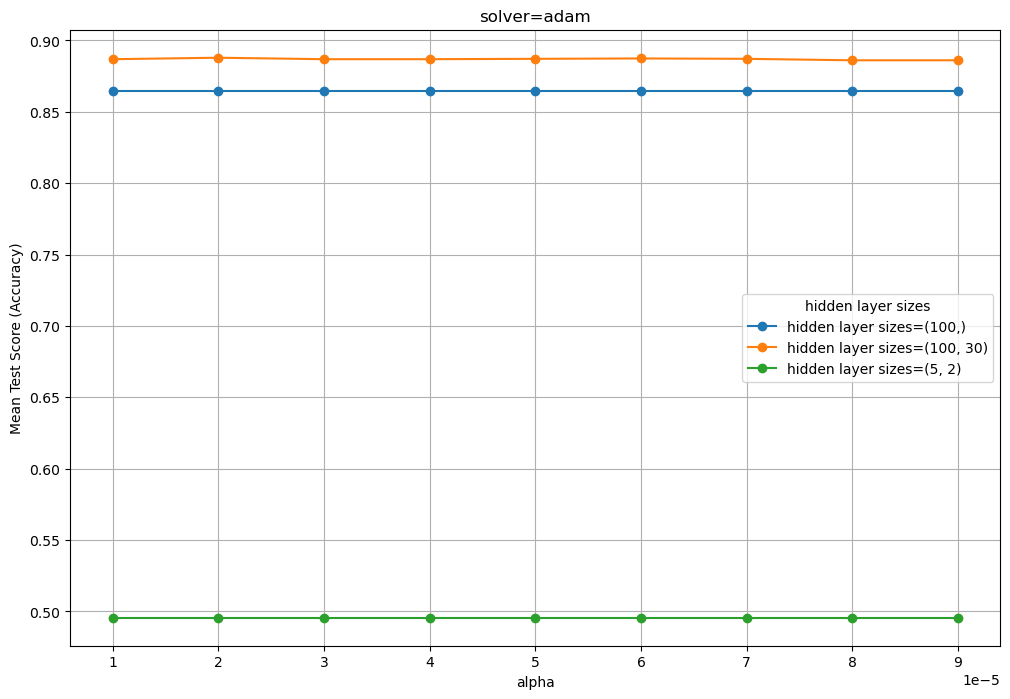

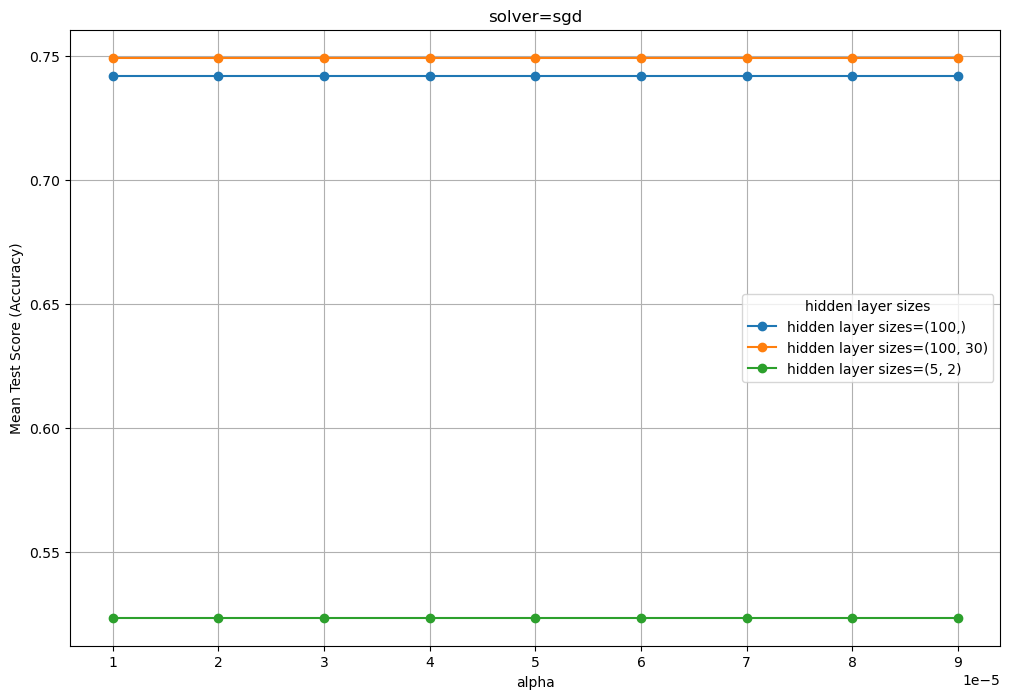

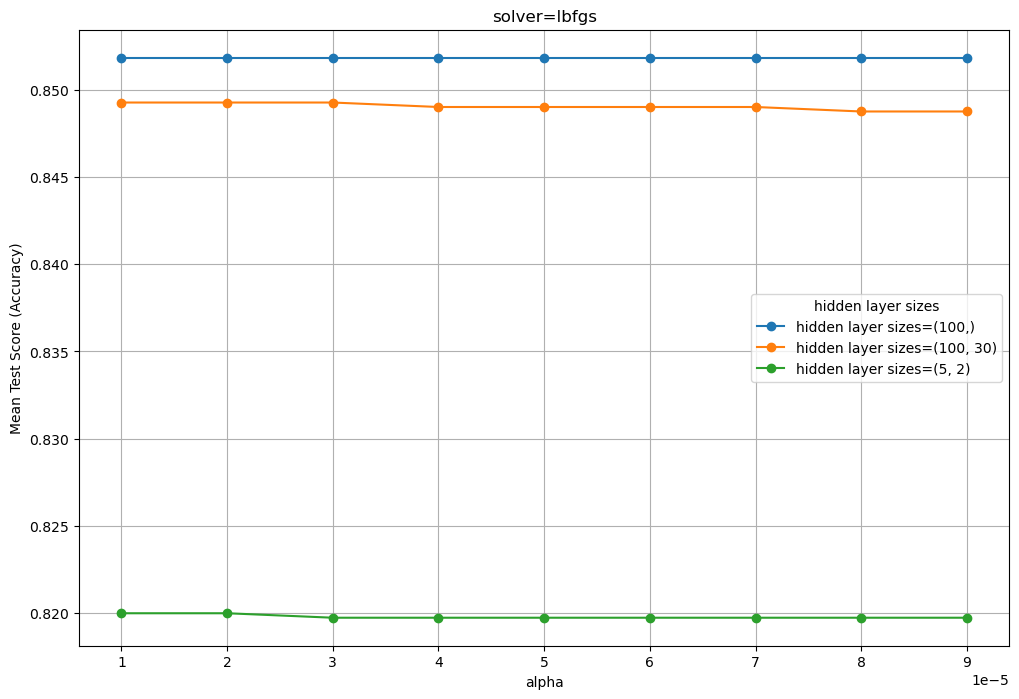

In [11]:
import matplotlib.pyplot as plt
import pandas as pd

# 假设 grid 是你的 GridSearchCV 对象
results = grid.cv_results_

# 将 cv_results_ 转换为 DataFrame
results_df = pd.DataFrame(results)

# 获取不同的 solver 值
solvers = results_df['param_solver'].unique()

# 为每个 solver 绘制一个图，每个图中绘制不同 hidden_layer_sizes 的曲线
for solver in solvers:
    # 为当前 solver 筛选数据
    solver_results = results_df[results_df['param_solver'] == solver]
    
    # 获取当前 solver 下的所有 hidden_layer_sizes 值
    hidden_layer_sizes = solver_results['param_hidden_layer_sizes'].unique()
    
    # 绘制图表
    plt.figure(figsize=(12, 8))
    
    for hl_size in hidden_layer_sizes:
        # 筛选当前 solver 和 hidden_layer_sizes 下的数据
        hl_results = solver_results[solver_results['param_hidden_layer_sizes'] == hl_size]
        
        # 绘制当前 hidden_layer_sizes 的曲线
        plt.plot(hl_results['param_alpha'], hl_results['mean_test_score'], marker='o', label=f'hidden layer sizes={hl_size}')
    
    plt.title(f'solver={solver}')
    plt.xlabel('alpha')
    plt.ylabel('Mean Test Score (Accuracy)')
    plt.legend(title='hidden layer sizes')
    plt.grid(True)
    plt.show()

In [7]:
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
bp = MLPClassifier(solver='adam', alpha=1e-5,hidden_layer_sizes=(100,3), random_state=1) 
kfold = KFold(n_splits=10)
bp_scores = cross_val_score(bp, X_train, y_train, cv=kfold)
cv_cross_bp = cross_validate(bp, X_train, y_train, cv=kfold, scoring=('accuracy', 'f1'))
print("bp Accuracy: %0.2f (+/- %0.2f)" % (bp_scores.mean(), bp_scores.std() * 2))
print("bp测试结果：",cv_cross_bp)

bp Accuracy: 0.90 (+/- 0.04)
bp测试结果： {'fit_time': array([3.56848073, 4.00235105, 3.3772881 , 3.62799025, 3.96148157,
       3.80294752, 3.33093071, 4.09140134, 3.05816698, 3.79127502]), 'score_time': array([0.00199795, 0.00100112, 0.00100303, 0.00311184, 0.00298333,
       0.00100589, 0.00100017, 0.00179553, 0.00169182, 0.00099945]), 'test_accuracy': array([0.88431877, 0.91002571, 0.9151671 , 0.89203085, 0.88946015,
       0.91002571, 0.84832905, 0.89974293, 0.90979381, 0.90979381]), 'test_f1': array([0.88491049, 0.90304709, 0.90858726, 0.89393939, 0.87955182,
       0.90566038, 0.84910486, 0.90736342, 0.90304709, 0.90861619])}


In [12]:
# 计算平均训练时间和评分时间
mean_fit_time = np.mean(cv_cross_bp['fit_time'])
mean_score_time = np.mean(cv_cross_bp['score_time'])

# 计算准确率和F1分数的平均值和标准差
mean_accuracy = np.mean(cv_cross_bp['test_accuracy'])
std_accuracy = np.std(cv_cross_bp['test_accuracy'])

mean_f1 = np.mean(cv_cross_bp['test_f1'])
std_f1 = np.std(cv_cross_bp['test_f1'])

print(f"Average fit time: {mean_fit_time:.2f} seconds")
print(f"Average score time: {mean_score_time:.5f} seconds")
print(f"Average accuracy: {mean_accuracy:.2f} (+/- {std_accuracy:.2f})")
print(f"Average F1 score: {mean_f1:.2f} (+/- {std_f1:.2f})")

Average fit time: 3.66 seconds
Average score time: 0.00166 seconds
Average accuracy: 0.90 (+/- 0.02)
Average F1 score: 0.89 (+/- 0.02)
